In [1]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br

from pycbc import conversions as conv
from  pycbc.filter.matchedfilter import optimized_match

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from scipy.optimize import minimize
import lalsimulation as ls
import lal

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter

from pycbc import types, fft, waveform

In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14
})

%config InlineBackend.figure_format='retina' # very useful command for high-res images


# Read Binaries from Population file

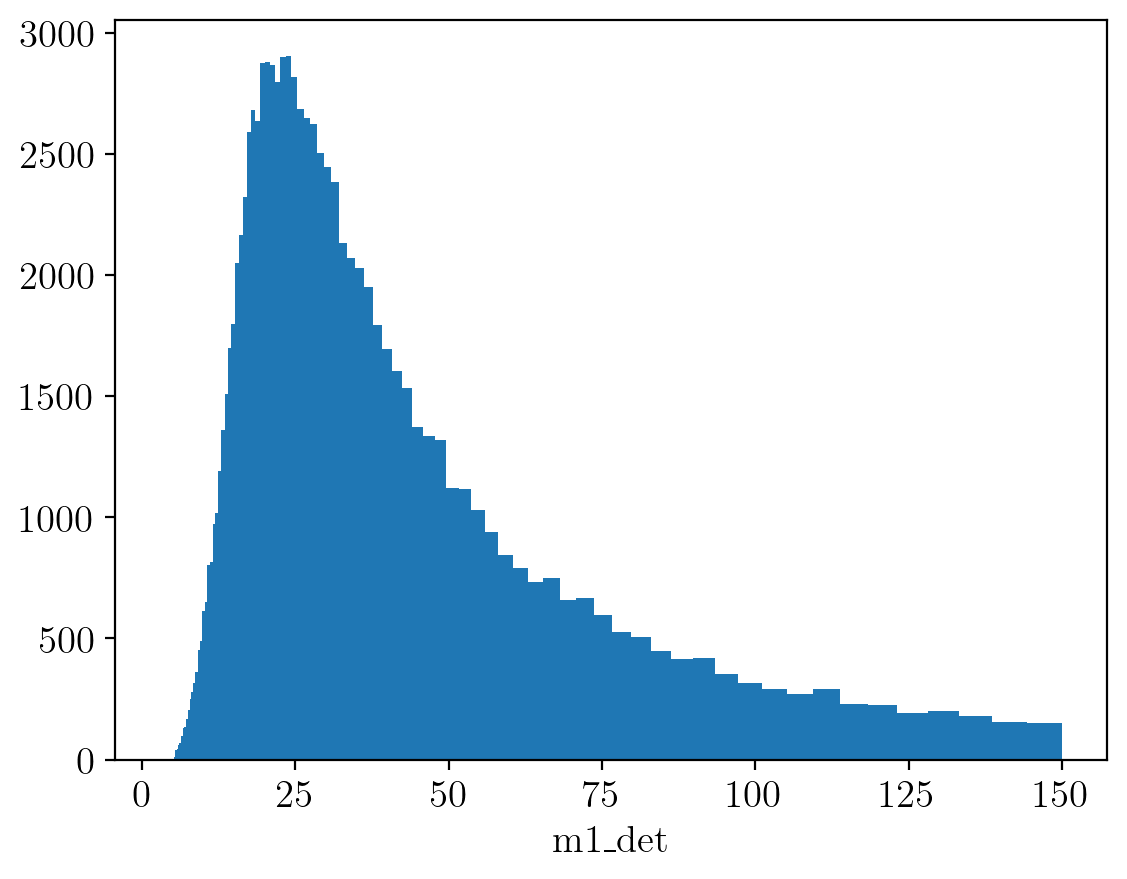

In [3]:
input_file = 'smooth_powerlaw_pop.npz'
with np.load(input_file, mmap_mode='r') as binaries:
    Mcs = np.array(binaries['Mcs'])
    etas = np.array(binaries['etas'])
    chi1z = np.array(binaries['chi1z'])
    chi2z = np.array(binaries['chi2z'])
    DLs = np.array(binaries['DLs'])
    iotas = np.array(binaries['iotas'])
    ras = np.array(binaries['ras'])
    decs = np.array(binaries['decs'])
    psis = np.array(binaries['psis'])

m1s = conv.mass1_from_mchirp_eta(Mcs, etas)
mtots = conv.mtotal_from_mchirp_eta(Mcs, etas)


plt.hist(m1s, bins = np.geomspace(3.0, 150.0, 100))
plt.xlabel('m1_det')
plt.show()


# The Naive way

In [4]:
from pycbc.types import FrequencySeries
from pycbc.filter import match, optimized_match, overlap
import pycbc.filter as fil

In [5]:
# i = 54837 # Golden Binary
i = 47519 # 'Pessimistic' Binary

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    'gmst0': 0,
    'hybr': 0.0
} 

net_key = '3G'

approx1 = 'IMRPhenomXAS'
# approx1 = 'IMRPhenomB'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_1 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=True)

net_2 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=False)



delta_f = net_1.f[1] - net_1.f[0]
psd = FrequencySeries(net_1.detectors[0].psd, delta_f=delta_f) # calculate mismatch using any one detector PSD

# make sure that the detector and waveform frequency ranges overlap
freq_mask = np.in1d(net_1.f, net_1.detectors[0].f, assume_unique=True)

hp1_pyc = FrequencySeries(net_1.hfp[freq_mask], delta_f=delta_f)
hp2_pyc = FrequencySeries(net_2.hfp[freq_mask], delta_f=delta_f)


faith, index = fil.optimized_match(hp1_pyc, hp2_pyc, psd=psd, low_frequency_cutoff=net_1.f[0], high_frequency_cutoff=net_1.f[-1])

overlapp = fil.overlap(hp1_pyc, hp2_pyc, psd=psd, low_frequency_cutoff=net_1.f[0], high_frequency_cutoff=net_1.f[-1])

# Compute the inner product (unoptimized faithfulness)
hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc) / psd).data)
hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)
inner_prod = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

print(faith)
print(overlapp)
print(inner_prod)

2023-11-26 18:01:40,380 - Network - INFO : Polarizations calculated.
2023-11-26 18:01:40,380 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-26 18:01:40,384 - Network - INFO : Polarizations calculated.
2023-11-26 18:01:41,061 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-26 18:01:41,115 - Network - INFO : PSDs loaded.
2023-11-26 18:01:41,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-26 18:01:41,131 - Network - INFO : Detector responses calculated.
2023-11-26 18:01:41,132 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-26 18:01:41,133 - Network - INFO :    CE-40_C
2023-11-26 18:01:41,583 - Network - INFO :    CE-20_S
2023-11-26 18:01:42,026 - Network - INFO :    ET_ET1
2023-11-26 18:01:42,477 - Network - INFO :    ET_ET2
2023-11-26 18:01:42,923 - Network - INFO :    ET_ET3
2023-11-26 18:01:43,402 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-26 1

0.9997376559524973
-0.6988639928580822
0.7074812990832585


In [6]:
# define function for scipy's optimization routines
inj_params_opt = inj_params.copy()
hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc) * delta_f / psd).data)

def overlap_func(params):
    tc, phic = params
    if (phic>2*np.pi or phic<0.0):
        return +100000
    # if (psi>2*np.pi or psi<0.0):
    #     return +100000
    inj_params_opt['tc'] = tc
    inj_params_opt['phic'] = phic
    # inj_params_opt['psi'] = psi

    net_2 = gwnet.get_network_response(inj_params=inj_params_opt, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=False)

    hp2_pyc = FrequencySeries(net_2.hfp[freq_mask], delta_f=delta_f)

    # inner_prod = fil.overlap(hp1_pyc, hp2_pyc, psd=psd, low_frequency_cutoff=net_1.f[0], high_frequency_cutoff=net_1.f[-1], normalized=True)
    hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) * delta_f/ psd).data)

    inner_prod = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)* delta_f/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

    return 1-inner_prod


In [7]:
initial=[0., 0.]
result = minimize(overlap_func, initial, method='nelder-mead')

2023-11-26 18:04:01,982 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:01,987 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:01,992 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:01,998 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,003 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,007 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,012 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,017 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,021 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,026 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,030 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,036 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,040 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,052 - Network - INFO : Polarizations calculated.
2023-11-26 18:04:02,068 - Network 

In [9]:
print(result)
tc_opt, phic_opt = result.x

print(faith)
print(1-result.fun)
print(tc_opt, phic_opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002519309599476882
             x: [-6.197e-03  3.098e-03]
           nit: 51
          nfev: 91
 final_simplex: (array([[-6.197e-03,  3.098e-03],
                       [-6.197e-03,  3.036e-03],
                       [-6.197e-03,  3.020e-03]]), array([ 2.519e-04,  2.519e-04,  2.519e-04]))
0.9997376559524973
0.9997480690400523
-0.006196967482566835 0.0030984837412834174


In [91]:
inj_params_opt = inj_params.copy()
inj_params_opt['tc'] = tc_opt
inj_params_opt['phic'] = phic_opt
# inj_params_opt['psi'] = psi_opt


In [92]:
# compare CV biases with and without aligning the waveforms
net_2 = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params, network_key=net_key, f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)
cv_biases_no_opt = net_2.cutler_vallisneri_bias.tolist()[0]

2023-11-22 14:25:59,125 - Network - INFO : Polarizations calculated.
2023-11-22 14:25:59,125 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 14:25:59,132 - Network - INFO : Polarizations calculated.
2023-11-22 14:25:59,949 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 14:26:00,000 - Network - INFO : PSDs loaded.
2023-11-22 14:26:00,004 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 14:26:00,034 - Network - INFO : Detector responses calculated.
2023-11-22 14:26:00,035 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 14:26:00,036 - Network - INFO :    CE-40_C
2023-11-22 14:26:00,623 - Network - INFO :    CE-20_S
2023-11-22 14:26:01,239 - Network - INFO :    ET_ET1
2023-11-22 14:26:02,145 - Network - INFO :    ET_ET2
2023-11-22 14:26:03,092 - Network - INFO :    ET_ET3
2023-11-22 14:26:04,055 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 1

In [93]:
net_2_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt, network_key=net_key, f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)
cv_biases_opt = net_2_opt.cutler_vallisneri_bias.tolist()[0]

2023-11-22 14:26:04,503 - Network - INFO : Polarizations calculated.
2023-11-22 14:26:04,505 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 14:26:04,517 - Network - INFO : Polarizations calculated.
2023-11-22 14:26:05,972 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 14:26:06,046 - Network - INFO : PSDs loaded.
2023-11-22 14:26:06,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 14:26:06,079 - Network - INFO : Detector responses calculated.
2023-11-22 14:26:06,080 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 14:26:06,081 - Network - INFO :    CE-40_C
2023-11-22 14:26:07,086 - Network - INFO :    CE-20_S
2023-11-22 14:26:08,195 - Network - INFO :    ET_ET1
2023-11-22 14:26:09,192 - Network - INFO :    ET_ET2
2023-11-22 14:26:10,053 - Network - INFO :    ET_ET3
2023-11-22 14:26:10,995 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 1

In [95]:
net_2 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=True)
net_2_opt = gwnet.get_network_response(inj_params=inj_params_opt, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=True)

print(net_2.snr)
print(net_2_opt.snr)

2023-11-22 14:27:30,581 - Network - INFO : Polarizations calculated.
2023-11-22 14:27:30,582 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 14:27:30,585 - Network - INFO : Polarizations calculated.
2023-11-22 14:27:31,191 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 14:27:31,244 - Network - INFO : PSDs loaded.
2023-11-22 14:27:31,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 14:27:31,257 - Network - INFO : Detector responses calculated.
2023-11-22 14:27:31,258 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 14:27:31,258 - Network - INFO :    CE-40_C
2023-11-22 14:27:31,681 - Network - INFO :    CE-20_S
2023-11-22 14:27:32,081 - Network - INFO :    ET_ET1
2023-11-22 14:27:32,483 - Network - INFO :    ET_ET2
2023-11-22 14:27:32,889 - Network - INFO :    ET_ET3
2023-11-22 14:27:33,340 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 1

344.16228223793877
344.16228223793877


In [30]:
for i, param in enumerate(net_2.deriv_variables):
    print(param)
    # print(inj_params[param])
    # print(inj_params[param]+ cv_biases_opt[i])
    print(cv_biases_opt[i]/net_2_opt.errs[param])
    print()

Mc
3.8893002999193493

eta
3.5557581112108685

chi1z
-4.00442243442206

chi2z
4.127178309431543

DL
28.56247491153051

tc
3.9183946214944365

phic
1.627364862778597

iota
0.5702301283758118

ra
-0.6740009096085883

dec
0.3013826113481269

psi
0.3361389550452662



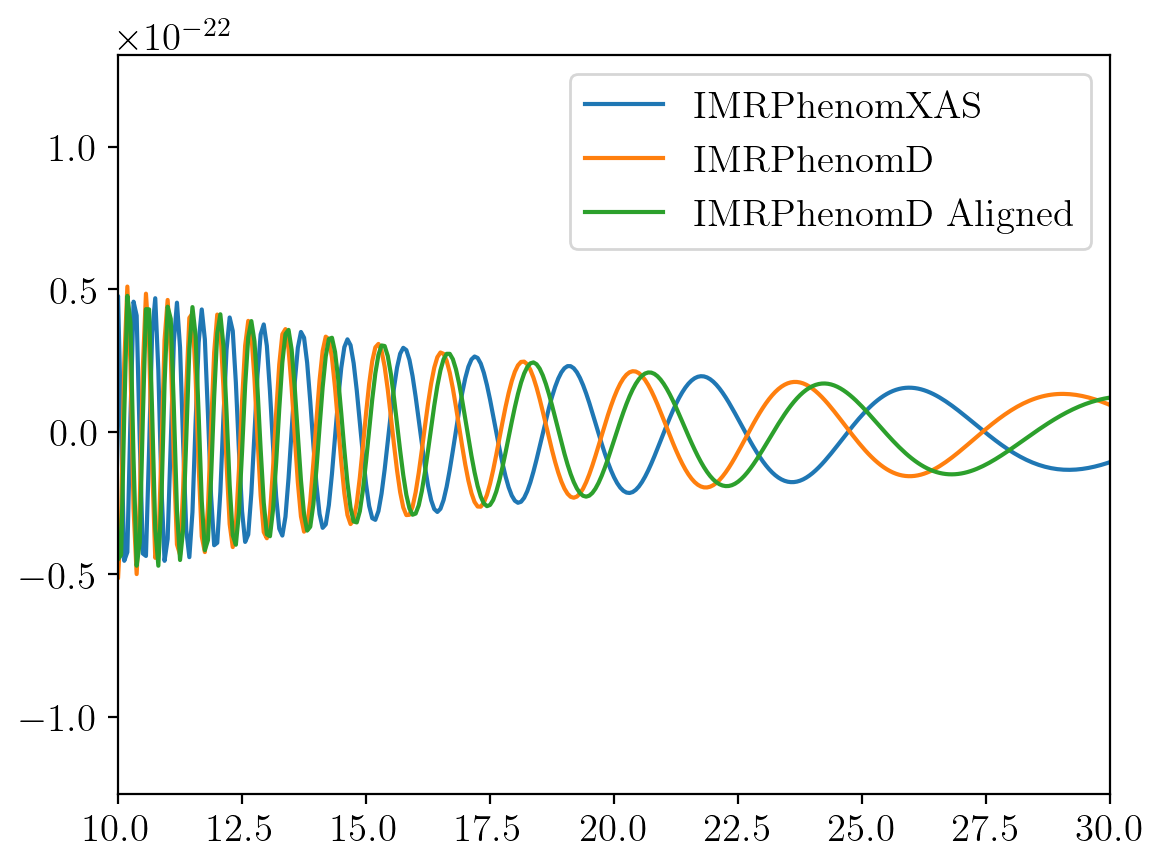

In [31]:
plt.plot(net_1.f, net_1.hfp, label='IMRPhenomXAS')
plt.plot(net_2.f, net_2.hfp, label='IMRPhenomD')
plt.plot(net_2_opt.f, net_2_opt.hfp, label='IMRPhenomD Aligned')

plt.xlim(10, 30)
plt.legend()
plt.show()


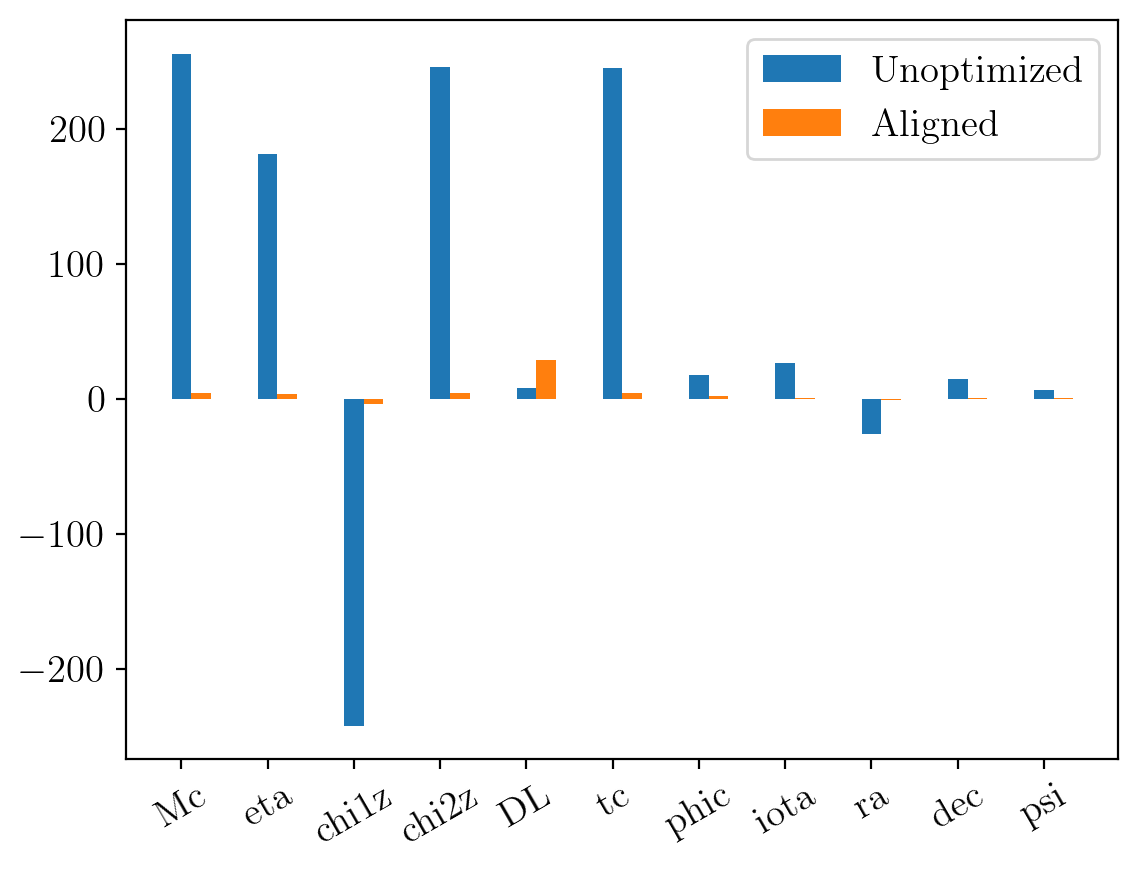

Mc, not: 255.568 sigma
Mc, opt: 3.889 sigma

eta, not: 181.301 sigma
eta, opt: 3.556 sigma

chi1z, not: -241.991 sigma
chi1z, opt: -4.004 sigma

chi2z, not: 245.741 sigma
chi2z, opt: 4.127 sigma

DL, not: 7.819 sigma
DL, opt: 28.562 sigma

tc, not: 244.473 sigma
tc, opt: 3.918 sigma

phic, not: 17.354 sigma
phic, opt: 1.627 sigma

iota, not: 26.345 sigma
iota, opt: 0.570 sigma

ra, not: -26.289 sigma
ra, opt: -0.674 sigma

dec, not: 14.277 sigma
dec, opt: 0.301 sigma

psi, not: 6.301 sigma
psi, opt: 0.336 sigma



In [32]:
err_opt = np.zeros(len(cv_biases_opt))

err_no_opt = np.zeros(len(cv_biases_no_opt))


for i, param in enumerate(net_2_opt.deriv_variables):
    err_no_opt[i] = net_2.errs[param]
    err_opt[i] = net_2_opt.errs[param]


x = np.linspace(0, len(cv_biases_opt), len(cv_biases_opt))

width = 0.25
plt.bar(x, cv_biases_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, cv_biases_opt/err_opt, width=width, label='Aligned')

plt.xticks(x, net_2_opt.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()


for i, param in enumerate(net_2.deriv_variables):
    bias1 = cv_biases_no_opt[i]/net_2.errs[param]
    bias2 = cv_biases_opt[i]/net_2_opt.errs[param]
    bias_diff_perc = 100*(bias1-bias2)/bias1
    
    # print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()

# The Naive Way (with functions)

In [15]:
def overlap_func(params):
        tc, phic = params
        if (phic>2*np.pi or phic<0.0):
            return +100000
        
        inj_params_opt['tc'] = tc
        inj_params_opt['phic'] = phic

        net_2_try = gwnet.get_network_response(inj_params=inj_params_opt, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=False)

        hp2_pyc = FrequencySeries(net_2_try.hfp[freq_mask], delta_f=delta_f)

        hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)

        inner_prod = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))

        return 1-inner_prod

def cv_biases_aligned(i):
    inj_params = {
        'Mc':    Mcs[i],
        'eta':   etas[i],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[i],
        'chi2z': chi2z[i],
        'DL':    DLs[i],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[i],
        'ra':    ras[i],
        'dec':   decs[i],
        'psi':   psis[i],
        'gmst0': 0,
        'hybr': 0.0
    } 

    net_key = '3G'

    approx1 = 'IMRPhenomXAS'
    approx2 = 'IMRPhenomD'

    d_f = 2**-4
    f_low = 5.0
    mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
    f_high = np.round(4*br.f_isco_Msolar(mtotal))

    net_1 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=True)
    net_2 = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx2, network_key=net_key, calc_detector_responses=False)



    delta_f = net_1.f[1] - net_1.f[0]
    psd = FrequencySeries(net_1.detectors[0].psd, delta_f=delta_f) # calculate mismatch using any one detector PSD

    # make sure that the detector and waveform frequency ranges overlap
    freq_mask = np.in1d(net_1.f, net_1.detectors[0].f, assume_unique=True)

    hp1_pyc = FrequencySeries(net_1.hfp[freq_mask], delta_f=delta_f)
    hp2_pyc = FrequencySeries(net_2.hfp[freq_mask], delta_f=delta_f)
    
    hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc) / psd).data)
    hp2_norm = np.sum((hp2_pyc * np.conjugate(hp2_pyc) / psd).data)
    inner_prod_no_opt = np.abs(np.sum((hp1_pyc * np.conjugate(hp2_pyc)/psd).data)) / np.abs(np.sqrt(hp1_norm*hp2_norm))


    initial=[0., 0.]
    result = minimize(overlap_func, initial, method='nelder-mead')
    print(result)
    tc_opt, phic_opt = result.x


    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = tc_opt
    inj_params_opt['phic'] = phic_opt

    # compare CV biases with and without aligning the waveforms
    net_2 = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params, network_key=net_key, f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)

    net_2_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt, network_key=net_key, f_max=f_high, approximant1=approx1, approximant2=approx2, cond_num=1e25)

    # plt.plot(net_1.f, net_1.hfp, label='IMRPhenomXAS')
    # plt.plot(net_2.f, net_2.hfp, label='IMRPhenomD')
    # plt.plot(net_2_opt.f, net_2_opt.hfp, label='IMRPhenomD Aligned')

    # plt.xlim(10, 30)
    # plt.legend()
    # plt.show()

    print("faithfulness before aligning:", inner_prod_no_opt)
    print("faithfulness after aligning:", 1-result.fun)
    return net_2, net_2_opt

In [18]:
i = 54837 # 'Golden' Binary
# i = 47519 # 'Pessimistic' Binary

net_no_opt, net_opt = cv_biases_aligned(i)
cv_biases_no_opt = net_no_opt.cutler_vallisneri_bias.tolist()[0]
cv_biases_opt = net_opt.cutler_vallisneri_bias.tolist()[0]


2023-11-22 13:29:42,611 - Network - INFO : Polarizations calculated.
2023-11-22 13:29:42,611 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 13:29:42,615 - Network - INFO : Polarizations calculated.
2023-11-22 13:29:43,322 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 13:29:43,460 - Network - INFO : PSDs loaded.
2023-11-22 13:29:43,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 13:29:43,475 - Network - INFO : Detector responses calculated.
2023-11-22 13:29:43,476 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 13:29:43,476 - Network - INFO :    CE-40_C
2023-11-22 13:29:43,934 - Network - INFO :    CE-20_S
2023-11-22 13:29:44,382 - Network - INFO :    ET_ET1
2023-11-22 13:29:44,834 - Network - INFO :    ET_ET2
2023-11-22 13:29:45,287 - Network - INFO :    ET_ET3
2023-11-22 13:29:45,764 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 1

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002519309599476882
             x: [-6.197e-03  3.098e-03]
           nit: 51
          nfev: 91
 final_simplex: (array([[-6.197e-03,  3.098e-03],
                       [-6.197e-03,  3.036e-03],
                       [-6.197e-03,  3.020e-03]]), array([ 2.519e-04,  2.519e-04,  2.519e-04]))


2023-11-22 13:29:47,308 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 13:29:47,364 - Network - INFO : PSDs loaded.
2023-11-22 13:29:47,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 13:29:47,400 - Network - INFO : Detector responses calculated.
2023-11-22 13:29:47,401 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 13:29:47,401 - Network - INFO :    CE-40_C
2023-11-22 13:29:48,451 - Network - INFO :    CE-20_S
2023-11-22 13:29:49,471 - Network - INFO :    ET_ET1
2023-11-22 13:29:50,372 - Network - INFO :    ET_ET2
2023-11-22 13:29:51,322 - Network - INFO :    ET_ET3
2023-11-22 13:29:52,208 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 13:29:52,213 - Network - INFO : SNRs calculated.
2023-11-22 13:29:52,214 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 13:29:52,214 - Network - INFO :    CE-40_C
2023-11-22 13:29:52,274 - Network - INFO :

faithfulness before aligning: 0.7237961352453066
faithfulness after aligning: 0.9997480690400523


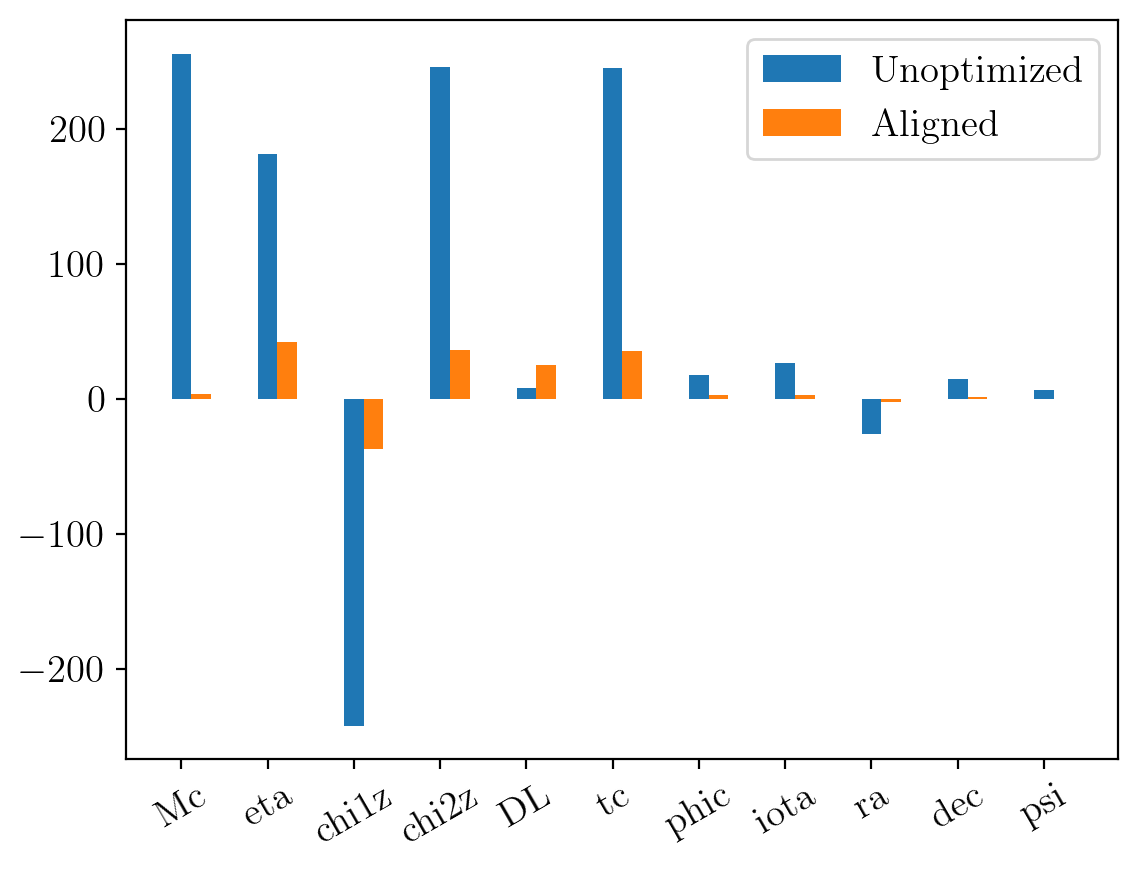

Mc, not: 255.568 sigma
Mc, opt: 3.432 sigma

eta, not: 181.301 sigma
eta, opt: 42.028 sigma

chi1z, not: -241.991 sigma
chi1z, opt: -37.036 sigma

chi2z, not: 245.741 sigma
chi2z, opt: 36.062 sigma

DL, not: 7.819 sigma
DL, opt: 25.073 sigma

tc, not: 244.473 sigma
tc, opt: 35.599 sigma

phic, not: 17.354 sigma
phic, opt: 2.588 sigma

iota, not: 26.345 sigma
iota, opt: 2.784 sigma

ra, not: -26.289 sigma
ra, opt: -2.436 sigma

dec, not: 14.277 sigma
dec, opt: 1.495 sigma

psi, not: 6.301 sigma
psi, opt: -0.182 sigma



In [19]:
err_opt = np.zeros(len(cv_biases_opt))

err_no_opt = np.zeros(len(cv_biases_no_opt))


for i, param in enumerate(net_no_opt.deriv_variables):
    err_no_opt[i] = net_no_opt.errs[param]
    err_opt[i] = net_opt.errs[param]

x = np.linspace(0, len(cv_biases_opt), len(cv_biases_opt))

width = 0.25
plt.bar(x, cv_biases_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, cv_biases_opt/err_opt, width=width, label='Aligned')

plt.xticks(x, net_2_opt.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()


for i, param in enumerate(net_2.deriv_variables):
    bias1 = cv_biases_no_opt[i]/net_no_opt.errs[param]
    bias2 = cv_biases_opt[i]/net_opt.errs[param]
    bias_diff_perc = 100*(bias1-bias2)/bias1
    
    # print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()

# Test over some random binaries

2023-11-22 12:35:17,340 - Network - INFO : Polarizations calculated.
2023-11-22 12:35:17,341 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:35:17,345 - Network - INFO : Polarizations calculated.
2023-11-22 12:35:18,637 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:35:18,683 - Network - INFO : PSDs loaded.
2023-11-22 12:35:18,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:35:18,701 - Network - INFO : Detector responses calculated.
2023-11-22 12:35:18,702 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:35:18,702 - Network - INFO :    CE-40_C
2023-11-22 12:35:19,536 - Network - INFO :    CE-20_S
2023-11-22 12:35:20,358 - Network - INFO :    ET_ET1
2023-11-22 12:35:21,192 - Network - INFO :    ET_ET2
2023-11-22 12:35:22,017 - Network - INFO :    ET_ET3
2023-11-22 12:35:22,850 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 1

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:35:24,827 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:35:24,872 - Network - INFO : PSDs loaded.
2023-11-22 12:35:24,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:35:24,909 - Network - INFO : Detector responses calculated.
2023-11-22 12:35:24,910 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:35:24,911 - Network - INFO :    CE-40_C
2023-11-22 12:35:25,914 - Network - INFO :    CE-20_S
2023-11-22 12:35:26,988 - Network - INFO :    ET_ET1
2023-11-22 12:35:28,215 - Network - INFO :    ET_ET2
2023-11-22 12:35:29,492 - Network - INFO :    ET_ET3
2023-11-22 12:35:30,797 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:35:30,800 - Network - INFO : SNRs calculated.
2023-11-22 12:35:30,801 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:35:30,801 - Network - INFO :    CE-40_C
2023-11-22 12:35:30,859 - Network - INFO :

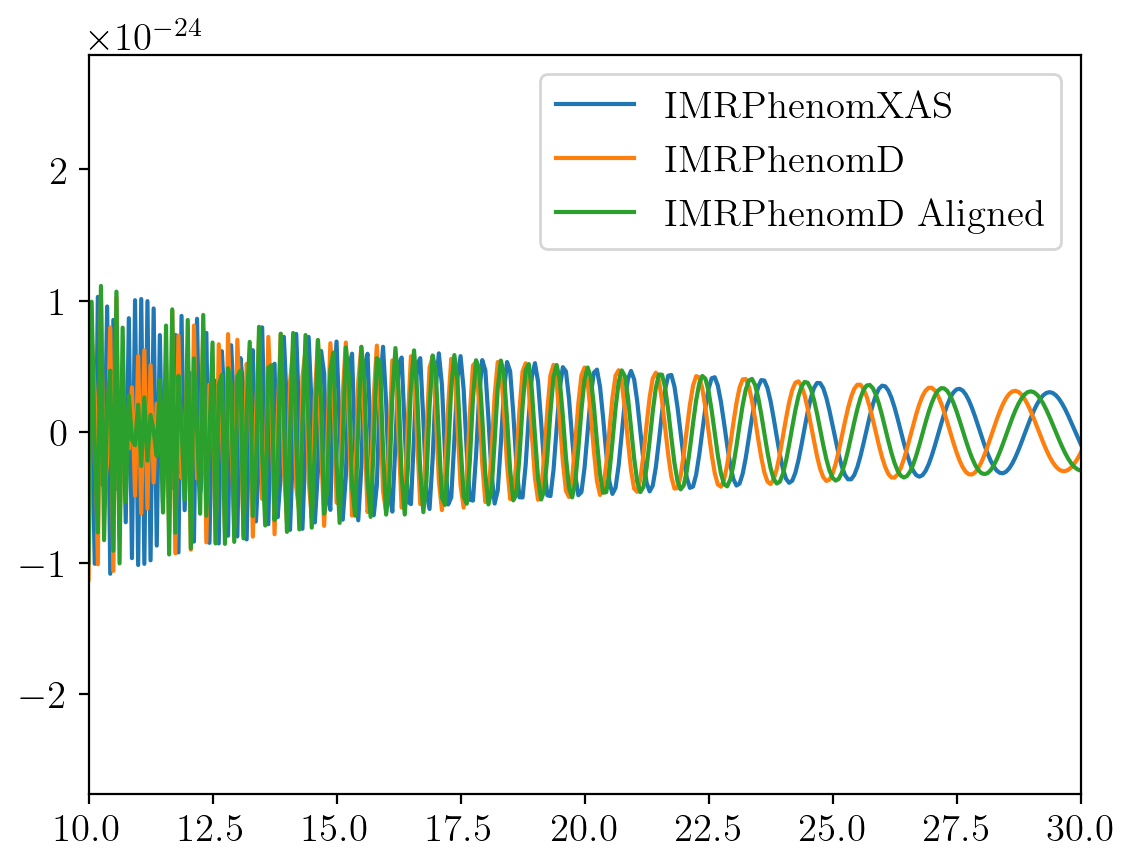

2023-11-22 12:35:41,271 - Network - INFO : Polarizations calculated.
2023-11-22 12:35:41,272 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:35:41,276 - Network - INFO : Polarizations calculated.


faithfulness before aligning: 0.9991654159650082
faithfulness after aligning: 0.9997090882642703


2023-11-22 12:35:42,094 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:35:42,166 - Network - INFO : PSDs loaded.
2023-11-22 12:35:42,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:35:42,188 - Network - INFO : Detector responses calculated.
2023-11-22 12:35:42,189 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:35:42,190 - Network - INFO :    CE-40_C
2023-11-22 12:35:42,765 - Network - INFO :    CE-20_S
2023-11-22 12:35:43,346 - Network - INFO :    ET_ET1
2023-11-22 12:35:43,920 - Network - INFO :    ET_ET2
2023-11-22 12:35:44,501 - Network - INFO :    ET_ET3
2023-11-22 12:35:45,078 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:35:45,081 - Network - INFO : SNRs calculated.
2023-11-22 12:35:45,082 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:35:45,083 - Network - INFO :    CE-40_C
2023-11-22 12:35:45,151 - Network - INFO :

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:35:46,583 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:35:46,655 - Network - INFO : PSDs loaded.
2023-11-22 12:35:46,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:35:46,696 - Network - INFO : Detector responses calculated.
2023-11-22 12:35:46,697 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:35:46,698 - Network - INFO :    CE-40_C
2023-11-22 12:35:47,448 - Network - INFO :    CE-20_S
2023-11-22 12:35:48,195 - Network - INFO :    ET_ET1
2023-11-22 12:35:48,938 - Network - INFO :    ET_ET2
2023-11-22 12:35:49,681 - Network - INFO :    ET_ET3
2023-11-22 12:35:50,428 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:35:50,432 - Network - INFO : SNRs calculated.
2023-11-22 12:35:50,432 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:35:50,433 - Network - INFO :    CE-40_C
2023-11-22 12:35:50,505 - Network - INFO :

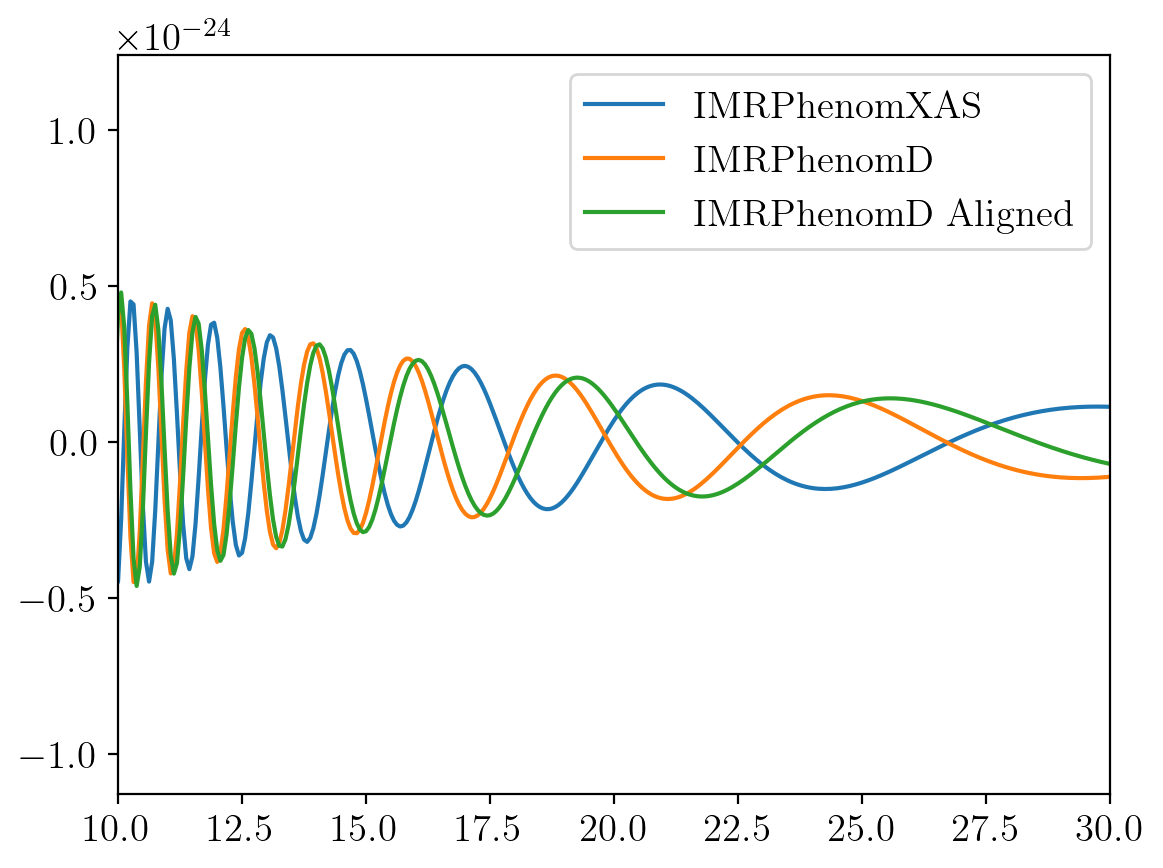

2023-11-22 12:35:56,092 - Network - INFO : Polarizations calculated.
2023-11-22 12:35:56,093 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:35:56,097 - Network - INFO : Polarizations calculated.


faithfulness before aligning: 0.6703056473686642
faithfulness after aligning: 0.9997090882642703


2023-11-22 12:35:57,498 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:35:57,573 - Network - INFO : PSDs loaded.
2023-11-22 12:35:57,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:35:57,592 - Network - INFO : Detector responses calculated.
2023-11-22 12:35:57,592 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:35:57,593 - Network - INFO :    CE-40_C
2023-11-22 12:35:58,471 - Network - INFO :    CE-20_S
2023-11-22 12:35:59,344 - Network - INFO :    ET_ET1
2023-11-22 12:36:00,195 - Network - INFO :    ET_ET2
2023-11-22 12:36:01,049 - Network - INFO :    ET_ET3
2023-11-22 12:36:01,895 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:36:01,898 - Network - INFO : SNRs calculated.
2023-11-22 12:36:01,899 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:36:01,899 - Network - INFO :    CE-40_C
2023-11-22 12:36:01,951 - Network - INFO :

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:36:04,049 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:36:04,213 - Network - INFO : PSDs loaded.
2023-11-22 12:36:04,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:36:04,245 - Network - INFO : Detector responses calculated.
2023-11-22 12:36:04,245 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:36:04,246 - Network - INFO :    CE-40_C
2023-11-22 12:36:05,284 - Network - INFO :    CE-20_S
2023-11-22 12:36:06,386 - Network - INFO :    ET_ET1
2023-11-22 12:36:07,480 - Network - INFO :    ET_ET2
2023-11-22 12:36:08,593 - Network - INFO :    ET_ET3
2023-11-22 12:36:09,724 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:36:09,735 - Network - INFO : SNRs calculated.
2023-11-22 12:36:09,743 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:36:09,755 - Network - INFO :    CE-40_C
2023-11-22 12:36:09,818 - Network - INFO :

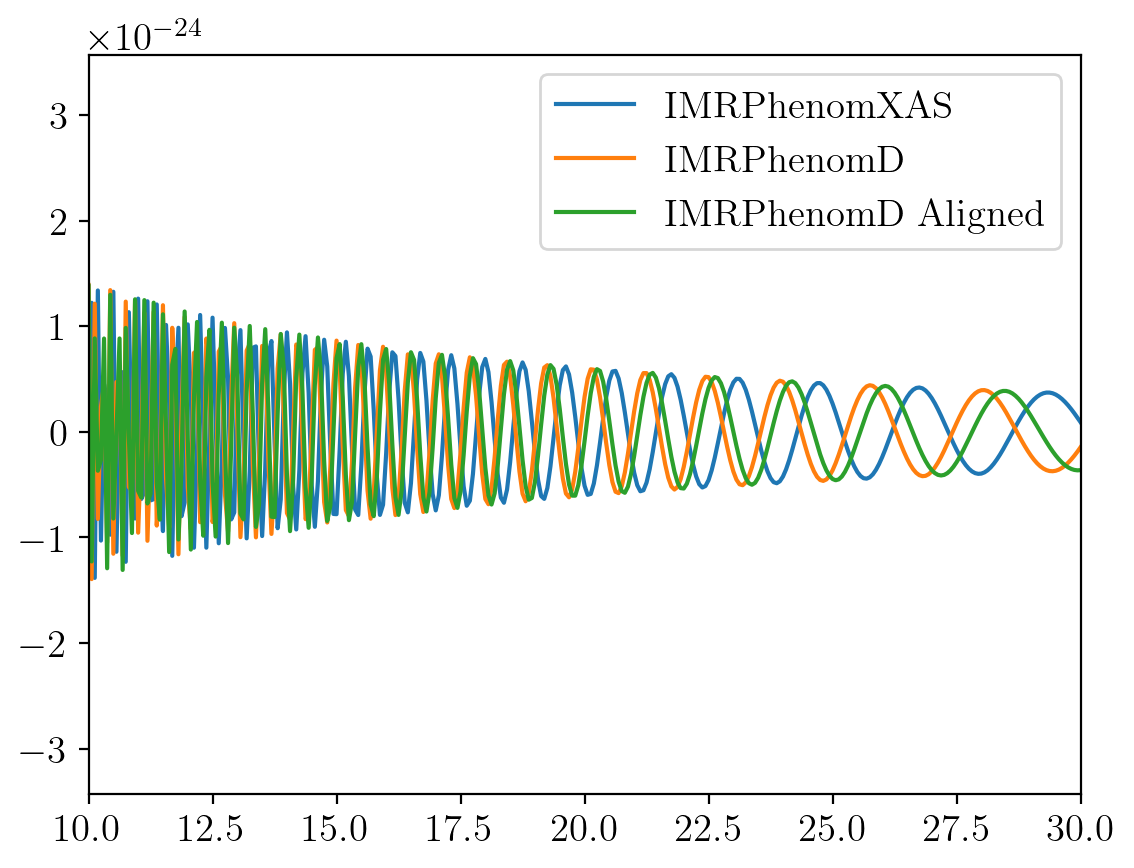

2023-11-22 12:36:18,054 - Network - INFO : Polarizations calculated.
2023-11-22 12:36:18,055 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:36:18,059 - Network - INFO : Polarizations calculated.


faithfulness before aligning: 0.8256948886595897
faithfulness after aligning: 0.9997090882642703


2023-11-22 12:36:19,987 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:36:20,032 - Network - INFO : PSDs loaded.
2023-11-22 12:36:20,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:36:20,051 - Network - INFO : Detector responses calculated.
2023-11-22 12:36:20,052 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:36:20,052 - Network - INFO :    CE-40_C
2023-11-22 12:36:21,229 - Network - INFO :    CE-20_S
2023-11-22 12:36:22,424 - Network - INFO :    ET_ET1
2023-11-22 12:36:23,627 - Network - INFO :    ET_ET2
2023-11-22 12:36:24,880 - Network - INFO :    ET_ET3
2023-11-22 12:36:26,058 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:36:26,062 - Network - INFO : SNRs calculated.
2023-11-22 12:36:26,062 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:36:26,063 - Network - INFO :    CE-40_C
2023-11-22 12:36:26,120 - Network - INFO :

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:36:28,918 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:36:28,963 - Network - INFO : PSDs loaded.
2023-11-22 12:36:28,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:36:29,002 - Network - INFO : Detector responses calculated.
2023-11-22 12:36:29,003 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:36:29,003 - Network - INFO :    CE-40_C
2023-11-22 12:36:30,557 - Network - INFO :    CE-20_S
2023-11-22 12:36:32,051 - Network - INFO :    ET_ET1
2023-11-22 12:36:33,484 - Network - INFO :    ET_ET2
2023-11-22 12:36:34,963 - Network - INFO :    ET_ET3
2023-11-22 12:36:36,408 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:36:36,411 - Network - INFO : SNRs calculated.
2023-11-22 12:36:36,411 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:36:36,412 - Network - INFO :    CE-40_C
2023-11-22 12:36:36,469 - Network - INFO :

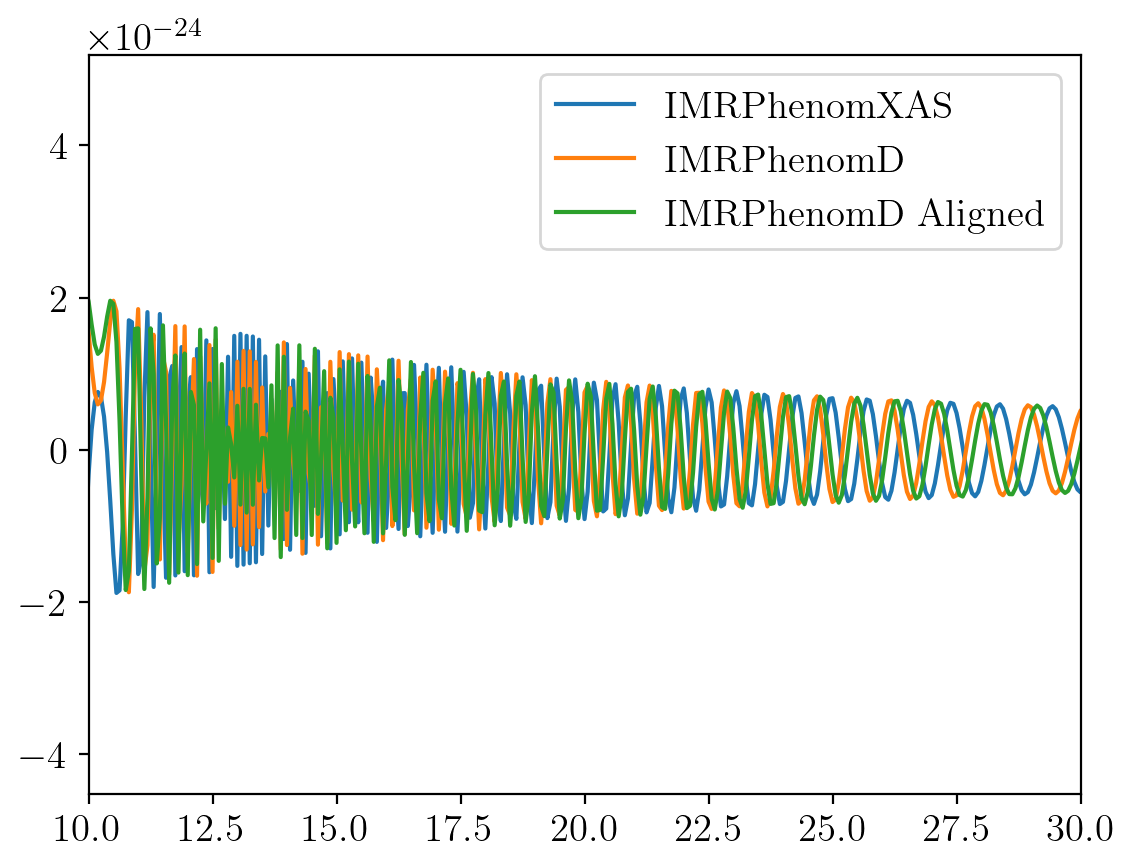

2023-11-22 12:36:47,223 - Network - INFO : Polarizations calculated.
2023-11-22 12:36:47,224 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:36:47,228 - Network - INFO : Polarizations calculated.


faithfulness before aligning: 0.8957657348272215
faithfulness after aligning: 0.9997090882642703


2023-11-22 12:36:49,044 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:36:49,088 - Network - INFO : PSDs loaded.
2023-11-22 12:36:49,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:36:49,105 - Network - INFO : Detector responses calculated.
2023-11-22 12:36:49,105 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:36:49,106 - Network - INFO :    CE-40_C
2023-11-22 12:36:50,223 - Network - INFO :    CE-20_S
2023-11-22 12:36:51,354 - Network - INFO :    ET_ET1
2023-11-22 12:36:52,490 - Network - INFO :    ET_ET2
2023-11-22 12:36:53,621 - Network - INFO :    ET_ET3
2023-11-22 12:36:54,759 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:36:54,763 - Network - INFO : SNRs calculated.
2023-11-22 12:36:54,763 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:36:54,763 - Network - INFO :    CE-40_C
2023-11-22 12:36:54,820 - Network - INFO :

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:36:57,438 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:36:57,482 - Network - INFO : PSDs loaded.
2023-11-22 12:36:57,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:36:57,519 - Network - INFO : Detector responses calculated.
2023-11-22 12:36:57,520 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:36:57,520 - Network - INFO :    CE-40_C
2023-11-22 12:36:58,908 - Network - INFO :    CE-20_S
2023-11-22 12:37:00,316 - Network - INFO :    ET_ET1
2023-11-22 12:37:01,710 - Network - INFO :    ET_ET2
2023-11-22 12:37:03,100 - Network - INFO :    ET_ET3
2023-11-22 12:37:04,464 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:37:04,468 - Network - INFO : SNRs calculated.
2023-11-22 12:37:04,468 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:37:04,468 - Network - INFO :    CE-40_C
2023-11-22 12:37:04,526 - Network - INFO :

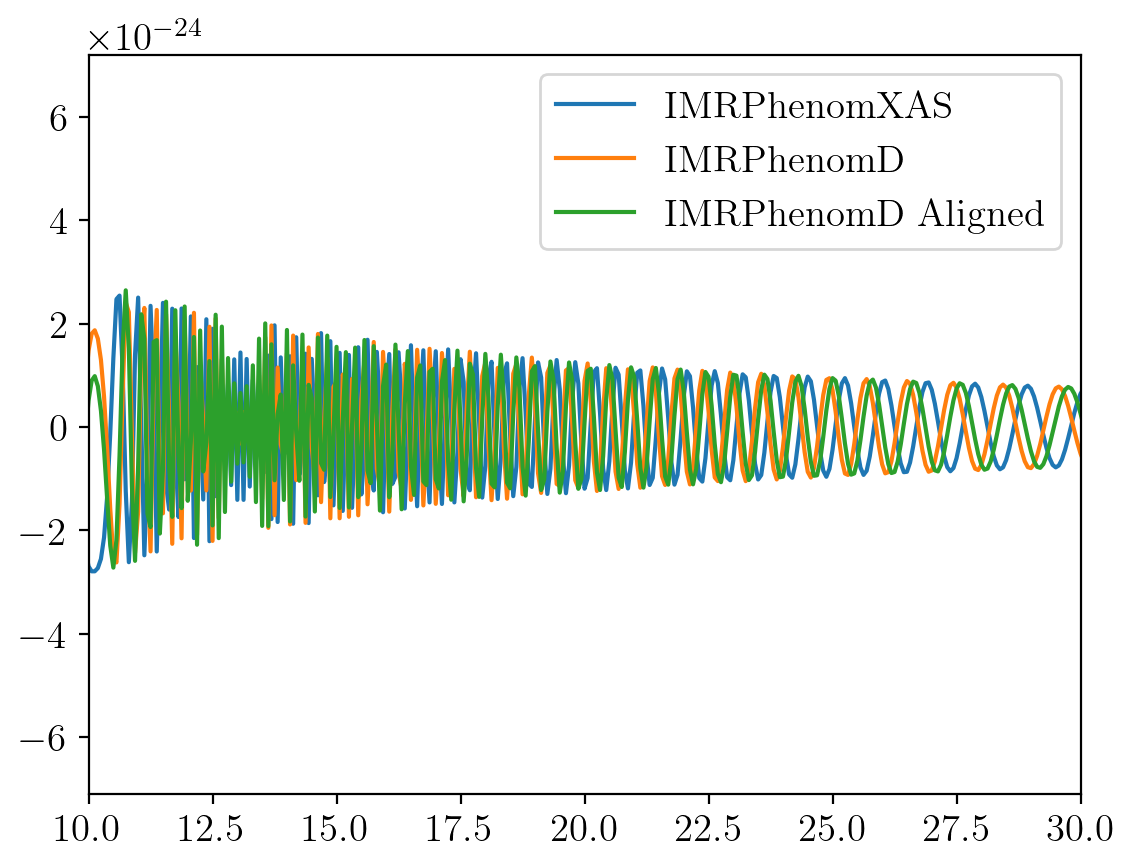

2023-11-22 12:37:15,042 - Network - INFO : Polarizations calculated.
2023-11-22 12:37:15,043 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:37:15,048 - Network - INFO : Polarizations calculated.


faithfulness before aligning: 0.8646586634550381
faithfulness after aligning: 0.9997090882642703


2023-11-22 12:37:17,068 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:37:17,113 - Network - INFO : PSDs loaded.
2023-11-22 12:37:17,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:37:17,131 - Network - INFO : Detector responses calculated.
2023-11-22 12:37:17,132 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:37:17,133 - Network - INFO :    CE-40_C
2023-11-22 12:37:18,390 - Network - INFO :    CE-20_S
2023-11-22 12:37:19,720 - Network - INFO :    ET_ET1
2023-11-22 12:37:20,970 - Network - INFO :    ET_ET2
2023-11-22 12:37:22,304 - Network - INFO :    ET_ET3
2023-11-22 12:37:23,555 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:37:23,559 - Network - INFO : SNRs calculated.
2023-11-22 12:37:23,559 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:37:23,560 - Network - INFO :    CE-40_C
2023-11-22 12:37:23,628 - Network - INFO :

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:37:26,578 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:37:26,711 - Network - INFO : PSDs loaded.
2023-11-22 12:37:26,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:37:26,752 - Network - INFO : Detector responses calculated.
2023-11-22 12:37:26,753 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:37:26,753 - Network - INFO :    CE-40_C
2023-11-22 12:37:28,296 - Network - INFO :    CE-20_S
2023-11-22 12:37:29,834 - Network - INFO :    ET_ET1
2023-11-22 12:37:31,420 - Network - INFO :    ET_ET2
2023-11-22 12:37:32,958 - Network - INFO :    ET_ET3
2023-11-22 12:37:34,523 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:37:34,526 - Network - INFO : SNRs calculated.
2023-11-22 12:37:34,527 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:37:34,527 - Network - INFO :    CE-40_C
2023-11-22 12:37:34,586 - Network - INFO :

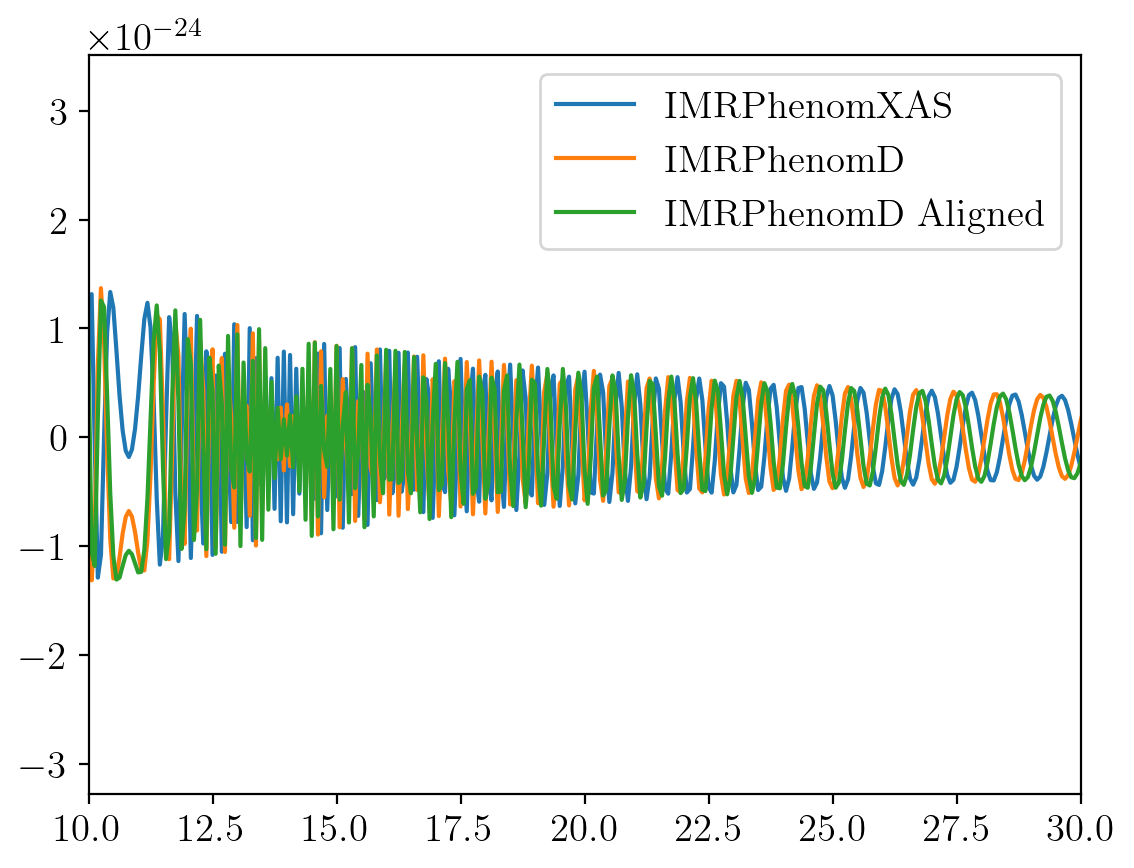

2023-11-22 12:37:45,810 - Network - INFO : Polarizations calculated.
2023-11-22 12:37:45,810 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:37:45,813 - Network - INFO : Polarizations calculated.


faithfulness before aligning: 0.9059427134839958
faithfulness after aligning: 0.9997090882642703


2023-11-22 12:37:46,397 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:37:46,471 - Network - INFO : PSDs loaded.
2023-11-22 12:37:46,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:37:46,493 - Network - INFO : Detector responses calculated.
2023-11-22 12:37:46,494 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:37:46,495 - Network - INFO :    CE-40_C
2023-11-22 12:37:46,984 - Network - INFO :    CE-20_S
2023-11-22 12:37:47,471 - Network - INFO :    ET_ET1
2023-11-22 12:37:47,956 - Network - INFO :    ET_ET2
2023-11-22 12:37:48,443 - Network - INFO :    ET_ET3
2023-11-22 12:37:48,934 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:37:48,938 - Network - INFO : SNRs calculated.
2023-11-22 12:37:48,939 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:37:48,939 - Network - INFO :    CE-40_C
2023-11-22 12:37:49,019 - Network - INFO :

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:37:50,347 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:37:50,422 - Network - INFO : PSDs loaded.
2023-11-22 12:37:50,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:37:50,461 - Network - INFO : Detector responses calculated.
2023-11-22 12:37:50,463 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:37:50,463 - Network - INFO :    CE-40_C
2023-11-22 12:37:51,115 - Network - INFO :    CE-20_S
2023-11-22 12:37:51,769 - Network - INFO :    ET_ET1
2023-11-22 12:37:52,430 - Network - INFO :    ET_ET2
2023-11-22 12:37:53,083 - Network - INFO :    ET_ET3
2023-11-22 12:37:53,736 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:37:53,740 - Network - INFO : SNRs calculated.
2023-11-22 12:37:53,740 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:37:53,741 - Network - INFO :    CE-40_C
2023-11-22 12:37:53,820 - Network - INFO :

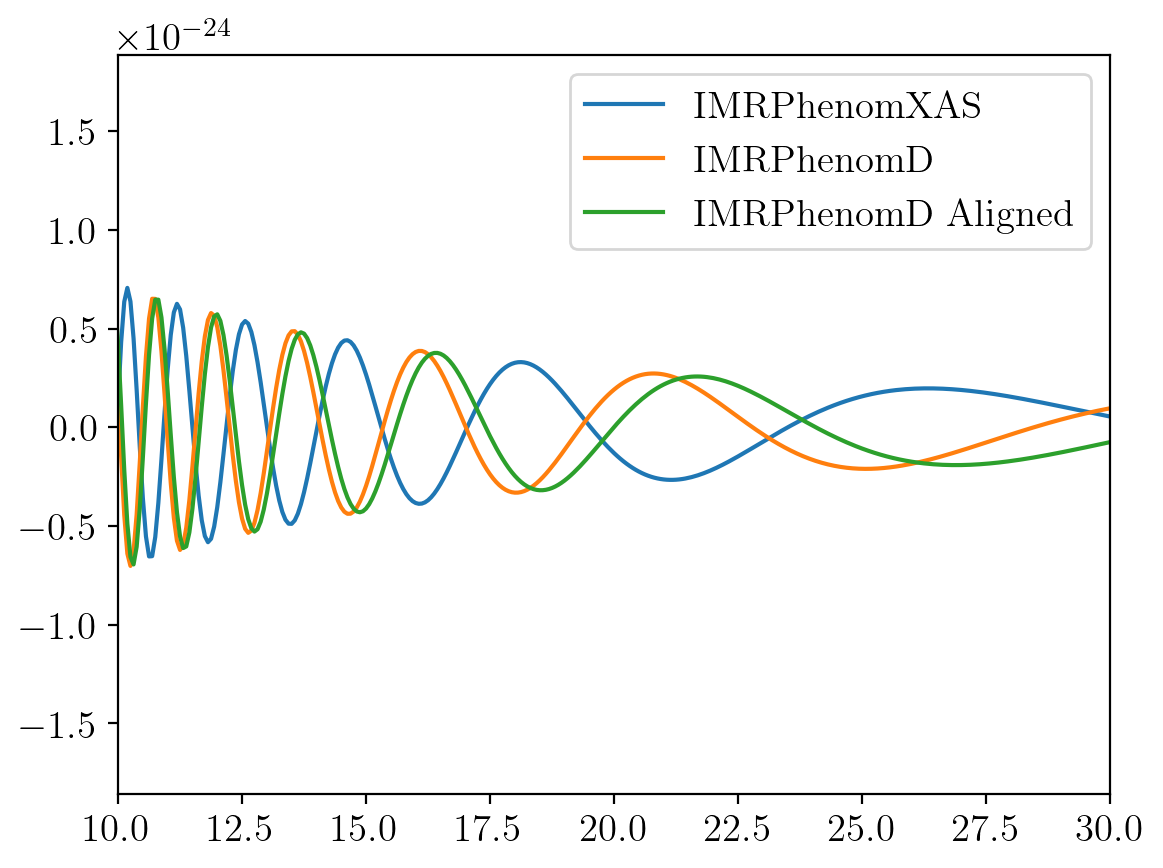

2023-11-22 12:37:58,837 - Network - INFO : Polarizations calculated.
2023-11-22 12:37:58,838 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:37:58,843 - Network - INFO : Polarizations calculated.


faithfulness before aligning: 0.5449831580751495
faithfulness after aligning: 0.9997090882642703


2023-11-22 12:38:02,128 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:38:02,175 - Network - INFO : PSDs loaded.
2023-11-22 12:38:02,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:38:02,198 - Network - INFO : Detector responses calculated.
2023-11-22 12:38:02,199 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:38:02,200 - Network - INFO :    CE-40_C
2023-11-22 12:38:04,302 - Network - INFO :    CE-20_S
2023-11-22 12:38:06,383 - Network - INFO :    ET_ET1
2023-11-22 12:38:08,457 - Network - INFO :    ET_ET2
2023-11-22 12:38:10,521 - Network - INFO :    ET_ET3
2023-11-22 12:38:12,595 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:38:12,600 - Network - INFO : SNRs calculated.
2023-11-22 12:38:12,601 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:38:12,601 - Network - INFO :    CE-40_C
2023-11-22 12:38:12,674 - Network - INFO :

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:38:16,667 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:38:16,713 - Network - INFO : PSDs loaded.
2023-11-22 12:38:16,717 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:38:16,771 - Network - INFO : Detector responses calculated.
2023-11-22 12:38:16,772 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:38:16,772 - Network - INFO :    CE-40_C
2023-11-22 12:38:19,216 - Network - INFO :    CE-20_S
2023-11-22 12:38:21,649 - Network - INFO :    ET_ET1
2023-11-22 12:38:24,125 - Network - INFO :    ET_ET2
2023-11-22 12:38:26,582 - Network - INFO :    ET_ET3
2023-11-22 12:38:29,059 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:38:29,064 - Network - INFO : SNRs calculated.
2023-11-22 12:38:29,065 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:38:29,065 - Network - INFO :    CE-40_C
2023-11-22 12:38:29,136 - Network - INFO :

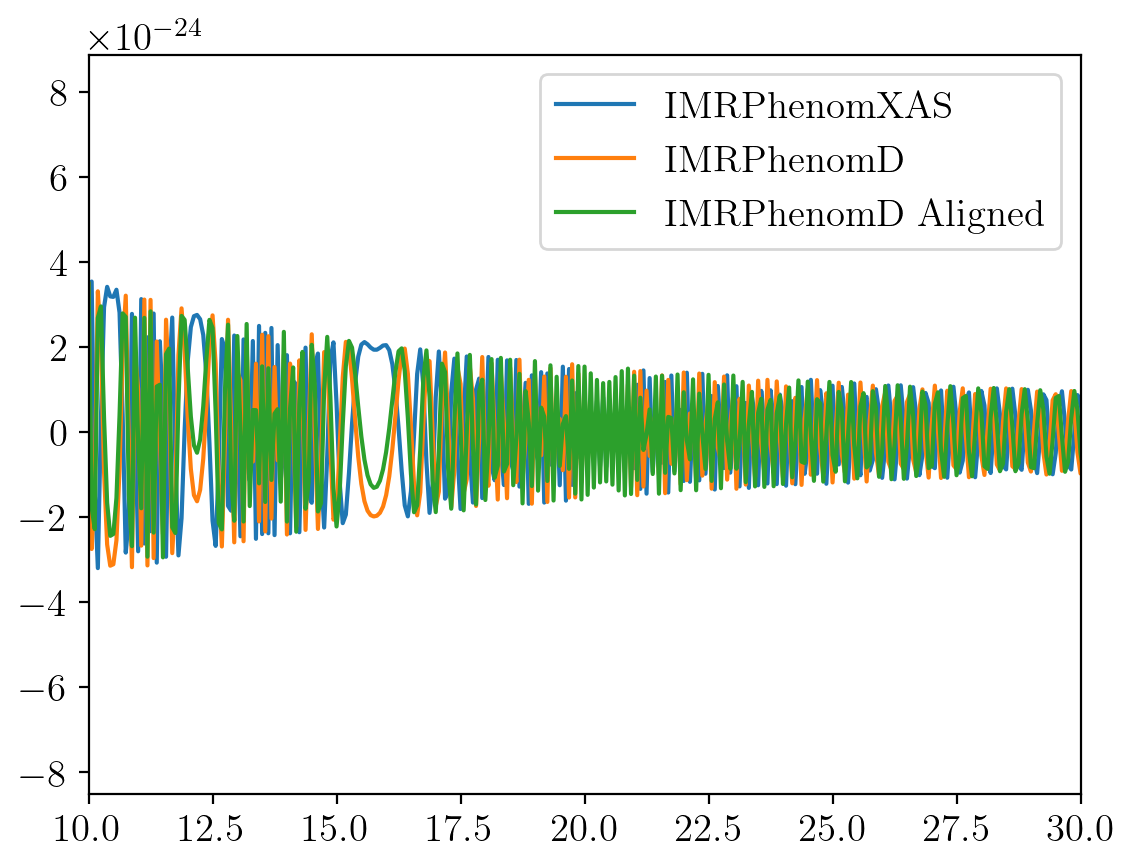

2023-11-22 12:38:46,782 - Network - INFO : Polarizations calculated.
2023-11-22 12:38:46,782 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:38:46,787 - Network - INFO : Polarizations calculated.


faithfulness before aligning: 0.9604893668933326
faithfulness after aligning: 0.9997090882642703


2023-11-22 12:38:48,972 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:38:49,019 - Network - INFO : PSDs loaded.
2023-11-22 12:38:49,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:38:49,040 - Network - INFO : Detector responses calculated.
2023-11-22 12:38:49,041 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:38:49,041 - Network - INFO :    CE-40_C
2023-11-22 12:38:50,665 - Network - INFO :    CE-20_S
2023-11-22 12:38:52,196 - Network - INFO :    ET_ET1
2023-11-22 12:38:53,729 - Network - INFO :    ET_ET2
2023-11-22 12:38:55,259 - Network - INFO :    ET_ET3
2023-11-22 12:38:56,774 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:38:56,778 - Network - INFO : SNRs calculated.
2023-11-22 12:38:56,779 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:38:56,779 - Network - INFO :    CE-40_C
2023-11-22 12:38:56,842 - Network - INFO :

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:39:00,112 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:39:00,160 - Network - INFO : PSDs loaded.
2023-11-22 12:39:00,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:39:00,209 - Network - INFO : Detector responses calculated.
2023-11-22 12:39:00,210 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:39:00,211 - Network - INFO :    CE-40_C
2023-11-22 12:39:02,162 - Network - INFO :    CE-20_S
2023-11-22 12:39:04,035 - Network - INFO :    ET_ET1
2023-11-22 12:39:05,922 - Network - INFO :    ET_ET2
2023-11-22 12:39:07,781 - Network - INFO :    ET_ET3
2023-11-22 12:39:09,624 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:39:09,628 - Network - INFO : SNRs calculated.
2023-11-22 12:39:09,628 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:39:09,629 - Network - INFO :    CE-40_C
2023-11-22 12:39:09,691 - Network - INFO :

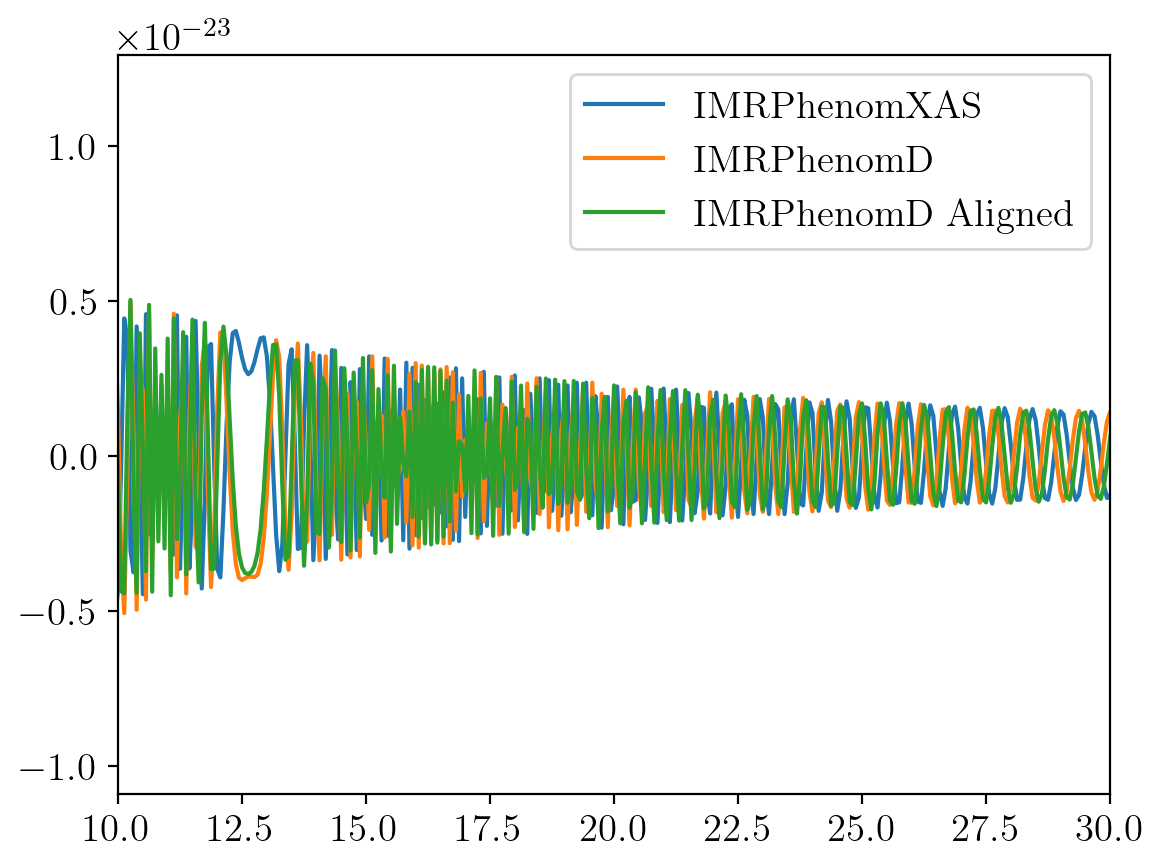

2023-11-22 12:39:23,181 - Network - INFO : Polarizations calculated.
2023-11-22 12:39:23,182 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 12:39:23,185 - Network - INFO : Polarizations calculated.


faithfulness before aligning: 0.9123298688616358
faithfulness after aligning: 0.9997090882642703


2023-11-22 12:39:23,705 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:39:23,780 - Network - INFO : PSDs loaded.
2023-11-22 12:39:23,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:39:23,804 - Network - INFO : Detector responses calculated.
2023-11-22 12:39:23,804 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:39:23,805 - Network - INFO :    CE-40_C
2023-11-22 12:39:24,268 - Network - INFO :    CE-20_S
2023-11-22 12:39:24,730 - Network - INFO :    ET_ET1
2023-11-22 12:39:25,192 - Network - INFO :    ET_ET2
2023-11-22 12:39:25,655 - Network - INFO :    ET_ET3
2023-11-22 12:39:26,124 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:39:26,127 - Network - INFO : SNRs calculated.
2023-11-22 12:39:26,129 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:39:26,129 - Network - INFO :    CE-40_C
2023-11-22 12:39:26,209 - Network - INFO :

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0002909117357297042
             x: [-5.719e-03  1.352e-03]
           nit: 18
          nfev: 36
 final_simplex: (array([[-5.719e-03,  1.352e-03],
                       [-5.711e-03,  1.271e-03],
                       [-5.721e-03,  1.259e-03]]), array([ 2.909e-04,  2.911e-04,  2.916e-04]))


2023-11-22 12:39:27,511 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 12:39:27,586 - Network - INFO : PSDs loaded.
2023-11-22 12:39:27,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 12:39:27,625 - Network - INFO : Detector responses calculated.
2023-11-22 12:39:27,626 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 12:39:27,627 - Network - INFO :    CE-40_C
2023-11-22 12:39:28,248 - Network - INFO :    CE-20_S
2023-11-22 12:39:28,867 - Network - INFO :    ET_ET1
2023-11-22 12:39:29,494 - Network - INFO :    ET_ET2
2023-11-22 12:39:30,115 - Network - INFO :    ET_ET3
2023-11-22 12:39:30,738 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 12:39:30,742 - Network - INFO : SNRs calculated.
2023-11-22 12:39:30,743 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-22 12:39:30,743 - Network - INFO :    CE-40_C
2023-11-22 12:39:30,823 - Network - INFO :

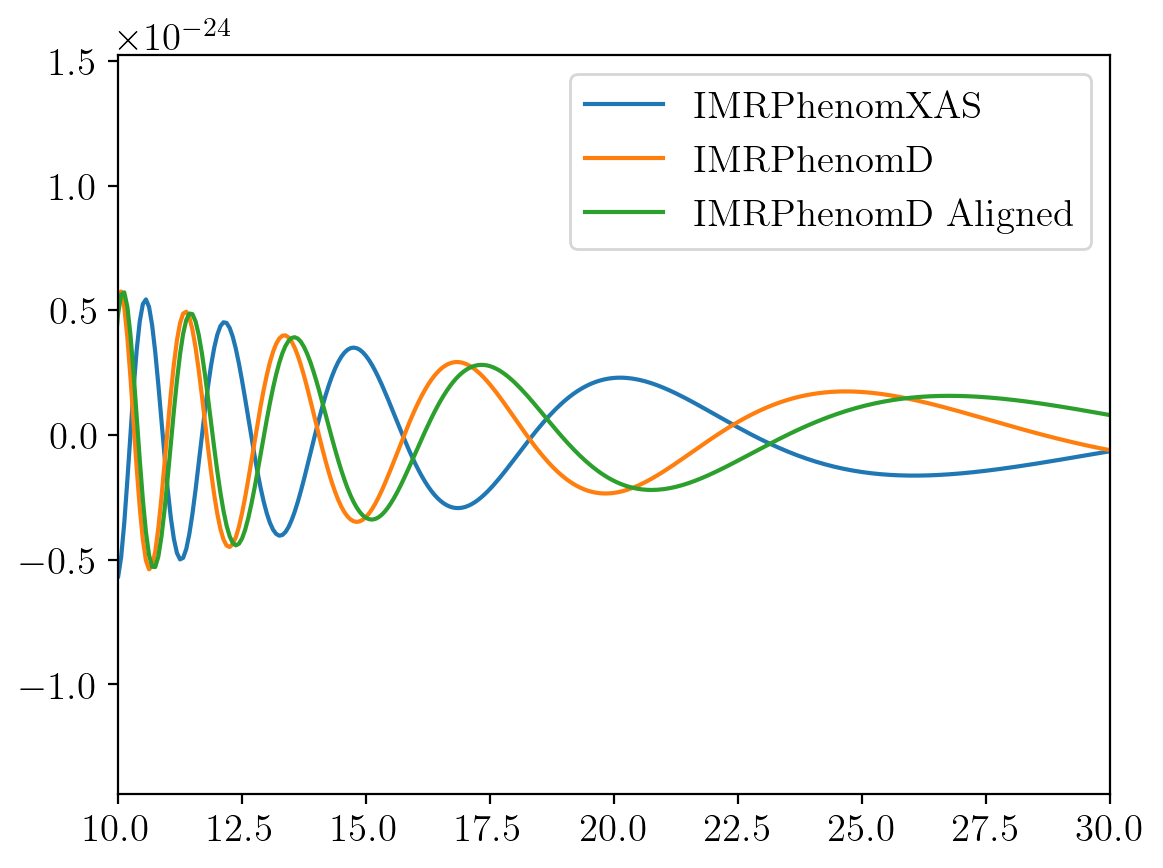

faithfulness before aligning: 0.5035159465525806
faithfulness after aligning: 0.9997090882642703


In [144]:
N = 10
np.random.seed(seed=42)
index_range = np.random.randint(low=0, high=100000, size=N)

cv_biases_no_opt_range = np.zeros((N, 11))
cv_biases_opt_range = np.zeros((N, 11))


errs_opt_range = np.zeros((N, 11))
errs_no_opt_range = np.zeros((N, 11))

for i, index in enumerate(index_range):
    net_no_opt, net_opt = cv_biases_aligned(i)
    cv_biases_no_opt_range[i] = net_no_opt.cutler_vallisneri_bias.tolist()[0]
    cv_biases_opt_range[i] = net_opt.cutler_vallisneri_bias.tolist()[0]

    for j, param in enumerate(net_opt.deriv_variables):
        errs_opt_range[i][j] = net_no_opt.errs[param]
        errs_no_opt_range[i][j] = net_opt.errs[param]
    

In [146]:
print(np.average(np.abs(cv_biases_opt_range), axis=0)/np.average(np.abs(cv_biases_no_opt_range), axis=0))
print(net_2.deriv_variables)



[1.09970249 1.18603957 1.30822404 1.3253196  0.67974072 1.34550919
 0.93037817 1.08645019 1.11675012 1.60574433 2.27141136]
['Mc', 'eta', 'chi1z', 'chi2z', 'DL', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi']


In [148]:
print(np.average(np.abs(cv_biases_opt_range/errs_opt_range), axis=0))
print(np.average(np.abs(cv_biases_no_opt_range/errs_no_opt_range), axis=0))
print(net_2.deriv_variables)

[2.7725255  3.67555438 3.38942479 3.32366264 6.67446202 3.48277636
 1.8918253  0.44406188 0.14189403 0.22200365 0.33279208]
[2.52115961 3.09901498 2.59085958 2.50781972 9.81912934 2.58844487
 2.03339391 0.40872732 0.12705979 0.13825591 0.14651335]
['Mc', 'eta', 'chi1z', 'chi2z', 'DL', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi']


The values of tc and phic seem very consistent across all binaries with these two waveform models. I wonder if changing the waveform model changes this.

# Optimize over time, phase, and polarization (Roberto's code)

In [ ]:


# def compute_hFDNR_LAL(hlm_FD,theta,phi,kappa):
#     #This first function computes hp and hc entering Eq. (4)
#     hpFD,hcFD = ls.SimInspiralPolarizationsFromSphHarmFrequencySeries(hlm_FD,theta,np.pi/2.-phi)
#     #We return Eq. (4) without the amplitude for the reason mentioned above
#     return np.cos(kappa)*hpFD.data.data+np.sin(kappa)*hcFD.data.data

# def compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant):
    
#     # These have to be set to 0 by definition
#     inc, phiC  = 0., 0.
    
#     # Generate the modes hlm 
#     hlms = ls.SimInspiralChooseFDModes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, f_low, phiC, distance, inc, None, approximant)
    
#     return hlms 

def match_HM_k_opt_LAL(hp1_ROM, hc1_ROM, hp2_ROM, hc2_ROM,iota,phi,kappa,deltaF, Sn, zpfact=2):
    # Check if the two waveform have the same size
    # assert(len(hlm1_FD.fdata.data) == len(hlm1_FD.fdata.data))

    # wf1_FD = compute_hFDNR_LAL(hlm1_FD,iota, phi, kappa)[:-1]
    wf1_FD = np.cos(kappa)*hp1_ROM+np.sin(kappa)*hc1_ROM

    # Compute the norm of the true waveform
    norm1 = np.sqrt(np.sum(np.abs(wf1_FD)**2/Sn))
    

    # Define the match as a function of phi. This match is analytically optimized over kappa
    def match_HM_phi_kopt(x):
        try:
            # Unpacking for multiD mimimization
            len(x)
            x = x[0]
        except:
            pass
        
        # hp2_ROM, hc2_ROM = ls.SimInspiralPolarizationsFromSphHarmFrequencySeries(hlm2_FD,iota,x)
        # hp2_ROM, hc2_ROM = hp2_ROM.data.data[:-1], hc2_ROM.data.data[:-1]
        n = len(hp2_ROM)
        A_p = np.sqrt(np.sum(np.abs(hp2_ROM)**2/Sn))
        A_c = np.sqrt(np.sum(np.abs(hc2_ROM)**2/Sn))

        if A_c/A_p>1e-8: #if we really have two non zero polarizations
            Ipc = np.real(np.dot(np.conjugate(hp2_ROM),hc2_ROM/Sn))
            integrand = np.conjugate(hp2_ROM)*wf1_FD/Sn
            rho_p = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))
            integrand = np.conjugate(hc2_ROM)*wf1_FD/Sn
            rho_c = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))

            alpha = np.sqrt(rho_p**2 + rho_c**2) # this is a time series
            kappa0 = np.angle(rho_p+1.j*rho_c) # this is a time series

            gamma = np.sqrt(((A_p**2-A_c**2)/2.)**2+Ipc**2)
            sigma0 = np.angle((A_p**2-A_c**2)/2.+1.j*Ipc)
            beta = (A_p**2+A_c**2)/2.

            #print A_p,A_c,Ipc,gamma,sigma0,beta
            num = np.max(alpha*np.sqrt(beta-gamma*np.cos(2*kappa0-sigma0)))
            den = norm1*np.sqrt(beta**2-gamma**2)
            overlap = num/den
        else:
            integrand = np.conjugate(hp2_ROM)*wf1_FD/Sn
            ifftterm = n*zpfact*np.fft.ifft(integrand,n=n*zpfact)
            maxifftterm = np.max([np.max(np.real(ifftterm)),np.max(-np.real(ifftterm))])
            overlap = maxifftterm/(norm1*A_p)

        return -overlap

    # Numerically optimize over phi
    # First find the minimum in a discrete manner
    phi_ini_guess = np.linspace(0.,2*np.pi,num=40)
    discrete_phi_min_index = np.argmin(np.array([match_HM_phi_kopt(phi_val) for phi_val in phi_ini_guess]))
    discrete_phi_min = phi_ini_guess[discrete_phi_min_index]
    res = minimize(match_HM_phi_kopt,x0=[discrete_phi_min,], method='Nelder-Mead')
    return -match_HM_phi_kopt(res.x)


def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

# def get_LIGO_psd(f_low,deltaF,len_wf):

#     # Define the frequency series where to put the PSD
#     epoch = lal.LIGOTimeGPS(0, 0)

#     Sn = lal.CreateREAL8FrequencySeries("psd",epoch,0.,deltaF,lal.StrainUnit,len_wf)

#     # Compute the PSD from the given f_low
#     ls.SimNoisePSDaLIGOZeroDetHighPowerGWINC(Sn,f_low)
    
#     Sn.data.data[0 : int(f_low/deltaF)] = Sn.data.data[int(f_low/deltaF)]
#     Sn.data.data[-1] = Sn.data.data[-2]
    
#     return Sn


In [92]:
M = 200.#*lal.MSUN_SI
q = 2
m1, m2 = q*M/(1.+q), M/(1.+q)
# Spins are set to zero as this code works for aligned spins
chi1_x, chi1_y, chi2_x, chi2_y = 0.,0.,0.,0.
chi1_z, chi2_z =  0.2, 0.2
# Set the other parameters
delta_f, f_low, f_max = 1./16., 3., 1024.
iota, phi_c, kappa = np.pi/3. ,np.pi/3.,np.pi/3.
distance = 1e6*lal.PC_SI

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(2.0, 30.0)

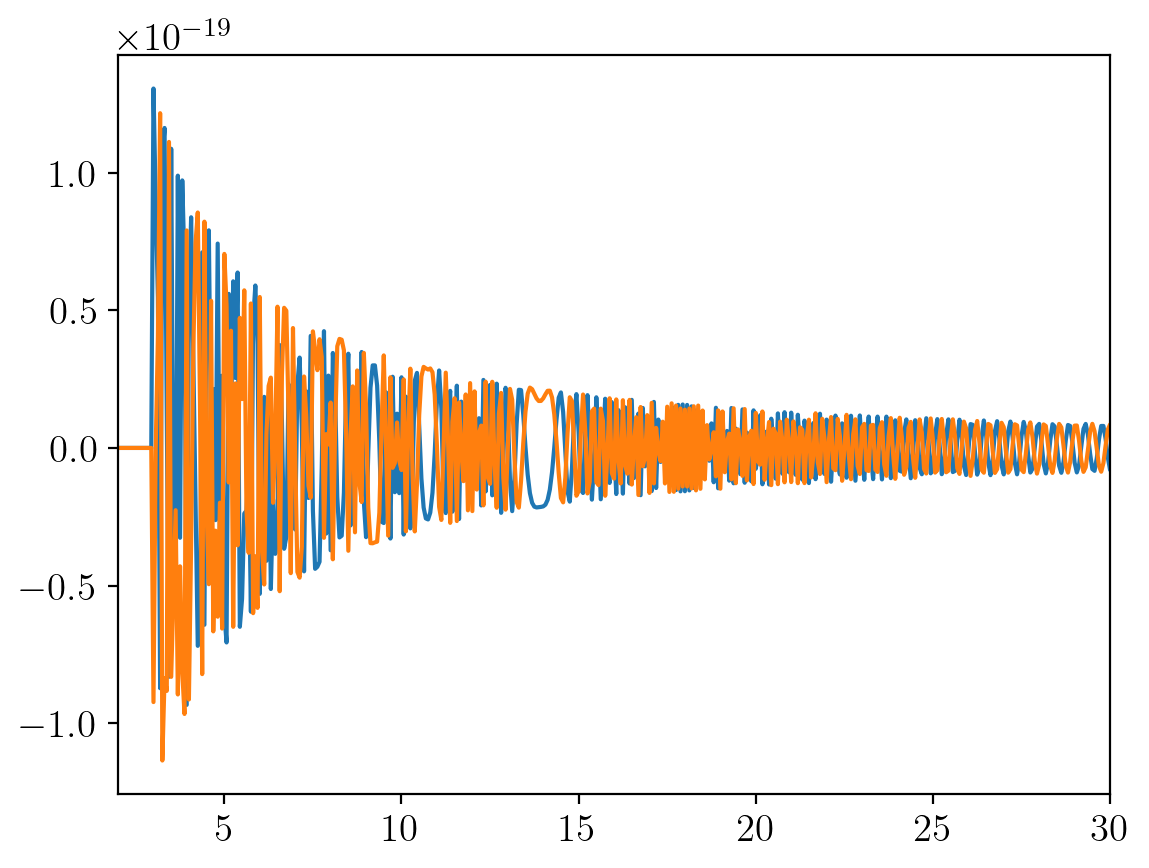

In [93]:
from pycbc.waveform import get_fd_waveform
apx1 = 'IMRPhenomD'
apx2 = 'IMRPhenomXAS'
hp1, hc1 = get_fd_waveform(approximant=apx1,
                                 mass1=10,
                                 mass2=10,
                                 spin1z=0.1,
                                 delta_f=delta_f,
                                 f_lower=f_low)

hp2, hc2 = get_fd_waveform(approximant=apx2,
                                 mass1=10,
                                 mass2=10,
                                 spin1z=0.1,
                                 delta_f=delta_f,
                                 f_lower=f_low)

plt.plot(hp1.sample_frequencies.data, hp1.data)
plt.plot(hp2.sample_frequencies.data, hp2.data)

plt.xlim(f_low-1, 30)

In [98]:
from pycbc import psd

length = len(hp1.sample_frequencies)

Sn_psd = psd.analytical.EinsteinTelescopeP1600143(length, delta_f, f_low)

In [ ]:
f_range = np.arange(f_low, f_max, delta_f)
mask = np.in1d(hp1.sample_frequencies.data, f_range)
mask2 = np.in1d(hp2.sample_frequencies.data, f_range)


hp1_ROM = hp1.data[mask]
hc1_ROM = hc1.data[mask]
hp2_ROM = hp2.data[mask2]
hc2_ROM = hc2.data[mask2]

Sn = Sn_psd.data[mask]


In [106]:
wf1_FD = np.cos(kappa)*hp1_ROM+np.sin(kappa)*hc1_ROM
norm1 = np.sqrt(np.sum(np.abs(wf1_FD)**2/Sn))

zpfact=8
# Define the match as a function of phi. This match is analytically optimized over kappa
def match_HM_phi_kopt(x):
    try:
        # Unpacking for multiD mimimization
        len(x)
        x = x[0]
    except:
        pass
    
    n = len(hp2_ROM)
    A_p = np.sqrt(np.sum(np.abs(hp2_ROM)**2/Sn))
    A_c = np.sqrt(np.sum(np.abs(hc2_ROM)**2/Sn))

    if A_c/A_p>1e-8: #if we really have two non zero polarizations
        Ipc = np.real(np.dot(np.conjugate(hp2_ROM),hc2_ROM/Sn))
        integrand = np.conjugate(hp2_ROM)*wf1_FD/Sn
        rho_p = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))
        integrand = np.conjugate(hc2_ROM)*wf1_FD/Sn
        rho_c = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))

        alpha = np.sqrt(rho_p**2 + rho_c**2) # this is a time series
        kappa0 = np.angle(rho_p+1.j*rho_c) # this is a time series

        gamma = np.sqrt(((A_p**2-A_c**2)/2.)**2+Ipc**2)
        sigma0 = np.angle((A_p**2-A_c**2)/2.+1.j*Ipc)
        beta = (A_p**2+A_c**2)/2.

        #print A_p,A_c,Ipc,gamma,sigma0,beta
        num = np.max(alpha*np.sqrt(beta-gamma*np.cos(2*kappa0-sigma0)))
        den = norm1*np.sqrt(beta**2-gamma**2)
        overlap = num/den
    else:
        integrand = np.conjugate(hp2_ROM)*wf1_FD/Sn
        ifftterm = n*zpfact*np.fft.ifft(integrand,n=n*zpfact)
        maxifftterm = np.max([np.max(np.real(ifftterm)),np.max(-np.real(ifftterm))])
        overlap = maxifftterm/(norm1*A_p)

    return -overlap

# Numerically optimize over phi
# First find the minimum in a discrete manner
phi_ini_guess = np.linspace(0.,2*np.pi,num=100)
discrete_phi_min_index = np.argmin(np.array([match_HM_phi_kopt(phi_val) for phi_val in phi_ini_guess]))
discrete_phi_min = phi_ini_guess[discrete_phi_min_index]
res = minimize(match_HM_phi_kopt,x0=[discrete_phi_min,], method='Nelder-Mead')
print(-match_HM_phi_kopt(res.x))

print(discrete_phi_min)
# print(discrete_phi_min)

0.9996878761066231
0.0


# PYCBC Waveform and Plotting Functions

In [68]:
## GENERATE PYCBC WAVEFORMS
def get_pycbc_waveforms_fd(net_true, net_ap):
    delta_f = net_ap.f[1] - net_ap.f[0]

    # make sure that the detector and waveform frequency ranges overlap
    freq_mask = np.in1d(net_ap.f, net_ap.detectors[0].f, assume_unique=True)

    hp1_fs = FrequencySeries(net_true.hfp[freq_mask], delta_f=delta_f)
    hc1_fs = FrequencySeries(net_true.hfc[freq_mask], delta_f=delta_f)

    hp2_fs = FrequencySeries(net_ap.hfp[freq_mask], delta_f=delta_f)
    hc2_fs = FrequencySeries(net_ap.hfc[freq_mask], delta_f=delta_f)

    # Combine frequency-domain waveforms
    h1_fs = hp1_fs+ 1.j*hc1_fs
    h2_fs = hp2_fs+ 1.j*hc2_fs

    return [h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs]


# FFT it to the time-domain
def get_pycbc_waveforms_td(net_true, net_ap):
    delta_t=1.0/4096
    delta_f = net_ap.f[1] - net_ap.f[0]

    # make sure that the detector and waveform frequency ranges overlap
    freq_mask = np.in1d(net_ap.f, net_ap.detectors[0].f, assume_unique=True)

    hp1_fs = FrequencySeries(net_true.hfp[freq_mask], delta_f=delta_f)
    hc1_fs = FrequencySeries(net_true.hfc[freq_mask], delta_f=delta_f)

    hp2_fs = FrequencySeries(net_ap.hfp[freq_mask], delta_f=delta_f)
    hc2_fs = FrequencySeries(net_ap.hfc[freq_mask], delta_f=delta_f)

    tlen = int(1.0 / delta_t / hp1_fs.delta_f)
    hp1_fs.resize(tlen/2 + 1)
    hp1_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hp1_fs, hp1_ts)

    tlen = int(1.0 / delta_t / hc1_fs.delta_f)
    hc1_fs.resize(tlen/2 + 1)
    hc1_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hc1_fs, hc1_ts)


    tlen = int(1.0 / delta_t / hp2_fs.delta_f)
    hp2_fs.resize(tlen/2 + 1)
    hp2_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hp2_fs, hp2_ts)

    tlen = int(1.0 / delta_t / hc2_fs.delta_f)
    hc2_fs.resize(tlen/2 + 1)
    hc2_ts = types.TimeSeries(types.zeros(tlen), delta_t=delta_t)
    fft.ifft(hc2_fs, hp2_ts)

    h1_ts = hp1_ts+ 1.j*hc1_ts
    h2_ts = hp2_ts+ 1.j*hc2_ts

    return [h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts]

In [69]:
def plot_f_series(h1_fs, hp1_fs, hc1_fs, h2_fs, hp2_fs, hc2_fs):    
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8, 8))

    axes[0].plot(hp1_fs.sample_frequencies, h1_fs, label=approx1)
    axes[0].plot(hp2_fs.sample_frequencies, h2_fs, label=approx2)
    axes[0].set_ylabel("$h (f)$")
    axes[0].legend()


    axes[1].plot(hp1_fs.sample_frequencies, np.abs(h1_fs), label=approx1)
    axes[1].plot(hp2_fs.sample_frequencies, np.abs(h2_fs), label=approx2)
    axes[1].set_ylabel("Amplitude")
    axes[1].legend()

    axes[2].plot(hp1_fs.sample_frequencies, np.unwrap(np.angle(h1_fs)), label=approx1)
    axes[2].plot(hp2_fs.sample_frequencies, np.unwrap(np.angle(h2_fs)), label=approx2)
    axes[2].set_ylabel("Phase")
    axes[2].legend()
    axes[2].set_ylim(0, 150)

    plt.xlabel("$f$")
    plt.xlim(0, 20)
    plt.show()

In [70]:
def plot_t_series(h1_ts, hp1_ts, hc1_ts, h2_ts, hp2_ts, hc2_ts):

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 3))

    axes = [axes]
    axes[0].plot(h1_ts.sample_times, h1_ts, label=approx1)
    axes[0].plot(h2_ts.sample_times, h2_ts, label=approx2)

    axes[0].set_ylabel("$h(t)$")
    axes[0].legend()
    axes[0].set_xlim(5, 17)

    # amp1 = waveform.utils.amplitude_from_polarizations(hp1_ts, hc1_ts)
    # amp2 = waveform.utils.amplitude_from_polarizations(hp2_ts, hc2_ts)
    # axes[1].plot(hp1_ts.sample_times, amp1, label=approx1)
    # axes[1].plot(hp2_ts.sample_times, amp2, label=approx2)
    # axes[1].set_ylabel("$|h(t)|$")

    # phase1 = waveform.utils.phase_from_polarizations(hp1_ts, hc1_ts)
    # phase2 = waveform.utils.phase_from_polarizations(hp2_ts, hc2_ts)
    # axes[2].plot(hp1_ts.sample_times, phase1, label=approx1)
    # axes[2].plot(hp2_ts.sample_times, phase2, label=approx2)
    # axes[2].set_ylabel("Phase")
    # axes[2].set_xlabel("Time (s)")
    # axes[2].legend()
    # axes[2].set_xlim(5, 17)

    plt.xlabel('$t$')

    # plt.show()

# No Phic or tc opt

In [71]:
i = 54837

inj_params = {
    'Mc':    Mcs[i],
    'eta':   etas[i],
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': chi1z[i],
    'chi2z': chi2z[i],
    'DL':    DLs[i],
    'tc':    0,
    'phic':  0,
    'iota':  iotas[i],
    'ra':    ras[i],
    'dec':   decs[i],
    'psi':   psis[i],
    'gmst0': 0,
    'hybr': 0.0
} 

net_key = '3G'
# net_key = 'aLIGO'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)

2023-11-22 13:57:22,298 - Network - INFO : Polarizations calculated.
2023-11-22 13:57:22,299 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 13:57:22,307 - Network - INFO : Polarizations calculated.
2023-11-22 13:57:23,673 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 13:57:23,733 - Network - INFO : PSDs loaded.
2023-11-22 13:57:23,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 13:57:23,766 - Network - INFO : Detector responses calculated.
2023-11-22 13:57:23,767 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 13:57:23,767 - Network - INFO :    CE-40_C
2023-11-22 13:57:24,631 - Network - INFO :    CE-20_S
2023-11-22 13:57:25,468 - Network - INFO :    ET_ET1
2023-11-22 13:57:26,308 - Network - INFO :    ET_ET2
2023-11-22 13:57:27,157 - Network - INFO :    ET_ET3
2023-11-22 13:57:28,015 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 1

In [72]:
net_ap.cutler_vallisneri_bias.tolist()[0]

[0.6962290091003212,
 0.29442187702835554,
 -38.027401983812524,
 47.49267381292702,
 803.6568649755791,
 0.2546528961344876,
 12.617324783942422,
 3.5648347962023763,
 -0.012529401878046187,
 0.005769350115615524,
 2.289716517137549]

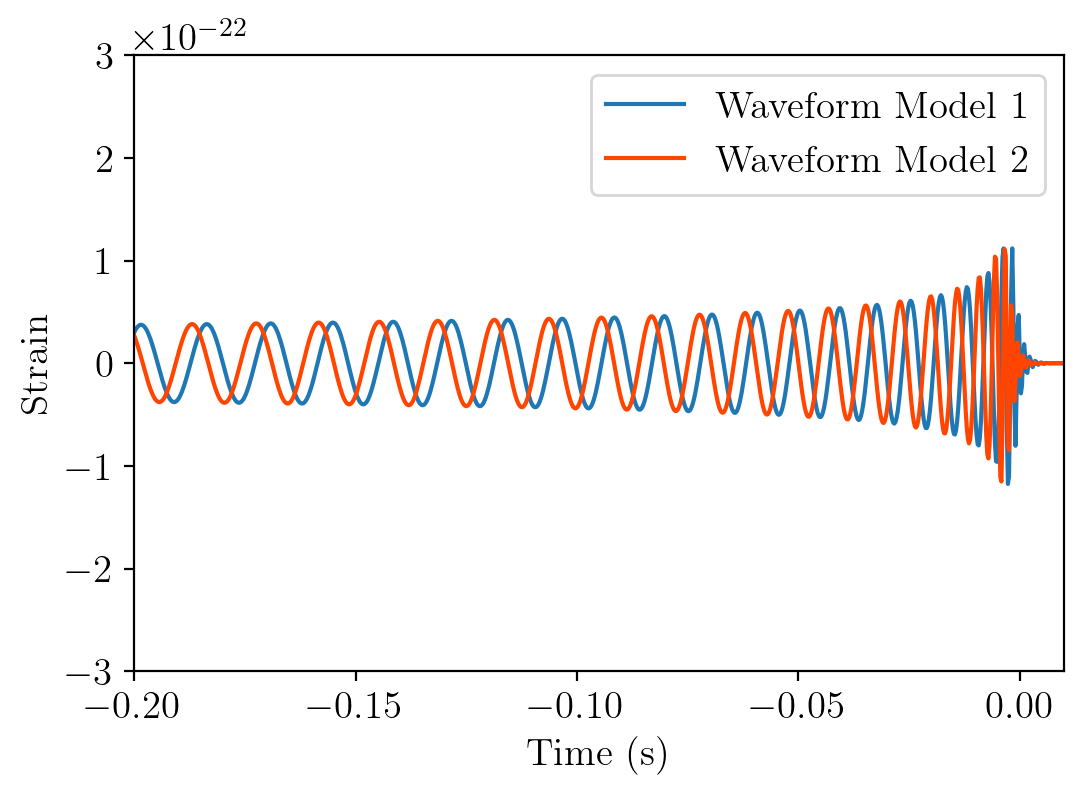

In [73]:
# GW151226

import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector


labels=['Waveform Model 1', 'Waveform Model 2']
colors=['tab:blue', 'orangered']

fig, ax = pp.subplots(figsize=(6, 4))
for i, apx in enumerate(['IMRPhenomXAS', 'IMRPhenomD']):
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=14.2,
                                 mass2=7.5,
                                 delta_t=1.0/4096,
                                 distance=440,
                                 f_lower=10)
    det_l1 = Detector('L1')
    declination = 0.65
    right_ascension = 4.67
    polarization = 2.34
    signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
    pp.plot(signal_l1.sample_times, signal_l1, lw=1.5, label=labels[i], color=colors[i])

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.xlim(-0.2, 0.01)
pp.ylim(-0.3e-21, 0.3e-21)
pp.show()

In [74]:
fd_waveforms_no_opt = get_pycbc_waveforms_fd(net_true, net_ap)
td_waveforms_no_opt = get_pycbc_waveforms_td(net_true, net_ap)

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


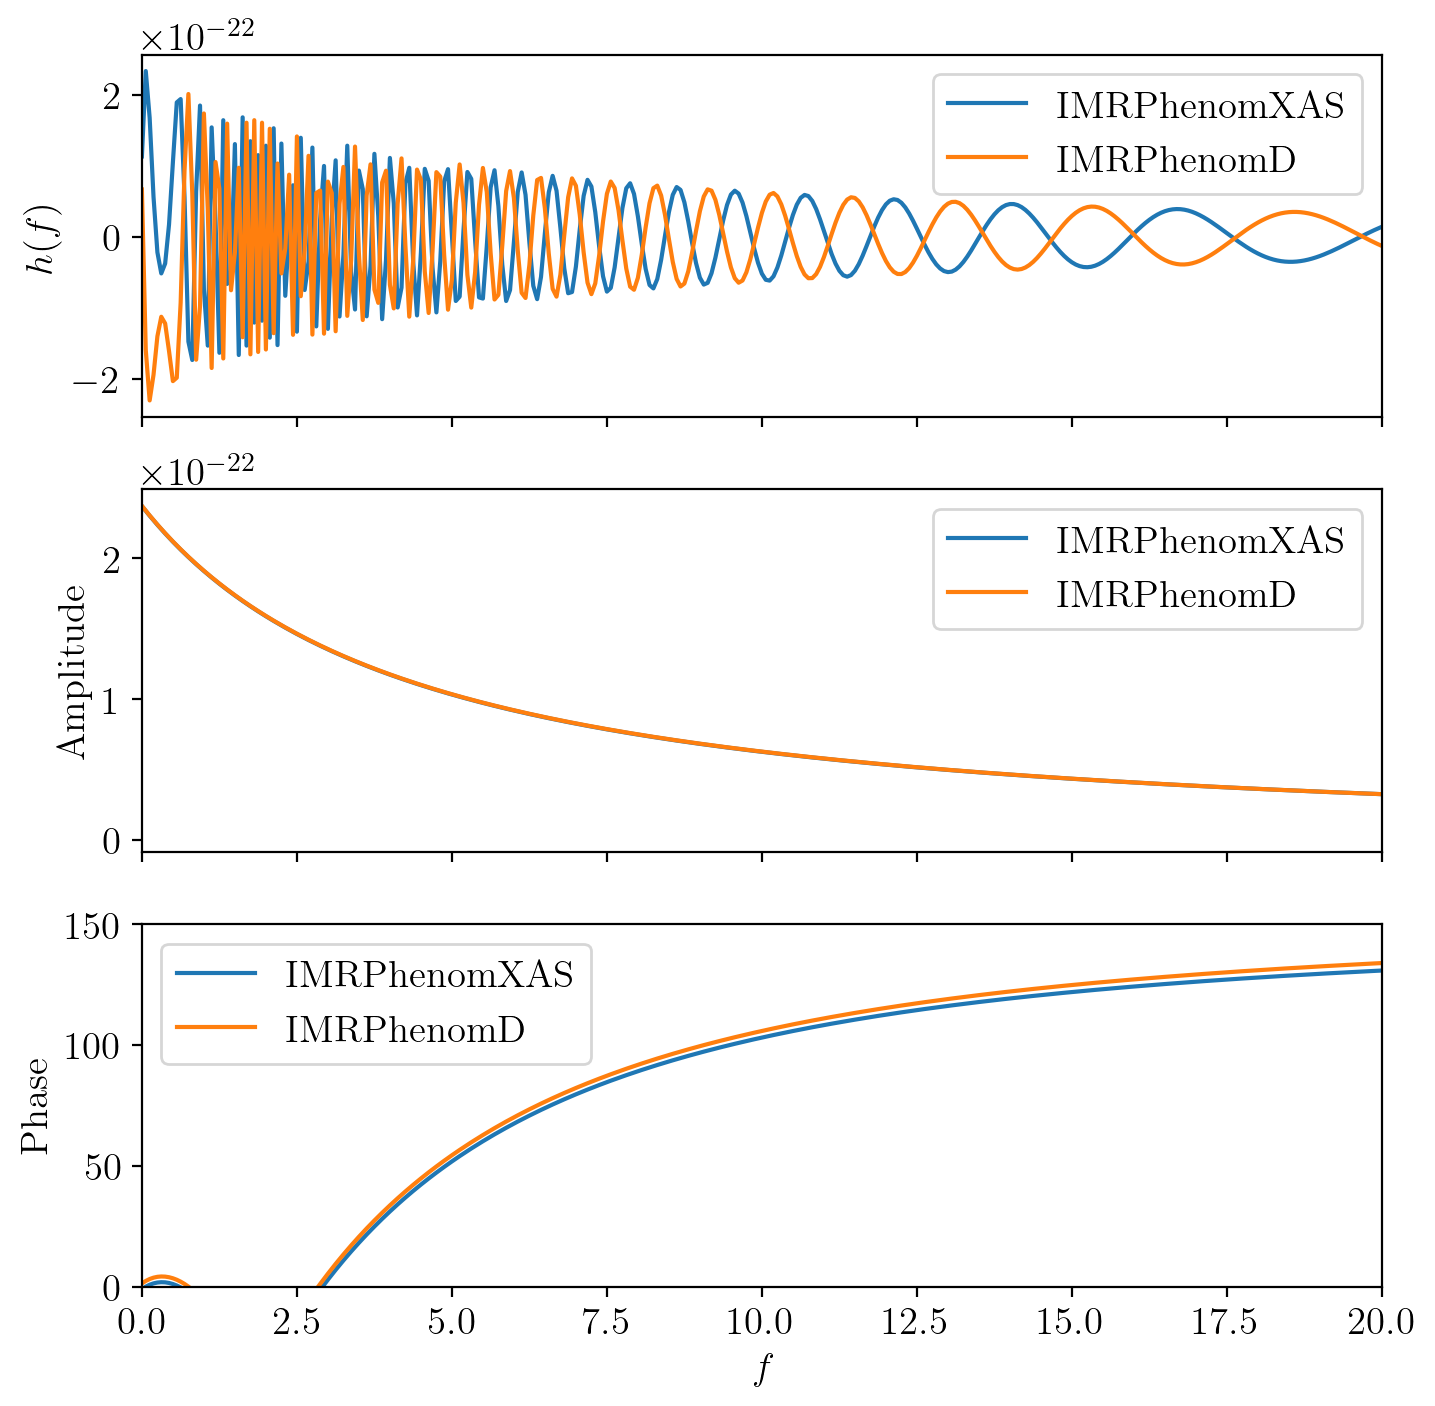

In [75]:
plot_f_series(*fd_waveforms_no_opt)

(15.0, 16.1)

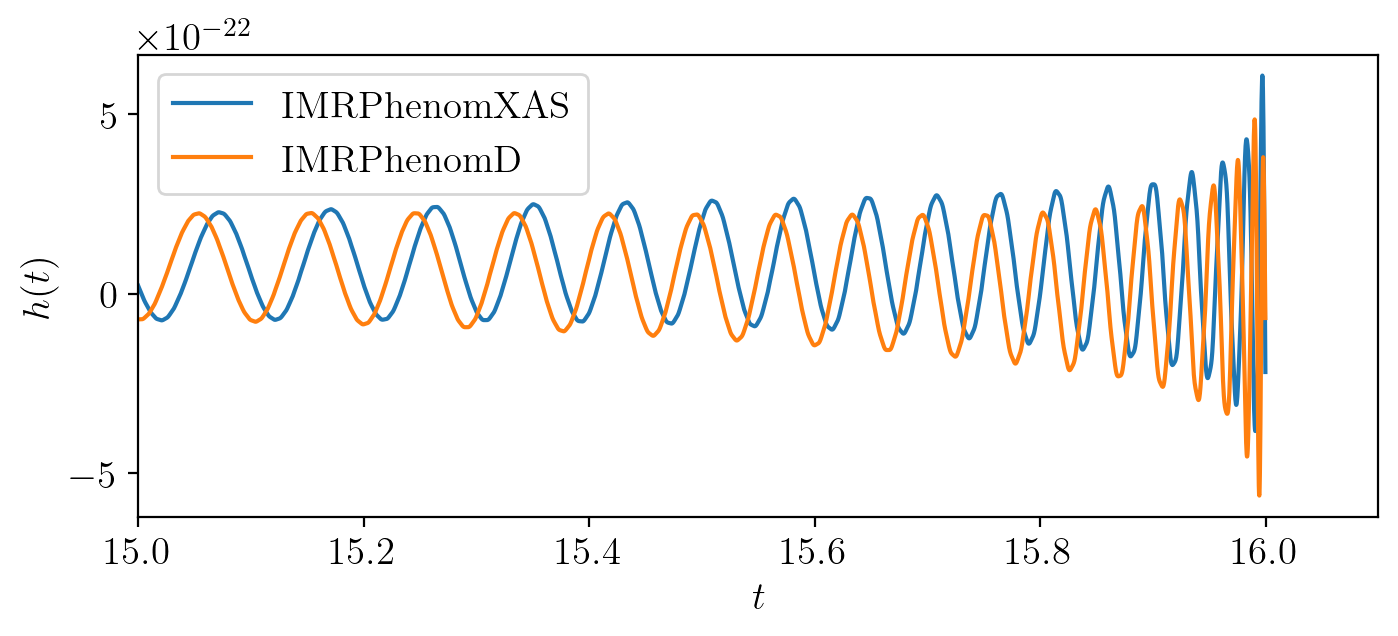

In [42]:
plot_t_series(*td_waveforms_no_opt)
plt.xlim(15, 16.1)

## Biases

Biases: [0.6962290091003212, 0.29442187702835554, -38.027401983812524, 47.49267381292702, 803.6568649755791, 0.2546528961344876, 12.617324783942422, 3.5648347962023763, -0.012529401878046187, 0.005769350115615524, 2.289716517137549]
Errors: [2.72423658e-03 1.62393542e-03 1.57143861e-01 1.93263516e-01
 1.02780182e+02 1.04163971e-03 7.27044523e-01 1.35313228e-01
 4.76610701e-04 4.04111110e-04 3.63363743e-01]


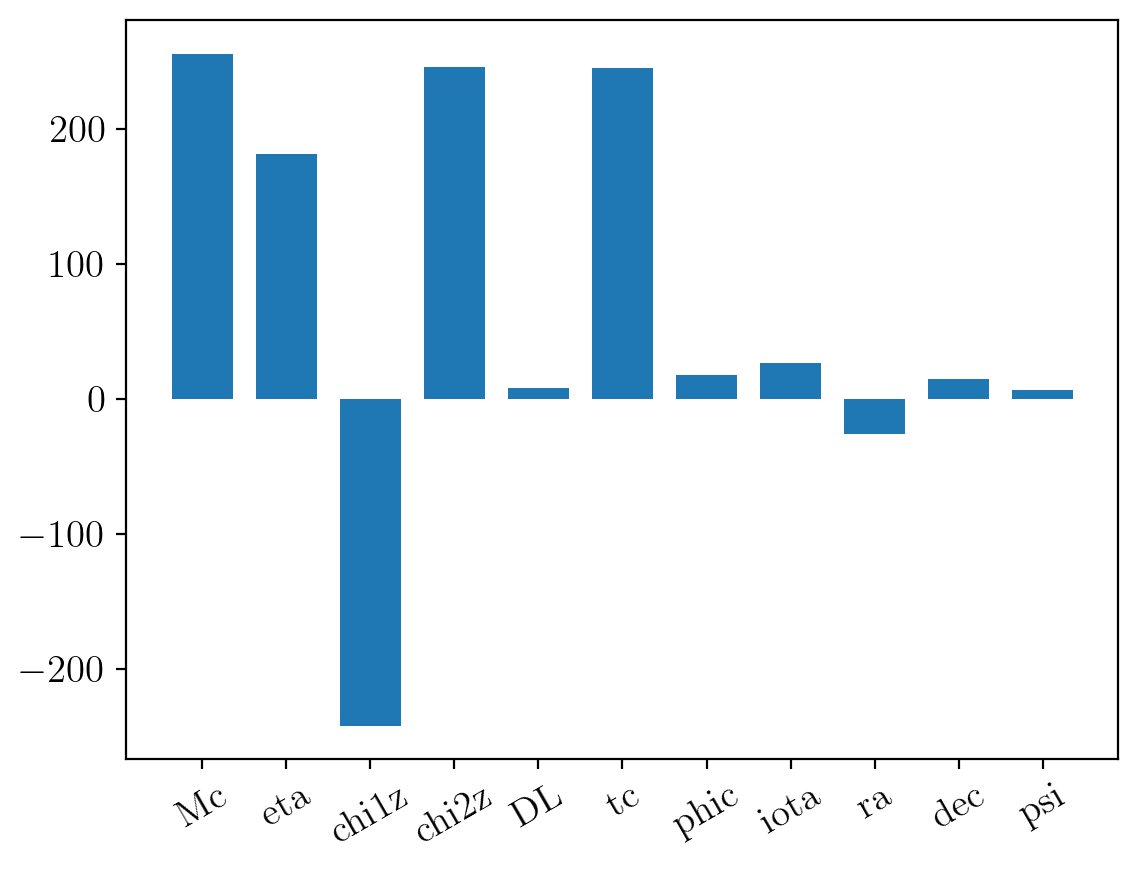

In [76]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))

for i, param in enumerate(net_ap.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]

print("Biases:", bias_no_opt)
print("Errors:", err_no_opt)

x = np.linspace(0, len(bias_no_opt), len(bias_no_opt))
plt.bar(x, bias_no_opt/err_no_opt)
plt.xticks(x, net_ap.deriv_variables, rotation=30)
plt.show()

# $\phi_c$ AND $t_c$ optimized

In [77]:
h1_ts = td_waveforms_no_opt[0]
h1_fs = fd_waveforms_no_opt[0]
h2_fs = fd_waveforms_no_opt[3]

delta_t = h1_ts.delta_t
print(1/delta_t)

match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
tc = -index * delta_t
phic = -phi

print(match, tc, phic)

4096.0
0.9999246518995833 -1.4828648898100516 2.366996263253947


In [78]:
h1_fs.data

array([1.13117202e-22-2.08157061e-22j, 2.33269560e-22-9.27627392e-24j,
       1.67619428e-22+1.57625277e-22j, ...,
       1.02368730e-24+3.20395900e-24j, 1.03223788e-24+3.19577929e-24j,
       1.04074843e-24+3.18756879e-24j])

In [79]:
# set the injection parameters
inj_params_opt = inj_params.copy()
inj_params_opt['tc'] = tc
inj_params_opt['phic'] = phic


net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params,inj_params2=inj_params_opt, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

2023-11-22 13:57:43,000 - Network - INFO : Polarizations calculated.
2023-11-22 13:57:43,001 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-22 13:57:43,012 - Network - INFO : Polarizations calculated.
2023-11-22 13:57:44,335 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-22 13:57:44,394 - Network - INFO : PSDs loaded.
2023-11-22 13:57:44,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-22 13:57:44,427 - Network - INFO : Detector responses calculated.
2023-11-22 13:57:44,428 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-22 13:57:44,428 - Network - INFO :    CE-40_C
2023-11-22 13:57:45,321 - Network - INFO :    CE-20_S
2023-11-22 13:57:46,207 - Network - INFO :    ET_ET1
2023-11-22 13:57:47,080 - Network - INFO :    ET_ET2
2023-11-22 13:57:47,955 - Network - INFO :    ET_ET3
2023-11-22 13:57:48,863 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-22 1

In [80]:
fd_waveforms_opt = get_pycbc_waveforms_fd(net_true, net_ap_opt)

td_waveforms_opt = get_pycbc_waveforms_td(net_true, net_ap_opt)

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


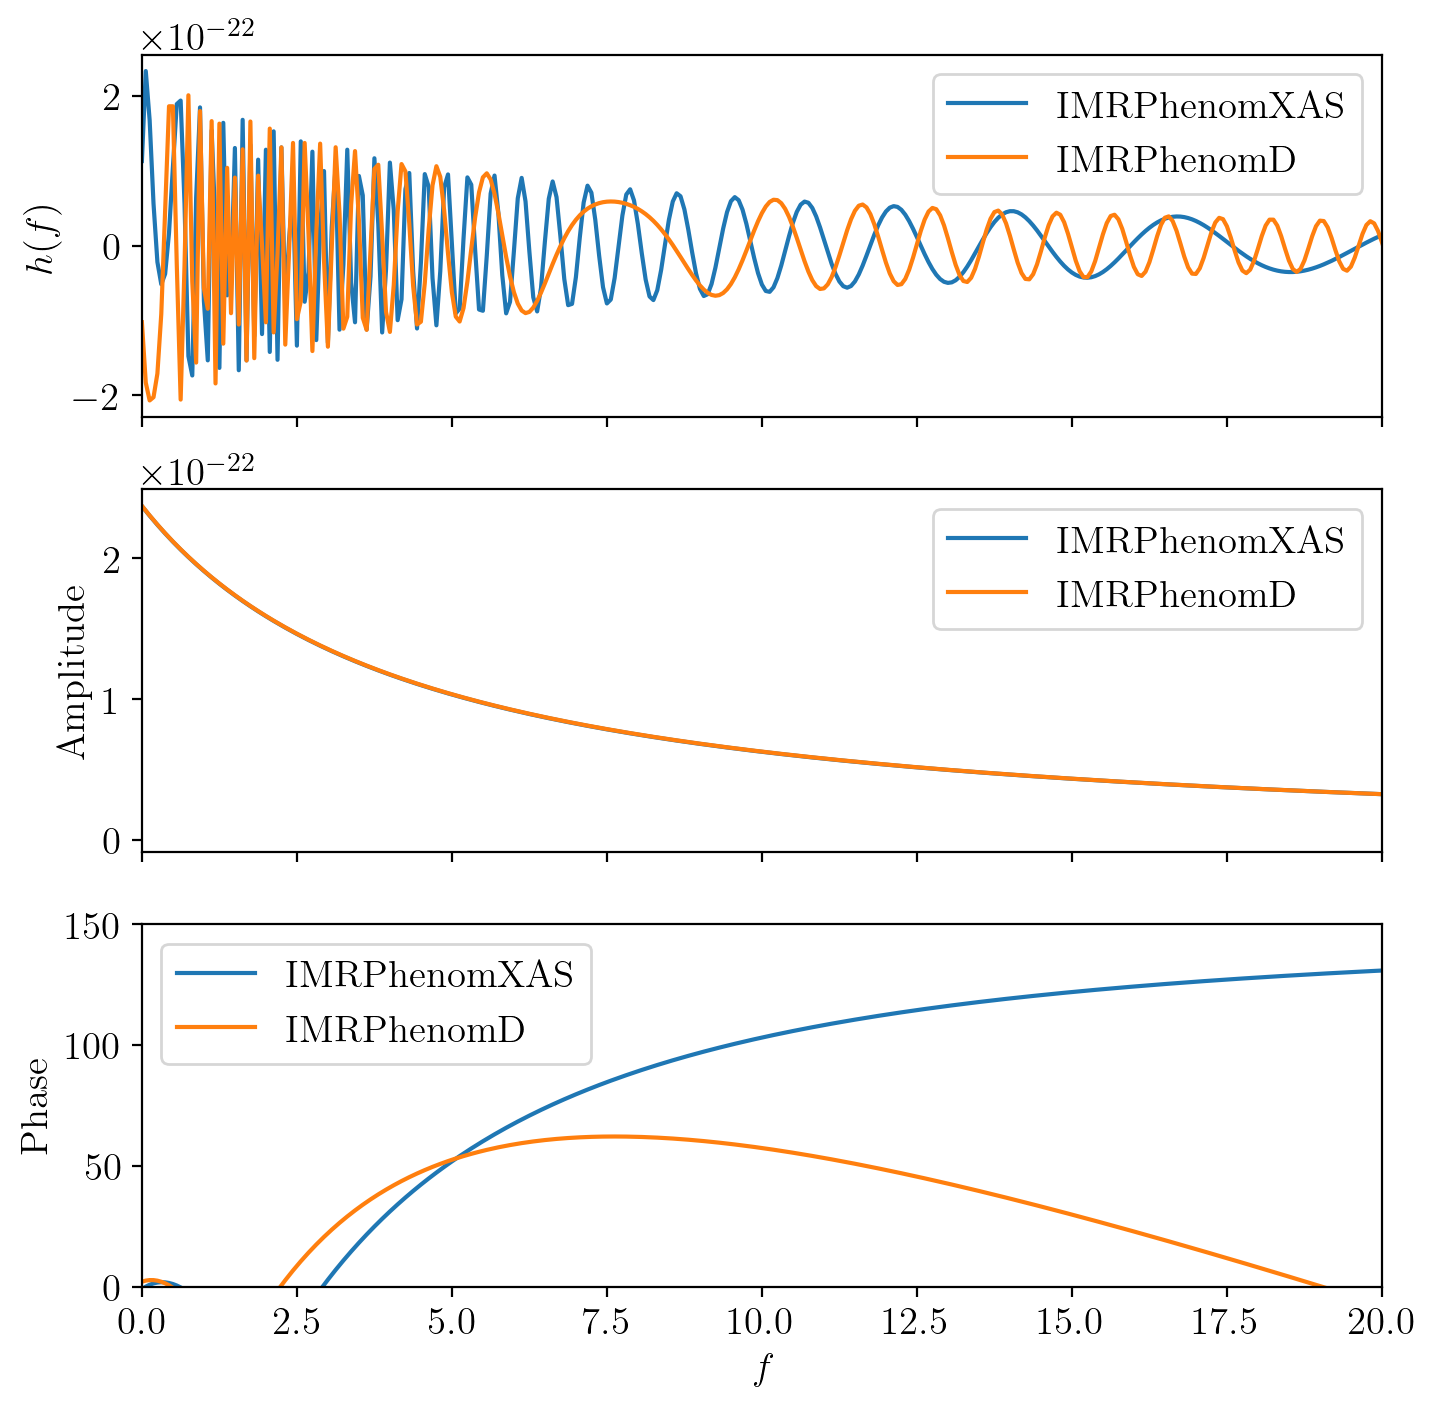

In [81]:
plot_f_series(*fd_waveforms_opt)

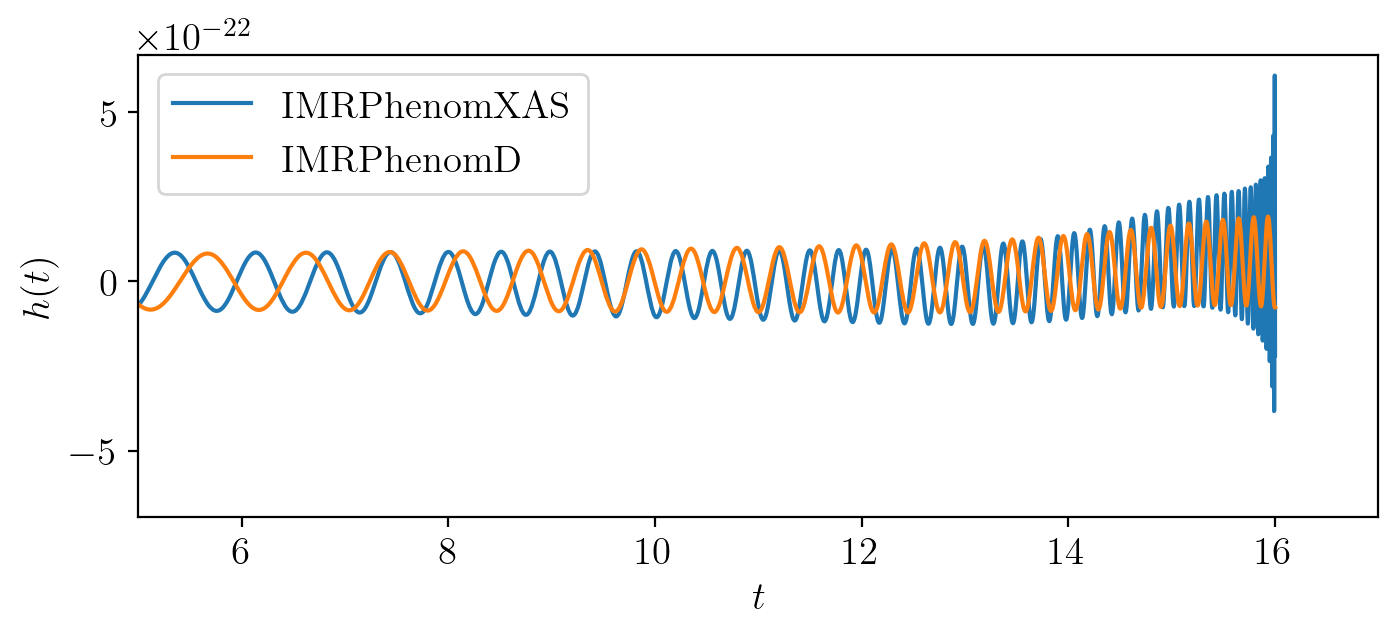

In [82]:
plot_t_series(*td_waveforms_opt)

## Biases

Biases: [-0.007240923820559075, 0.00022550634547258142, -0.0821358274808972, 0.10313820944293184, 1914.908061622642, 0.0005905376842534338, -0.08112561425673448, -0.03828969201549626, 0.0002685136188094184, -0.00014569214674420294, -0.07521052837290654]
Errors: [2.72536348e-03 1.62407395e-03 1.57180339e-01 1.93310678e-01
 1.02475136e+02 1.04190595e-03 7.27119625e-01 1.34910196e-01
 4.76170448e-04 4.03802580e-04 3.63307685e-01]


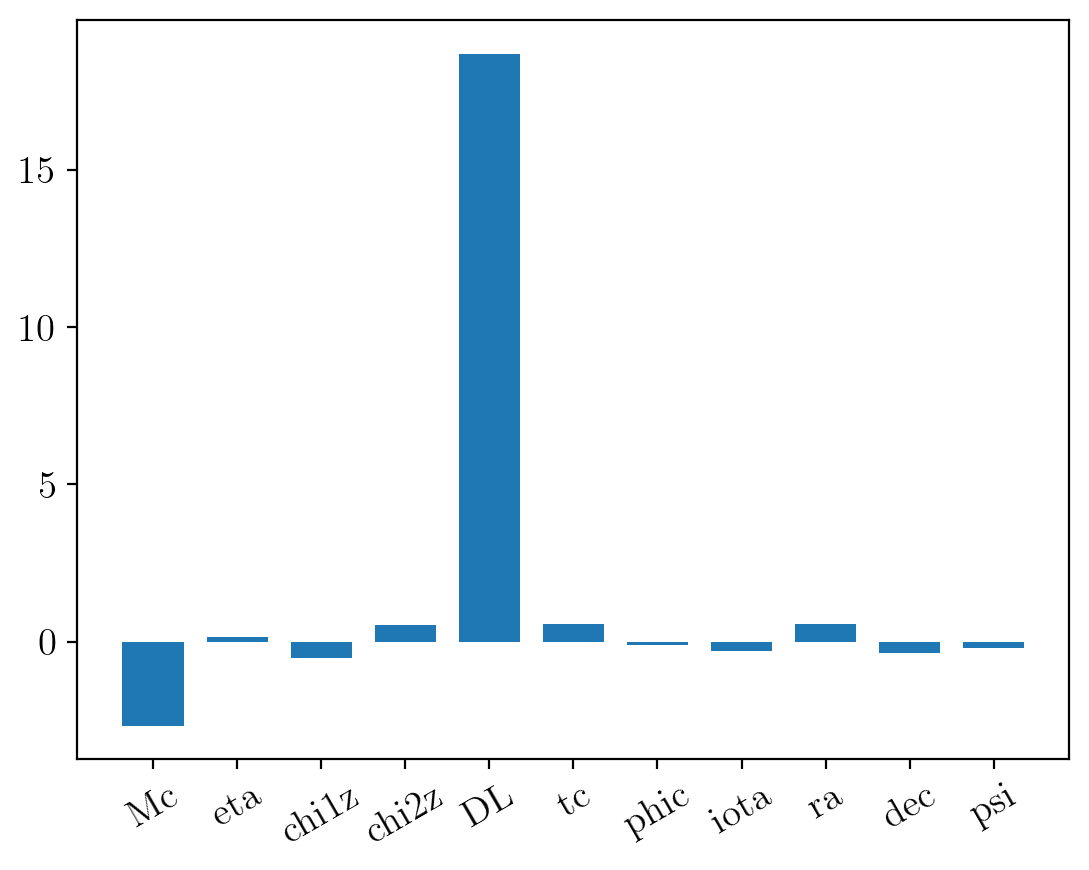

In [83]:
bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]
err_opt = np.zeros(len(bias_opt))

for i, param in enumerate(net_ap_opt.deriv_variables):
    err_opt[i] = net_ap_opt.errs[param]

print("Biases:", bias_opt)
print("Errors:", err_opt)

x = np.linspace(0, len(bias_opt), len(bias_opt))
plt.bar(x, bias_opt/err_opt)
plt.xticks(x, net_ap_opt.deriv_variables, rotation=30)
plt.show()

In [84]:
bias_no_opt

[0.6962290091003212,
 0.29442187702835554,
 -38.027401983812524,
 47.49267381292702,
 803.6568649755791,
 0.2546528961344876,
 12.617324783942422,
 3.5648347962023763,
 -0.012529401878046187,
 0.005769350115615524,
 2.289716517137549]

## Bias Comparison

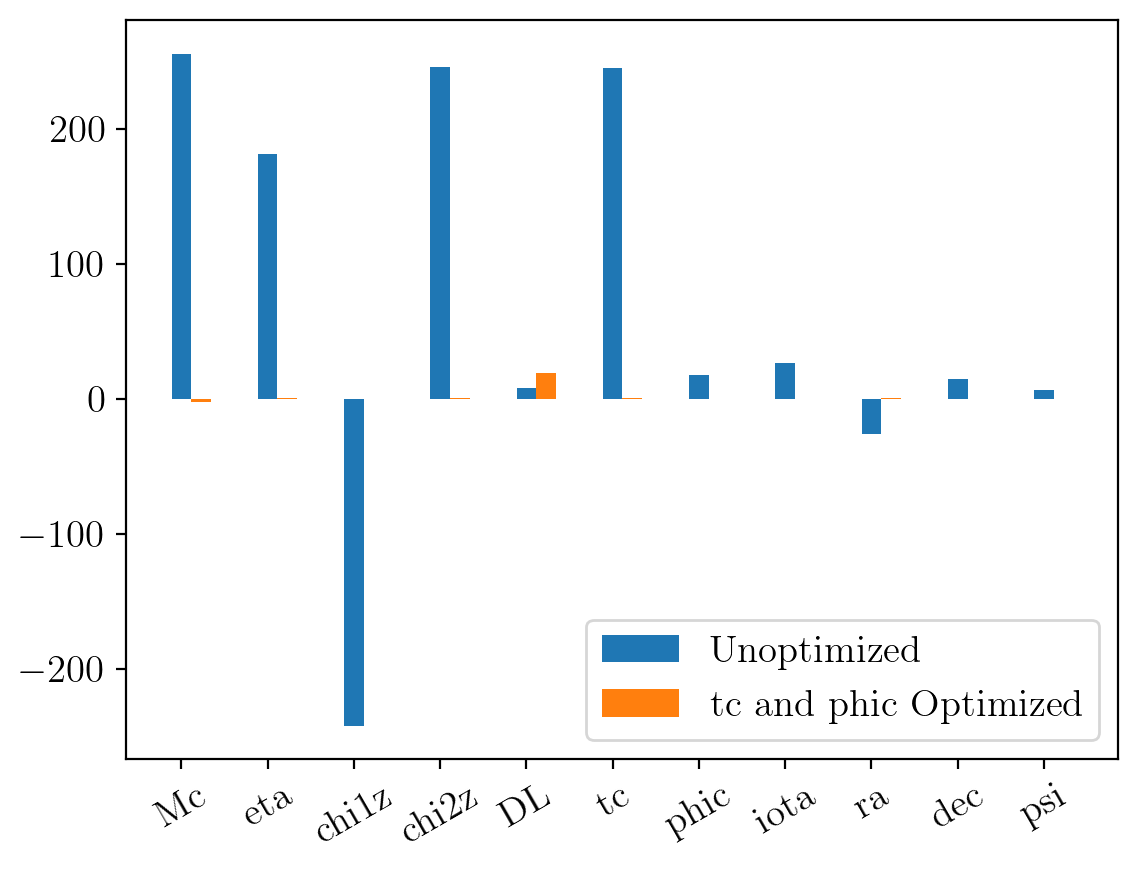

In [85]:
bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]
err_opt = np.zeros(len(bias_opt))

bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))


for i, param in enumerate(net_ap_opt.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]
    err_opt[i] = net_ap_opt.errs[param]


x = np.linspace(0, len(bias_opt), len(bias_opt))

width = 0.25
plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, bias_opt/err_opt, width=width, label='tc and phic Optimized')

plt.xticks(x, net_ap_opt.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

In [86]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]

for i, param in enumerate(net_ap.deriv_variables):
    bias1 = bias_no_opt[i]/net_ap.errs[param]
    bias2 = bias_opt[i]/net_ap_opt.errs[param]
    bias_diff_perc = 100*(bias1-bias2)/bias1
    
    # print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()

Mc, not: 255.568 sigma
Mc, opt: -2.657 sigma

eta, not: 181.301 sigma
eta, opt: 0.139 sigma

chi1z, not: -241.991 sigma
chi1z, opt: -0.523 sigma

chi2z, not: 245.741 sigma
chi2z, opt: 0.534 sigma

DL, not: 7.819 sigma
DL, opt: 18.687 sigma

tc, not: 244.473 sigma
tc, opt: 0.567 sigma

phic, not: 17.354 sigma
phic, opt: -0.112 sigma

iota, not: 26.345 sigma
iota, opt: -0.284 sigma

ra, not: -26.289 sigma
ra, opt: 0.564 sigma

dec, not: 14.277 sigma
dec, opt: -0.361 sigma

psi, not: 6.301 sigma
psi, opt: -0.207 sigma



# Only $\phi_c$ optimized

In [45]:
h1_ts = td_waveforms_no_opt[0]
h1_fs = fd_waveforms_no_opt[0]
h2_fs = fd_waveforms_no_opt[3]

delta_t = h1_ts.delta_t

match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
tc = -index * delta_t
phic = -phi

print(match, tc, phic)

0.9999246518995833 -1.4828648898100516 2.366996263253947


In [46]:
# set the injection parameters
inj_params_opt_phic = inj_params.copy()
inj_params_opt_phic['phic'] = phic


net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap_opt_phic = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt_phic, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

2023-11-21 15:50:10,233 - Network - INFO : Polarizations calculated.
2023-11-21 15:50:10,233 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 15:50:10,241 - Network - INFO : Polarizations calculated.
2023-11-21 15:50:11,144 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:50:11,194 - Network - INFO : PSDs loaded.
2023-11-21 15:50:11,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:50:11,223 - Network - INFO : Detector responses calculated.
2023-11-21 15:50:11,223 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:50:11,224 - Network - INFO :    CE-40_C
2023-11-21 15:50:11,816 - Network - INFO :    CE-20_S
2023-11-21 15:50:12,414 - Network - INFO :    ET_ET1
2023-11-21 15:50:13,016 - Network - INFO :    ET_ET2
2023-11-21 15:50:13,655 - Network - INFO :    ET_ET3
2023-11-21 15:50:14,428 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 1

In [47]:
fd_waveforms_opt_phic = get_pycbc_waveforms_fd(net_true, net_ap_opt_phic)

td_waveforms_opt_phic = get_pycbc_waveforms_td(net_true, net_ap_opt_phic)

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


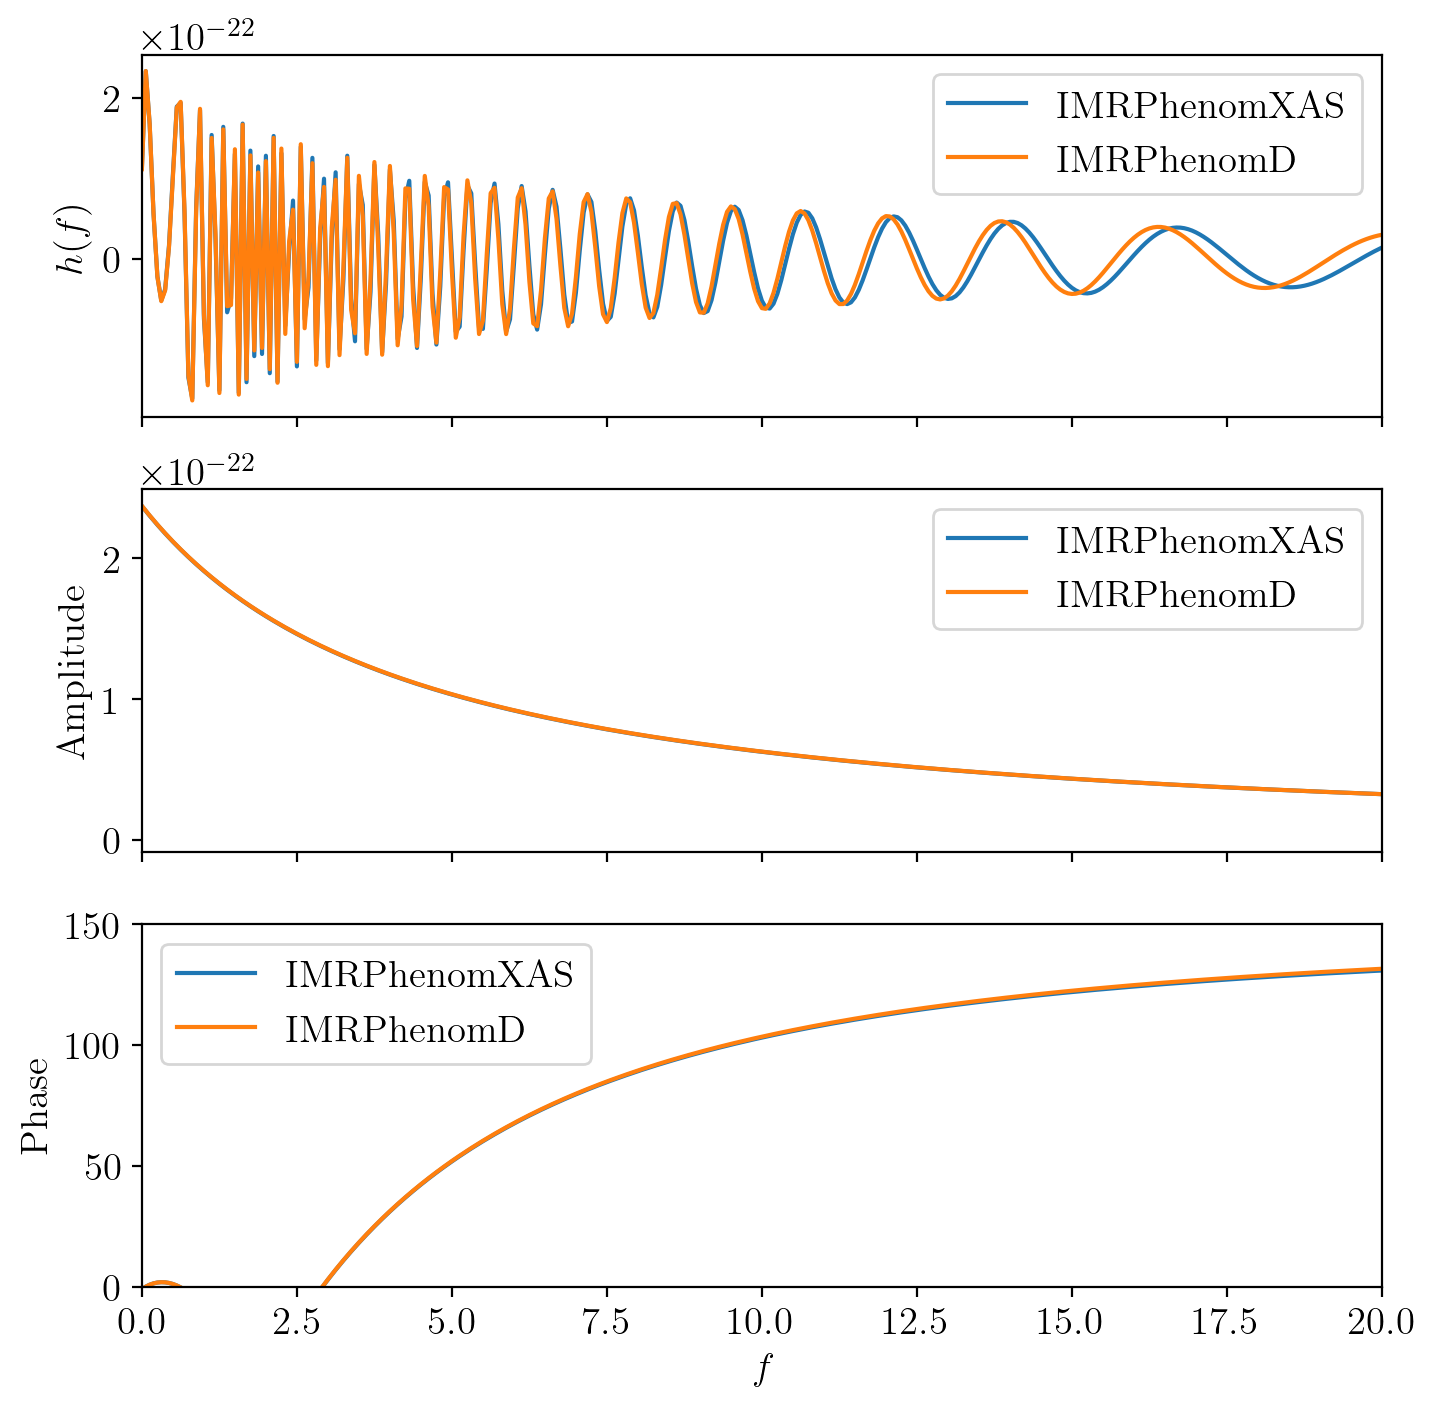

In [48]:
plot_f_series(*fd_waveforms_opt_phic)

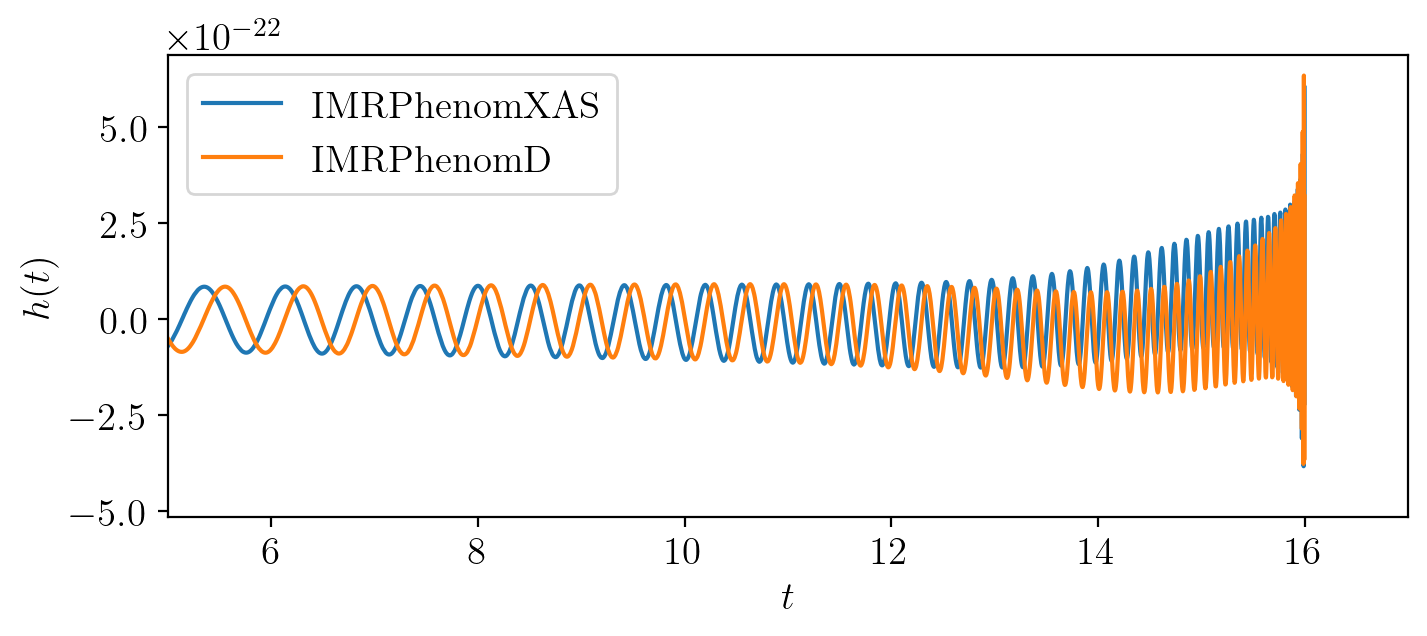

In [49]:
plot_t_series(*td_waveforms_opt_phic)

## Biases

Biases: [-0.3025027432680645, -0.2649365514928377, 23.84762127554859, -29.049617059587035, 1186.0943034305237, -0.15237480883979515, 6.278546445650136, -0.8543868908509467, 0.0037860687910935553, -0.003796910061751646, 5.345181257889635]
Errors: [2.72433017e-03 1.62395439e-03 1.57147124e-01 1.93267658e-01
 1.02453018e+02 1.04166288e-03 7.27329910e-01 1.34883568e-01
 4.76740475e-04 4.03995597e-04 3.63495499e-01]


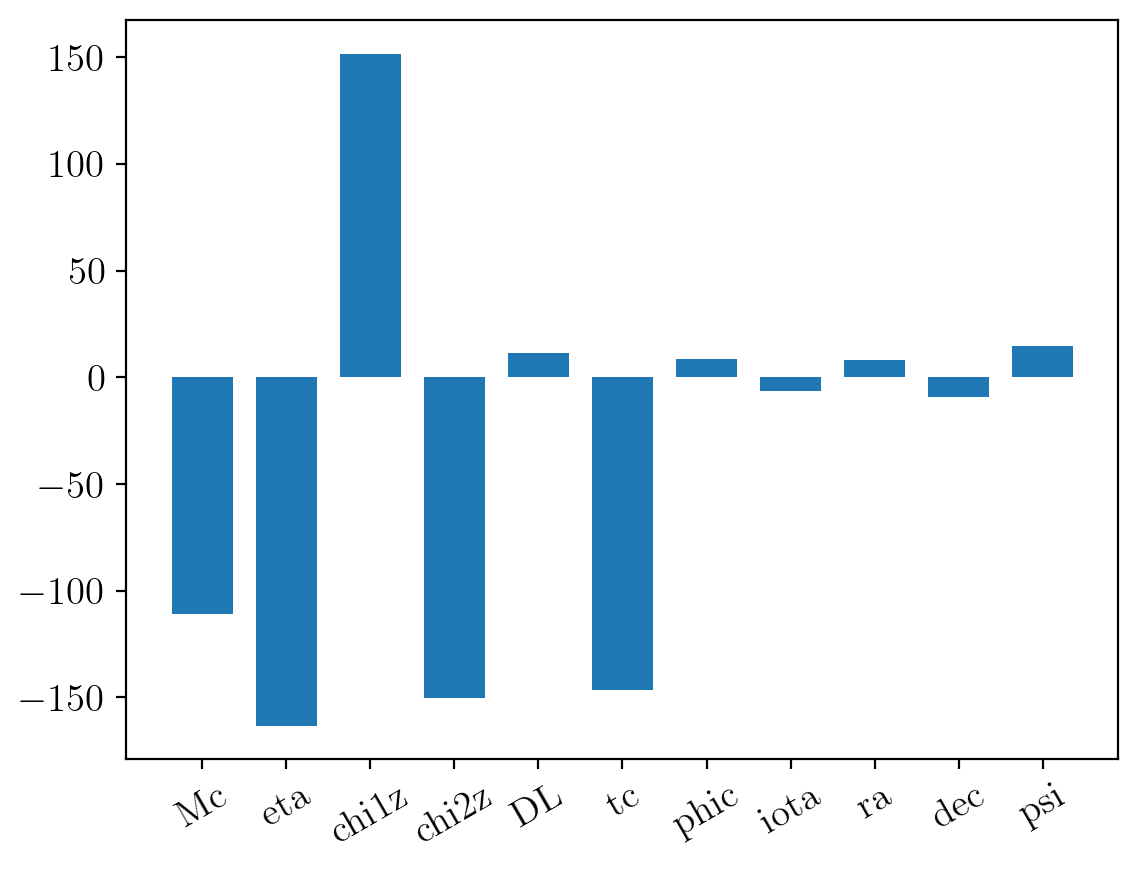

In [50]:
bias_opt_phic = net_ap_opt_phic.cutler_vallisneri_bias.tolist()[0]
err_opt_phic = np.zeros(len(bias_opt_phic))

for i, param in enumerate(net_ap_opt_phic.deriv_variables):
    err_opt_phic[i] = net_ap_opt_phic.errs[param]

print("Biases:", bias_opt_phic)
print("Errors:", err_opt_phic)

x = np.linspace(0, len(bias_opt_phic), len(bias_opt_phic))
plt.bar(x, bias_opt_phic/err_opt_phic)
plt.xticks(x, net_ap_opt_phic.deriv_variables, rotation=30)
plt.show()

## Bias Comparison

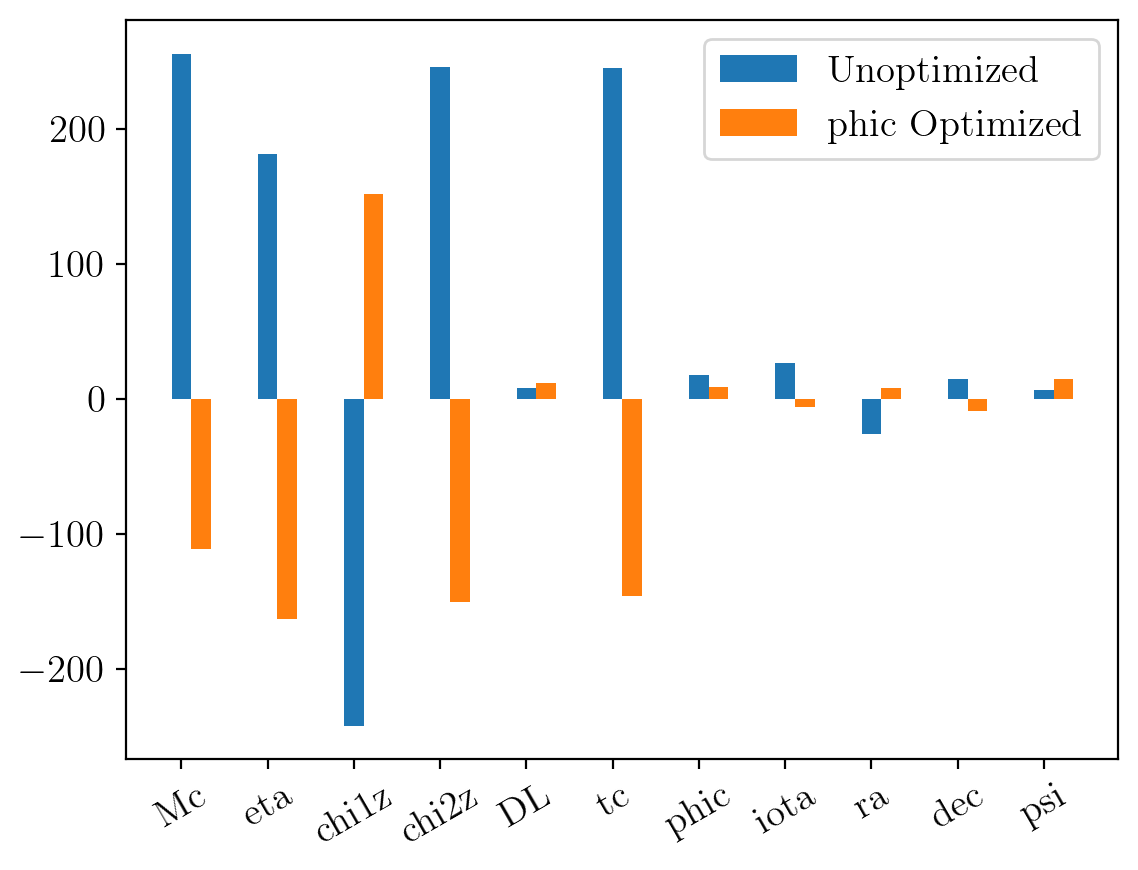

In [51]:
bias_opt_phic = net_ap_opt_phic.cutler_vallisneri_bias.tolist()[0]
err_opt_phic = np.zeros(len(bias_opt_phic))

bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))


for i, param in enumerate(net_ap_opt_phic.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]
    err_opt_phic[i] = net_ap_opt_phic.errs[param]


x = np.linspace(0, len(bias_opt_phic), len(bias_opt_phic))

width = 0.25
plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, bias_opt_phic/err_opt_phic, width=width, label='phic Optimized')

plt.xticks(x, net_ap_opt_phic.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

In [52]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
bias_opt_phic = net_ap_opt_phic.cutler_vallisneri_bias.tolist()[0]

for i, param in enumerate(net_ap.deriv_variables):
    bias1 = bias_no_opt[i]/net_ap.errs[param]
    bias2 = bias_opt_phic[i]/net_ap_opt_phic.errs[param]
    bias_diff_perc = 100*(bias1-bias2)/bias1
    
    # print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()

Mc, not: 255.568 sigma
Mc, opt: -111.037 sigma

eta, not: 181.301 sigma
eta, opt: -163.143 sigma

chi1z, not: -241.991 sigma
chi1z, opt: 151.753 sigma

chi2z, not: 245.741 sigma
chi2z, opt: -150.308 sigma

DL, not: 7.819 sigma
DL, opt: 11.577 sigma

tc, not: 244.473 sigma
tc, opt: -146.280 sigma

phic, not: 17.354 sigma
phic, opt: 8.632 sigma

iota, not: 26.345 sigma
iota, opt: -6.334 sigma

ra, not: -26.289 sigma
ra, opt: 7.942 sigma

dec, not: 14.277 sigma
dec, opt: -9.398 sigma

psi, not: 6.301 sigma
psi, opt: 14.705 sigma



# Only $t_c$ optimized

In [53]:
h1_ts = td_waveforms_no_opt[0]
h1_fs = fd_waveforms_no_opt[0]
h2_fs = fd_waveforms_no_opt[3]

delta_t = h1_ts.delta_t

match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
tc = -index * delta_t
phic = -phi

print(match, tc, phic)

0.9999246518995833 -1.4828648898100516 2.366996263253947


In [54]:
# set the injection parameters
inj_params_opt_tc = inj_params.copy()
inj_params_opt_tc['tc'] = tc


net_key = '3G'

approx1 = 'IMRPhenomXAS'
approx2 = 'IMRPhenomD'

d_f = 2**-4
f_low = 5.0
f_high = np.round(4*br.f_isco_Msolar(mtotal))

net_ap_opt_tc = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt_tc, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)

2023-11-21 15:50:30,007 - Network - INFO : Polarizations calculated.
2023-11-21 15:50:30,009 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 15:50:30,020 - Network - INFO : Polarizations calculated.


2023-11-21 15:50:30,962 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:50:31,040 - Network - INFO : PSDs loaded.
2023-11-21 15:50:31,043 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:50:31,078 - Network - INFO : Detector responses calculated.
2023-11-21 15:50:31,079 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:50:31,079 - Network - INFO :    CE-40_C
2023-11-21 15:50:32,009 - Network - INFO :    CE-20_S
2023-11-21 15:50:32,879 - Network - INFO :    ET_ET1
2023-11-21 15:50:33,790 - Network - INFO :    ET_ET2
2023-11-21 15:50:34,647 - Network - INFO :    ET_ET3
2023-11-21 15:50:35,499 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:50:35,503 - Network - INFO : SNRs calculated.
2023-11-21 15:50:35,503 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:50:35,504 - Network - INFO :    CE-40_C
2023-11-21 15:50:35,567 - Network - INFO :

In [55]:
fd_waveforms_opt_tc = get_pycbc_waveforms_fd(net_true, net_ap_opt_tc)

td_waveforms_opt_tc = get_pycbc_waveforms_td(net_true, net_ap_opt_tc)

/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


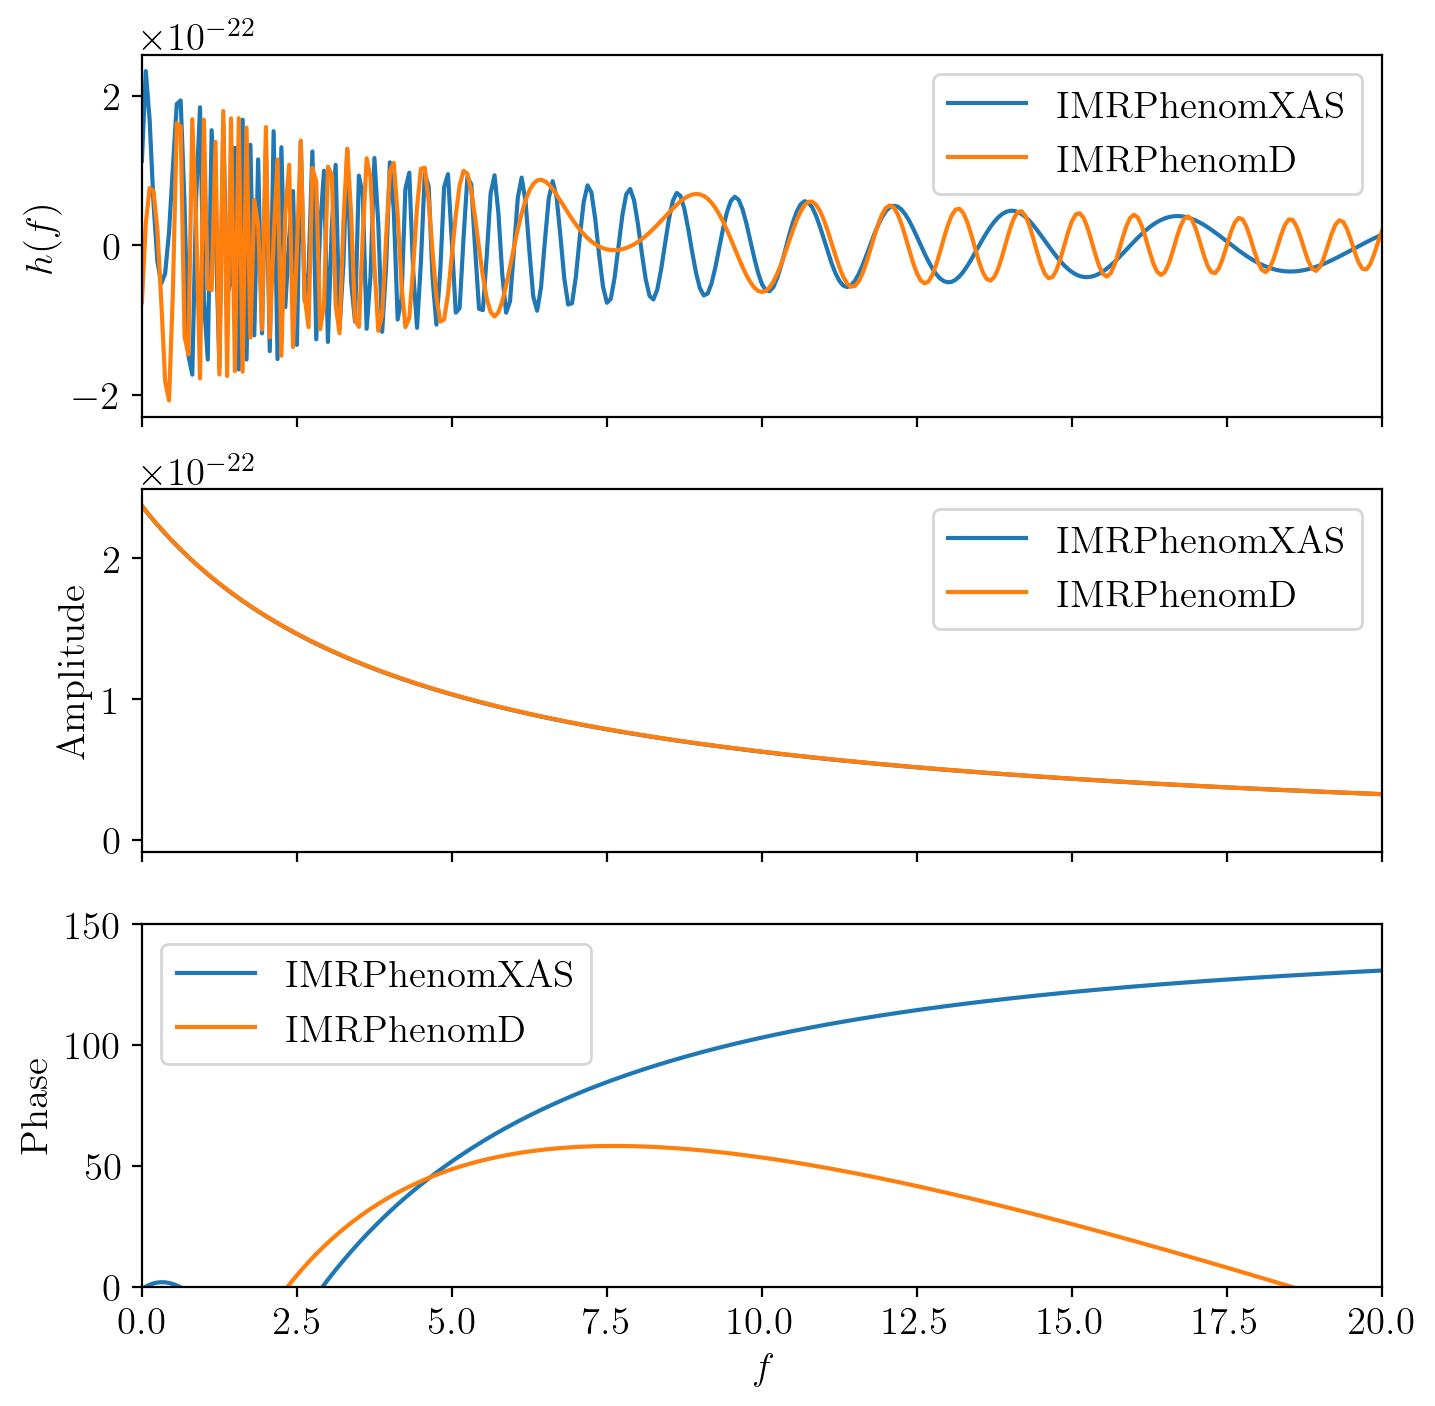

In [56]:
plot_f_series(*fd_waveforms_opt_tc)

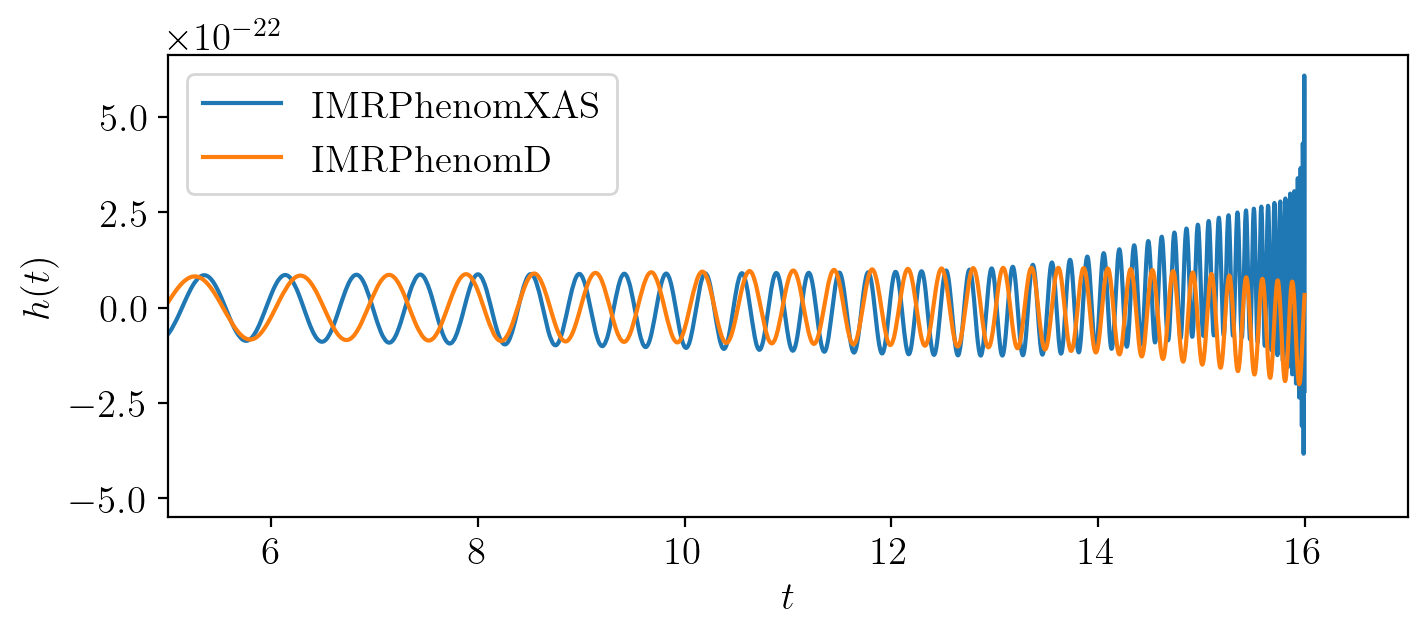

In [57]:
plot_t_series(*td_waveforms_opt_tc)

## Biases

Biases: [0.008339272729333658, 0.00022429885425978568, 0.02383180504784832, -0.030331996432778396, 1899.5806101383641, -0.00019976395525933555, -0.48679017211645714, -0.01649787501719402, -0.00020753969958109408, -1.5638019250197033e-05, -0.21422932887656998]
Errors: [2.72739725e-03 1.62424077e-03 1.57169998e-01 1.93295196e-01
 1.02140656e+02 1.04179280e-03 7.27239132e-01 1.34431526e-01
 4.78059403e-04 3.99893819e-04 3.63473892e-01]


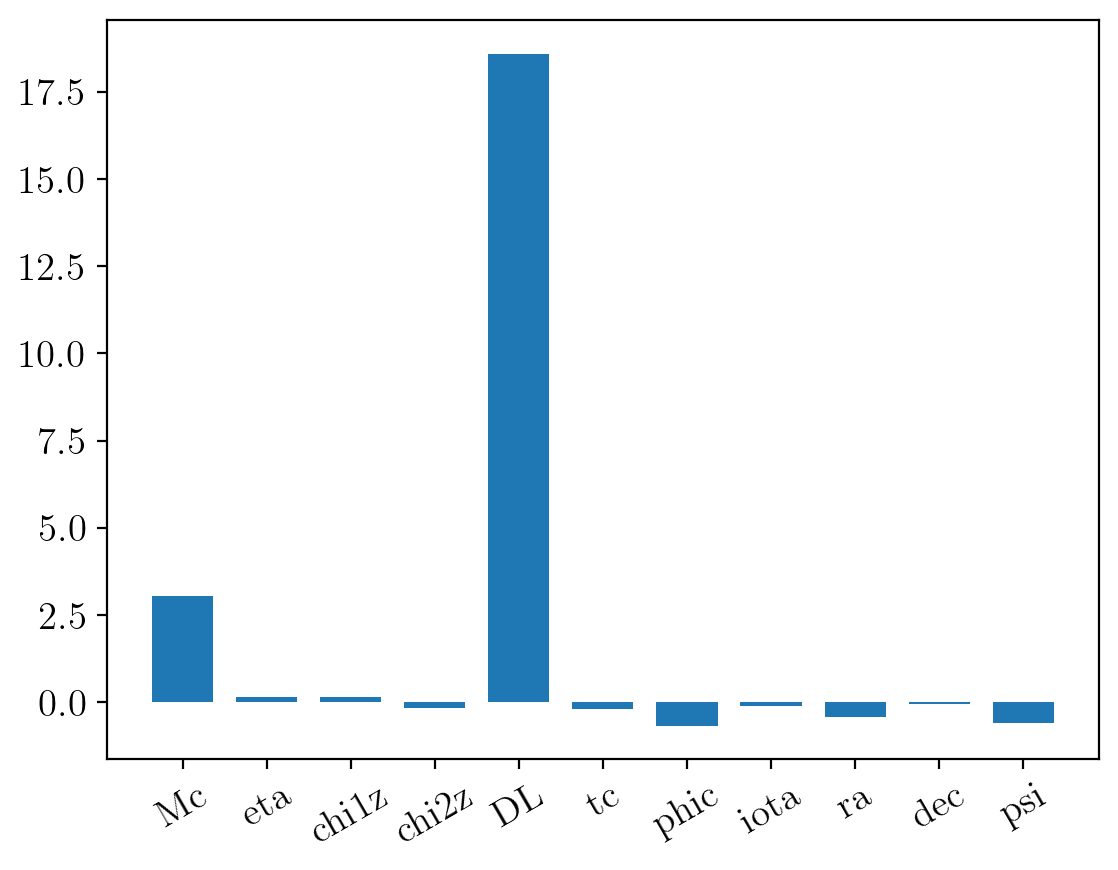

In [58]:
bias_opt_tc = net_ap_opt_tc.cutler_vallisneri_bias.tolist()[0]
err_opt_tc = np.zeros(len(bias_opt_tc))

for i, param in enumerate(net_ap_opt_tc.deriv_variables):
    err_opt_tc[i] = net_ap_opt_tc.errs[param]

print("Biases:", bias_opt_tc)
print("Errors:", err_opt_tc)

x = np.linspace(0, len(bias_opt_tc), len(bias_opt_tc))
plt.bar(x, bias_opt_tc/err_opt_tc)
plt.xticks(x, net_ap_opt_tc.deriv_variables, rotation=30)
plt.show()

## Bias Comparison

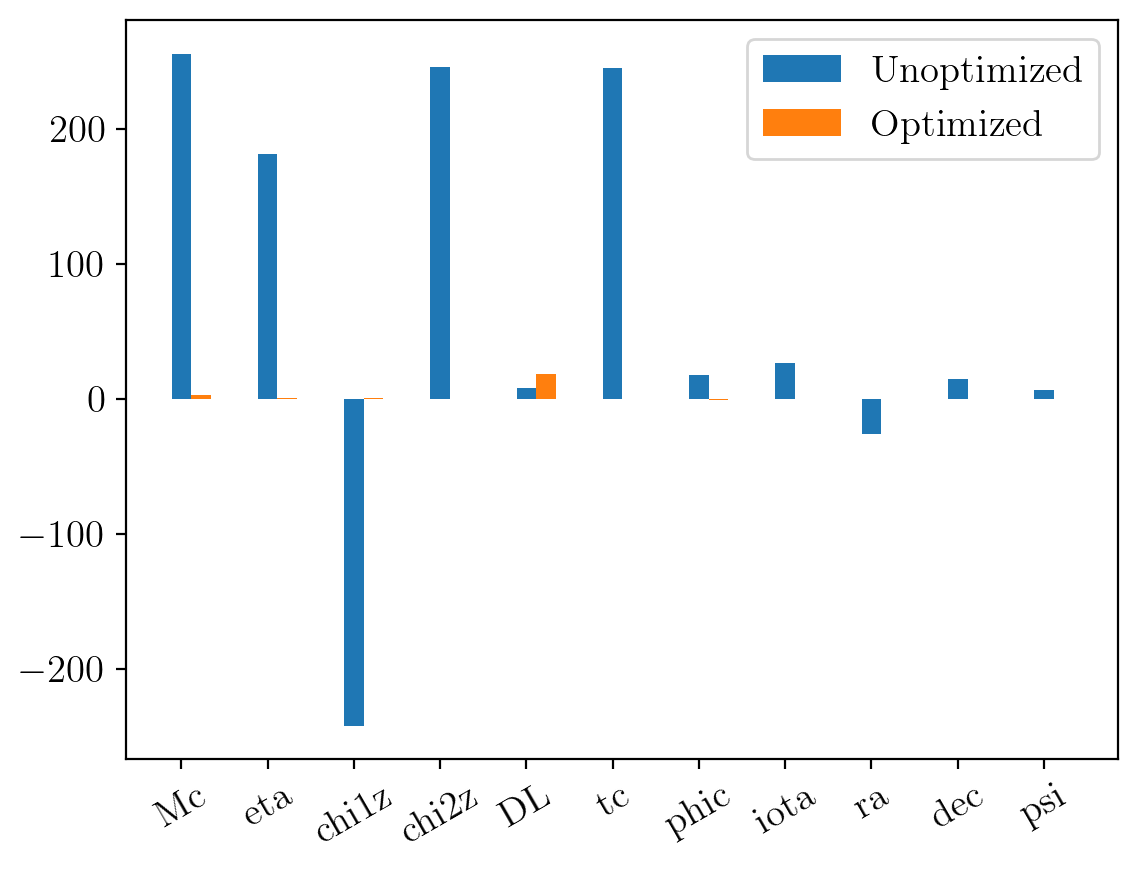

In [59]:
bias_opt_tc = net_ap_opt_tc.cutler_vallisneri_bias.tolist()[0]
err_opt_tc = np.zeros(len(bias_opt_tc))

bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
err_no_opt = np.zeros(len(bias_no_opt))


for i, param in enumerate(net_ap_opt_tc.deriv_variables):
    err_no_opt[i] = net_ap.errs[param]
    err_opt_tc[i] = net_ap_opt_tc.errs[param]


x = np.linspace(0, len(bias_opt_tc), len(bias_opt_tc))

width = 0.25
plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
plt.bar(x+width, bias_opt_tc/err_opt_tc, width=width, label='Optimized')

plt.xticks(x, net_ap_opt_tc.deriv_variables, rotation=30)

# plt.yscale('symlog')
plt.legend()
plt.show()

In [60]:
bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
bias_opt_tc = net_ap_opt_tc.cutler_vallisneri_bias.tolist()[0]

for i, param in enumerate(net_ap.deriv_variables):
    bias1 = bias_no_opt[i]/net_ap.errs[param]
    bias2 = bias_opt_tc[i]/net_ap_opt_tc.errs[param]
    bias_diff_perc = 100*(bias1-bias2)/bias1
    
    # print(f"{param} bias diff: {bias_diff_perc :.2f}%")
    print(f"{param}, not: {bias1:.3f} sigma")
    print(f"{param}, opt: {bias2:.3f} sigma")
    print()

Mc, not: 255.568 sigma
Mc, opt: 3.058 sigma

eta, not: 181.301 sigma
eta, opt: 0.138 sigma

chi1z, not: -241.991 sigma
chi1z, opt: 0.152 sigma

chi2z, not: 245.741 sigma
chi2z, opt: -0.157 sigma

DL, not: 7.819 sigma
DL, opt: 18.598 sigma

tc, not: 244.473 sigma
tc, opt: -0.192 sigma

phic, not: 17.354 sigma
phic, opt: -0.669 sigma

iota, not: 26.345 sigma
iota, opt: -0.123 sigma

ra, not: -26.289 sigma
ra, opt: -0.434 sigma

dec, not: 14.277 sigma
dec, opt: -0.039 sigma

psi, not: 6.301 sigma
psi, opt: -0.589 sigma



# Test over some random binaries

2023-11-21 15:51:55,977 - Network - INFO : Polarizations calculated.
2023-11-21 15:51:55,978 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 15:51:55,986 - Network - INFO : Polarizations calculated.


######  Binary 0  ######


2023-11-21 15:51:57,968 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:51:58,018 - Network - INFO : PSDs loaded.
2023-11-21 15:51:58,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:51:58,054 - Network - INFO : Detector responses calculated.
2023-11-21 15:51:58,055 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:51:58,056 - Network - INFO :    CE-40_C
2023-11-21 15:51:59,491 - Network - INFO :    CE-20_S
2023-11-21 15:52:00,838 - Network - INFO :    ET_ET1
2023-11-21 15:52:02,122 - Network - INFO :    ET_ET2
2023-11-21 15:52:03,483 - Network - INFO :    ET_ET3
2023-11-21 15:52:04,841 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:52:04,845 - Network - INFO : SNRs calculated.
2023-11-21 15:52:04,845 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:52:04,846 - Network - INFO :    CE-40_C
2023-11-21 15:52:04,903 - Network - INFO :

Mc bias diff: 267.50%
Mc, not: 0.049 sigma
Mc, opt: -0.082 sigma

eta bias diff: 183.28%
eta, not: -0.162 sigma
eta, opt: 0.135 sigma

chi1z bias diff: 181.70%
chi1z, not: 0.181 sigma
chi1z, opt: -0.148 sigma

chi2z bias diff: 182.23%
chi2z, not: -0.178 sigma
chi2z, opt: 0.146 sigma

DL bias diff: 99.21%
DL, not: 2.319 sigma
DL, opt: 0.018 sigma

tc bias diff: 181.11%
tc, not: -0.174 sigma
tc, opt: 0.141 sigma

phic bias diff: 39.62%
phic, not: 0.106 sigma
phic, opt: 0.064 sigma

iota bias diff: 112.33%
iota, not: 0.078 sigma
iota, opt: -0.010 sigma

ra bias diff: -1341.02%
ra, not: -0.000 sigma
ra, opt: -0.003 sigma

dec bias diff: 97.25%
dec, not: 0.057 sigma
dec, opt: 0.002 sigma

psi bias diff: 125.88%
psi, not: -0.047 sigma
psi, opt: 0.012 sigma



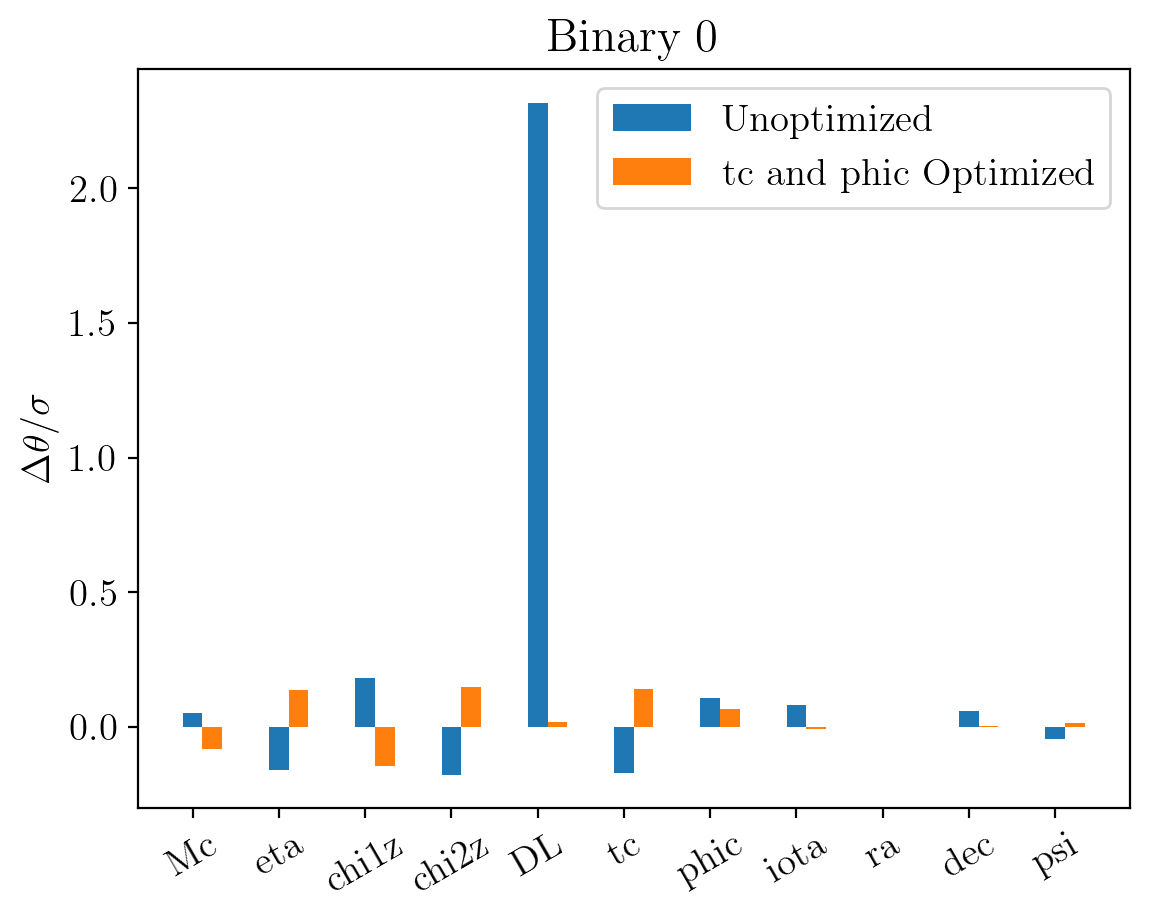

2023-11-21 15:52:15,298 - Network - INFO : Polarizations calculated.
2023-11-21 15:52:15,299 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 15:52:15,306 - Network - INFO : Polarizations calculated.


######  Binary 1  ######


2023-11-21 15:52:16,452 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:52:16,631 - Network - INFO : PSDs loaded.
2023-11-21 15:52:16,633 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:52:16,660 - Network - INFO : Detector responses calculated.
2023-11-21 15:52:16,661 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:52:16,662 - Network - INFO :    CE-40_C
2023-11-21 15:52:17,371 - Network - INFO :    CE-20_S
2023-11-21 15:52:18,124 - Network - INFO :    ET_ET1
2023-11-21 15:52:18,876 - Network - INFO :    ET_ET2
2023-11-21 15:52:19,626 - Network - INFO :    ET_ET3
2023-11-21 15:52:20,378 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:52:20,382 - Network - INFO : SNRs calculated.
2023-11-21 15:52:20,382 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:52:20,383 - Network - INFO :    CE-40_C
2023-11-21 15:52:20,451 - Network - INFO :

Mc bias diff: 114.54%
Mc, not: 0.836 sigma
Mc, opt: -0.122 sigma

eta bias diff: 109.34%
eta, not: 2.030 sigma
eta, opt: -0.190 sigma

chi1z bias diff: 108.66%
chi1z, not: -2.509 sigma
chi1z, opt: 0.217 sigma

chi2z bias diff: 108.60%
chi2z, not: 2.563 sigma
chi2z, opt: -0.220 sigma

DL bias diff: 48.26%
DL, not: 6.282 sigma
DL, opt: 3.250 sigma

tc bias diff: 108.49%
tc, not: 2.581 sigma
tc, opt: -0.219 sigma

phic bias diff: 106.94%
phic, not: 2.267 sigma
phic, opt: -0.157 sigma

iota bias diff: 246.78%
iota, not: -0.084 sigma
iota, opt: 0.123 sigma

ra bias diff: -24.99%
ra, not: 0.039 sigma
ra, opt: 0.049 sigma

dec bias diff: -301.98%
dec, not: 0.059 sigma
dec, opt: 0.238 sigma

psi bias diff: -226.68%
psi, not: -0.111 sigma
psi, opt: -0.362 sigma

######  Binary 2  ######


2023-11-21 15:52:27,762 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:52:27,816 - Network - INFO : PSDs loaded.
2023-11-21 15:52:27,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:52:27,851 - Network - INFO : Detector responses calculated.
2023-11-21 15:52:27,852 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:52:27,853 - Network - INFO :    CE-40_C
2023-11-21 15:52:29,072 - Network - INFO :    CE-20_S
2023-11-21 15:52:30,506 - Network - INFO :    ET_ET1
2023-11-21 15:52:31,753 - Network - INFO :    ET_ET2
2023-11-21 15:52:32,852 - Network - INFO :    ET_ET3
2023-11-21 15:52:34,000 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:52:34,004 - Network - INFO : SNRs calculated.
2023-11-21 15:52:34,005 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:52:34,006 - Network - INFO :    CE-40_C
2023-11-21 15:52:34,093 - Network - INFO :

Mc bias diff: 99.87%
Mc, not: 1.277 sigma
Mc, opt: 0.002 sigma

eta bias diff: 100.10%
eta, not: 1.937 sigma
eta, opt: -0.002 sigma

chi1z bias diff: 98.80%
chi1z, not: -1.447 sigma
chi1z, opt: -0.017 sigma

chi2z bias diff: 98.75%
chi2z, not: 1.430 sigma
chi2z, opt: 0.018 sigma

DL bias diff: 42.32%
DL, not: 7.574 sigma
DL, opt: 4.368 sigma

tc bias diff: 99.03%
tc, not: 1.531 sigma
tc, opt: 0.015 sigma

phic bias diff: 96.62%
phic, not: 1.265 sigma
phic, opt: 0.043 sigma

iota bias diff: 65.55%
iota, not: 0.847 sigma
iota, opt: 0.292 sigma

ra bias diff: 154.33%
ra, not: 0.080 sigma
ra, opt: -0.043 sigma

dec bias diff: 123.04%
dec, not: -0.069 sigma
dec, opt: 0.016 sigma

psi bias diff: 119.10%
psi, not: -0.109 sigma
psi, opt: 0.021 sigma

######  Binary 3  ######


2023-11-21 15:52:45,323 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:52:45,371 - Network - INFO : PSDs loaded.
2023-11-21 15:52:45,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:52:45,412 - Network - INFO : Detector responses calculated.
2023-11-21 15:52:45,413 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:52:45,413 - Network - INFO :    CE-40_C
2023-11-21 15:52:46,952 - Network - INFO :    CE-20_S
2023-11-21 15:52:48,517 - Network - INFO :    ET_ET1
2023-11-21 15:52:50,130 - Network - INFO :    ET_ET2
2023-11-21 15:52:51,674 - Network - INFO :    ET_ET3
2023-11-21 15:52:53,215 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:52:53,218 - Network - INFO : SNRs calculated.
2023-11-21 15:52:53,218 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:52:53,219 - Network - INFO :    CE-40_C
2023-11-21 15:52:53,277 - Network - INFO :

Mc bias diff: 100.18%
Mc, not: -2.008 sigma
Mc, opt: 0.004 sigma

eta bias diff: 100.07%
eta, not: 3.259 sigma
eta, opt: -0.002 sigma

chi1z bias diff: 99.99%
chi1z, not: -2.676 sigma
chi1z, opt: -0.000 sigma

chi2z bias diff: 99.99%
chi2z, not: 2.667 sigma
chi2z, opt: 0.000 sigma

DL bias diff: 47.82%
DL, not: 5.546 sigma
DL, opt: 2.894 sigma

tc bias diff: 100.01%
tc, not: 2.687 sigma
tc, opt: -0.000 sigma

phic bias diff: 100.03%
phic, not: 1.495 sigma
phic, opt: -0.000 sigma

iota bias diff: 255.06%
iota, not: 0.042 sigma
iota, opt: -0.066 sigma

ra bias diff: 115.76%
ra, not: -0.145 sigma
ra, opt: 0.023 sigma

dec bias diff: 124.50%
dec, not: -0.120 sigma
dec, opt: 0.029 sigma

psi bias diff: 100.16%
psi, not: -0.583 sigma
psi, opt: 0.001 sigma

######  Binary 4  ######


2023-11-21 15:53:06,699 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:53:06,747 - Network - INFO : PSDs loaded.
2023-11-21 15:53:06,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:53:06,785 - Network - INFO : Detector responses calculated.
2023-11-21 15:53:06,786 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:53:06,786 - Network - INFO :    CE-40_C
2023-11-21 15:53:08,343 - Network - INFO :    CE-20_S
2023-11-21 15:53:09,815 - Network - INFO :    ET_ET1
2023-11-21 15:53:11,223 - Network - INFO :    ET_ET2
2023-11-21 15:53:12,624 - Network - INFO :    ET_ET3
2023-11-21 15:53:14,122 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:53:14,125 - Network - INFO : SNRs calculated.
2023-11-21 15:53:14,125 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:53:14,126 - Network - INFO :    CE-40_C
2023-11-21 15:53:14,183 - Network - INFO :

Mc bias diff: 99.11%
Mc, not: -6.902 sigma
Mc, opt: -0.061 sigma

eta bias diff: 101.08%
eta, not: 7.291 sigma
eta, opt: -0.078 sigma

chi1z bias diff: 102.59%
chi1z, not: -5.067 sigma
chi1z, opt: 0.131 sigma

chi2z bias diff: 102.99%
chi2z, not: 4.637 sigma
chi2z, opt: -0.139 sigma

DL bias diff: 48.30%
DL, not: 23.120 sigma
DL, opt: 11.954 sigma

tc bias diff: 102.51%
tc, not: 4.861 sigma
tc, opt: -0.122 sigma

phic bias diff: 100.87%
phic, not: 5.871 sigma
phic, opt: -0.051 sigma

iota bias diff: 200.70%
iota, not: -0.519 sigma
iota, opt: 0.522 sigma

ra bias diff: 223.74%
ra, not: 0.424 sigma
ra, opt: -0.525 sigma

dec bias diff: 212.30%
dec, not: 0.423 sigma
dec, opt: -0.475 sigma

psi bias diff: -127.99%
psi, not: -0.200 sigma
psi, opt: -0.455 sigma

######  Binary 5  ######


2023-11-21 15:53:27,051 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:53:27,099 - Network - INFO : PSDs loaded.
2023-11-21 15:53:27,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:53:27,138 - Network - INFO : Detector responses calculated.
2023-11-21 15:53:27,139 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:53:27,139 - Network - INFO :    CE-40_C
2023-11-21 15:53:28,718 - Network - INFO :    CE-20_S
2023-11-21 15:53:30,222 - Network - INFO :    ET_ET1
2023-11-21 15:53:31,786 - Network - INFO :    ET_ET2
2023-11-21 15:53:33,287 - Network - INFO :    ET_ET3
2023-11-21 15:53:34,772 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:53:34,775 - Network - INFO : SNRs calculated.
2023-11-21 15:53:34,776 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:53:34,776 - Network - INFO :    CE-40_C
2023-11-21 15:53:34,835 - Network - INFO :

Mc bias diff: 102.64%
Mc, not: -2.615 sigma
Mc, opt: 0.069 sigma

eta bias diff: 101.43%
eta, not: 2.988 sigma
eta, opt: -0.043 sigma

chi1z bias diff: 100.84%
chi1z, not: -2.361 sigma
chi1z, opt: 0.020 sigma

chi2z bias diff: 100.66%
chi2z, not: 2.204 sigma
chi2z, opt: -0.015 sigma

DL bias diff: 66.29%
DL, not: 5.384 sigma
DL, opt: 1.815 sigma

tc bias diff: 100.65%
tc, not: 2.220 sigma
tc, opt: -0.014 sigma

phic bias diff: 114.91%
phic, not: 0.974 sigma
phic, opt: -0.145 sigma

iota bias diff: 687.20%
iota, not: 0.315 sigma
iota, opt: -1.848 sigma

ra bias diff: 1041.60%
ra, not: -0.018 sigma
ra, opt: 0.173 sigma

dec bias diff: 393.27%
dec, not: 0.073 sigma
dec, opt: -0.213 sigma

psi bias diff: 216.89%
psi, not: -0.122 sigma
psi, opt: 0.143 sigma

######  Binary 6  ######


2023-11-21 15:53:46,521 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:53:46,600 - Network - INFO : PSDs loaded.
2023-11-21 15:53:46,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:53:46,639 - Network - INFO : Detector responses calculated.
2023-11-21 15:53:46,640 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:53:46,641 - Network - INFO :    CE-40_C
2023-11-21 15:53:47,288 - Network - INFO :    CE-20_S
2023-11-21 15:53:47,934 - Network - INFO :    ET_ET1
2023-11-21 15:53:48,581 - Network - INFO :    ET_ET2
2023-11-21 15:53:49,228 - Network - INFO :    ET_ET3
2023-11-21 15:53:49,877 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:53:49,880 - Network - INFO : SNRs calculated.
2023-11-21 15:53:49,881 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:53:49,882 - Network - INFO :    CE-40_C
2023-11-21 15:53:49,959 - Network - INFO :

Mc bias diff: 22.94%
Mc, not: 0.132 sigma
Mc, opt: 0.101 sigma

eta bias diff: 100.54%
eta, not: 1.494 sigma
eta, opt: -0.008 sigma

chi1z bias diff: 99.95%
chi1z, not: -1.723 sigma
chi1z, opt: -0.001 sigma

chi2z bias diff: 99.51%
chi2z, not: 1.798 sigma
chi2z, opt: 0.009 sigma

DL bias diff: 46.53%
DL, not: 4.313 sigma
DL, opt: 2.306 sigma

tc bias diff: 100.14%
tc, not: 1.758 sigma
tc, opt: -0.003 sigma

phic bias diff: 99.42%
phic, not: 1.728 sigma
phic, opt: 0.010 sigma

iota bias diff: 3648.84%
iota, not: -0.011 sigma
iota, opt: 0.387 sigma

ra bias diff: 100.97%
ra, not: 0.127 sigma
ra, opt: -0.001 sigma

dec bias diff: -294.99%
dec, not: 0.157 sigma
dec, opt: 0.618 sigma

psi bias diff: 622.92%
psi, not: -0.050 sigma
psi, opt: 0.262 sigma

######  Binary 7  ######


2023-11-21 15:53:58,738 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:53:58,786 - Network - INFO : PSDs loaded.
2023-11-21 15:53:58,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:53:58,847 - Network - INFO : Detector responses calculated.
2023-11-21 15:53:58,847 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:53:58,848 - Network - INFO :    CE-40_C
2023-11-21 15:54:01,344 - Network - INFO :    CE-20_S
2023-11-21 15:54:03,795 - Network - INFO :    ET_ET1
2023-11-21 15:54:06,190 - Network - INFO :    ET_ET2
2023-11-21 15:54:08,556 - Network - INFO :    ET_ET3
2023-11-21 15:54:10,958 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:54:10,964 - Network - INFO : SNRs calculated.
2023-11-21 15:54:10,964 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:54:10,965 - Network - INFO :    CE-40_C
2023-11-21 15:54:11,035 - Network - INFO :

Mc bias diff: 109.35%
Mc, not: -0.333 sigma
Mc, opt: 0.031 sigma

eta bias diff: 133.42%
eta, not: 0.085 sigma
eta, opt: -0.028 sigma

chi1z bias diff: 50.27%
chi1z, not: 0.055 sigma
chi1z, opt: 0.027 sigma

chi2z bias diff: 24.67%
chi2z, not: -0.036 sigma
chi2z, opt: -0.027 sigma

DL bias diff: 43.61%
DL, not: 24.819 sigma
DL, opt: 13.996 sigma

tc bias diff: 90.64%
tc, not: -0.277 sigma
tc, opt: -0.026 sigma

phic bias diff: 102.16%
phic, not: 1.611 sigma
phic, opt: -0.035 sigma

iota bias diff: 100.59%
iota, not: -0.380 sigma
iota, opt: 0.002 sigma

ra bias diff: 99.31%
ra, not: 0.123 sigma
ra, opt: 0.001 sigma

dec bias diff: 98.60%
dec, not: 0.124 sigma
dec, opt: 0.002 sigma

psi bias diff: 102.36%
psi, not: -0.146 sigma
psi, opt: 0.003 sigma

######  Binary 8  ######


2023-11-21 15:54:30,557 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:54:30,605 - Network - INFO : PSDs loaded.
2023-11-21 15:54:30,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:54:30,652 - Network - INFO : Detector responses calculated.
2023-11-21 15:54:30,652 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:54:30,653 - Network - INFO :    CE-40_C
2023-11-21 15:54:32,509 - Network - INFO :    CE-20_S
2023-11-21 15:54:34,302 - Network - INFO :    ET_ET1
2023-11-21 15:54:36,082 - Network - INFO :    ET_ET2
2023-11-21 15:54:37,884 - Network - INFO :    ET_ET3
2023-11-21 15:54:39,684 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:54:39,688 - Network - INFO : SNRs calculated.
2023-11-21 15:54:39,689 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:54:39,689 - Network - INFO :    CE-40_C
2023-11-21 15:54:39,752 - Network - INFO :

Mc bias diff: 99.80%
Mc, not: -10.742 sigma
Mc, opt: -0.021 sigma

eta bias diff: 99.83%
eta, not: 9.787 sigma
eta, opt: 0.016 sigma

chi1z bias diff: 99.73%
chi1z, not: -7.549 sigma
chi1z, opt: -0.020 sigma

chi2z bias diff: 99.71%
chi2z, not: 7.215 sigma
chi2z, opt: 0.021 sigma

DL bias diff: 54.70%
DL, not: 13.407 sigma
DL, opt: 6.074 sigma

tc bias diff: 99.75%
tc, not: 7.478 sigma
tc, opt: 0.019 sigma

phic bias diff: 98.99%
phic, not: 2.741 sigma
phic, opt: 0.028 sigma

iota bias diff: 113.79%
iota, not: 1.723 sigma
iota, opt: -0.238 sigma

ra bias diff: 176.92%
ra, not: -0.056 sigma
ra, opt: 0.043 sigma

dec bias diff: 72.01%
dec, not: 0.196 sigma
dec, opt: 0.055 sigma

psi bias diff: 72.96%
psi, not: -0.051 sigma
psi, opt: -0.014 sigma

######  Binary 9  ######


2023-11-21 15:54:53,327 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:54:53,383 - Network - INFO : PSDs loaded.
2023-11-21 15:54:53,385 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:54:53,412 - Network - INFO : Detector responses calculated.
2023-11-21 15:54:53,412 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:54:53,413 - Network - INFO :    CE-40_C
2023-11-21 15:54:54,021 - Network - INFO :    CE-20_S
2023-11-21 15:54:54,641 - Network - INFO :    ET_ET1
2023-11-21 15:54:55,261 - Network - INFO :    ET_ET2
2023-11-21 15:54:55,880 - Network - INFO :    ET_ET3
2023-11-21 15:54:56,498 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:54:56,502 - Network - INFO : SNRs calculated.
2023-11-21 15:54:56,503 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:54:56,504 - Network - INFO :    CE-40_C
2023-11-21 15:54:56,584 - Network - INFO :

Mc bias diff: 73.19%
Mc, not: 0.320 sigma
Mc, opt: 0.086 sigma

eta bias diff: 116.03%
eta, not: 1.954 sigma
eta, opt: -0.313 sigma

chi1z bias diff: 108.12%
chi1z, not: -2.342 sigma
chi1z, opt: 0.190 sigma

chi2z bias diff: 108.03%
chi2z, not: 2.349 sigma
chi2z, opt: -0.189 sigma

DL bias diff: 52.39%
DL, not: 4.994 sigma
DL, opt: 2.378 sigma

tc bias diff: 107.77%
tc, not: 2.320 sigma
tc, opt: -0.180 sigma

phic bias diff: 108.91%
phic, not: 2.274 sigma
phic, opt: -0.203 sigma

iota bias diff: -770.69%
iota, not: -0.078 sigma
iota, opt: -0.678 sigma

ra bias diff: -197.27%
ra, not: 0.257 sigma
ra, opt: 0.765 sigma

dec bias diff: -863.04%
dec, not: -0.104 sigma
dec, opt: -1.006 sigma

psi bias diff: -1084.94%
psi, not: -0.046 sigma
psi, opt: -0.548 sigma

######  Binary 10  ######


2023-11-21 15:55:03,408 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:55:03,455 - Network - INFO : PSDs loaded.
2023-11-21 15:55:03,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:55:03,494 - Network - INFO : Detector responses calculated.
2023-11-21 15:55:03,495 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:55:03,495 - Network - INFO :    CE-40_C
2023-11-21 15:55:04,878 - Network - INFO :    CE-20_S
2023-11-21 15:55:06,268 - Network - INFO :    ET_ET1
2023-11-21 15:55:07,634 - Network - INFO :    ET_ET2
2023-11-21 15:55:09,001 - Network - INFO :    ET_ET3
2023-11-21 15:55:10,425 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:55:10,429 - Network - INFO : SNRs calculated.
2023-11-21 15:55:10,429 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:55:10,430 - Network - INFO :    CE-40_C
2023-11-21 15:55:10,486 - Network - INFO :

Mc bias diff: 50.44%
Mc, not: -0.077 sigma
Mc, opt: -0.038 sigma

eta bias diff: 99.20%
eta, not: 0.790 sigma
eta, opt: 0.006 sigma

chi1z bias diff: 100.22%
chi1z, not: -0.871 sigma
chi1z, opt: 0.002 sigma

chi2z bias diff: 100.37%
chi2z, not: 0.885 sigma
chi2z, opt: -0.003 sigma

DL bias diff: 43.53%
DL, not: 8.826 sigma
DL, opt: 4.984 sigma

tc bias diff: 101.06%
tc, not: 0.913 sigma
tc, opt: -0.010 sigma

phic bias diff: 98.84%
phic, not: 0.823 sigma
phic, opt: 0.010 sigma

iota bias diff: 406.57%
iota, not: -0.050 sigma
iota, opt: 0.152 sigma

ra bias diff: 80.78%
ra, not: 0.228 sigma
ra, opt: 0.044 sigma

dec bias diff: 86.99%
dec, not: -0.140 sigma
dec, opt: -0.018 sigma

psi bias diff: 62.71%
psi, not: -0.027 sigma
psi, opt: -0.010 sigma



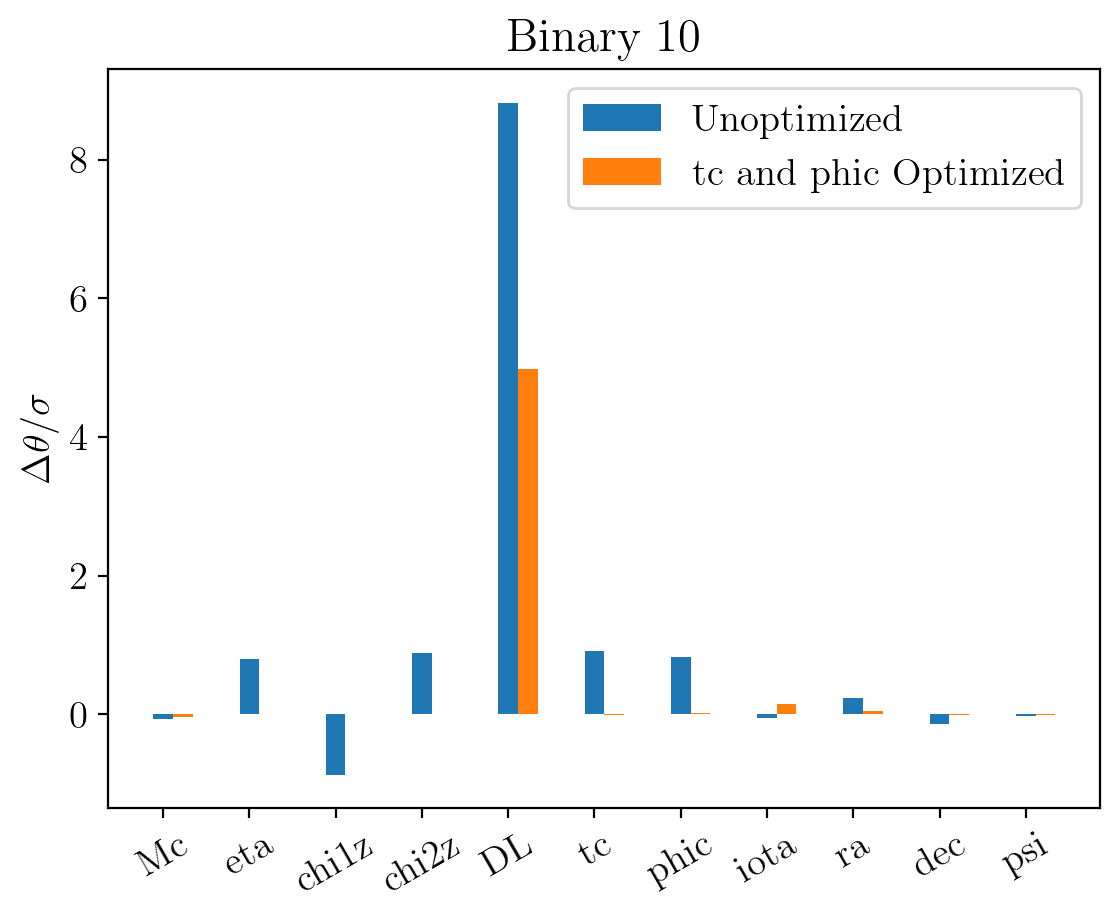

2023-11-21 15:55:20,816 - Network - INFO : Polarizations calculated.
2023-11-21 15:55:20,817 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 15:55:20,829 - Network - INFO : Polarizations calculated.


######  Binary 11  ######


2023-11-21 15:55:23,293 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:55:23,341 - Network - INFO : PSDs loaded.
2023-11-21 15:55:23,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:55:23,383 - Network - INFO : Detector responses calculated.
2023-11-21 15:55:23,384 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:55:23,385 - Network - INFO :    CE-40_C
2023-11-21 15:55:25,076 - Network - INFO :    CE-20_S
2023-11-21 15:55:26,716 - Network - INFO :    ET_ET1
2023-11-21 15:55:28,332 - Network - INFO :    ET_ET2
2023-11-21 15:55:29,948 - Network - INFO :    ET_ET3
2023-11-21 15:55:31,561 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:55:31,565 - Network - INFO : SNRs calculated.
2023-11-21 15:55:31,565 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:55:31,566 - Network - INFO :    CE-40_C
2023-11-21 15:55:31,625 - Network - INFO :

Mc bias diff: 104.99%
Mc, not: -0.339 sigma
Mc, opt: 0.017 sigma

eta bias diff: 102.34%
eta, not: 0.268 sigma
eta, opt: -0.006 sigma

chi1z bias diff: 101.28%
chi1z, not: 0.257 sigma
chi1z, opt: -0.003 sigma

chi2z bias diff: 101.29%
chi2z, not: -0.253 sigma
chi2z, opt: 0.003 sigma

DL bias diff: 42.76%
DL, not: 16.123 sigma
DL, opt: 9.229 sigma

tc bias diff: 100.03%
tc, not: -0.079 sigma
tc, opt: 0.000 sigma

phic bias diff: 103.10%
phic, not: 0.642 sigma
phic, opt: -0.020 sigma

iota bias diff: 93.01%
iota, not: -0.091 sigma
iota, opt: -0.006 sigma

ra bias diff: 98.25%
ra, not: -0.113 sigma
ra, opt: -0.002 sigma

dec bias diff: 99.23%
dec, not: -0.203 sigma
dec, opt: -0.002 sigma

psi bias diff: 97.26%
psi, not: 0.238 sigma
psi, opt: 0.007 sigma

######  Binary 12  ######


2023-11-21 15:55:44,271 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:55:44,338 - Network - INFO : PSDs loaded.
2023-11-21 15:55:44,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:55:44,372 - Network - INFO : Detector responses calculated.
2023-11-21 15:55:44,373 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:55:44,374 - Network - INFO :    CE-40_C
2023-11-21 15:55:45,204 - Network - INFO :    CE-20_S
2023-11-21 15:55:46,018 - Network - INFO :    ET_ET1
2023-11-21 15:55:46,847 - Network - INFO :    ET_ET2
2023-11-21 15:55:47,674 - Network - INFO :    ET_ET3
2023-11-21 15:55:48,490 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:55:48,493 - Network - INFO : SNRs calculated.
2023-11-21 15:55:48,494 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:55:48,494 - Network - INFO :    CE-40_C
2023-11-21 15:55:48,551 - Network - INFO :

Mc bias diff: 101.31%
Mc, not: 9.191 sigma
Mc, opt: -0.120 sigma

eta bias diff: 100.35%
eta, not: 9.268 sigma
eta, opt: -0.033 sigma

chi1z bias diff: 100.08%
chi1z, not: -10.804 sigma
chi1z, opt: 0.009 sigma

chi2z bias diff: 100.06%
chi2z, not: 10.936 sigma
chi2z, opt: -0.007 sigma

DL bias diff: 93.36%
DL, not: 1.040 sigma
DL, opt: 0.069 sigma

tc bias diff: 100.06%
tc, not: 10.785 sigma
tc, opt: -0.006 sigma

phic bias diff: 25.13%
phic, not: 0.096 sigma
phic, opt: 0.072 sigma

iota bias diff: -317.79%
iota, not: 1.996 sigma
iota, opt: 8.338 sigma

ra bias diff: 140.78%
ra, not: -0.397 sigma
ra, opt: 0.162 sigma

dec bias diff: 62.78%
dec, not: -0.877 sigma
dec, opt: -0.327 sigma

psi bias diff: 108.14%
psi, not: -0.806 sigma
psi, opt: 0.066 sigma

######  Binary 13  ######


2023-11-21 15:55:56,621 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:55:56,668 - Network - INFO : PSDs loaded.
2023-11-21 15:55:56,671 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:55:56,703 - Network - INFO : Detector responses calculated.
2023-11-21 15:55:56,704 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:55:56,704 - Network - INFO :    CE-40_C
2023-11-21 15:55:57,897 - Network - INFO :    CE-20_S
2023-11-21 15:55:59,137 - Network - INFO :    ET_ET1
2023-11-21 15:56:00,386 - Network - INFO :    ET_ET2
2023-11-21 15:56:01,603 - Network - INFO :    ET_ET3
2023-11-21 15:56:02,860 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:56:02,863 - Network - INFO : SNRs calculated.
2023-11-21 15:56:02,864 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:56:02,864 - Network - INFO :    CE-40_C
2023-11-21 15:56:02,922 - Network - INFO :

Mc bias diff: 105.08%
Mc, not: 0.743 sigma
Mc, opt: -0.038 sigma

eta bias diff: 102.03%
eta, not: 1.665 sigma
eta, opt: -0.034 sigma

chi1z bias diff: 103.27%
chi1z, not: -1.385 sigma
chi1z, opt: 0.045 sigma

chi2z bias diff: 103.36%
chi2z, not: 1.359 sigma
chi2z, opt: -0.046 sigma

DL bias diff: 46.88%
DL, not: 13.525 sigma
DL, opt: 7.184 sigma

tc bias diff: 103.24%
tc, not: 1.385 sigma
tc, opt: -0.045 sigma

phic bias diff: 99.46%
phic, not: 1.225 sigma
phic, opt: 0.007 sigma

iota bias diff: 169.10%
iota, not: 0.306 sigma
iota, opt: -0.212 sigma

ra bias diff: 140.85%
ra, not: -0.113 sigma
ra, opt: 0.046 sigma

dec bias diff: 111.62%
dec, not: -0.232 sigma
dec, opt: 0.027 sigma

psi bias diff: 88.34%
psi, not: -0.279 sigma
psi, opt: -0.032 sigma

######  Binary 14  ######


2023-11-21 15:56:13,573 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:56:13,623 - Network - INFO : PSDs loaded.
2023-11-21 15:56:13,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:56:13,657 - Network - INFO : Detector responses calculated.
2023-11-21 15:56:13,657 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:56:13,658 - Network - INFO :    CE-40_C
2023-11-21 15:56:14,721 - Network - INFO :    CE-20_S
2023-11-21 15:56:15,794 - Network - INFO :    ET_ET1
2023-11-21 15:56:16,900 - Network - INFO :    ET_ET2
2023-11-21 15:56:17,996 - Network - INFO :    ET_ET3
2023-11-21 15:56:19,086 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:56:19,094 - Network - INFO : SNRs calculated.
2023-11-21 15:56:19,095 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:56:19,096 - Network - INFO :    CE-40_C
2023-11-21 15:56:19,157 - Network - INFO :

Mc bias diff: 104.94%
Mc, not: 3.893 sigma
Mc, opt: -0.192 sigma

eta bias diff: 109.31%
eta, not: 1.541 sigma
eta, opt: -0.144 sigma

chi1z bias diff: 109.39%
chi1z, not: -2.388 sigma
chi1z, opt: 0.224 sigma

chi2z bias diff: 109.21%
chi2z, not: 2.528 sigma
chi2z, opt: -0.233 sigma

DL bias diff: 87.56%
DL, not: 3.977 sigma
DL, opt: 0.495 sigma

tc bias diff: 109.54%
tc, not: 2.469 sigma
tc, opt: -0.236 sigma

phic bias diff: 91.78%
phic, not: 0.984 sigma
phic, opt: 0.081 sigma

iota bias diff: 10822.13%
iota, not: -0.049 sigma
iota, opt: 5.208 sigma

ra bias diff: 498.44%
ra, not: -0.066 sigma
ra, opt: 0.265 sigma

dec bias diff: -4426.19%
dec, not: 0.016 sigma
dec, opt: 0.732 sigma

psi bias diff: 82.10%
psi, not: 0.732 sigma
psi, opt: 0.131 sigma

######  Binary 15  ######


2023-11-21 15:56:29,337 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:56:29,384 - Network - INFO : PSDs loaded.
2023-11-21 15:56:29,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:56:29,422 - Network - INFO : Detector responses calculated.
2023-11-21 15:56:29,423 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:56:29,423 - Network - INFO :    CE-40_C
2023-11-21 15:56:30,762 - Network - INFO :    CE-20_S
2023-11-21 15:56:32,079 - Network - INFO :    ET_ET1
2023-11-21 15:56:33,365 - Network - INFO :    ET_ET2
2023-11-21 15:56:34,690 - Network - INFO :    ET_ET3
2023-11-21 15:56:35,992 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:56:35,995 - Network - INFO : SNRs calculated.
2023-11-21 15:56:35,995 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:56:35,996 - Network - INFO :    CE-40_C
2023-11-21 15:56:36,051 - Network - INFO :

Mc bias diff: 94.11%
Mc, not: -0.170 sigma
Mc, opt: -0.010 sigma

eta bias diff: 100.07%
eta, not: 1.377 sigma
eta, opt: -0.001 sigma

chi1z bias diff: 100.36%
chi1z, not: -1.407 sigma
chi1z, opt: 0.005 sigma

chi2z bias diff: 100.45%
chi2z, not: 1.390 sigma
chi2z, opt: -0.006 sigma

DL bias diff: 188.81%
DL, not: 0.040 sigma
DL, opt: -0.036 sigma

tc bias diff: 100.42%
tc, not: 1.386 sigma
tc, opt: -0.006 sigma

phic bias diff: 126.33%
phic, not: 0.126 sigma
phic, opt: -0.033 sigma

iota bias diff: -17.85%
iota, not: -0.506 sigma
iota, opt: -0.596 sigma

ra bias diff: 156.30%
ra, not: 0.092 sigma
ra, opt: -0.052 sigma

dec bias diff: 124.89%
dec, not: 0.230 sigma
dec, opt: -0.057 sigma

psi bias diff: 127.17%
psi, not: -0.123 sigma
psi, opt: 0.033 sigma

######  Binary 16  ######


2023-11-21 15:56:48,985 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:56:49,033 - Network - INFO : PSDs loaded.
2023-11-21 15:56:49,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:56:49,087 - Network - INFO : Detector responses calculated.
2023-11-21 15:56:49,087 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:56:49,088 - Network - INFO :    CE-40_C
2023-11-21 15:56:51,369 - Network - INFO :    CE-20_S
2023-11-21 15:56:53,587 - Network - INFO :    ET_ET1
2023-11-21 15:56:55,818 - Network - INFO :    ET_ET2
2023-11-21 15:56:58,039 - Network - INFO :    ET_ET3
2023-11-21 15:57:00,220 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:57:00,225 - Network - INFO : SNRs calculated.
2023-11-21 15:57:00,226 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:57:00,226 - Network - INFO :    CE-40_C
2023-11-21 15:57:00,293 - Network - INFO :

Mc bias diff: 97.90%
Mc, not: -5.823 sigma
Mc, opt: -0.122 sigma

eta bias diff: 97.73%
eta, not: 4.793 sigma
eta, opt: 0.109 sigma

chi1z bias diff: 96.87%
chi1z, not: -3.193 sigma
chi1z, opt: -0.100 sigma

chi2z bias diff: 96.61%
chi2z, not: 2.892 sigma
chi2z, opt: 0.098 sigma

DL bias diff: 45.54%
DL, not: 57.352 sigma
DL, opt: 31.232 sigma

tc bias diff: 96.78%
tc, not: 3.074 sigma
tc, opt: 0.099 sigma

phic bias diff: 98.05%
phic, not: 7.001 sigma
phic, opt: 0.136 sigma

iota bias diff: 100.65%
iota, not: 0.625 sigma
iota, opt: -0.004 sigma

ra bias diff: 87.39%
ra, not: -0.139 sigma
ra, opt: -0.018 sigma

dec bias diff: 100.51%
dec, not: -0.726 sigma
dec, opt: 0.004 sigma

psi bias diff: 100.37%
psi, not: 1.045 sigma
psi, opt: -0.004 sigma

######  Binary 17  ######


2023-11-21 15:57:17,944 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:57:17,991 - Network - INFO : PSDs loaded.
2023-11-21 15:57:17,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:57:18,032 - Network - INFO : Detector responses calculated.
2023-11-21 15:57:18,033 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:57:18,034 - Network - INFO :    CE-40_C
2023-11-21 15:57:19,454 - Network - INFO :    CE-20_S
2023-11-21 15:57:20,949 - Network - INFO :    ET_ET1
2023-11-21 15:57:22,533 - Network - INFO :    ET_ET2
2023-11-21 15:57:24,028 - Network - INFO :    ET_ET3
2023-11-21 15:57:25,504 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:57:25,508 - Network - INFO : SNRs calculated.
2023-11-21 15:57:25,508 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:57:25,509 - Network - INFO :    CE-40_C
2023-11-21 15:57:25,566 - Network - INFO :

Mc bias diff: 103.51%
Mc, not: -0.749 sigma
Mc, opt: 0.026 sigma

eta bias diff: 100.74%
eta, not: 1.344 sigma
eta, opt: -0.010 sigma

chi1z bias diff: 100.34%
chi1z, not: -1.232 sigma
chi1z, opt: 0.004 sigma

chi2z bias diff: 100.30%
chi2z, not: 1.210 sigma
chi2z, opt: -0.004 sigma

DL bias diff: 43.78%
DL, not: 9.608 sigma
DL, opt: 5.402 sigma

tc bias diff: 99.98%
tc, not: 1.128 sigma
tc, opt: 0.000 sigma

phic bias diff: 103.02%
phic, not: 1.113 sigma
phic, opt: -0.034 sigma

iota bias diff: 50.46%
iota, not: 0.291 sigma
iota, opt: 0.144 sigma

ra bias diff: 99.16%
ra, not: -0.086 sigma
ra, opt: -0.001 sigma

dec bias diff: 314.82%
dec, not: 0.025 sigma
dec, opt: -0.054 sigma

psi bias diff: 92.67%
psi, not: -0.502 sigma
psi, opt: -0.037 sigma

######  Binary 18  ######


2023-11-21 15:57:38,896 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:57:38,944 - Network - INFO : PSDs loaded.
2023-11-21 15:57:38,947 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:57:38,992 - Network - INFO : Detector responses calculated.
2023-11-21 15:57:38,993 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:57:38,994 - Network - INFO :    CE-40_C
2023-11-21 15:57:40,759 - Network - INFO :    CE-20_S
2023-11-21 15:57:42,394 - Network - INFO :    ET_ET1
2023-11-21 15:57:44,066 - Network - INFO :    ET_ET2
2023-11-21 15:57:45,717 - Network - INFO :    ET_ET3
2023-11-21 15:57:47,365 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:57:47,369 - Network - INFO : SNRs calculated.
2023-11-21 15:57:47,369 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:57:47,370 - Network - INFO :    CE-40_C
2023-11-21 15:57:47,430 - Network - INFO :

Mc bias diff: 104.39%
Mc, not: -2.206 sigma
Mc, opt: 0.097 sigma

eta bias diff: 102.58%
eta, not: 2.270 sigma
eta, opt: -0.059 sigma

chi1z bias diff: 101.77%
chi1z, not: -1.394 sigma
chi1z, opt: 0.025 sigma

chi2z bias diff: 101.80%
chi2z, not: 1.436 sigma
chi2z, opt: -0.026 sigma

DL bias diff: 46.06%
DL, not: 16.837 sigma
DL, opt: 9.081 sigma

tc bias diff: 102.42%
tc, not: 1.813 sigma
tc, opt: -0.044 sigma

phic bias diff: 103.37%
phic, not: 2.396 sigma
phic, opt: -0.081 sigma

iota bias diff: 167.26%
iota, not: -0.197 sigma
iota, opt: 0.132 sigma

ra bias diff: -746.87%
ra, not: 0.008 sigma
ra, opt: 0.064 sigma

dec bias diff: -466.91%
dec, not: 0.046 sigma
dec, opt: 0.258 sigma

psi bias diff: 50.89%
psi, not: -0.432 sigma
psi, opt: -0.212 sigma

######  Binary 19  ######


2023-11-21 15:58:01,065 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:58:01,143 - Network - INFO : PSDs loaded.
2023-11-21 15:58:01,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:58:01,179 - Network - INFO : Detector responses calculated.
2023-11-21 15:58:01,180 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:58:01,180 - Network - INFO :    CE-40_C
2023-11-21 15:58:02,195 - Network - INFO :    CE-20_S
2023-11-21 15:58:03,199 - Network - INFO :    ET_ET1
2023-11-21 15:58:04,150 - Network - INFO :    ET_ET2
2023-11-21 15:58:05,096 - Network - INFO :    ET_ET3
2023-11-21 15:58:06,062 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:58:06,065 - Network - INFO : SNRs calculated.
2023-11-21 15:58:06,065 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:58:06,066 - Network - INFO :    CE-40_C
2023-11-21 15:58:06,118 - Network - INFO :

Mc bias diff: 95.32%
Mc, not: -0.703 sigma
Mc, opt: -0.033 sigma

eta bias diff: 102.33%
eta, not: 1.560 sigma
eta, opt: -0.036 sigma

chi1z bias diff: 112.62%
chi1z, not: -0.787 sigma
chi1z, opt: 0.099 sigma

chi2z bias diff: 114.07%
chi2z, not: 0.724 sigma
chi2z, opt: -0.102 sigma

DL bias diff: 43.23%
DL, not: 5.360 sigma
DL, opt: 3.043 sigma

tc bias diff: 111.29%
tc, not: 0.851 sigma
tc, opt: -0.096 sigma

phic bias diff: 109.54%
phic, not: 0.955 sigma
phic, opt: -0.091 sigma

iota bias diff: 49.81%
iota, not: 0.257 sigma
iota, opt: 0.129 sigma

ra bias diff: 50.18%
ra, not: 0.148 sigma
ra, opt: 0.074 sigma

dec bias diff: 48.31%
dec, not: -0.159 sigma
dec, opt: -0.082 sigma

psi bias diff: -273.48%
psi, not: -0.012 sigma
psi, opt: -0.046 sigma

######  Binary 20  ######


2023-11-21 15:58:15,444 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:58:15,492 - Network - INFO : PSDs loaded.
2023-11-21 15:58:15,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:58:15,528 - Network - INFO : Detector responses calculated.
2023-11-21 15:58:15,529 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:58:15,529 - Network - INFO :    CE-40_C
2023-11-21 15:58:16,937 - Network - INFO :    CE-20_S
2023-11-21 15:58:18,262 - Network - INFO :    ET_ET1
2023-11-21 15:58:19,599 - Network - INFO :    ET_ET2
2023-11-21 15:58:21,027 - Network - INFO :    ET_ET3
2023-11-21 15:58:22,340 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:58:22,344 - Network - INFO : SNRs calculated.
2023-11-21 15:58:22,345 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:58:22,345 - Network - INFO :    CE-40_C
2023-11-21 15:58:22,407 - Network - INFO :

Mc bias diff: 60.35%
Mc, not: 0.278 sigma
Mc, opt: 0.110 sigma

eta bias diff: 54.53%
eta, not: 0.124 sigma
eta, opt: 0.056 sigma

chi1z bias diff: 297.55%
chi1z, not: 0.061 sigma
chi1z, opt: -0.121 sigma

chi2z bias diff: 282.02%
chi2z, not: -0.069 sigma
chi2z, opt: 0.125 sigma

DL bias diff: 46.50%
DL, not: 8.243 sigma
DL, opt: 4.410 sigma

tc bias diff: 277.85%
tc, not: -0.066 sigma
tc, opt: 0.117 sigma

phic bias diff: 109.82%
phic, not: 0.062 sigma
phic, opt: -0.006 sigma

iota bias diff: 260.31%
iota, not: 0.285 sigma
iota, opt: -0.457 sigma

ra bias diff: -153.99%
ra, not: -0.131 sigma
ra, opt: -0.332 sigma

dec bias diff: 263.25%
dec, not: 0.068 sigma
dec, opt: -0.111 sigma

psi bias diff: 221.70%
psi, not: 0.102 sigma
psi, opt: -0.124 sigma



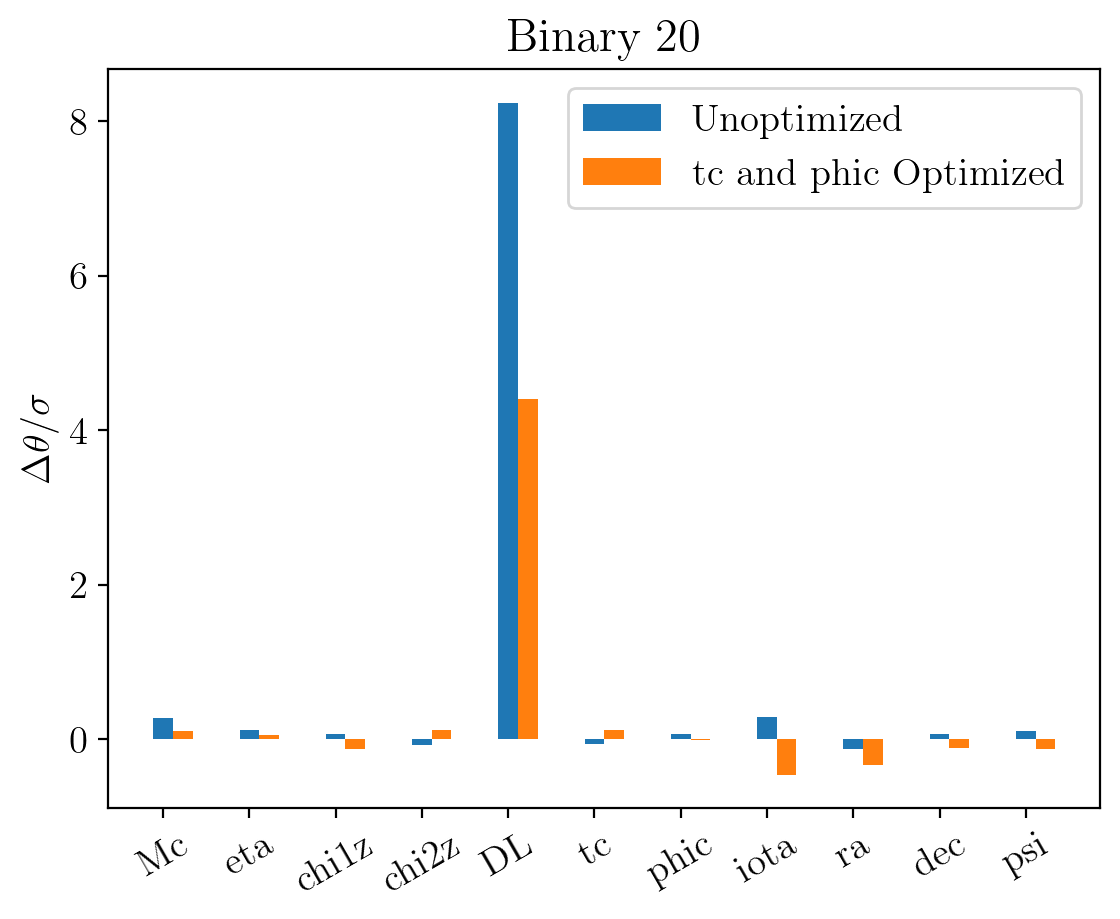

2023-11-21 15:58:32,517 - Network - INFO : Polarizations calculated.
2023-11-21 15:58:32,518 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 15:58:32,527 - Network - INFO : Polarizations calculated.


######  Binary 21  ######


2023-11-21 15:58:33,661 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:58:33,740 - Network - INFO : PSDs loaded.
2023-11-21 15:58:33,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:58:33,776 - Network - INFO : Detector responses calculated.
2023-11-21 15:58:33,777 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:58:33,778 - Network - INFO :    CE-40_C
2023-11-21 15:58:34,536 - Network - INFO :    CE-20_S
2023-11-21 15:58:35,314 - Network - INFO :    ET_ET1
2023-11-21 15:58:36,091 - Network - INFO :    ET_ET2
2023-11-21 15:58:36,865 - Network - INFO :    ET_ET3
2023-11-21 15:58:37,644 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:58:37,648 - Network - INFO : SNRs calculated.
2023-11-21 15:58:37,648 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:58:37,649 - Network - INFO :    CE-40_C
2023-11-21 15:58:37,715 - Network - INFO :

Mc bias diff: 100.47%
Mc, not: 10.074 sigma
Mc, opt: -0.048 sigma

eta bias diff: 97.19%
eta, not: 9.415 sigma
eta, opt: 0.265 sigma

chi1z bias diff: 97.95%
chi1z, not: -14.743 sigma
chi1z, opt: -0.302 sigma

chi2z bias diff: 97.98%
chi2z, not: 14.941 sigma
chi2z, opt: 0.302 sigma

DL bias diff: 83.05%
DL, not: 4.720 sigma
DL, opt: 0.800 sigma

tc bias diff: 98.47%
tc, not: 16.709 sigma
tc, opt: 0.256 sigma

phic bias diff: 98.45%
phic, not: 4.261 sigma
phic, opt: 0.066 sigma

iota bias diff: -1149.94%
iota, not: 0.769 sigma
iota, opt: 9.611 sigma

ra bias diff: 179.64%
ra, not: 0.508 sigma
ra, opt: -0.404 sigma

dec bias diff: -45.20%
dec, not: -0.838 sigma
dec, opt: -1.217 sigma

psi bias diff: 89.14%
psi, not: 0.075 sigma
psi, opt: 0.008 sigma

######  Binary 22  ######


2023-11-21 15:58:44,626 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:58:44,701 - Network - INFO : PSDs loaded.
2023-11-21 15:58:44,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:58:44,748 - Network - INFO : Detector responses calculated.
2023-11-21 15:58:44,749 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:58:44,749 - Network - INFO :    CE-40_C
2023-11-21 15:58:45,641 - Network - INFO :    CE-20_S
2023-11-21 15:58:46,473 - Network - INFO :    ET_ET1
2023-11-21 15:58:47,307 - Network - INFO :    ET_ET2
2023-11-21 15:58:48,139 - Network - INFO :    ET_ET3
2023-11-21 15:58:48,971 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:58:48,975 - Network - INFO : SNRs calculated.
2023-11-21 15:58:48,975 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:58:48,976 - Network - INFO :    CE-40_C
2023-11-21 15:58:49,034 - Network - INFO :

Mc bias diff: 100.23%
Mc, not: 3.741 sigma
Mc, opt: -0.008 sigma

eta bias diff: 99.77%
eta, not: 3.843 sigma
eta, opt: 0.009 sigma

chi1z bias diff: 99.10%
chi1z, not: -4.237 sigma
chi1z, opt: -0.038 sigma

chi2z bias diff: 99.10%
chi2z, not: 4.255 sigma
chi2z, opt: 0.038 sigma

DL bias diff: 46.92%
DL, not: 2.980 sigma
DL, opt: 1.582 sigma

tc bias diff: 99.13%
tc, not: 4.231 sigma
tc, opt: 0.037 sigma

phic bias diff: 98.65%
phic, not: 2.824 sigma
phic, opt: 0.038 sigma

iota bias diff: 30.07%
iota, not: 0.764 sigma
iota, opt: 0.534 sigma

ra bias diff: 86.56%
ra, not: -0.189 sigma
ra, opt: -0.025 sigma

dec bias diff: -127.70%
dec, not: -0.063 sigma
dec, opt: -0.144 sigma

psi bias diff: 103.16%
psi, not: -0.292 sigma
psi, opt: 0.009 sigma

######  Binary 23  ######


2023-11-21 15:58:57,737 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:58:57,785 - Network - INFO : PSDs loaded.
2023-11-21 15:58:57,787 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:58:57,824 - Network - INFO : Detector responses calculated.
2023-11-21 15:58:57,825 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:58:57,826 - Network - INFO :    CE-40_C
2023-11-21 15:58:59,328 - Network - INFO :    CE-20_S
2023-11-21 15:59:00,822 - Network - INFO :    ET_ET1
2023-11-21 15:59:02,248 - Network - INFO :    ET_ET2
2023-11-21 15:59:03,780 - Network - INFO :    ET_ET3
2023-11-21 15:59:05,232 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:59:05,236 - Network - INFO : SNRs calculated.
2023-11-21 15:59:05,236 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:59:05,237 - Network - INFO :    CE-40_C
2023-11-21 15:59:05,295 - Network - INFO :

Mc bias diff: 185.88%
Mc, not: 0.032 sigma
Mc, opt: -0.028 sigma

eta bias diff: 78.93%
eta, not: 0.134 sigma
eta, opt: 0.028 sigma

chi1z bias diff: 94.72%
chi1z, not: 0.694 sigma
chi1z, opt: 0.037 sigma

chi2z bias diff: 94.95%
chi2z, not: -0.740 sigma
chi2z, opt: -0.037 sigma

DL bias diff: 41.27%
DL, not: 9.983 sigma
DL, opt: 5.863 sigma

tc bias diff: 102.13%
tc, not: -0.560 sigma
tc, opt: 0.012 sigma

phic bias diff: 95.92%
phic, not: 0.376 sigma
phic, opt: 0.015 sigma

iota bias diff: 80.97%
iota, not: -0.587 sigma
iota, opt: -0.112 sigma

ra bias diff: 243.54%
ra, not: 0.021 sigma
ra, opt: -0.031 sigma

dec bias diff: 70.75%
dec, not: -0.142 sigma
dec, opt: -0.041 sigma

psi bias diff: 27.30%
psi, not: -0.032 sigma
psi, opt: -0.023 sigma

######  Binary 24  ######


2023-11-21 15:59:17,120 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:59:17,200 - Network - INFO : PSDs loaded.
2023-11-21 15:59:17,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:59:17,237 - Network - INFO : Detector responses calculated.
2023-11-21 15:59:17,238 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:59:17,238 - Network - INFO :    CE-40_C
2023-11-21 15:59:17,984 - Network - INFO :    CE-20_S
2023-11-21 15:59:18,736 - Network - INFO :    ET_ET1
2023-11-21 15:59:19,484 - Network - INFO :    ET_ET2
2023-11-21 15:59:20,233 - Network - INFO :    ET_ET3
2023-11-21 15:59:20,981 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:59:20,985 - Network - INFO : SNRs calculated.
2023-11-21 15:59:20,985 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:59:20,986 - Network - INFO :    CE-40_C
2023-11-21 15:59:21,053 - Network - INFO :

Mc bias diff: 101.27%
Mc, not: 3.024 sigma
Mc, opt: -0.038 sigma

eta bias diff: 114.64%
eta, not: 3.721 sigma
eta, opt: -0.545 sigma

chi1z bias diff: 110.71%
chi1z, not: -4.644 sigma
chi1z, opt: 0.497 sigma

chi2z bias diff: 110.48%
chi2z, not: 4.694 sigma
chi2z, opt: -0.492 sigma

DL bias diff: 58.03%
DL, not: 9.777 sigma
DL, opt: 4.103 sigma

tc bias diff: 110.60%
tc, not: 4.654 sigma
tc, opt: -0.493 sigma

phic bias diff: 110.03%
phic, not: 4.517 sigma
phic, opt: -0.453 sigma

iota bias diff: -676.99%
iota, not: -0.428 sigma
iota, opt: -3.328 sigma

ra bias diff: 77.24%
ra, not: 0.319 sigma
ra, opt: 0.073 sigma

dec bias diff: 205.23%
dec, not: 0.349 sigma
dec, opt: -0.367 sigma

psi bias diff: 2.51%
psi, not: 0.153 sigma
psi, opt: 0.149 sigma

######  Binary 25  ######


2023-11-21 15:59:29,285 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:59:29,333 - Network - INFO : PSDs loaded.
2023-11-21 15:59:29,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:59:29,379 - Network - INFO : Detector responses calculated.
2023-11-21 15:59:29,379 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:59:29,380 - Network - INFO :    CE-40_C
2023-11-21 15:59:31,322 - Network - INFO :    CE-20_S
2023-11-21 15:59:33,220 - Network - INFO :    ET_ET1
2023-11-21 15:59:35,046 - Network - INFO :    ET_ET2
2023-11-21 15:59:36,911 - Network - INFO :    ET_ET3
2023-11-21 15:59:38,725 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 15:59:38,729 - Network - INFO : SNRs calculated.
2023-11-21 15:59:38,729 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 15:59:38,730 - Network - INFO :    CE-40_C
2023-11-21 15:59:38,792 - Network - INFO :

Mc bias diff: 104.00%
Mc, not: -1.044 sigma
Mc, opt: 0.042 sigma

eta bias diff: 112.71%
eta, not: 0.520 sigma
eta, opt: -0.066 sigma

chi1z bias diff: 86.97%
chi1z, not: 0.436 sigma
chi1z, opt: 0.057 sigma

chi2z bias diff: 88.86%
chi2z, not: -0.502 sigma
chi2z, opt: -0.056 sigma

DL bias diff: 60.17%
DL, not: 4.039 sigma
DL, opt: 1.609 sigma

tc bias diff: 86.92%
tc, not: -0.461 sigma
tc, opt: -0.060 sigma

phic bias diff: 100.48%
phic, not: 1.070 sigma
phic, opt: -0.005 sigma

iota bias diff: -1603.64%
iota, not: 0.087 sigma
iota, opt: 1.489 sigma

ra bias diff: 1248.12%
ra, not: 0.051 sigma
ra, opt: -0.585 sigma

dec bias diff: 3243.83%
dec, not: -0.002 sigma
dec, opt: 0.053 sigma

psi bias diff: 99.64%
psi, not: 0.685 sigma
psi, opt: 0.002 sigma

######  Binary 26  ######


2023-11-21 15:59:54,074 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 15:59:54,122 - Network - INFO : PSDs loaded.
2023-11-21 15:59:54,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 15:59:54,158 - Network - INFO : Detector responses calculated.
2023-11-21 15:59:54,159 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 15:59:54,160 - Network - INFO :    CE-40_C
2023-11-21 15:59:55,371 - Network - INFO :    CE-20_S
2023-11-21 15:59:56,653 - Network - INFO :    ET_ET1
2023-11-21 15:59:57,923 - Network - INFO :    ET_ET2
2023-11-21 15:59:59,192 - Network - INFO :    ET_ET3
2023-11-21 16:00:00,485 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:00:00,489 - Network - INFO : SNRs calculated.
2023-11-21 16:00:00,489 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:00:00,490 - Network - INFO :    CE-40_C
2023-11-21 16:00:00,549 - Network - INFO :

Mc bias diff: 98.72%
Mc, not: -4.355 sigma
Mc, opt: -0.056 sigma

eta bias diff: 99.38%
eta, not: 6.636 sigma
eta, opt: 0.041 sigma

chi1z bias diff: 99.49%
chi1z, not: -4.728 sigma
chi1z, opt: -0.024 sigma

chi2z bias diff: 99.56%
chi2z, not: 4.133 sigma
chi2z, opt: 0.018 sigma

DL bias diff: 72.35%
DL, not: 3.724 sigma
DL, opt: 1.030 sigma

tc bias diff: 99.55%
tc, not: 4.265 sigma
tc, opt: 0.019 sigma

phic bias diff: 127.99%
phic, not: 0.225 sigma
phic, opt: -0.063 sigma

iota bias diff: 501.73%
iota, not: -0.452 sigma
iota, opt: 1.817 sigma

ra bias diff: 68.53%
ra, not: -0.199 sigma
ra, opt: -0.063 sigma

dec bias diff: 49.59%
dec, not: 0.249 sigma
dec, opt: 0.125 sigma

psi bias diff: 74.56%
psi, not: -0.267 sigma
psi, opt: -0.068 sigma

######  Binary 27  ######


2023-11-21 16:00:11,766 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:00:11,822 - Network - INFO : PSDs loaded.
2023-11-21 16:00:11,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:00:11,857 - Network - INFO : Detector responses calculated.
2023-11-21 16:00:11,857 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:00:11,858 - Network - INFO :    CE-40_C
2023-11-21 16:00:12,834 - Network - INFO :    CE-20_S
2023-11-21 16:00:13,790 - Network - INFO :    ET_ET1
2023-11-21 16:00:14,714 - Network - INFO :    ET_ET2
2023-11-21 16:00:15,628 - Network - INFO :    ET_ET3
2023-11-21 16:00:16,551 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:00:16,554 - Network - INFO : SNRs calculated.
2023-11-21 16:00:16,554 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:00:16,555 - Network - INFO :    CE-40_C
2023-11-21 16:00:16,612 - Network - INFO :

Mc bias diff: 101.52%
Mc, not: 4.274 sigma
Mc, opt: -0.065 sigma

eta bias diff: 101.39%
eta, not: 3.053 sigma
eta, opt: -0.043 sigma

chi1z bias diff: 101.17%
chi1z, not: -3.895 sigma
chi1z, opt: 0.046 sigma

chi2z bias diff: 101.15%
chi2z, not: 3.948 sigma
chi2z, opt: -0.046 sigma

DL bias diff: 46.15%
DL, not: 17.719 sigma
DL, opt: 9.542 sigma

tc bias diff: 101.16%
tc, not: 3.906 sigma
tc, opt: -0.045 sigma

phic bias diff: 100.36%
phic, not: 3.612 sigma
phic, opt: -0.013 sigma

iota bias diff: 98.15%
iota, not: -0.193 sigma
iota, opt: -0.004 sigma

ra bias diff: -34.29%
ra, not: 0.033 sigma
ra, opt: 0.045 sigma

dec bias diff: 271.53%
dec, not: -0.023 sigma
dec, opt: 0.040 sigma

psi bias diff: 81.36%
psi, not: -0.259 sigma
psi, opt: -0.048 sigma

######  Binary 28  ######


2023-11-21 16:00:26,078 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:00:26,204 - Network - INFO : PSDs loaded.
2023-11-21 16:00:26,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:00:26,238 - Network - INFO : Detector responses calculated.
2023-11-21 16:00:26,238 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:00:26,239 - Network - INFO :    CE-40_C
2023-11-21 16:00:27,448 - Network - INFO :    CE-20_S
2023-11-21 16:00:28,732 - Network - INFO :    ET_ET1
2023-11-21 16:00:29,993 - Network - INFO :    ET_ET2
2023-11-21 16:00:31,260 - Network - INFO :    ET_ET3
2023-11-21 16:00:32,507 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:00:32,510 - Network - INFO : SNRs calculated.
2023-11-21 16:00:32,511 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:00:32,511 - Network - INFO :    CE-40_C
2023-11-21 16:00:32,573 - Network - INFO :

Mc bias diff: 113.69%
Mc, not: 3.998 sigma
Mc, opt: -0.547 sigma

eta bias diff: 142.38%
eta, not: 1.490 sigma
eta, opt: -0.632 sigma

chi1z bias diff: 143.54%
chi1z, not: -2.496 sigma
chi1z, opt: 1.087 sigma

chi2z bias diff: 143.36%
chi2z, not: 2.523 sigma
chi2z, opt: -1.094 sigma

DL bias diff: 43.15%
DL, not: 21.104 sigma
DL, opt: 11.998 sigma

tc bias diff: 144.37%
tc, not: 2.464 sigma
tc, opt: -1.093 sigma

phic bias diff: 143.92%
phic, not: 2.089 sigma
phic, opt: -0.918 sigma

iota bias diff: 69.49%
iota, not: 1.312 sigma
iota, opt: 0.400 sigma

ra bias diff: 214.27%
ra, not: 0.604 sigma
ra, opt: -0.690 sigma

dec bias diff: 96.99%
dec, not: -0.455 sigma
dec, opt: -0.014 sigma

psi bias diff: -35.94%
psi, not: 0.478 sigma
psi, opt: 0.650 sigma

######  Binary 29  ######


2023-11-21 16:00:43,806 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:00:43,854 - Network - INFO : PSDs loaded.
2023-11-21 16:00:43,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:00:43,891 - Network - INFO : Detector responses calculated.
2023-11-21 16:00:43,891 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:00:43,892 - Network - INFO :    CE-40_C
2023-11-21 16:00:45,311 - Network - INFO :    CE-20_S
2023-11-21 16:00:46,696 - Network - INFO :    ET_ET1
2023-11-21 16:00:48,102 - Network - INFO :    ET_ET2
2023-11-21 16:00:49,498 - Network - INFO :    ET_ET3
2023-11-21 16:00:51,007 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:00:51,011 - Network - INFO : SNRs calculated.
2023-11-21 16:00:51,011 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:00:51,011 - Network - INFO :    CE-40_C
2023-11-21 16:00:51,067 - Network - INFO :

Mc bias diff: 109.13%
Mc, not: 0.368 sigma
Mc, opt: -0.034 sigma

eta bias diff: 102.20%
eta, not: 1.590 sigma
eta, opt: -0.035 sigma

chi1z bias diff: 103.22%
chi1z, not: -1.640 sigma
chi1z, opt: 0.053 sigma

chi2z bias diff: 103.44%
chi2z, not: 1.631 sigma
chi2z, opt: -0.056 sigma

DL bias diff: 42.09%
DL, not: 20.940 sigma
DL, opt: 12.126 sigma

tc bias diff: 103.52%
tc, not: 1.662 sigma
tc, opt: -0.059 sigma

phic bias diff: 101.21%
phic, not: 2.380 sigma
phic, opt: -0.029 sigma

iota bias diff: 88.78%
iota, not: -0.722 sigma
iota, opt: -0.081 sigma

ra bias diff: 49.81%
ra, not: 0.079 sigma
ra, opt: 0.039 sigma

dec bias diff: 90.12%
dec, not: 0.275 sigma
dec, opt: 0.027 sigma

psi bias diff: 134.90%
psi, not: 0.016 sigma
psi, opt: -0.006 sigma

######  Binary 30  ######


2023-11-21 16:01:02,649 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:01:02,705 - Network - INFO : PSDs loaded.
2023-11-21 16:01:02,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:01:02,743 - Network - INFO : Detector responses calculated.
2023-11-21 16:01:02,744 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:01:02,745 - Network - INFO :    CE-40_C
2023-11-21 16:01:03,708 - Network - INFO :    CE-20_S
2023-11-21 16:01:04,627 - Network - INFO :    ET_ET1
2023-11-21 16:01:05,591 - Network - INFO :    ET_ET2
2023-11-21 16:01:06,495 - Network - INFO :    ET_ET3
2023-11-21 16:01:07,385 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:01:07,388 - Network - INFO : SNRs calculated.
2023-11-21 16:01:07,388 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:01:07,389 - Network - INFO :    CE-40_C
2023-11-21 16:01:07,444 - Network - INFO :

Mc bias diff: 92.19%
Mc, not: -3.967 sigma
Mc, opt: -0.310 sigma

eta bias diff: 99.78%
eta, not: 16.298 sigma
eta, opt: 0.036 sigma

chi1z bias diff: 100.71%
chi1z, not: -20.978 sigma
chi1z, opt: 0.149 sigma

chi2z bias diff: 101.37%
chi2z, not: 18.197 sigma
chi2z, opt: -0.250 sigma

DL bias diff: 30.75%
DL, not: 1.143 sigma
DL, opt: 0.792 sigma

tc bias diff: 101.42%
tc, not: 17.871 sigma
tc, opt: -0.254 sigma

phic bias diff: 96.18%
phic, not: 1.924 sigma
phic, opt: 0.074 sigma

iota bias diff: -60.60%
iota, not: 2.429 sigma
iota, opt: 3.901 sigma

ra bias diff: 83.29%
ra, not: 1.833 sigma
ra, opt: 0.306 sigma

dec bias diff: -284.96%
dec, not: 0.201 sigma
dec, opt: 0.775 sigma

psi bias diff: 94.82%
psi, not: 1.448 sigma
psi, opt: 0.075 sigma



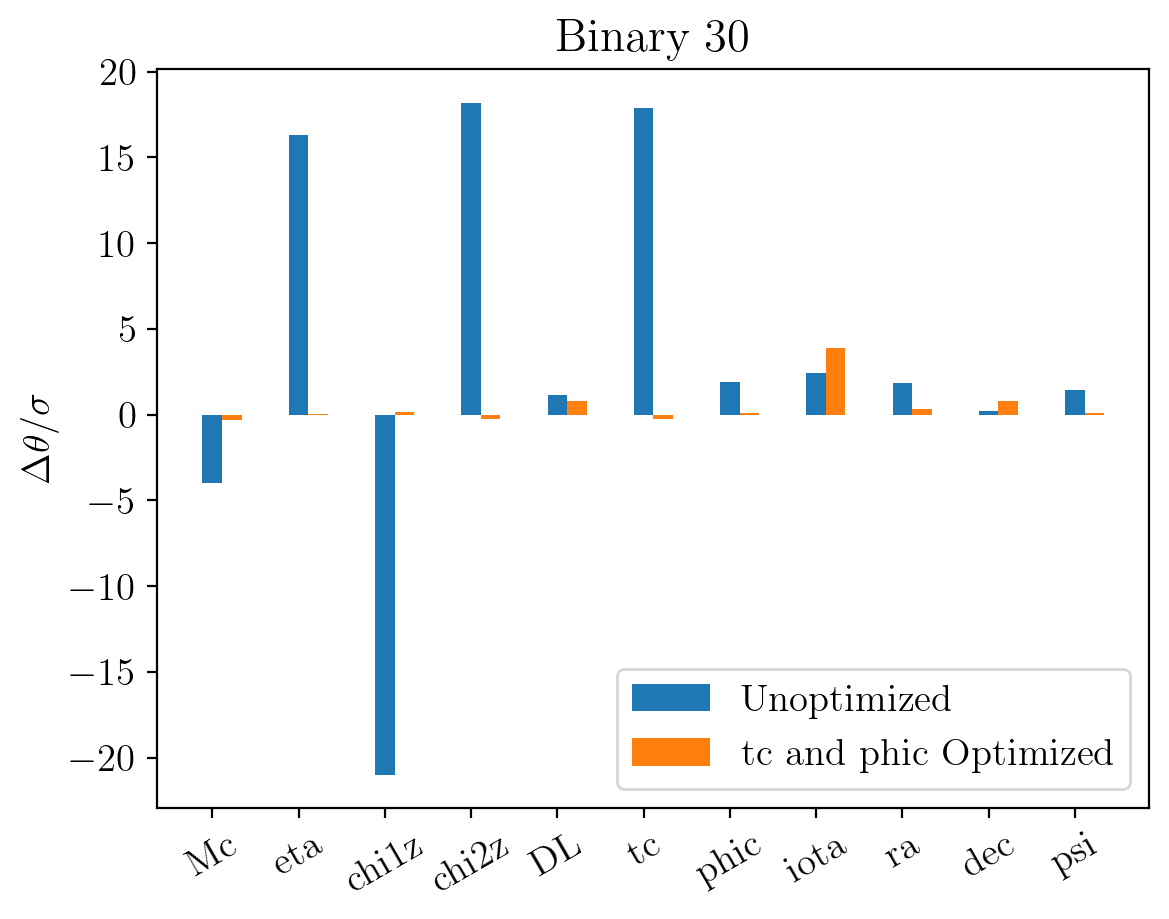

2023-11-21 16:01:15,404 - Network - INFO : Polarizations calculated.
2023-11-21 16:01:15,405 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 16:01:15,412 - Network - INFO : Polarizations calculated.


######  Binary 31  ######


2023-11-21 16:01:16,607 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:01:16,682 - Network - INFO : PSDs loaded.
2023-11-21 16:01:16,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:01:16,713 - Network - INFO : Detector responses calculated.
2023-11-21 16:01:16,714 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:01:16,715 - Network - INFO :    CE-40_C
2023-11-21 16:01:17,538 - Network - INFO :    CE-20_S
2023-11-21 16:01:18,369 - Network - INFO :    ET_ET1
2023-11-21 16:01:19,171 - Network - INFO :    ET_ET2
2023-11-21 16:01:19,974 - Network - INFO :    ET_ET3
2023-11-21 16:01:20,783 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:01:20,787 - Network - INFO : SNRs calculated.
2023-11-21 16:01:20,788 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:01:20,788 - Network - INFO :    CE-40_C
2023-11-21 16:01:20,848 - Network - INFO :

Mc bias diff: 102.36%
Mc, not: 5.498 sigma
Mc, opt: -0.130 sigma

eta bias diff: 99.55%
eta, not: 7.946 sigma
eta, opt: 0.036 sigma

chi1z bias diff: 99.62%
chi1z, not: -11.724 sigma
chi1z, opt: -0.044 sigma

chi2z bias diff: 99.64%
chi2z, not: 12.219 sigma
chi2z, opt: 0.044 sigma

DL bias diff: 50.97%
DL, not: 5.367 sigma
DL, opt: 2.632 sigma

tc bias diff: 99.67%
tc, not: 12.325 sigma
tc, opt: 0.041 sigma

phic bias diff: 97.55%
phic, not: 7.552 sigma
phic, opt: 0.185 sigma

iota bias diff: -67.71%
iota, not: -0.552 sigma
iota, opt: -0.926 sigma

ra bias diff: -114.18%
ra, not: 0.170 sigma
ra, opt: 0.364 sigma

dec bias diff: -660.17%
dec, not: 0.051 sigma
dec, opt: 0.390 sigma

psi bias diff: 89.90%
psi, not: -1.632 sigma
psi, opt: -0.165 sigma

######  Binary 32  ######


2023-11-21 16:01:27,534 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:01:27,712 - Network - INFO : PSDs loaded.
2023-11-21 16:01:27,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:01:27,741 - Network - INFO : Detector responses calculated.
2023-11-21 16:01:27,741 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:01:27,742 - Network - INFO :    CE-40_C
2023-11-21 16:01:28,256 - Network - INFO :    CE-20_S
2023-11-21 16:01:28,791 - Network - INFO :    ET_ET1
2023-11-21 16:01:29,350 - Network - INFO :    ET_ET2
2023-11-21 16:01:29,931 - Network - INFO :    ET_ET3
2023-11-21 16:01:30,499 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:01:30,503 - Network - INFO : SNRs calculated.
2023-11-21 16:01:30,503 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:01:30,504 - Network - INFO :    CE-40_C
2023-11-21 16:01:30,585 - Network - INFO :

Mc bias diff: 104.78%
Mc, not: -3.089 sigma
Mc, opt: 0.148 sigma

eta bias diff: 101.61%
eta, not: 6.690 sigma
eta, opt: -0.108 sigma

chi1z bias diff: 102.24%
chi1z, not: -6.921 sigma
chi1z, opt: 0.155 sigma

chi2z bias diff: 102.22%
chi2z, not: 6.986 sigma
chi2z, opt: -0.155 sigma

DL bias diff: 47.79%
DL, not: 8.023 sigma
DL, opt: 4.188 sigma

tc bias diff: 102.26%
tc, not: 6.909 sigma
tc, opt: -0.156 sigma

phic bias diff: 102.50%
phic, not: 6.727 sigma
phic, opt: -0.168 sigma

iota bias diff: -901.61%
iota, not: 0.108 sigma
iota, opt: 1.082 sigma

ra bias diff: 634.35%
ra, not: -0.274 sigma
ra, opt: 1.462 sigma

dec bias diff: 345.02%
dec, not: 0.608 sigma
dec, opt: -1.490 sigma

psi bias diff: 19.64%
psi, not: -0.533 sigma
psi, opt: -0.428 sigma

######  Binary 33  ######


2023-11-21 16:01:37,453 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:01:37,503 - Network - INFO : PSDs loaded.
2023-11-21 16:01:37,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:01:37,546 - Network - INFO : Detector responses calculated.
2023-11-21 16:01:37,547 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:01:37,547 - Network - INFO :    CE-40_C
2023-11-21 16:01:39,266 - Network - INFO :    CE-20_S
2023-11-21 16:01:40,821 - Network - INFO :    ET_ET1
2023-11-21 16:01:42,360 - Network - INFO :    ET_ET2
2023-11-21 16:01:43,844 - Network - INFO :    ET_ET3
2023-11-21 16:01:45,323 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:01:45,327 - Network - INFO : SNRs calculated.
2023-11-21 16:01:45,327 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:01:45,328 - Network - INFO :    CE-40_C
2023-11-21 16:01:45,385 - Network - INFO :

Mc bias diff: 104.34%
Mc, not: -0.588 sigma
Mc, opt: 0.025 sigma

eta bias diff: 101.60%
eta, not: 0.891 sigma
eta, opt: -0.014 sigma

chi1z bias diff: 101.01%
chi1z, not: -0.599 sigma
chi1z, opt: 0.006 sigma

chi2z bias diff: 100.91%
chi2z, not: 0.573 sigma
chi2z, opt: -0.005 sigma

DL bias diff: 44.49%
DL, not: 13.410 sigma
DL, opt: 7.444 sigma

tc bias diff: 101.03%
tc, not: 0.595 sigma
tc, opt: -0.006 sigma

phic bias diff: 102.96%
phic, not: 0.863 sigma
phic, opt: -0.026 sigma

iota bias diff: 101.49%
iota, not: 0.130 sigma
iota, opt: -0.002 sigma

ra bias diff: 97.99%
ra, not: 0.091 sigma
ra, opt: 0.002 sigma

dec bias diff: 107.30%
dec, not: 0.053 sigma
dec, opt: -0.004 sigma

psi bias diff: 95.35%
psi, not: 0.325 sigma
psi, opt: 0.015 sigma

######  Binary 34  ######


2023-11-21 16:01:57,747 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:01:57,794 - Network - INFO : PSDs loaded.
2023-11-21 16:01:57,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:01:57,829 - Network - INFO : Detector responses calculated.
2023-11-21 16:01:57,830 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:01:57,830 - Network - INFO :    CE-40_C
2023-11-21 16:01:58,958 - Network - INFO :    CE-20_S
2023-11-21 16:02:00,151 - Network - INFO :    ET_ET1
2023-11-21 16:02:01,302 - Network - INFO :    ET_ET2
2023-11-21 16:02:02,496 - Network - INFO :    ET_ET3
2023-11-21 16:02:03,678 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:02:03,682 - Network - INFO : SNRs calculated.
2023-11-21 16:02:03,682 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:02:03,683 - Network - INFO :    CE-40_C
2023-11-21 16:02:03,745 - Network - INFO :

Mc bias diff: 102.00%
Mc, not: 2.888 sigma
Mc, opt: -0.058 sigma

eta bias diff: 103.08%
eta, not: 1.674 sigma
eta, opt: -0.052 sigma

chi1z bias diff: 103.11%
chi1z, not: -2.355 sigma
chi1z, opt: 0.073 sigma

chi2z bias diff: 103.11%
chi2z, not: 2.372 sigma
chi2z, opt: -0.074 sigma

DL bias diff: 51.50%
DL, not: 3.350 sigma
DL, opt: 1.625 sigma

tc bias diff: 103.04%
tc, not: 2.332 sigma
tc, opt: -0.071 sigma

phic bias diff: 140.53%
phic, not: 0.374 sigma
phic, opt: -0.152 sigma

iota bias diff: -2417.23%
iota, not: -0.018 sigma
iota, opt: -0.444 sigma

ra bias diff: 51.52%
ra, not: 0.432 sigma
ra, opt: 0.210 sigma

dec bias diff: 34.93%
dec, not: -0.318 sigma
dec, opt: -0.207 sigma

psi bias diff: -392.45%
psi, not: 0.030 sigma
psi, opt: 0.149 sigma

######  Binary 35  ######


2023-11-21 16:02:13,723 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:02:13,799 - Network - INFO : PSDs loaded.
2023-11-21 16:02:13,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:02:13,836 - Network - INFO : Detector responses calculated.
2023-11-21 16:02:13,837 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:02:13,838 - Network - INFO :    CE-40_C
2023-11-21 16:02:14,764 - Network - INFO :    CE-20_S
2023-11-21 16:02:15,631 - Network - INFO :    ET_ET1
2023-11-21 16:02:16,496 - Network - INFO :    ET_ET2
2023-11-21 16:02:17,405 - Network - INFO :    ET_ET3
2023-11-21 16:02:18,274 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:02:18,276 - Network - INFO : SNRs calculated.
2023-11-21 16:02:18,277 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:02:18,277 - Network - INFO :    CE-40_C
2023-11-21 16:02:18,335 - Network - INFO :

Mc bias diff: 101.49%
Mc, not: 6.687 sigma
Mc, opt: -0.100 sigma

eta bias diff: 100.12%
eta, not: 5.840 sigma
eta, opt: -0.007 sigma

chi1z bias diff: 100.00%
chi1z, not: -7.441 sigma
chi1z, opt: -0.000 sigma

chi2z bias diff: 100.00%
chi2z, not: 7.475 sigma
chi2z, opt: 0.000 sigma

DL bias diff: 38.52%
DL, not: 6.955 sigma
DL, opt: 4.275 sigma

tc bias diff: 99.94%
tc, not: 7.902 sigma
tc, opt: 0.005 sigma

phic bias diff: 98.63%
phic, not: 6.165 sigma
phic, opt: 0.085 sigma

iota bias diff: 71.20%
iota, not: 1.371 sigma
iota, opt: 0.395 sigma

ra bias diff: 124.18%
ra, not: 0.401 sigma
ra, opt: -0.097 sigma

dec bias diff: 186.86%
dec, not: -0.104 sigma
dec, opt: 0.090 sigma

psi bias diff: -19.54%
psi, not: 0.069 sigma
psi, opt: 0.082 sigma

######  Binary 36  ######


2023-11-21 16:02:27,686 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:02:27,732 - Network - INFO : PSDs loaded.
2023-11-21 16:02:27,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:02:27,778 - Network - INFO : Detector responses calculated.
2023-11-21 16:02:27,779 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:02:27,780 - Network - INFO :    CE-40_C
2023-11-21 16:02:29,675 - Network - INFO :    CE-20_S
2023-11-21 16:02:31,497 - Network - INFO :    ET_ET1
2023-11-21 16:02:33,288 - Network - INFO :    ET_ET2
2023-11-21 16:02:35,109 - Network - INFO :    ET_ET3
2023-11-21 16:02:36,906 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:02:36,910 - Network - INFO : SNRs calculated.
2023-11-21 16:02:36,911 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:02:36,911 - Network - INFO :    CE-40_C
2023-11-21 16:02:36,972 - Network - INFO :

Mc bias diff: 99.74%
Mc, not: -7.578 sigma
Mc, opt: -0.020 sigma

eta bias diff: 99.66%
eta, not: 6.843 sigma
eta, opt: 0.023 sigma

chi1z bias diff: 99.75%
chi1z, not: -4.446 sigma
chi1z, opt: -0.011 sigma

chi2z bias diff: 99.75%
chi2z, not: 4.342 sigma
chi2z, opt: 0.011 sigma

DL bias diff: 36.56%
DL, not: 2.512 sigma
DL, opt: 1.594 sigma

tc bias diff: 99.69%
tc, not: 4.922 sigma
tc, opt: 0.015 sigma

phic bias diff: 44.27%
phic, not: 0.127 sigma
phic, opt: 0.071 sigma

iota bias diff: 27.44%
iota, not: 0.948 sigma
iota, opt: 0.688 sigma

ra bias diff: -393.69%
ra, not: -0.054 sigma
ra, opt: -0.266 sigma

dec bias diff: 139.68%
dec, not: 0.117 sigma
dec, opt: -0.046 sigma

psi bias diff: 112.03%
psi, not: -0.578 sigma
psi, opt: 0.070 sigma

######  Binary 37  ######


2023-11-21 16:02:52,695 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:02:52,741 - Network - INFO : PSDs loaded.
2023-11-21 16:02:52,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:02:52,786 - Network - INFO : Detector responses calculated.
2023-11-21 16:02:52,786 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:02:52,787 - Network - INFO :    CE-40_C
2023-11-21 16:02:54,584 - Network - INFO :    CE-20_S
2023-11-21 16:02:56,308 - Network - INFO :    ET_ET1
2023-11-21 16:02:58,062 - Network - INFO :    ET_ET2
2023-11-21 16:02:59,783 - Network - INFO :    ET_ET3
2023-11-21 16:03:01,547 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:03:01,551 - Network - INFO : SNRs calculated.
2023-11-21 16:03:01,551 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:03:01,552 - Network - INFO :    CE-40_C
2023-11-21 16:03:01,612 - Network - INFO :

Mc bias diff: 99.93%
Mc, not: -1.110 sigma
Mc, opt: -0.001 sigma

eta bias diff: 101.37%
eta, not: 1.233 sigma
eta, opt: -0.017 sigma

chi1z bias diff: 102.22%
chi1z, not: -1.001 sigma
chi1z, opt: 0.022 sigma

chi2z bias diff: 102.55%
chi2z, not: 0.924 sigma
chi2z, opt: -0.024 sigma

DL bias diff: 42.59%
DL, not: 10.836 sigma
DL, opt: 6.221 sigma

tc bias diff: 102.69%
tc, not: 0.920 sigma
tc, opt: -0.025 sigma

phic bias diff: 99.23%
phic, not: 1.792 sigma
phic, opt: 0.014 sigma

iota bias diff: 86.42%
iota, not: -0.449 sigma
iota, opt: -0.061 sigma

ra bias diff: 119.70%
ra, not: 0.088 sigma
ra, opt: -0.017 sigma

dec bias diff: 73.96%
dec, not: 0.090 sigma
dec, opt: 0.023 sigma

psi bias diff: 106.66%
psi, not: 0.026 sigma
psi, opt: -0.002 sigma

######  Binary 38  ######


2023-11-21 16:03:15,496 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:03:15,548 - Network - INFO : PSDs loaded.
2023-11-21 16:03:15,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:03:15,584 - Network - INFO : Detector responses calculated.
2023-11-21 16:03:15,585 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:03:15,586 - Network - INFO :    CE-40_C
2023-11-21 16:03:16,569 - Network - INFO :    CE-20_S
2023-11-21 16:03:17,529 - Network - INFO :    ET_ET1
2023-11-21 16:03:18,504 - Network - INFO :    ET_ET2
2023-11-21 16:03:19,468 - Network - INFO :    ET_ET3
2023-11-21 16:03:20,436 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:03:20,439 - Network - INFO : SNRs calculated.
2023-11-21 16:03:20,440 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:03:20,440 - Network - INFO :    CE-40_C
2023-11-21 16:03:20,493 - Network - INFO :

Mc bias diff: 102.46%
Mc, not: 8.576 sigma
Mc, opt: -0.211 sigma

eta bias diff: 104.47%
eta, not: 4.528 sigma
eta, opt: -0.202 sigma

chi1z bias diff: 103.55%
chi1z, not: -6.555 sigma
chi1z, opt: 0.232 sigma

chi2z bias diff: 103.49%
chi2z, not: 6.692 sigma
chi2z, opt: -0.233 sigma

DL bias diff: 91.27%
DL, not: 4.497 sigma
DL, opt: 0.393 sigma

tc bias diff: 103.48%
tc, not: 6.657 sigma
tc, opt: -0.231 sigma

phic bias diff: 108.85%
phic, not: 1.547 sigma
phic, opt: -0.137 sigma

iota bias diff: 12380.74%
iota, not: -0.079 sigma
iota, opt: 9.762 sigma

ra bias diff: 32.43%
ra, not: -0.485 sigma
ra, opt: -0.328 sigma

dec bias diff: -115.30%
dec, not: 0.168 sigma
dec, opt: 0.362 sigma

psi bias diff: 141.42%
psi, not: 0.256 sigma
psi, opt: -0.106 sigma

######  Binary 39  ######


2023-11-21 16:03:29,424 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:03:29,475 - Network - INFO : PSDs loaded.
2023-11-21 16:03:29,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:03:29,507 - Network - INFO : Detector responses calculated.
2023-11-21 16:03:29,507 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:03:29,508 - Network - INFO :    CE-40_C
2023-11-21 16:03:30,519 - Network - INFO :    CE-20_S
2023-11-21 16:03:31,575 - Network - INFO :    ET_ET1
2023-11-21 16:03:32,606 - Network - INFO :    ET_ET2
2023-11-21 16:03:33,666 - Network - INFO :    ET_ET3
2023-11-21 16:03:34,711 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:03:34,714 - Network - INFO : SNRs calculated.
2023-11-21 16:03:34,715 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:03:34,715 - Network - INFO :    CE-40_C
2023-11-21 16:03:34,779 - Network - INFO :

Mc bias diff: 100.43%
Mc, not: 3.570 sigma
Mc, opt: -0.015 sigma

eta bias diff: 99.49%
eta, not: 3.247 sigma
eta, opt: 0.017 sigma

chi1z bias diff: 99.54%
chi1z, not: -3.031 sigma
chi1z, opt: -0.014 sigma

chi2z bias diff: 99.55%
chi2z, not: 3.057 sigma
chi2z, opt: 0.014 sigma

DL bias diff: 220.05%
DL, not: 0.116 sigma
DL, opt: -0.140 sigma

tc bias diff: 99.53%
tc, not: 3.212 sigma
tc, opt: 0.015 sigma

phic bias diff: 123.04%
phic, not: -0.444 sigma
phic, opt: 0.102 sigma

iota bias diff: 41.71%
iota, not: -3.000 sigma
iota, opt: -1.749 sigma

ra bias diff: 94.71%
ra, not: 0.247 sigma
ra, opt: 0.013 sigma

dec bias diff: 105.06%
dec, not: 0.032 sigma
dec, opt: -0.002 sigma

psi bias diff: 123.57%
psi, not: 0.434 sigma
psi, opt: -0.102 sigma

######  Binary 40  ######


2023-11-21 16:03:43,565 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:03:43,641 - Network - INFO : PSDs loaded.
2023-11-21 16:03:43,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:03:43,693 - Network - INFO : Detector responses calculated.
2023-11-21 16:03:43,694 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:03:43,694 - Network - INFO :    CE-40_C
2023-11-21 16:03:44,444 - Network - INFO :    CE-20_S
2023-11-21 16:03:45,185 - Network - INFO :    ET_ET1
2023-11-21 16:03:45,928 - Network - INFO :    ET_ET2
2023-11-21 16:03:46,672 - Network - INFO :    ET_ET3
2023-11-21 16:03:47,416 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:03:47,419 - Network - INFO : SNRs calculated.
2023-11-21 16:03:47,420 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:03:47,421 - Network - INFO :    CE-40_C
2023-11-21 16:03:47,493 - Network - INFO :

Mc bias diff: 123.59%
Mc, not: 0.080 sigma
Mc, opt: -0.019 sigma

eta bias diff: 101.79%
eta, not: 4.124 sigma
eta, opt: -0.074 sigma

chi1z bias diff: 106.96%
chi1z, not: -2.345 sigma
chi1z, opt: 0.163 sigma

chi2z bias diff: 106.38%
chi2z, not: 2.525 sigma
chi2z, opt: -0.161 sigma

DL bias diff: 50.64%
DL, not: 6.721 sigma
DL, opt: 3.317 sigma

tc bias diff: 104.60%
tc, not: 3.127 sigma
tc, opt: -0.144 sigma

phic bias diff: 101.41%
phic, not: 2.865 sigma
phic, opt: -0.040 sigma

iota bias diff: -212.12%
iota, not: -0.231 sigma
iota, opt: -0.722 sigma

ra bias diff: 3707.70%
ra, not: -0.008 sigma
ra, opt: 0.301 sigma

dec bias diff: 1532.77%
dec, not: 0.034 sigma
dec, opt: -0.493 sigma

psi bias diff: -24.32%
psi, not: -0.233 sigma
psi, opt: -0.289 sigma



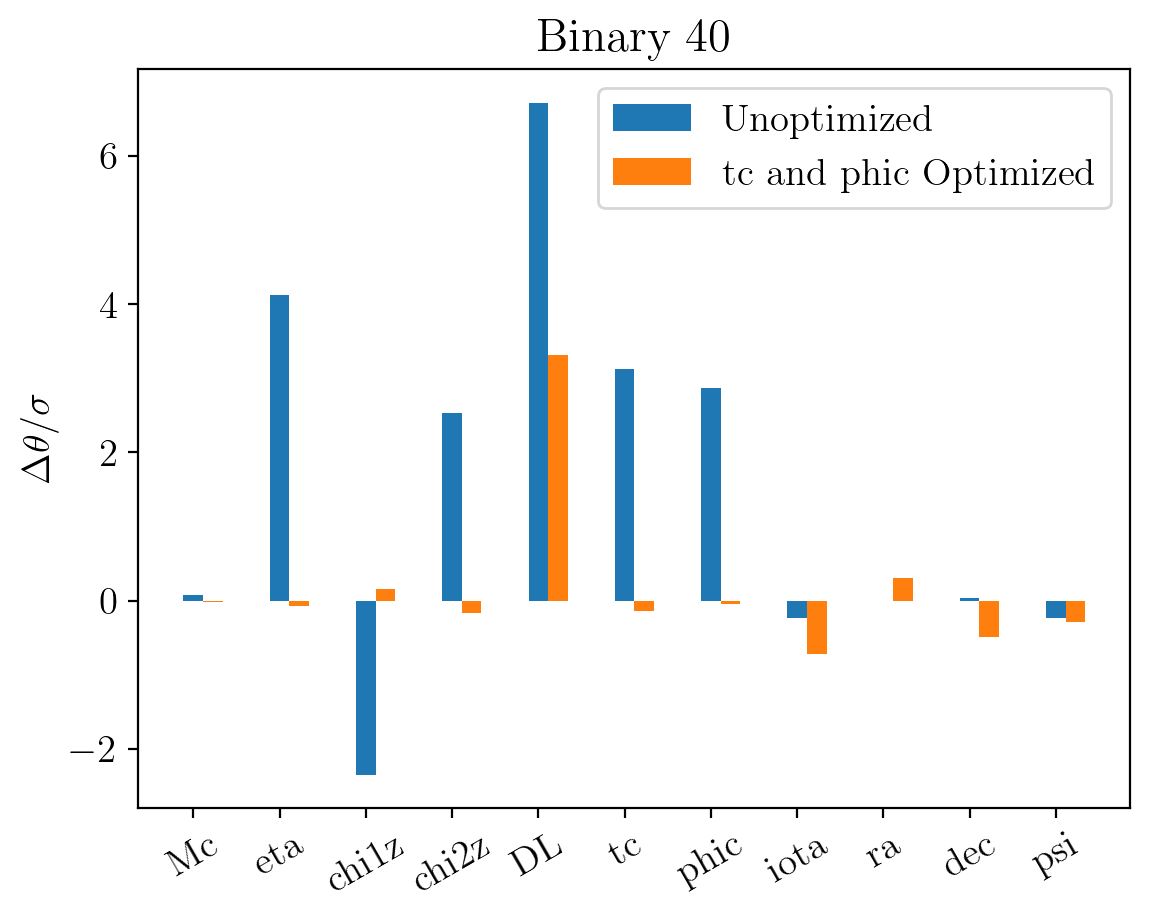

2023-11-21 16:03:53,256 - Network - INFO : Polarizations calculated.
2023-11-21 16:03:53,257 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 16:03:53,269 - Network - INFO : Polarizations calculated.


######  Binary 41  ######


2023-11-21 16:03:55,650 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:03:55,700 - Network - INFO : PSDs loaded.
2023-11-21 16:03:55,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:03:55,741 - Network - INFO : Detector responses calculated.
2023-11-21 16:03:55,742 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:03:55,743 - Network - INFO :    CE-40_C
2023-11-21 16:03:57,252 - Network - INFO :    CE-20_S
2023-11-21 16:03:58,738 - Network - INFO :    ET_ET1
2023-11-21 16:04:00,164 - Network - INFO :    ET_ET2
2023-11-21 16:04:01,677 - Network - INFO :    ET_ET3
2023-11-21 16:04:03,146 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:04:03,150 - Network - INFO : SNRs calculated.
2023-11-21 16:04:03,150 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:04:03,151 - Network - INFO :    CE-40_C
2023-11-21 16:04:03,209 - Network - INFO :

Mc bias diff: 96.35%
Mc, not: -0.202 sigma
Mc, opt: -0.007 sigma

eta bias diff: 99.99%
eta, not: 1.047 sigma
eta, opt: 0.000 sigma

chi1z bias diff: 100.64%
chi1z, not: -1.037 sigma
chi1z, opt: 0.007 sigma

chi2z bias diff: 100.72%
chi2z, not: 1.020 sigma
chi2z, opt: -0.007 sigma

DL bias diff: 46.74%
DL, not: 6.448 sigma
DL, opt: 3.435 sigma

tc bias diff: 101.36%
tc, not: 0.957 sigma
tc, opt: -0.013 sigma

phic bias diff: 99.68%
phic, not: 0.395 sigma
phic, opt: 0.001 sigma

iota bias diff: -1325.53%
iota, not: -0.018 sigma
iota, opt: -0.261 sigma

ra bias diff: 1749.28%
ra, not: 0.008 sigma
ra, opt: -0.126 sigma

dec bias diff: -1717.33%
dec, not: 0.007 sigma
dec, opt: 0.136 sigma

psi bias diff: 101.72%
psi, not: 0.685 sigma
psi, opt: -0.012 sigma

######  Binary 42  ######


2023-11-21 16:04:15,713 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:04:15,760 - Network - INFO : PSDs loaded.
2023-11-21 16:04:15,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:04:15,795 - Network - INFO : Detector responses calculated.
2023-11-21 16:04:15,795 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:04:15,796 - Network - INFO :    CE-40_C
2023-11-21 16:04:16,970 - Network - INFO :    CE-20_S
2023-11-21 16:04:18,227 - Network - INFO :    ET_ET1
2023-11-21 16:04:19,452 - Network - INFO :    ET_ET2
2023-11-21 16:04:20,675 - Network - INFO :    ET_ET3
2023-11-21 16:04:21,898 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:04:21,902 - Network - INFO : SNRs calculated.
2023-11-21 16:04:21,902 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:04:21,903 - Network - INFO :    CE-40_C
2023-11-21 16:04:21,965 - Network - INFO :

Mc bias diff: 100.62%
Mc, not: 0.521 sigma
Mc, opt: -0.003 sigma

eta bias diff: 99.55%
eta, not: 2.347 sigma
eta, opt: 0.011 sigma

chi1z bias diff: 98.15%
chi1z, not: -2.114 sigma
chi1z, opt: -0.039 sigma

chi2z bias diff: 97.88%
chi2z, not: 2.039 sigma
chi2z, opt: 0.043 sigma

DL bias diff: 68.67%
DL, not: 2.125 sigma
DL, opt: 0.666 sigma

tc bias diff: 97.98%
tc, not: 2.040 sigma
tc, opt: 0.041 sigma

phic bias diff: 81.61%
phic, not: 0.893 sigma
phic, opt: 0.164 sigma

iota bias diff: -160.36%
iota, not: 0.700 sigma
iota, opt: 1.822 sigma

ra bias diff: 5106.24%
ra, not: 0.010 sigma
ra, opt: -0.522 sigma

dec bias diff: 44.10%
dec, not: 0.251 sigma
dec, opt: 0.140 sigma

psi bias diff: 69.59%
psi, not: 0.499 sigma
psi, opt: 0.152 sigma

######  Binary 43  ######


2023-11-21 16:04:33,025 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:04:33,071 - Network - INFO : PSDs loaded.
2023-11-21 16:04:33,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:04:33,112 - Network - INFO : Detector responses calculated.
2023-11-21 16:04:33,112 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:04:33,113 - Network - INFO :    CE-40_C
2023-11-21 16:04:34,533 - Network - INFO :    CE-20_S
2023-11-21 16:04:35,963 - Network - INFO :    ET_ET1
2023-11-21 16:04:37,432 - Network - INFO :    ET_ET2
2023-11-21 16:04:38,888 - Network - INFO :    ET_ET3
2023-11-21 16:04:40,337 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:04:40,340 - Network - INFO : SNRs calculated.
2023-11-21 16:04:40,341 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:04:40,341 - Network - INFO :    CE-40_C
2023-11-21 16:04:40,399 - Network - INFO :

Mc bias diff: 98.86%
Mc, not: -1.368 sigma
Mc, opt: -0.016 sigma

eta bias diff: 100.92%
eta, not: 1.619 sigma
eta, opt: -0.015 sigma

chi1z bias diff: 103.05%
chi1z, not: -0.969 sigma
chi1z, opt: 0.030 sigma

chi2z bias diff: 103.59%
chi2z, not: 0.875 sigma
chi2z, opt: -0.031 sigma

DL bias diff: 88.98%
DL, not: 1.960 sigma
DL, opt: 0.216 sigma

tc bias diff: 103.48%
tc, not: 0.916 sigma
tc, opt: -0.032 sigma

phic bias diff: 53.56%
phic, not: 0.133 sigma
phic, opt: 0.062 sigma

iota bias diff: -3243.05%
iota, not: 0.100 sigma
iota, opt: 3.353 sigma

ra bias diff: -70.51%
ra, not: 0.100 sigma
ra, opt: 0.170 sigma

dec bias diff: 19.65%
dec, not: 0.207 sigma
dec, opt: 0.166 sigma

psi bias diff: -101.83%
psi, not: 0.031 sigma
psi, opt: 0.063 sigma

######  Binary 44  ######


2023-11-21 16:04:53,758 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:04:53,804 - Network - INFO : PSDs loaded.
2023-11-21 16:04:53,807 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:04:53,850 - Network - INFO : Detector responses calculated.
2023-11-21 16:04:53,851 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:04:53,852 - Network - INFO :    CE-40_C
2023-11-21 16:04:55,769 - Network - INFO :    CE-20_S
2023-11-21 16:04:57,634 - Network - INFO :    ET_ET1
2023-11-21 16:04:59,496 - Network - INFO :    ET_ET2
2023-11-21 16:05:01,357 - Network - INFO :    ET_ET3
2023-11-21 16:05:03,222 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:05:03,226 - Network - INFO : SNRs calculated.
2023-11-21 16:05:03,226 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:05:03,227 - Network - INFO :    CE-40_C
2023-11-21 16:05:03,290 - Network - INFO :

Mc bias diff: 102.98%
Mc, not: -0.799 sigma
Mc, opt: 0.024 sigma

eta bias diff: 102.69%
eta, not: 0.650 sigma
eta, opt: -0.018 sigma

chi1z bias diff: 104.61%
chi1z, not: -0.314 sigma
chi1z, opt: 0.014 sigma

chi2z bias diff: 105.15%
chi2z, not: 0.271 sigma
chi2z, opt: -0.014 sigma

DL bias diff: 44.01%
DL, not: 17.464 sigma
DL, opt: 9.778 sigma

tc bias diff: 105.12%
tc, not: 0.274 sigma
tc, opt: -0.014 sigma

phic bias diff: 102.60%
phic, not: 1.141 sigma
phic, opt: -0.030 sigma

iota bias diff: 54.08%
iota, not: -0.074 sigma
iota, opt: -0.034 sigma

ra bias diff: 82.70%
ra, not: -0.080 sigma
ra, opt: -0.014 sigma

dec bias diff: 79.43%
dec, not: -0.050 sigma
dec, opt: -0.010 sigma

psi bias diff: 92.03%
psi, not: 0.288 sigma
psi, opt: 0.023 sigma

######  Binary 45  ######


2023-11-21 16:05:19,218 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:05:19,335 - Network - INFO : PSDs loaded.
2023-11-21 16:05:19,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:05:19,381 - Network - INFO : Detector responses calculated.
2023-11-21 16:05:19,382 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:05:19,382 - Network - INFO :    CE-40_C
2023-11-21 16:05:21,256 - Network - INFO :    CE-20_S
2023-11-21 16:05:23,038 - Network - INFO :    ET_ET1
2023-11-21 16:05:24,825 - Network - INFO :    ET_ET2
2023-11-21 16:05:26,602 - Network - INFO :    ET_ET3
2023-11-21 16:05:28,380 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:05:28,384 - Network - INFO : SNRs calculated.
2023-11-21 16:05:28,384 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:05:28,384 - Network - INFO :    CE-40_C
2023-11-21 16:05:28,446 - Network - INFO :

Mc bias diff: 111.05%
Mc, not: 0.169 sigma
Mc, opt: -0.019 sigma

eta bias diff: 102.68%
eta, not: -1.061 sigma
eta, opt: 0.028 sigma

chi1z bias diff: 101.04%
chi1z, not: 4.284 sigma
chi1z, opt: -0.045 sigma

chi2z bias diff: 101.06%
chi2z, not: -4.178 sigma
chi2z, opt: 0.044 sigma

DL bias diff: 79.60%
DL, not: 0.185 sigma
DL, opt: 0.038 sigma

tc bias diff: 101.43%
tc, not: -2.676 sigma
tc, opt: 0.038 sigma

phic bias diff: 104.57%
phic, not: 0.444 sigma
phic, opt: -0.020 sigma

iota bias diff: -280.47%
iota, not: 0.828 sigma
iota, opt: 3.149 sigma

ra bias diff: 131.74%
ra, not: -0.217 sigma
ra, opt: 0.069 sigma

dec bias diff: 140.02%
dec, not: 0.257 sigma
dec, opt: -0.103 sigma

psi bias diff: 104.46%
psi, not: 0.455 sigma
psi, opt: -0.020 sigma

######  Binary 46  ######


2023-11-21 16:05:42,666 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:05:42,718 - Network - INFO : PSDs loaded.
2023-11-21 16:05:42,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:05:42,761 - Network - INFO : Detector responses calculated.
2023-11-21 16:05:42,763 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:05:42,763 - Network - INFO :    CE-40_C
2023-11-21 16:05:43,806 - Network - INFO :    CE-20_S
2023-11-21 16:05:44,855 - Network - INFO :    ET_ET1
2023-11-21 16:05:45,904 - Network - INFO :    ET_ET2
2023-11-21 16:05:46,951 - Network - INFO :    ET_ET3
2023-11-21 16:05:47,989 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:05:47,992 - Network - INFO : SNRs calculated.
2023-11-21 16:05:47,993 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:05:47,994 - Network - INFO :    CE-40_C
2023-11-21 16:05:48,050 - Network - INFO :

Mc bias diff: 95.23%
Mc, not: 6.634 sigma
Mc, opt: 0.316 sigma

eta bias diff: 96.81%
eta, not: 6.141 sigma
eta, opt: 0.196 sigma

chi1z bias diff: 90.27%
chi1z, not: -3.844 sigma
chi1z, opt: -0.374 sigma

chi2z bias diff: 91.39%
chi2z, not: 4.524 sigma
chi2z, opt: 0.389 sigma

DL bias diff: 74.81%
DL, not: 6.028 sigma
DL, opt: 1.519 sigma

tc bias diff: 95.11%
tc, not: 7.312 sigma
tc, opt: 0.358 sigma

phic bias diff: 115.86%
phic, not: 1.757 sigma
phic, opt: -0.279 sigma

iota bias diff: 495.87%
iota, not: -0.662 sigma
iota, opt: 2.622 sigma

ra bias diff: -324.25%
ra, not: 0.241 sigma
ra, opt: 1.022 sigma

dec bias diff: 25.39%
dec, not: 0.483 sigma
dec, opt: 0.360 sigma

psi bias diff: 17.06%
psi, not: -0.537 sigma
psi, opt: -0.445 sigma

######  Binary 47  ######


2023-11-21 16:05:56,289 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:05:56,369 - Network - INFO : PSDs loaded.
2023-11-21 16:05:56,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:05:56,409 - Network - INFO : Detector responses calculated.
2023-11-21 16:05:56,410 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:05:56,411 - Network - INFO :    CE-40_C
2023-11-21 16:05:56,996 - Network - INFO :    CE-20_S
2023-11-21 16:05:57,579 - Network - INFO :    ET_ET1
2023-11-21 16:05:58,161 - Network - INFO :    ET_ET2
2023-11-21 16:05:58,742 - Network - INFO :    ET_ET3
2023-11-21 16:05:59,326 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:05:59,330 - Network - INFO : SNRs calculated.
2023-11-21 16:05:59,331 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:05:59,331 - Network - INFO :    CE-40_C
2023-11-21 16:05:59,410 - Network - INFO :

Mc bias diff: 76.43%
Mc, not: -11.093 sigma
Mc, opt: -2.615 sigma

eta bias diff: 97.82%
eta, not: 51.320 sigma
eta, opt: 1.119 sigma

chi1z bias diff: 96.39%
chi1z, not: -43.911 sigma
chi1z, opt: -1.585 sigma

chi2z bias diff: 96.48%
chi2z, not: 44.179 sigma
chi2z, opt: 1.556 sigma

DL bias diff: 192.83%
DL, not: -0.458 sigma
DL, opt: 0.426 sigma

tc bias diff: 96.40%
tc, not: 43.635 sigma
tc, opt: 1.573 sigma

phic bias diff: 94.19%
phic, not: 7.441 sigma
phic, opt: 0.432 sigma

iota bias diff: -276.58%
iota, not: 2.827 sigma
iota, opt: 10.645 sigma

ra bias diff: 95.84%
ra, not: 7.239 sigma
ra, opt: 0.301 sigma

dec bias diff: 96.31%
dec, not: 7.367 sigma
dec, opt: 0.272 sigma

psi bias diff: 94.11%
psi, not: 7.069 sigma
psi, opt: 0.416 sigma

######  Binary 48  ######


2023-11-21 16:06:06,852 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:06:06,899 - Network - INFO : PSDs loaded.
2023-11-21 16:06:06,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:06:06,950 - Network - INFO : Detector responses calculated.
2023-11-21 16:06:06,951 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:06:06,952 - Network - INFO :    CE-40_C
2023-11-21 16:06:08,916 - Network - INFO :    CE-20_S
2023-11-21 16:06:10,810 - Network - INFO :    ET_ET1
2023-11-21 16:06:12,697 - Network - INFO :    ET_ET2
2023-11-21 16:06:14,629 - Network - INFO :    ET_ET3
2023-11-21 16:06:16,527 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:06:16,531 - Network - INFO : SNRs calculated.
2023-11-21 16:06:16,531 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:06:16,531 - Network - INFO :    CE-40_C
2023-11-21 16:06:16,595 - Network - INFO :

Mc bias diff: 100.71%
Mc, not: -3.418 sigma
Mc, opt: 0.024 sigma

eta bias diff: 100.67%
eta, not: 3.243 sigma
eta, opt: -0.022 sigma

chi1z bias diff: 100.69%
chi1z, not: -2.888 sigma
chi1z, opt: 0.020 sigma

chi2z bias diff: 100.69%
chi2z, not: 2.757 sigma
chi2z, opt: -0.019 sigma

DL bias diff: 45.54%
DL, not: 12.034 sigma
DL, opt: 6.554 sigma

tc bias diff: 100.69%
tc, not: 2.770 sigma
tc, opt: -0.019 sigma

phic bias diff: 100.55%
phic, not: 3.702 sigma
phic, opt: -0.020 sigma

iota bias diff: 166.13%
iota, not: 0.118 sigma
iota, opt: -0.078 sigma

ra bias diff: 145.10%
ra, not: 0.069 sigma
ra, opt: -0.031 sigma

dec bias diff: 180.40%
dec, not: -0.016 sigma
dec, opt: 0.013 sigma

psi bias diff: 90.67%
psi, not: -0.323 sigma
psi, opt: -0.030 sigma

######  Binary 49  ######


2023-11-21 16:06:31,968 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:06:32,017 - Network - INFO : PSDs loaded.
2023-11-21 16:06:32,020 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:06:32,054 - Network - INFO : Detector responses calculated.
2023-11-21 16:06:32,055 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:06:32,056 - Network - INFO :    CE-40_C
2023-11-21 16:06:33,188 - Network - INFO :    CE-20_S
2023-11-21 16:06:34,373 - Network - INFO :    ET_ET1
2023-11-21 16:06:35,551 - Network - INFO :    ET_ET2
2023-11-21 16:06:36,732 - Network - INFO :    ET_ET3
2023-11-21 16:06:37,912 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:06:37,915 - Network - INFO : SNRs calculated.
2023-11-21 16:06:37,916 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:06:37,916 - Network - INFO :    CE-40_C
2023-11-21 16:06:37,978 - Network - INFO :

Mc bias diff: 163.58%
Mc, not: -0.124 sigma
Mc, opt: 0.079 sigma

eta bias diff: 102.16%
eta, not: 2.245 sigma
eta, opt: -0.048 sigma

chi1z bias diff: 99.01%
chi1z, not: -1.930 sigma
chi1z, opt: -0.019 sigma

chi2z bias diff: 98.59%
chi2z, not: 1.869 sigma
chi2z, opt: 0.026 sigma

DL bias diff: 47.10%
DL, not: 11.893 sigma
DL, opt: 6.292 sigma

tc bias diff: 98.79%
tc, not: 1.896 sigma
tc, opt: 0.023 sigma

phic bias diff: 98.63%
phic, not: 1.938 sigma
phic, opt: 0.027 sigma

iota bias diff: -131.47%
iota, not: -0.216 sigma
iota, opt: -0.500 sigma

ra bias diff: 49.16%
ra, not: -0.172 sigma
ra, opt: -0.087 sigma

dec bias diff: 297.56%
dec, not: -0.114 sigma
dec, opt: 0.225 sigma

psi bias diff: 64.96%
psi, not: 0.207 sigma
psi, opt: 0.072 sigma

######  Binary 50  ######


2023-11-21 16:06:49,984 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:06:50,029 - Network - INFO : PSDs loaded.
2023-11-21 16:06:50,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:06:50,084 - Network - INFO : Detector responses calculated.
2023-11-21 16:06:50,085 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:06:50,085 - Network - INFO :    CE-40_C
2023-11-21 16:06:52,341 - Network - INFO :    CE-20_S
2023-11-21 16:06:54,483 - Network - INFO :    ET_ET1
2023-11-21 16:06:56,669 - Network - INFO :    ET_ET2
2023-11-21 16:06:58,860 - Network - INFO :    ET_ET3
2023-11-21 16:07:01,049 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:07:01,054 - Network - INFO : SNRs calculated.
2023-11-21 16:07:01,054 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:07:01,055 - Network - INFO :    CE-40_C
2023-11-21 16:07:01,122 - Network - INFO :

Mc bias diff: 97.29%
Mc, not: -2.731 sigma
Mc, opt: -0.074 sigma

eta bias diff: 96.64%
eta, not: 2.478 sigma
eta, opt: 0.083 sigma

chi1z bias diff: 95.61%
chi1z, not: -1.963 sigma
chi1z, opt: -0.086 sigma

chi2z bias diff: 95.53%
chi2z, not: 1.930 sigma
chi2z, opt: 0.086 sigma

DL bias diff: 45.41%
DL, not: 41.860 sigma
DL, opt: 22.852 sigma

tc bias diff: 95.33%
tc, not: 1.854 sigma
tc, opt: 0.087 sigma

phic bias diff: 98.98%
phic, not: 3.643 sigma
phic, opt: 0.037 sigma

iota bias diff: 29.99%
iota, not: 0.041 sigma
iota, opt: 0.029 sigma

ra bias diff: 99.40%
ra, not: 0.241 sigma
ra, opt: 0.001 sigma

dec bias diff: 101.61%
dec, not: -0.122 sigma
dec, opt: 0.002 sigma

psi bias diff: 95.48%
psi, not: -0.336 sigma
psi, opt: -0.015 sigma



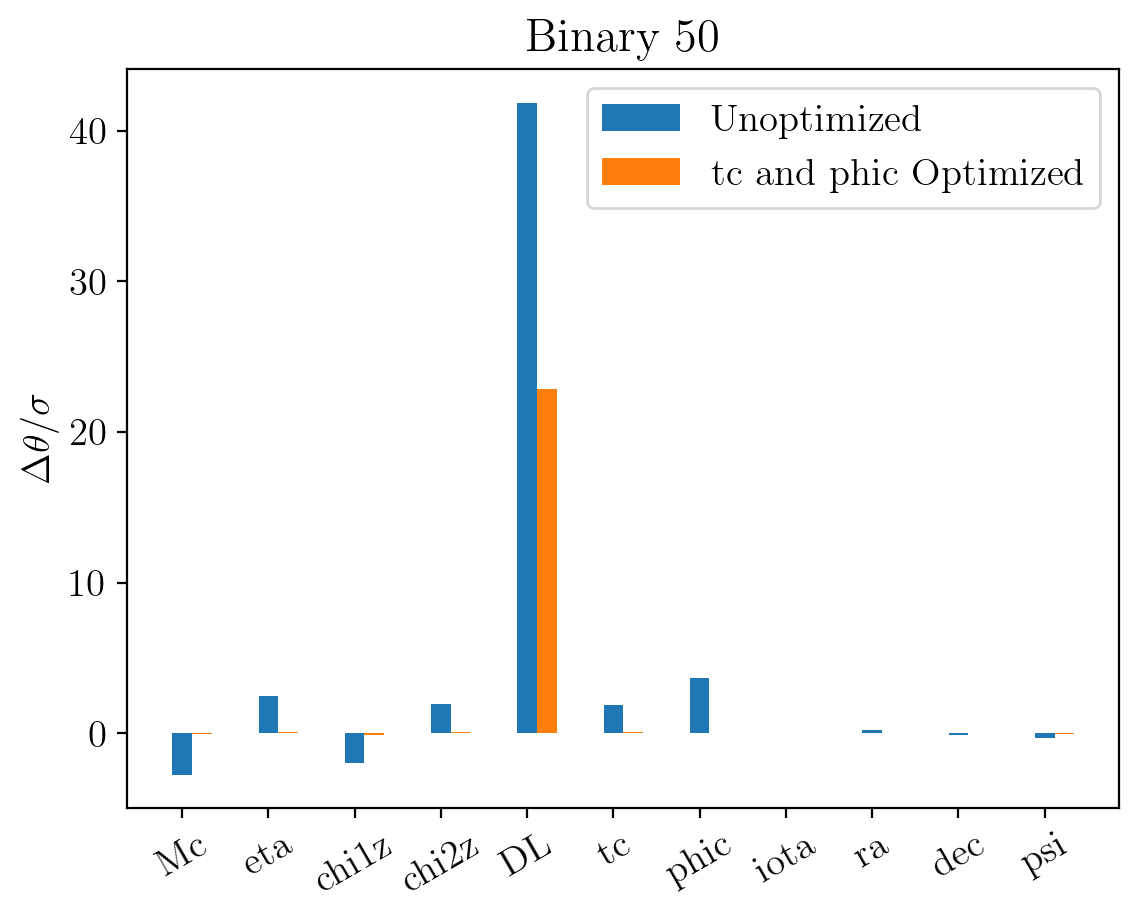

######  Binary 51  ######


2023-11-21 16:07:17,089 - Network - INFO : Polarizations calculated.
2023-11-21 16:07:17,090 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 16:07:17,098 - Network - INFO : Polarizations calculated.
2023-11-21 16:07:18,690 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:07:18,742 - Network - INFO : PSDs loaded.
2023-11-21 16:07:18,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:07:18,776 - Network - INFO : Detector responses calculated.
2023-11-21 16:07:18,776 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:07:18,777 - Network - INFO :    CE-40_C
2023-11-21 16:07:19,797 - Network - INFO :    CE-20_S
2023-11-21 16:07:20,853 - Network - INFO :    ET_ET1
2023-11-21 16:07:21,934 - Network - INFO :    ET_ET2
2023-11-21 16:07:22,967 - Network - INFO :    ET_ET3
2023-11-21 16:07:24,019 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 1

Mc bias diff: 107.78%
Mc, not: 1.740 sigma
Mc, opt: -0.135 sigma

eta bias diff: 106.98%
eta, not: 0.996 sigma
eta, opt: -0.070 sigma

chi1z bias diff: 590.92%
chi1z, not: -0.020 sigma
chi1z, opt: 0.098 sigma

chi2z bias diff: 170.11%
chi2z, not: 0.162 sigma
chi2z, opt: -0.114 sigma

DL bias diff: 45.79%
DL, not: 12.902 sigma
DL, opt: 6.994 sigma

tc bias diff: 111.49%
tc, not: 1.152 sigma
tc, opt: -0.132 sigma

phic bias diff: 113.71%
phic, not: 0.837 sigma
phic, opt: -0.115 sigma

iota bias diff: 96.43%
iota, not: -0.087 sigma
iota, opt: -0.003 sigma

ra bias diff: 50.04%
ra, not: 0.211 sigma
ra, opt: 0.106 sigma

dec bias diff: 51.56%
dec, not: -0.111 sigma
dec, opt: -0.054 sigma

psi bias diff: 76.14%
psi, not: -0.176 sigma
psi, opt: -0.042 sigma

######  Binary 52  ######


2023-11-21 16:07:33,462 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:07:33,511 - Network - INFO : PSDs loaded.
2023-11-21 16:07:33,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:07:33,545 - Network - INFO : Detector responses calculated.
2023-11-21 16:07:33,546 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:07:33,546 - Network - INFO :    CE-40_C
2023-11-21 16:07:34,616 - Network - INFO :    CE-20_S
2023-11-21 16:07:35,728 - Network - INFO :    ET_ET1
2023-11-21 16:07:36,918 - Network - INFO :    ET_ET2
2023-11-21 16:07:38,022 - Network - INFO :    ET_ET3
2023-11-21 16:07:39,156 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:07:39,159 - Network - INFO : SNRs calculated.
2023-11-21 16:07:39,159 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:07:39,160 - Network - INFO :    CE-40_C
2023-11-21 16:07:39,220 - Network - INFO :

Mc bias diff: 97.84%
Mc, not: 3.453 sigma
Mc, opt: 0.075 sigma

eta bias diff: 101.50%
eta, not: 1.540 sigma
eta, opt: -0.023 sigma

chi1z bias diff: 96.70%
chi1z, not: -2.434 sigma
chi1z, opt: -0.080 sigma

chi2z bias diff: 96.62%
chi2z, not: 2.458 sigma
chi2z, opt: 0.083 sigma

DL bias diff: 47.49%
DL, not: 14.023 sigma
DL, opt: 7.363 sigma

tc bias diff: 96.31%
tc, not: 2.452 sigma
tc, opt: 0.090 sigma

phic bias diff: 93.10%
phic, not: 1.523 sigma
phic, opt: 0.105 sigma

iota bias diff: 190.50%
iota, not: 0.227 sigma
iota, opt: -0.206 sigma

ra bias diff: 18.66%
ra, not: -0.119 sigma
ra, opt: -0.097 sigma

dec bias diff: -45.14%
dec, not: -0.099 sigma
dec, opt: -0.144 sigma

psi bias diff: -573.27%
psi, not: 0.040 sigma
psi, opt: 0.272 sigma

######  Binary 53  ######


2023-11-21 16:07:49,512 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:07:49,558 - Network - INFO : PSDs loaded.
2023-11-21 16:07:49,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:07:49,598 - Network - INFO : Detector responses calculated.
2023-11-21 16:07:49,599 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:07:49,599 - Network - INFO :    CE-40_C
2023-11-21 16:07:50,928 - Network - INFO :    CE-20_S
2023-11-21 16:07:52,267 - Network - INFO :    ET_ET1
2023-11-21 16:07:53,598 - Network - INFO :    ET_ET2
2023-11-21 16:07:54,938 - Network - INFO :    ET_ET3
2023-11-21 16:07:56,264 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:07:56,268 - Network - INFO : SNRs calculated.
2023-11-21 16:07:56,268 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:07:56,269 - Network - INFO :    CE-40_C
2023-11-21 16:07:56,327 - Network - INFO :

Mc bias diff: 79.95%
Mc, not: 0.155 sigma
Mc, opt: 0.031 sigma

eta bias diff: 122.61%
eta, not: 0.655 sigma
eta, opt: -0.148 sigma

chi1z bias diff: 119.07%
chi1z, not: -0.612 sigma
chi1z, opt: 0.117 sigma

chi2z bias diff: 118.03%
chi2z, not: 0.591 sigma
chi2z, opt: -0.107 sigma

DL bias diff: 43.46%
DL, not: 9.645 sigma
DL, opt: 5.453 sigma

tc bias diff: 114.59%
tc, not: 0.602 sigma
tc, opt: -0.088 sigma

phic bias diff: 96.96%
phic, not: 0.870 sigma
phic, opt: 0.026 sigma

iota bias diff: -34.55%
iota, not: -0.482 sigma
iota, opt: -0.649 sigma

ra bias diff: -78.72%
ra, not: -0.300 sigma
ra, opt: -0.537 sigma

dec bias diff: -91.99%
dec, not: -0.305 sigma
dec, opt: -0.585 sigma

psi bias diff: 57.79%
psi, not: 0.428 sigma
psi, opt: 0.181 sigma

######  Binary 54  ######


2023-11-21 16:08:08,374 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:08:08,497 - Network - INFO : PSDs loaded.
2023-11-21 16:08:08,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:08:08,537 - Network - INFO : Detector responses calculated.
2023-11-21 16:08:08,538 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:08:08,538 - Network - INFO :    CE-40_C
2023-11-21 16:08:10,018 - Network - INFO :    CE-20_S
2023-11-21 16:08:11,490 - Network - INFO :    ET_ET1
2023-11-21 16:08:12,937 - Network - INFO :    ET_ET2
2023-11-21 16:08:14,403 - Network - INFO :    ET_ET3
2023-11-21 16:08:15,917 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:08:15,920 - Network - INFO : SNRs calculated.
2023-11-21 16:08:15,921 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:08:15,921 - Network - INFO :    CE-40_C
2023-11-21 16:08:15,979 - Network - INFO :

Mc bias diff: 120.49%
Mc, not: -1.906 sigma
Mc, opt: 0.391 sigma

eta bias diff: 127.41%
eta, not: 2.190 sigma
eta, opt: -0.600 sigma

chi1z bias diff: 148.35%
chi1z, not: -1.508 sigma
chi1z, opt: 0.729 sigma

chi2z bias diff: 152.61%
chi2z, not: 1.398 sigma
chi2z, opt: -0.735 sigma

DL bias diff: 51.93%
DL, not: 15.789 sigma
DL, opt: 7.590 sigma

tc bias diff: 150.39%
tc, not: 1.472 sigma
tc, opt: -0.742 sigma

phic bias diff: 140.37%
phic, not: 1.724 sigma
phic, opt: -0.696 sigma

iota bias diff: 513.01%
iota, not: -0.105 sigma
iota, opt: 0.432 sigma

ra bias diff: 179.59%
ra, not: 0.101 sigma
ra, opt: -0.080 sigma

dec bias diff: 504.68%
dec, not: -0.087 sigma
dec, opt: 0.354 sigma

psi bias diff: -1989.63%
psi, not: -0.068 sigma
psi, opt: -1.422 sigma

######  Binary 55  ######


2023-11-21 16:08:28,417 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:08:28,469 - Network - INFO : PSDs loaded.
2023-11-21 16:08:28,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:08:28,508 - Network - INFO : Detector responses calculated.
2023-11-21 16:08:28,509 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:08:28,509 - Network - INFO :    CE-40_C
2023-11-21 16:08:29,564 - Network - INFO :    CE-20_S
2023-11-21 16:08:30,717 - Network - INFO :    ET_ET1
2023-11-21 16:08:31,805 - Network - INFO :    ET_ET2
2023-11-21 16:08:32,869 - Network - INFO :    ET_ET3
2023-11-21 16:08:33,962 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:08:33,969 - Network - INFO : SNRs calculated.
2023-11-21 16:08:33,970 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:08:33,970 - Network - INFO :    CE-40_C
2023-11-21 16:08:34,034 - Network - INFO :

Mc bias diff: 100.17%
Mc, not: 0.779 sigma
Mc, opt: -0.001 sigma

eta bias diff: 101.43%
eta, not: 0.891 sigma
eta, opt: -0.013 sigma

chi1z bias diff: 99.17%
chi1z, not: -0.978 sigma
chi1z, opt: -0.008 sigma

chi2z bias diff: 99.14%
chi2z, not: 0.979 sigma
chi2z, opt: 0.008 sigma

DL bias diff: 73.31%
DL, not: 0.930 sigma
DL, opt: 0.248 sigma

tc bias diff: 99.47%
tc, not: 0.980 sigma
tc, opt: 0.005 sigma

phic bias diff: 95.44%
phic, not: 0.860 sigma
phic, opt: 0.039 sigma

iota bias diff: -208.57%
iota, not: -0.249 sigma
iota, opt: -0.769 sigma

ra bias diff: -15.24%
ra, not: -0.185 sigma
ra, opt: -0.213 sigma

dec bias diff: 26.85%
dec, not: 0.226 sigma
dec, opt: 0.165 sigma

psi bias diff: -308.63%
psi, not: 0.018 sigma
psi, opt: 0.075 sigma

######  Binary 56  ######


2023-11-21 16:08:44,296 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:08:44,344 - Network - INFO : PSDs loaded.
2023-11-21 16:08:44,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:08:44,386 - Network - INFO : Detector responses calculated.
2023-11-21 16:08:44,387 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:08:44,388 - Network - INFO :    CE-40_C
2023-11-21 16:08:45,940 - Network - INFO :    CE-20_S
2023-11-21 16:08:47,429 - Network - INFO :    ET_ET1
2023-11-21 16:08:48,924 - Network - INFO :    ET_ET2
2023-11-21 16:08:50,428 - Network - INFO :    ET_ET3
2023-11-21 16:08:51,916 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:08:51,919 - Network - INFO : SNRs calculated.
2023-11-21 16:08:51,920 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:08:51,920 - Network - INFO :    CE-40_C
2023-11-21 16:08:51,979 - Network - INFO :

Mc bias diff: 102.09%
Mc, not: -3.057 sigma
Mc, opt: 0.064 sigma

eta bias diff: 99.18%
eta, not: 4.430 sigma
eta, opt: 0.036 sigma

chi1z bias diff: 97.49%
chi1z, not: -3.787 sigma
chi1z, opt: -0.095 sigma

chi2z bias diff: 96.99%
chi2z, not: 3.588 sigma
chi2z, opt: 0.108 sigma

DL bias diff: 49.78%
DL, not: 13.679 sigma
DL, opt: 6.869 sigma

tc bias diff: 97.94%
tc, not: 3.587 sigma
tc, opt: 0.074 sigma

phic bias diff: 89.37%
phic, not: 3.452 sigma
phic, opt: 0.367 sigma

iota bias diff: 442.57%
iota, not: 0.223 sigma
iota, opt: -0.763 sigma

ra bias diff: 224.01%
ra, not: 0.852 sigma
ra, opt: -1.056 sigma

dec bias diff: 225.89%
dec, not: -0.825 sigma
dec, opt: 1.039 sigma

psi bias diff: -112.25%
psi, not: -0.325 sigma
psi, opt: -0.690 sigma

######  Binary 57  ######


2023-11-21 16:09:03,685 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:09:03,759 - Network - INFO : PSDs loaded.
2023-11-21 16:09:03,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:09:03,797 - Network - INFO : Detector responses calculated.
2023-11-21 16:09:03,798 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:09:03,798 - Network - INFO :    CE-40_C
2023-11-21 16:09:04,382 - Network - INFO :    CE-20_S
2023-11-21 16:09:04,965 - Network - INFO :    ET_ET1
2023-11-21 16:09:05,546 - Network - INFO :    ET_ET2
2023-11-21 16:09:06,130 - Network - INFO :    ET_ET3
2023-11-21 16:09:06,716 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:09:06,720 - Network - INFO : SNRs calculated.
2023-11-21 16:09:06,721 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:09:06,722 - Network - INFO :    CE-40_C
2023-11-21 16:09:06,802 - Network - INFO :

Mc bias diff: 184.17%
Mc, not: 1.330 sigma
Mc, opt: -1.119 sigma

eta bias diff: 163.67%
eta, not: -0.460 sigma
eta, opt: 0.293 sigma

chi1z bias diff: 84.26%
chi1z, not: -7.011 sigma
chi1z, opt: -1.103 sigma

chi2z bias diff: 84.54%
chi2z, not: 7.112 sigma
chi2z, opt: 1.099 sigma

DL bias diff: 0.34%
DL, not: 5.778 sigma
DL, opt: 5.759 sigma

tc bias diff: 93.35%
tc, not: 3.536 sigma
tc, opt: 0.235 sigma

phic bias diff: 83.88%
phic, not: 2.941 sigma
phic, opt: 0.474 sigma

iota bias diff: -330.40%
iota, not: -0.429 sigma
iota, opt: -1.846 sigma

ra bias diff: 400.17%
ra, not: -0.428 sigma
ra, opt: 1.285 sigma

dec bias diff: -173.64%
dec, not: -0.496 sigma
dec, opt: -1.358 sigma

psi bias diff: 142.12%
psi, not: 0.306 sigma
psi, opt: -0.129 sigma

######  Binary 58  ######


2023-11-21 16:09:12,191 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:09:12,273 - Network - INFO : PSDs loaded.
2023-11-21 16:09:12,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:09:12,313 - Network - INFO : Detector responses calculated.
2023-11-21 16:09:12,314 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:09:12,315 - Network - INFO :    CE-40_C
2023-11-21 16:09:13,043 - Network - INFO :    CE-20_S
2023-11-21 16:09:13,764 - Network - INFO :    ET_ET1
2023-11-21 16:09:14,485 - Network - INFO :    ET_ET2
2023-11-21 16:09:15,213 - Network - INFO :    ET_ET3
2023-11-21 16:09:15,938 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:09:15,942 - Network - INFO : SNRs calculated.
2023-11-21 16:09:15,943 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:09:15,944 - Network - INFO :    CE-40_C
2023-11-21 16:09:16,017 - Network - INFO :

Mc bias diff: 96.06%
Mc, not: 3.708 sigma
Mc, opt: 0.146 sigma

eta bias diff: 101.09%
eta, not: 7.672 sigma
eta, opt: -0.083 sigma

chi1z bias diff: 101.07%
chi1z, not: -9.369 sigma
chi1z, opt: 0.100 sigma

chi2z bias diff: 101.02%
chi2z, not: 9.633 sigma
chi2z, opt: -0.099 sigma

DL bias diff: 43.25%
DL, not: 1.968 sigma
DL, opt: 1.117 sigma

tc bias diff: 101.07%
tc, not: 9.440 sigma
tc, opt: -0.101 sigma

phic bias diff: 103.33%
phic, not: 3.634 sigma
phic, opt: -0.121 sigma

iota bias diff: 43.14%
iota, not: 1.459 sigma
iota, opt: 0.830 sigma

ra bias diff: 609.85%
ra, not: -0.025 sigma
ra, opt: 0.130 sigma

dec bias diff: -1415.25%
dec, not: 0.006 sigma
dec, opt: 0.096 sigma

psi bias diff: 88.58%
psi, not: -0.580 sigma
psi, opt: -0.066 sigma

######  Binary 59  ######


2023-11-21 16:09:23,638 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:09:23,682 - Network - INFO : PSDs loaded.
2023-11-21 16:09:23,685 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:09:23,724 - Network - INFO : Detector responses calculated.
2023-11-21 16:09:23,725 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:09:23,726 - Network - INFO :    CE-40_C
2023-11-21 16:09:25,180 - Network - INFO :    CE-20_S
2023-11-21 16:09:26,633 - Network - INFO :    ET_ET1
2023-11-21 16:09:28,081 - Network - INFO :    ET_ET2
2023-11-21 16:09:29,527 - Network - INFO :    ET_ET3
2023-11-21 16:09:30,987 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:09:30,991 - Network - INFO : SNRs calculated.
2023-11-21 16:09:30,991 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:09:30,992 - Network - INFO :    CE-40_C
2023-11-21 16:09:31,050 - Network - INFO :

Mc bias diff: 91.62%
Mc, not: -0.065 sigma
Mc, opt: -0.005 sigma

eta bias diff: 101.31%
eta, not: 0.288 sigma
eta, opt: -0.004 sigma

chi1z bias diff: 103.00%
chi1z, not: -0.229 sigma
chi1z, opt: 0.007 sigma

chi2z bias diff: 103.47%
chi2z, not: 0.216 sigma
chi2z, opt: -0.008 sigma

DL bias diff: 44.33%
DL, not: 13.198 sigma
DL, opt: 7.347 sigma

tc bias diff: 104.01%
tc, not: 0.213 sigma
tc, opt: -0.009 sigma

phic bias diff: 96.55%
phic, not: 0.439 sigma
phic, opt: 0.015 sigma

iota bias diff: 25.50%
iota, not: -0.102 sigma
iota, opt: -0.076 sigma

ra bias diff: 72.57%
ra, not: -0.089 sigma
ra, opt: -0.024 sigma

dec bias diff: 18.73%
dec, not: 0.070 sigma
dec, opt: 0.057 sigma

psi bias diff: 70.50%
psi, not: -0.171 sigma
psi, opt: -0.051 sigma

######  Binary 60  ######


2023-11-21 16:09:44,106 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:09:44,152 - Network - INFO : PSDs loaded.
2023-11-21 16:09:44,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:09:44,206 - Network - INFO : Detector responses calculated.
2023-11-21 16:09:44,207 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:09:44,207 - Network - INFO :    CE-40_C
2023-11-21 16:09:45,857 - Network - INFO :    CE-20_S
2023-11-21 16:09:47,452 - Network - INFO :    ET_ET1
2023-11-21 16:09:49,018 - Network - INFO :    ET_ET2
2023-11-21 16:09:50,580 - Network - INFO :    ET_ET3
2023-11-21 16:09:52,141 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:09:52,145 - Network - INFO : SNRs calculated.
2023-11-21 16:09:52,145 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:09:52,146 - Network - INFO :    CE-40_C
2023-11-21 16:09:52,205 - Network - INFO :

Mc bias diff: 104.64%
Mc, not: -1.254 sigma
Mc, opt: 0.058 sigma

eta bias diff: 112.92%
eta, not: 1.387 sigma
eta, opt: -0.179 sigma

chi1z bias diff: 120.30%
chi1z, not: -1.000 sigma
chi1z, opt: 0.203 sigma

chi2z bias diff: 122.22%
chi2z, not: 0.928 sigma
chi2z, opt: -0.206 sigma

DL bias diff: 51.58%
DL, not: 10.132 sigma
DL, opt: 4.906 sigma

tc bias diff: 121.95%
tc, not: 0.924 sigma
tc, opt: -0.203 sigma

phic bias diff: 97.48%
phic, not: 1.324 sigma
phic, opt: 0.033 sigma

iota bias diff: 524.65%
iota, not: 0.211 sigma
iota, opt: -0.897 sigma

ra bias diff: 407.58%
ra, not: 0.089 sigma
ra, opt: -0.275 sigma

dec bias diff: 99.34%
dec, not: -0.059 sigma
dec, opt: -0.000 sigma

psi bias diff: -288.96%
psi, not: -0.049 sigma
psi, opt: -0.189 sigma



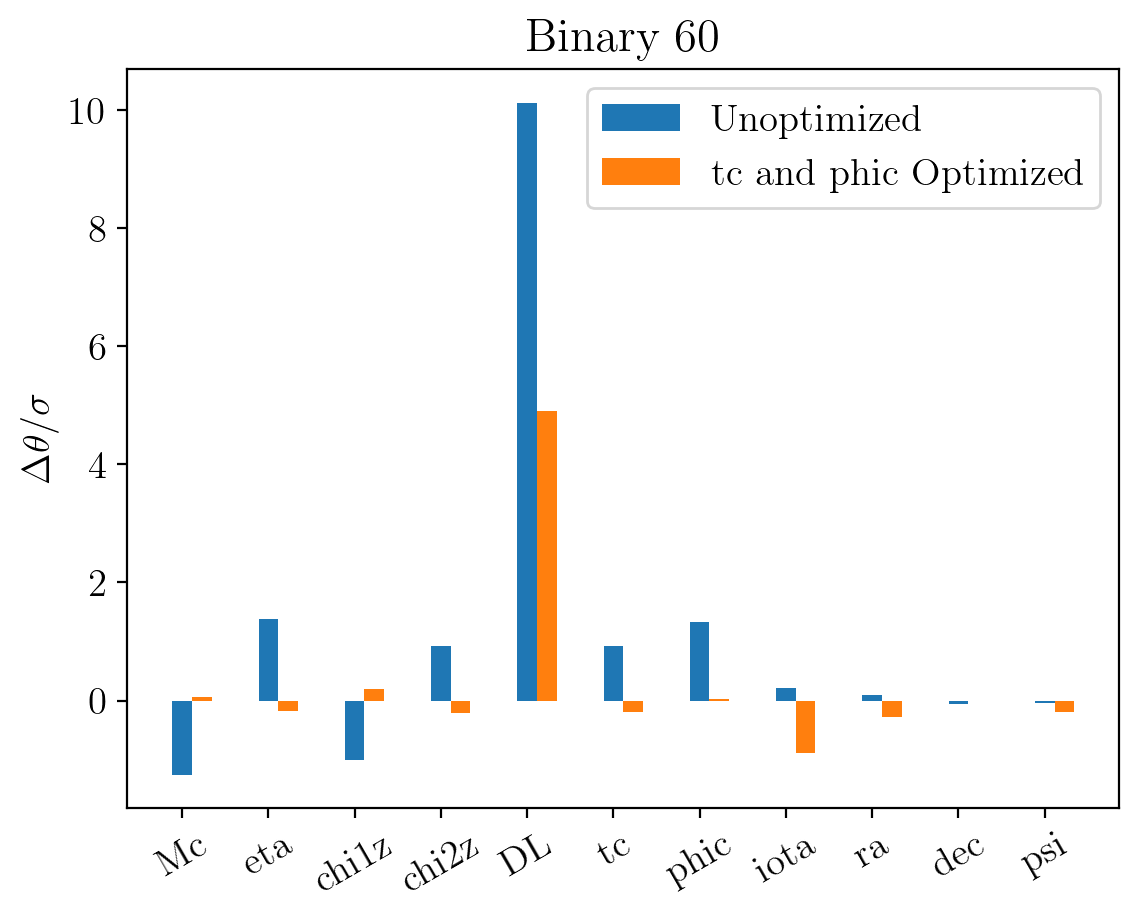

2023-11-21 16:10:03,860 - Network - INFO : Polarizations calculated.
2023-11-21 16:10:03,861 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 16:10:03,868 - Network - INFO : Polarizations calculated.


######  Binary 61  ######


2023-11-21 16:10:04,735 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:10:04,809 - Network - INFO : PSDs loaded.
2023-11-21 16:10:04,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:10:04,850 - Network - INFO : Detector responses calculated.
2023-11-21 16:10:04,851 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:10:04,851 - Network - INFO :    CE-40_C
2023-11-21 16:10:05,523 - Network - INFO :    CE-20_S
2023-11-21 16:10:06,189 - Network - INFO :    ET_ET1
2023-11-21 16:10:06,850 - Network - INFO :    ET_ET2
2023-11-21 16:10:07,514 - Network - INFO :    ET_ET3
2023-11-21 16:10:08,176 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:10:08,181 - Network - INFO : SNRs calculated.
2023-11-21 16:10:08,181 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:10:08,182 - Network - INFO :    CE-40_C
2023-11-21 16:10:08,261 - Network - INFO :

Mc bias diff: 87.74%
Mc, not: 2.816 sigma
Mc, opt: 0.345 sigma

eta bias diff: 95.44%
eta, not: 5.897 sigma
eta, opt: 0.269 sigma

chi1z bias diff: 95.68%
chi1z, not: -6.113 sigma
chi1z, opt: -0.264 sigma

chi2z bias diff: 95.63%
chi2z, not: 6.110 sigma
chi2z, opt: 0.267 sigma

DL bias diff: 43.13%
DL, not: 18.658 sigma
DL, opt: 10.611 sigma

tc bias diff: 96.05%
tc, not: 6.001 sigma
tc, opt: 0.237 sigma

phic bias diff: 95.90%
phic, not: 5.861 sigma
phic, opt: 0.240 sigma

iota bias diff: 20.17%
iota, not: -0.236 sigma
iota, opt: -0.188 sigma

ra bias diff: 185.11%
ra, not: -0.089 sigma
ra, opt: 0.075 sigma

dec bias diff: -96.15%
dec, not: 0.431 sigma
dec, opt: 0.845 sigma

psi bias diff: -9.24%
psi, not: 0.406 sigma
psi, opt: 0.444 sigma

######  Binary 62  ######


2023-11-21 16:10:13,824 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:10:13,901 - Network - INFO : PSDs loaded.
2023-11-21 16:10:13,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:10:13,938 - Network - INFO : Detector responses calculated.
2023-11-21 16:10:13,939 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:10:13,939 - Network - INFO :    CE-40_C
2023-11-21 16:10:14,447 - Network - INFO :    CE-20_S
2023-11-21 16:10:14,957 - Network - INFO :    ET_ET1
2023-11-21 16:10:15,466 - Network - INFO :    ET_ET2
2023-11-21 16:10:15,973 - Network - INFO :    ET_ET3
2023-11-21 16:10:16,479 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:10:16,483 - Network - INFO : SNRs calculated.
2023-11-21 16:10:16,483 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:10:16,484 - Network - INFO :    CE-40_C
2023-11-21 16:10:16,563 - Network - INFO :

Mc bias diff: 89.10%
Mc, not: -6.639 sigma
Mc, opt: -0.724 sigma

eta bias diff: 95.78%
eta, not: 10.158 sigma
eta, opt: 0.429 sigma

chi1z bias diff: 95.36%
chi1z, not: -10.933 sigma
chi1z, opt: -0.507 sigma

chi2z bias diff: 95.80%
chi2z, not: 11.419 sigma
chi2z, opt: 0.480 sigma

DL bias diff: 35.10%
DL, not: 18.889 sigma
DL, opt: 12.259 sigma

tc bias diff: 95.63%
tc, not: 11.229 sigma
tc, opt: 0.490 sigma

phic bias diff: 95.15%
phic, not: 11.198 sigma
phic, opt: 0.543 sigma

iota bias diff: 131.34%
iota, not: 0.198 sigma
iota, opt: -0.062 sigma

ra bias diff: 91.48%
ra, not: 1.652 sigma
ra, opt: 0.141 sigma

dec bias diff: 122.74%
dec, not: 1.457 sigma
dec, opt: -0.331 sigma

psi bias diff: 98.64%
psi, not: -0.302 sigma
psi, opt: -0.004 sigma

######  Binary 63  ######


2023-11-21 16:10:21,649 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:10:21,722 - Network - INFO : PSDs loaded.
2023-11-21 16:10:21,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:10:21,755 - Network - INFO : Detector responses calculated.
2023-11-21 16:10:21,756 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:10:21,756 - Network - INFO :    CE-40_C
2023-11-21 16:10:22,563 - Network - INFO :    CE-20_S
2023-11-21 16:10:23,375 - Network - INFO :    ET_ET1
2023-11-21 16:10:24,183 - Network - INFO :    ET_ET2
2023-11-21 16:10:25,027 - Network - INFO :    ET_ET3
2023-11-21 16:10:25,837 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:10:25,841 - Network - INFO : SNRs calculated.
2023-11-21 16:10:25,842 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:10:25,842 - Network - INFO :    CE-40_C
2023-11-21 16:10:25,904 - Network - INFO :

Mc bias diff: 100.13%
Mc, not: 3.973 sigma
Mc, opt: -0.005 sigma

eta bias diff: 97.49%
eta, not: 5.455 sigma
eta, opt: 0.137 sigma

chi1z bias diff: 97.13%
chi1z, not: -5.820 sigma
chi1z, opt: -0.167 sigma

chi2z bias diff: 97.12%
chi2z, not: 5.866 sigma
chi2z, opt: 0.169 sigma

DL bias diff: 44.73%
DL, not: 28.191 sigma
DL, opt: 15.582 sigma

tc bias diff: 97.10%
tc, not: 5.787 sigma
tc, opt: 0.168 sigma

phic bias diff: 96.69%
phic, not: 5.659 sigma
phic, opt: 0.187 sigma

iota bias diff: 107.71%
iota, not: 0.032 sigma
iota, opt: -0.002 sigma

ra bias diff: 5867.59%
ra, not: -0.000 sigma
ra, opt: 0.018 sigma

dec bias diff: 82.13%
dec, not: -0.653 sigma
dec, opt: -0.117 sigma

psi bias diff: 142.92%
psi, not: -0.030 sigma
psi, opt: 0.013 sigma

######  Binary 64  ######


2023-11-21 16:10:34,275 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:10:34,395 - Network - INFO : PSDs loaded.
2023-11-21 16:10:34,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:10:34,437 - Network - INFO : Detector responses calculated.
2023-11-21 16:10:34,437 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:10:34,438 - Network - INFO :    CE-40_C
2023-11-21 16:10:35,955 - Network - INFO :    CE-20_S
2023-11-21 16:10:37,418 - Network - INFO :    ET_ET1
2023-11-21 16:10:38,895 - Network - INFO :    ET_ET2
2023-11-21 16:10:40,388 - Network - INFO :    ET_ET3
2023-11-21 16:10:41,861 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:10:41,865 - Network - INFO : SNRs calculated.
2023-11-21 16:10:41,865 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:10:41,865 - Network - INFO :    CE-40_C
2023-11-21 16:10:41,923 - Network - INFO :

Mc bias diff: 67.64%
Mc, not: 0.285 sigma
Mc, opt: 0.092 sigma

eta bias diff: 6.86%
eta, not: -0.097 sigma
eta, opt: -0.090 sigma

chi1z bias diff: 80.19%
chi1z, not: 0.297 sigma
chi1z, opt: 0.059 sigma

chi2z bias diff: 83.35%
chi2z, not: -0.324 sigma
chi2z, opt: -0.054 sigma

DL bias diff: 49.45%
DL, not: 6.564 sigma
DL, opt: 3.318 sigma

tc bias diff: 91.81%
tc, not: -0.352 sigma
tc, opt: -0.029 sigma

phic bias diff: 120.14%
phic, not: 0.396 sigma
phic, opt: -0.080 sigma

iota bias diff: -182.23%
iota, not: 0.295 sigma
iota, opt: 0.833 sigma

ra bias diff: 466.53%
ra, not: 0.174 sigma
ra, opt: -0.637 sigma

dec bias diff: 454.01%
dec, not: 0.182 sigma
dec, opt: -0.644 sigma

psi bias diff: 21.97%
psi, not: 0.195 sigma
psi, opt: 0.152 sigma

######  Binary 65  ######


2023-11-21 16:10:54,442 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:10:54,488 - Network - INFO : PSDs loaded.
2023-11-21 16:10:54,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:10:54,521 - Network - INFO : Detector responses calculated.
2023-11-21 16:10:54,522 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:10:54,522 - Network - INFO :    CE-40_C
2023-11-21 16:10:55,584 - Network - INFO :    CE-20_S
2023-11-21 16:10:56,747 - Network - INFO :    ET_ET1
2023-11-21 16:10:57,850 - Network - INFO :    ET_ET2
2023-11-21 16:10:59,052 - Network - INFO :    ET_ET3
2023-11-21 16:11:00,147 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:11:00,157 - Network - INFO : SNRs calculated.
2023-11-21 16:11:00,160 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:11:00,162 - Network - INFO :    CE-40_C
2023-11-21 16:11:00,228 - Network - INFO :

Mc bias diff: 95.53%
Mc, not: -2.169 sigma
Mc, opt: -0.097 sigma

eta bias diff: 102.21%
eta, not: 4.856 sigma
eta, opt: -0.108 sigma

chi1z bias diff: 105.83%
chi1z, not: -2.962 sigma
chi1z, opt: 0.173 sigma

chi2z bias diff: 107.69%
chi2z, not: 2.384 sigma
chi2z, opt: -0.183 sigma

DL bias diff: 46.06%
DL, not: 21.879 sigma
DL, opt: 11.802 sigma

tc bias diff: 106.94%
tc, not: 2.566 sigma
tc, opt: -0.178 sigma

phic bias diff: 104.12%
phic, not: 2.981 sigma
phic, opt: -0.123 sigma

iota bias diff: 116.96%
iota, not: 0.104 sigma
iota, opt: -0.018 sigma

ra bias diff: 120.01%
ra, not: -0.056 sigma
ra, opt: 0.011 sigma

dec bias diff: 1839.77%
dec, not: 0.021 sigma
dec, opt: -0.366 sigma

psi bias diff: 84.32%
psi, not: -0.463 sigma
psi, opt: -0.073 sigma

######  Binary 66  ######


2023-11-21 16:11:11,583 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:11:11,629 - Network - INFO : PSDs loaded.
2023-11-21 16:11:11,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:11:11,679 - Network - INFO : Detector responses calculated.
2023-11-21 16:11:11,680 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:11:11,680 - Network - INFO :    CE-40_C
2023-11-21 16:11:13,870 - Network - INFO :    CE-20_S
2023-11-21 16:11:15,889 - Network - INFO :    ET_ET1
2023-11-21 16:11:17,930 - Network - INFO :    ET_ET2
2023-11-21 16:11:19,961 - Network - INFO :    ET_ET3
2023-11-21 16:11:22,023 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:11:22,027 - Network - INFO : SNRs calculated.
2023-11-21 16:11:22,028 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:11:22,028 - Network - INFO :    CE-40_C
2023-11-21 16:11:22,093 - Network - INFO :

Mc bias diff: 99.85%
Mc, not: -8.993 sigma
Mc, opt: -0.013 sigma

eta bias diff: 99.83%
eta, not: 7.972 sigma
eta, opt: 0.013 sigma

chi1z bias diff: 99.78%
chi1z, not: -6.606 sigma
chi1z, opt: -0.015 sigma

chi2z bias diff: 99.75%
chi2z, not: 6.174 sigma
chi2z, opt: 0.015 sigma

DL bias diff: 43.43%
DL, not: 17.309 sigma
DL, opt: 9.793 sigma

tc bias diff: 99.76%
tc, not: 6.200 sigma
tc, opt: 0.015 sigma

phic bias diff: 99.84%
phic, not: 4.658 sigma
phic, opt: 0.007 sigma

iota bias diff: 90.34%
iota, not: 0.554 sigma
iota, opt: 0.054 sigma

ra bias diff: 107.52%
ra, not: -0.402 sigma
ra, opt: 0.030 sigma

dec bias diff: 189.77%
dec, not: -0.012 sigma
dec, opt: 0.010 sigma

psi bias diff: 98.09%
psi, not: -0.807 sigma
psi, opt: -0.015 sigma

######  Binary 67  ######


2023-11-21 16:11:39,102 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:11:39,148 - Network - INFO : PSDs loaded.
2023-11-21 16:11:39,150 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:11:39,190 - Network - INFO : Detector responses calculated.
2023-11-21 16:11:39,191 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:11:39,191 - Network - INFO :    CE-40_C
2023-11-21 16:11:40,727 - Network - INFO :    CE-20_S
2023-11-21 16:11:42,265 - Network - INFO :    ET_ET1
2023-11-21 16:11:43,878 - Network - INFO :    ET_ET2
2023-11-21 16:11:45,459 - Network - INFO :    ET_ET3
2023-11-21 16:11:47,018 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:11:47,022 - Network - INFO : SNRs calculated.
2023-11-21 16:11:47,022 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:11:47,023 - Network - INFO :    CE-40_C
2023-11-21 16:11:47,082 - Network - INFO :

Mc bias diff: 106.92%
Mc, not: -0.713 sigma
Mc, opt: 0.049 sigma

eta bias diff: 220.76%
eta, not: 0.351 sigma
eta, opt: -0.424 sigma

chi1z bias diff: -21.87%
chi1z, not: 0.456 sigma
chi1z, opt: 0.556 sigma

chi2z bias diff: 9.29%
chi2z, not: -0.644 sigma
chi2z, opt: -0.584 sigma

DL bias diff: 58.44%
DL, not: 10.882 sigma
DL, opt: 4.522 sigma

tc bias diff: 8.16%
tc, not: -0.620 sigma
tc, opt: -0.569 sigma

phic bias diff: 203.19%
phic, not: 0.327 sigma
phic, opt: -0.337 sigma

iota bias diff: 1115.19%
iota, not: 0.337 sigma
iota, opt: -3.418 sigma

ra bias diff: -676.88%
ra, not: -0.111 sigma
ra, opt: -0.861 sigma

dec bias diff: 626.11%
dec, not: 0.096 sigma
dec, opt: -0.504 sigma

psi bias diff: 12.88%
psi, not: 0.443 sigma
psi, opt: 0.386 sigma

######  Binary 68  ######


2023-11-21 16:11:59,358 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:11:59,432 - Network - INFO : PSDs loaded.
2023-11-21 16:11:59,435 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:11:59,472 - Network - INFO : Detector responses calculated.
2023-11-21 16:11:59,473 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:11:59,474 - Network - INFO :    CE-40_C
2023-11-21 16:12:00,214 - Network - INFO :    CE-20_S
2023-11-21 16:12:00,950 - Network - INFO :    ET_ET1
2023-11-21 16:12:01,682 - Network - INFO :    ET_ET2
2023-11-21 16:12:02,415 - Network - INFO :    ET_ET3
2023-11-21 16:12:03,149 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:12:03,153 - Network - INFO : SNRs calculated.
2023-11-21 16:12:03,153 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:12:03,154 - Network - INFO :    CE-40_C
2023-11-21 16:12:03,228 - Network - INFO :

Mc bias diff: 92.00%
Mc, not: 6.252 sigma
Mc, opt: 0.500 sigma

eta bias diff: 100.32%
eta, not: 22.898 sigma
eta, opt: -0.072 sigma

chi1z bias diff: 100.57%
chi1z, not: -29.236 sigma
chi1z, opt: 0.167 sigma

chi2z bias diff: 100.57%
chi2z, not: 30.543 sigma
chi2z, opt: -0.174 sigma

DL bias diff: 97.93%
DL, not: 4.724 sigma
DL, opt: 0.098 sigma

tc bias diff: 100.60%
tc, not: 30.241 sigma
tc, opt: -0.181 sigma

phic bias diff: 88.94%
phic, not: 0.491 sigma
phic, opt: 0.054 sigma

iota bias diff: 869.43%
iota, not: -1.400 sigma
iota, opt: 10.771 sigma

ra bias diff: 74.32%
ra, not: -0.630 sigma
ra, opt: -0.162 sigma

dec bias diff: 101.50%
dec, not: -2.134 sigma
dec, opt: 0.032 sigma

psi bias diff: 178.53%
psi, not: -0.077 sigma
psi, opt: 0.061 sigma

######  Binary 69  ######


2023-11-21 16:12:10,774 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:12:10,892 - Network - INFO : PSDs loaded.
2023-11-21 16:12:10,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:12:10,929 - Network - INFO : Detector responses calculated.
2023-11-21 16:12:10,929 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:12:10,930 - Network - INFO :    CE-40_C
2023-11-21 16:12:12,221 - Network - INFO :    CE-20_S
2023-11-21 16:12:13,585 - Network - INFO :    ET_ET1
2023-11-21 16:12:14,921 - Network - INFO :    ET_ET2
2023-11-21 16:12:16,256 - Network - INFO :    ET_ET3
2023-11-21 16:12:17,592 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:12:17,595 - Network - INFO : SNRs calculated.
2023-11-21 16:12:17,596 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:12:17,596 - Network - INFO :    CE-40_C
2023-11-21 16:12:17,653 - Network - INFO :

Mc bias diff: 60.05%
Mc, not: 0.259 sigma
Mc, opt: 0.103 sigma

eta bias diff: 119.60%
eta, not: 0.424 sigma
eta, opt: -0.083 sigma

chi1z bias diff: 109.00%
chi1z, not: -0.380 sigma
chi1z, opt: 0.034 sigma

chi2z bias diff: 107.15%
chi2z, not: 0.368 sigma
chi2z, opt: -0.026 sigma

DL bias diff: 41.94%
DL, not: 16.574 sigma
DL, opt: 9.623 sigma

tc bias diff: 101.57%
tc, not: 0.361 sigma
tc, opt: -0.006 sigma

phic bias diff: 105.93%
phic, not: 1.013 sigma
phic, opt: -0.060 sigma

iota bias diff: 284.16%
iota, not: -0.119 sigma
iota, opt: 0.218 sigma

ra bias diff: 58.39%
ra, not: 0.140 sigma
ra, opt: 0.058 sigma

dec bias diff: -65.33%
dec, not: 0.083 sigma
dec, opt: 0.138 sigma

psi bias diff: 88.62%
psi, not: -0.127 sigma
psi, opt: -0.014 sigma

######  Binary 70  ######


2023-11-21 16:12:28,970 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:12:29,019 - Network - INFO : PSDs loaded.
2023-11-21 16:12:29,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:12:29,051 - Network - INFO : Detector responses calculated.
2023-11-21 16:12:29,052 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:12:29,052 - Network - INFO :    CE-40_C
2023-11-21 16:12:30,064 - Network - INFO :    CE-20_S
2023-11-21 16:12:31,130 - Network - INFO :    ET_ET1
2023-11-21 16:12:32,167 - Network - INFO :    ET_ET2
2023-11-21 16:12:33,243 - Network - INFO :    ET_ET3
2023-11-21 16:12:34,289 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:12:34,292 - Network - INFO : SNRs calculated.
2023-11-21 16:12:34,293 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:12:34,293 - Network - INFO :    CE-40_C
2023-11-21 16:12:34,352 - Network - INFO :

Mc bias diff: 101.41%
Mc, not: 3.965 sigma
Mc, opt: -0.056 sigma

eta bias diff: 102.17%
eta, not: 2.085 sigma
eta, opt: -0.045 sigma

chi1z bias diff: 101.86%
chi1z, not: -3.056 sigma
chi1z, opt: 0.057 sigma

chi2z bias diff: 101.88%
chi2z, not: 3.033 sigma
chi2z, opt: -0.057 sigma

DL bias diff: 37.95%
DL, not: 11.554 sigma
DL, opt: 7.169 sigma

tc bias diff: 101.69%
tc, not: 3.515 sigma
tc, opt: -0.060 sigma

phic bias diff: 100.29%
phic, not: 2.717 sigma
phic, opt: -0.008 sigma

iota bias diff: 94.13%
iota, not: 0.558 sigma
iota, opt: 0.033 sigma

ra bias diff: 108.70%
ra, not: 0.220 sigma
ra, opt: -0.019 sigma

dec bias diff: 103.20%
dec, not: 0.358 sigma
dec, opt: -0.011 sigma

psi bias diff: 100.30%
psi, not: -0.711 sigma
psi, opt: 0.002 sigma



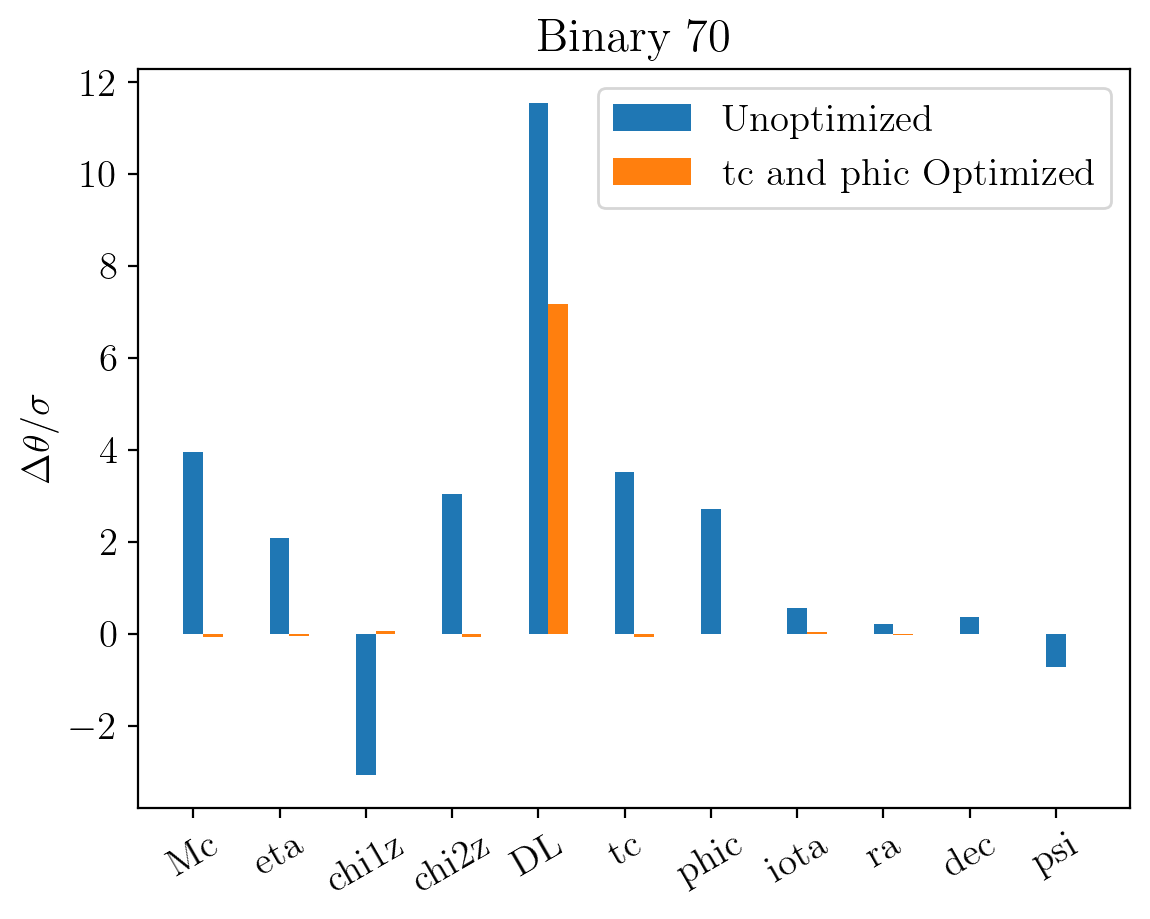

2023-11-21 16:12:42,536 - Network - INFO : Polarizations calculated.
2023-11-21 16:12:42,537 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 16:12:42,548 - Network - INFO : Polarizations calculated.


######  Binary 71  ######


2023-11-21 16:12:45,137 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:12:45,184 - Network - INFO : PSDs loaded.
2023-11-21 16:12:45,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:12:45,229 - Network - INFO : Detector responses calculated.
2023-11-21 16:12:45,229 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:12:45,230 - Network - INFO :    CE-40_C
2023-11-21 16:12:46,947 - Network - INFO :    CE-20_S
2023-11-21 16:12:48,579 - Network - INFO :    ET_ET1
2023-11-21 16:12:50,225 - Network - INFO :    ET_ET2
2023-11-21 16:12:51,842 - Network - INFO :    ET_ET3
2023-11-21 16:12:53,472 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:12:53,476 - Network - INFO : SNRs calculated.
2023-11-21 16:12:53,476 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:12:53,477 - Network - INFO :    CE-40_C
2023-11-21 16:12:53,536 - Network - INFO :

Mc bias diff: 102.87%
Mc, not: -0.890 sigma
Mc, opt: 0.026 sigma

eta bias diff: 101.90%
eta, not: 1.202 sigma
eta, opt: -0.023 sigma

chi1z bias diff: 101.71%
chi1z, not: -1.101 sigma
chi1z, opt: 0.019 sigma

chi2z bias diff: 101.65%
chi2z, not: 1.068 sigma
chi2z, opt: -0.018 sigma

DL bias diff: 46.42%
DL, not: 17.483 sigma
DL, opt: 9.368 sigma

tc bias diff: 101.67%
tc, not: 1.053 sigma
tc, opt: -0.018 sigma

phic bias diff: 102.52%
phic, not: 0.927 sigma
phic, opt: -0.023 sigma

iota bias diff: 49.98%
iota, not: 0.054 sigma
iota, opt: 0.027 sigma

ra bias diff: 287.63%
ra, not: 0.025 sigma
ra, opt: -0.047 sigma

dec bias diff: 243.16%
dec, not: 0.036 sigma
dec, opt: -0.052 sigma

psi bias diff: 88.31%
psi, not: -0.052 sigma
psi, opt: -0.006 sigma

######  Binary 72  ######


2023-11-21 16:13:06,460 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:13:06,535 - Network - INFO : PSDs loaded.
2023-11-21 16:13:06,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:13:06,574 - Network - INFO : Detector responses calculated.
2023-11-21 16:13:06,575 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:13:06,576 - Network - INFO :    CE-40_C
2023-11-21 16:13:07,313 - Network - INFO :    CE-20_S
2023-11-21 16:13:08,054 - Network - INFO :    ET_ET1
2023-11-21 16:13:08,800 - Network - INFO :    ET_ET2
2023-11-21 16:13:09,539 - Network - INFO :    ET_ET3
2023-11-21 16:13:10,464 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:13:10,468 - Network - INFO : SNRs calculated.
2023-11-21 16:13:10,469 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:13:10,470 - Network - INFO :    CE-40_C
2023-11-21 16:13:10,542 - Network - INFO :

Mc bias diff: 98.44%
Mc, not: 5.829 sigma
Mc, opt: 0.091 sigma

eta bias diff: 100.08%
eta, not: 9.031 sigma
eta, opt: -0.008 sigma

chi1z bias diff: 99.94%
chi1z, not: -11.738 sigma
chi1z, opt: -0.007 sigma

chi2z bias diff: 99.93%
chi2z, not: 12.008 sigma
chi2z, opt: 0.008 sigma

DL bias diff: 98.73%
DL, not: 3.266 sigma
DL, opt: 0.042 sigma

tc bias diff: 99.96%
tc, not: 11.934 sigma
tc, opt: 0.005 sigma

phic bias diff: 98.75%
phic, not: 4.528 sigma
phic, opt: 0.057 sigma

iota bias diff: 7275.09%
iota, not: -0.074 sigma
iota, opt: 5.327 sigma

ra bias diff: -16.25%
ra, not: 0.523 sigma
ra, opt: 0.608 sigma

dec bias diff: -15.69%
dec, not: 0.680 sigma
dec, opt: 0.787 sigma

psi bias diff: 109.55%
psi, not: -0.403 sigma
psi, opt: 0.038 sigma

######  Binary 73  ######


2023-11-21 16:13:18,185 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:13:18,231 - Network - INFO : PSDs loaded.
2023-11-21 16:13:18,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:13:18,268 - Network - INFO : Detector responses calculated.
2023-11-21 16:13:18,269 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:13:18,270 - Network - INFO :    CE-40_C
2023-11-21 16:13:19,625 - Network - INFO :    CE-20_S
2023-11-21 16:13:21,021 - Network - INFO :    ET_ET1
2023-11-21 16:13:22,393 - Network - INFO :    ET_ET2
2023-11-21 16:13:23,767 - Network - INFO :    ET_ET3
2023-11-21 16:13:25,140 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:13:25,144 - Network - INFO : SNRs calculated.
2023-11-21 16:13:25,144 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:13:25,144 - Network - INFO :    CE-40_C
2023-11-21 16:13:25,200 - Network - INFO :

Mc bias diff: 131.10%
Mc, not: 0.375 sigma
Mc, opt: -0.117 sigma

eta bias diff: 81.67%
eta, not: 1.941 sigma
eta, opt: 0.356 sigma

chi1z bias diff: 81.28%
chi1z, not: -1.975 sigma
chi1z, opt: -0.370 sigma

chi2z bias diff: 81.06%
chi2z, not: 1.952 sigma
chi2z, opt: 0.370 sigma

DL bias diff: 41.60%
DL, not: 14.936 sigma
DL, opt: 8.722 sigma

tc bias diff: 80.80%
tc, not: 1.762 sigma
tc, opt: 0.338 sigma

phic bias diff: 84.87%
phic, not: 1.538 sigma
phic, opt: 0.233 sigma

iota bias diff: 88.86%
iota, not: -0.429 sigma
iota, opt: -0.048 sigma

ra bias diff: 81.11%
ra, not: -0.088 sigma
ra, opt: -0.017 sigma

dec bias diff: 84.79%
dec, not: 0.097 sigma
dec, opt: 0.015 sigma

psi bias diff: 92.70%
psi, not: -0.430 sigma
psi, opt: -0.031 sigma

######  Binary 74  ######


2023-11-21 16:13:37,562 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:13:37,681 - Network - INFO : PSDs loaded.
2023-11-21 16:13:37,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:13:37,722 - Network - INFO : Detector responses calculated.
2023-11-21 16:13:37,723 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:13:37,724 - Network - INFO :    CE-40_C
2023-11-21 16:13:39,254 - Network - INFO :    CE-20_S
2023-11-21 16:13:40,757 - Network - INFO :    ET_ET1
2023-11-21 16:13:42,328 - Network - INFO :    ET_ET2
2023-11-21 16:13:43,863 - Network - INFO :    ET_ET3
2023-11-21 16:13:45,367 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:13:45,370 - Network - INFO : SNRs calculated.
2023-11-21 16:13:45,371 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:13:45,371 - Network - INFO :    CE-40_C
2023-11-21 16:13:45,430 - Network - INFO :

Mc bias diff: 104.89%
Mc, not: -4.041 sigma
Mc, opt: 0.198 sigma

eta bias diff: 105.41%
eta, not: 3.832 sigma
eta, opt: -0.207 sigma

chi1z bias diff: 108.99%
chi1z, not: -2.083 sigma
chi1z, opt: 0.187 sigma

chi2z bias diff: 109.57%
chi2z, not: 1.904 sigma
chi2z, opt: -0.182 sigma

DL bias diff: 45.03%
DL, not: 29.546 sigma
DL, opt: 16.241 sigma

tc bias diff: 108.94%
tc, not: 2.125 sigma
tc, opt: -0.190 sigma

phic bias diff: 104.53%
phic, not: 3.874 sigma
phic, opt: -0.175 sigma

iota bias diff: 11.27%
iota, not: -0.128 sigma
iota, opt: -0.113 sigma

ra bias diff: 62.75%
ra, not: 0.053 sigma
ra, opt: 0.020 sigma

dec bias diff: 116.10%
dec, not: 0.343 sigma
dec, opt: -0.055 sigma

psi bias diff: 11.60%
psi, not: -0.367 sigma
psi, opt: -0.325 sigma

######  Binary 75  ######


2023-11-21 16:13:58,978 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:13:59,023 - Network - INFO : PSDs loaded.
2023-11-21 16:13:59,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:13:59,066 - Network - INFO : Detector responses calculated.
2023-11-21 16:13:59,067 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:13:59,067 - Network - INFO :    CE-40_C
2023-11-21 16:14:00,734 - Network - INFO :    CE-20_S
2023-11-21 16:14:02,323 - Network - INFO :    ET_ET1
2023-11-21 16:14:03,912 - Network - INFO :    ET_ET2
2023-11-21 16:14:05,537 - Network - INFO :    ET_ET3
2023-11-21 16:14:07,140 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:14:07,144 - Network - INFO : SNRs calculated.
2023-11-21 16:14:07,144 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:14:07,145 - Network - INFO :    CE-40_C
2023-11-21 16:14:07,204 - Network - INFO :

Mc bias diff: -60.59%
Mc, not: 0.025 sigma
Mc, opt: 0.040 sigma

eta bias diff: 98.89%
eta, not: -0.559 sigma
eta, opt: -0.006 sigma

chi1z bias diff: 101.41%
chi1z, not: 2.297 sigma
chi1z, opt: -0.032 sigma

chi2z bias diff: 101.39%
chi2z, not: -2.229 sigma
chi2z, opt: 0.031 sigma

DL bias diff: 42.82%
DL, not: 42.521 sigma
DL, opt: 24.315 sigma

tc bias diff: 100.89%
tc, not: -1.522 sigma
tc, opt: 0.014 sigma

phic bias diff: 109.72%
phic, not: 0.519 sigma
phic, opt: -0.050 sigma

iota bias diff: 97.86%
iota, not: -0.044 sigma
iota, opt: -0.001 sigma

ra bias diff: 84.10%
ra, not: 0.043 sigma
ra, opt: 0.007 sigma

dec bias diff: 77.64%
dec, not: -0.045 sigma
dec, opt: -0.010 sigma

psi bias diff: 95.11%
psi, not: -0.227 sigma
psi, opt: -0.011 sigma

######  Binary 76  ######


2023-11-21 16:14:22,615 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:14:22,660 - Network - INFO : PSDs loaded.
2023-11-21 16:14:22,663 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:14:22,718 - Network - INFO : Detector responses calculated.
2023-11-21 16:14:22,719 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:14:22,720 - Network - INFO :    CE-40_C
2023-11-21 16:14:25,222 - Network - INFO :    CE-20_S
2023-11-21 16:14:27,662 - Network - INFO :    ET_ET1
2023-11-21 16:14:30,050 - Network - INFO :    ET_ET2
2023-11-21 16:14:32,465 - Network - INFO :    ET_ET3
2023-11-21 16:14:34,863 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:14:34,868 - Network - INFO : SNRs calculated.
2023-11-21 16:14:34,869 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:14:34,869 - Network - INFO :    CE-40_C
2023-11-21 16:14:34,939 - Network - INFO :

Mc bias diff: 112.52%
Mc, not: -1.875 sigma
Mc, opt: 0.235 sigma

eta bias diff: 118.44%
eta, not: 1.619 sigma
eta, opt: -0.299 sigma

chi1z bias diff: 128.20%
chi1z, not: -1.144 sigma
chi1z, opt: 0.323 sigma

chi2z bias diff: 130.23%
chi2z, not: 1.078 sigma
chi2z, opt: -0.326 sigma

DL bias diff: 45.80%
DL, not: 20.810 sigma
DL, opt: 11.278 sigma

tc bias diff: 129.62%
tc, not: 1.095 sigma
tc, opt: -0.324 sigma

phic bias diff: 100.55%
phic, not: 2.668 sigma
phic, opt: -0.015 sigma

iota bias diff: 129.76%
iota, not: -0.087 sigma
iota, opt: 0.026 sigma

ra bias diff: 101.41%
ra, not: 0.144 sigma
ra, opt: -0.002 sigma

dec bias diff: 92.43%
dec, not: -0.135 sigma
dec, opt: -0.010 sigma

psi bias diff: 111.01%
psi, not: -0.269 sigma
psi, opt: 0.030 sigma

######  Binary 77  ######


2023-11-21 16:14:56,096 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:14:56,144 - Network - INFO : PSDs loaded.
2023-11-21 16:14:56,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:14:56,208 - Network - INFO : Detector responses calculated.
2023-11-21 16:14:56,209 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:14:56,209 - Network - INFO :    CE-40_C
2023-11-21 16:14:58,884 - Network - INFO :    CE-20_S
2023-11-21 16:15:01,520 - Network - INFO :    ET_ET1
2023-11-21 16:15:04,133 - Network - INFO :    ET_ET2
2023-11-21 16:15:06,771 - Network - INFO :    ET_ET3
2023-11-21 16:15:09,376 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:15:09,381 - Network - INFO : SNRs calculated.
2023-11-21 16:15:09,382 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:15:09,382 - Network - INFO :    CE-40_C
2023-11-21 16:15:09,461 - Network - INFO :

Mc bias diff: 99.42%
Mc, not: -4.260 sigma
Mc, opt: -0.025 sigma

eta bias diff: 99.62%
eta, not: 3.744 sigma
eta, opt: 0.014 sigma

chi1z bias diff: 99.72%
chi1z, not: -2.805 sigma
chi1z, opt: -0.008 sigma

chi2z bias diff: 99.75%
chi2z, not: 2.629 sigma
chi2z, opt: 0.007 sigma

DL bias diff: 40.60%
DL, not: 8.023 sigma
DL, opt: 4.766 sigma

tc bias diff: 99.76%
tc, not: 2.652 sigma
tc, opt: 0.006 sigma

phic bias diff: 99.77%
phic, not: 2.141 sigma
phic, opt: 0.005 sigma

iota bias diff: 87.21%
iota, not: 0.868 sigma
iota, opt: 0.111 sigma

ra bias diff: 97.01%
ra, not: -0.183 sigma
ra, opt: -0.005 sigma

dec bias diff: 82.47%
dec, not: -0.025 sigma
dec, opt: -0.004 sigma

psi bias diff: 102.11%
psi, not: 0.526 sigma
psi, opt: -0.011 sigma

######  Binary 78  ######


2023-11-21 16:15:31,101 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:15:31,148 - Network - INFO : PSDs loaded.
2023-11-21 16:15:31,151 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:15:31,200 - Network - INFO : Detector responses calculated.
2023-11-21 16:15:31,200 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:15:31,201 - Network - INFO :    CE-40_C
2023-11-21 16:15:33,352 - Network - INFO :    CE-20_S
2023-11-21 16:15:35,429 - Network - INFO :    ET_ET1
2023-11-21 16:15:37,498 - Network - INFO :    ET_ET2
2023-11-21 16:15:39,572 - Network - INFO :    ET_ET3
2023-11-21 16:15:41,631 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:15:41,636 - Network - INFO : SNRs calculated.
2023-11-21 16:15:41,636 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:15:41,637 - Network - INFO :    CE-40_C
2023-11-21 16:15:41,702 - Network - INFO :

Mc bias diff: 100.62%
Mc, not: -1.896 sigma
Mc, opt: 0.012 sigma

eta bias diff: 100.46%
eta, not: 1.796 sigma
eta, opt: -0.008 sigma

chi1z bias diff: 100.39%
chi1z, not: -1.515 sigma
chi1z, opt: 0.006 sigma

chi2z bias diff: 100.37%
chi2z, not: 1.462 sigma
chi2z, opt: -0.005 sigma

DL bias diff: 45.29%
DL, not: 15.804 sigma
DL, opt: 8.647 sigma

tc bias diff: 100.38%
tc, not: 1.464 sigma
tc, opt: -0.006 sigma

phic bias diff: 100.69%
phic, not: 2.113 sigma
phic, opt: -0.015 sigma

iota bias diff: 98.59%
iota, not: 0.240 sigma
iota, opt: 0.003 sigma

ra bias diff: 97.74%
ra, not: 0.047 sigma
ra, opt: 0.001 sigma

dec bias diff: 99.84%
dec, not: -0.014 sigma
dec, opt: -0.000 sigma

psi bias diff: 101.03%
psi, not: 0.138 sigma
psi, opt: -0.001 sigma

######  Binary 79  ######


2023-11-21 16:15:59,057 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:15:59,174 - Network - INFO : PSDs loaded.
2023-11-21 16:15:59,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:15:59,221 - Network - INFO : Detector responses calculated.
2023-11-21 16:15:59,222 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:15:59,222 - Network - INFO :    CE-40_C
2023-11-21 16:16:01,003 - Network - INFO :    CE-20_S
2023-11-21 16:16:02,692 - Network - INFO :    ET_ET1
2023-11-21 16:16:04,394 - Network - INFO :    ET_ET2
2023-11-21 16:16:06,090 - Network - INFO :    ET_ET3
2023-11-21 16:16:07,757 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:16:07,761 - Network - INFO : SNRs calculated.
2023-11-21 16:16:07,761 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:16:07,761 - Network - INFO :    CE-40_C
2023-11-21 16:16:07,822 - Network - INFO :

Mc bias diff: 104.86%
Mc, not: -1.889 sigma
Mc, opt: 0.092 sigma

eta bias diff: 118.38%
eta, not: 1.880 sigma
eta, opt: -0.346 sigma

chi1z bias diff: 127.25%
chi1z, not: -1.519 sigma
chi1z, opt: 0.414 sigma

chi2z bias diff: 130.06%
chi2z, not: 1.427 sigma
chi2z, opt: -0.429 sigma

DL bias diff: 48.86%
DL, not: 17.481 sigma
DL, opt: 8.939 sigma

tc bias diff: 129.19%
tc, not: 1.432 sigma
tc, opt: -0.418 sigma

phic bias diff: 107.83%
phic, not: 1.981 sigma
phic, opt: -0.155 sigma

iota bias diff: -1017.70%
iota, not: -0.027 sigma
iota, opt: -0.300 sigma

ra bias diff: 679.93%
ra, not: -0.044 sigma
ra, opt: 0.256 sigma

dec bias diff: -1374.77%
dec, not: -0.045 sigma
dec, opt: -0.662 sigma

psi bias diff: 131.62%
psi, not: 0.105 sigma
psi, opt: -0.033 sigma

######  Binary 80  ######


2023-11-21 16:16:22,383 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:16:22,428 - Network - INFO : PSDs loaded.
2023-11-21 16:16:22,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:16:22,469 - Network - INFO : Detector responses calculated.
2023-11-21 16:16:22,470 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:16:22,470 - Network - INFO :    CE-40_C
2023-11-21 16:16:23,937 - Network - INFO :    CE-20_S
2023-11-21 16:16:25,395 - Network - INFO :    ET_ET1
2023-11-21 16:16:26,923 - Network - INFO :    ET_ET2
2023-11-21 16:16:28,437 - Network - INFO :    ET_ET3
2023-11-21 16:16:29,944 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:16:29,948 - Network - INFO : SNRs calculated.
2023-11-21 16:16:29,948 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:16:29,948 - Network - INFO :    CE-40_C
2023-11-21 16:16:30,006 - Network - INFO :

Mc bias diff: 75.86%
Mc, not: 0.105 sigma
Mc, opt: 0.025 sigma

eta bias diff: 112.23%
eta, not: 0.346 sigma
eta, opt: -0.042 sigma

chi1z bias diff: 142.75%
chi1z, not: -0.089 sigma
chi1z, opt: 0.038 sigma

chi2z bias diff: 146.61%
chi2z, not: 0.080 sigma
chi2z, opt: -0.037 sigma

DL bias diff: 48.27%
DL, not: 3.604 sigma
DL, opt: 1.864 sigma

tc bias diff: -389.71%
tc, not: -0.008 sigma
tc, opt: -0.037 sigma

phic bias diff: 92.67%
phic, not: 0.693 sigma
phic, opt: 0.051 sigma

iota bias diff: -85.55%
iota, not: 0.254 sigma
iota, opt: 0.472 sigma

ra bias diff: -8.47%
ra, not: 0.153 sigma
ra, opt: 0.166 sigma

dec bias diff: 28.93%
dec, not: 0.231 sigma
dec, opt: 0.164 sigma

psi bias diff: 87.96%
psi, not: 0.582 sigma
psi, opt: 0.070 sigma



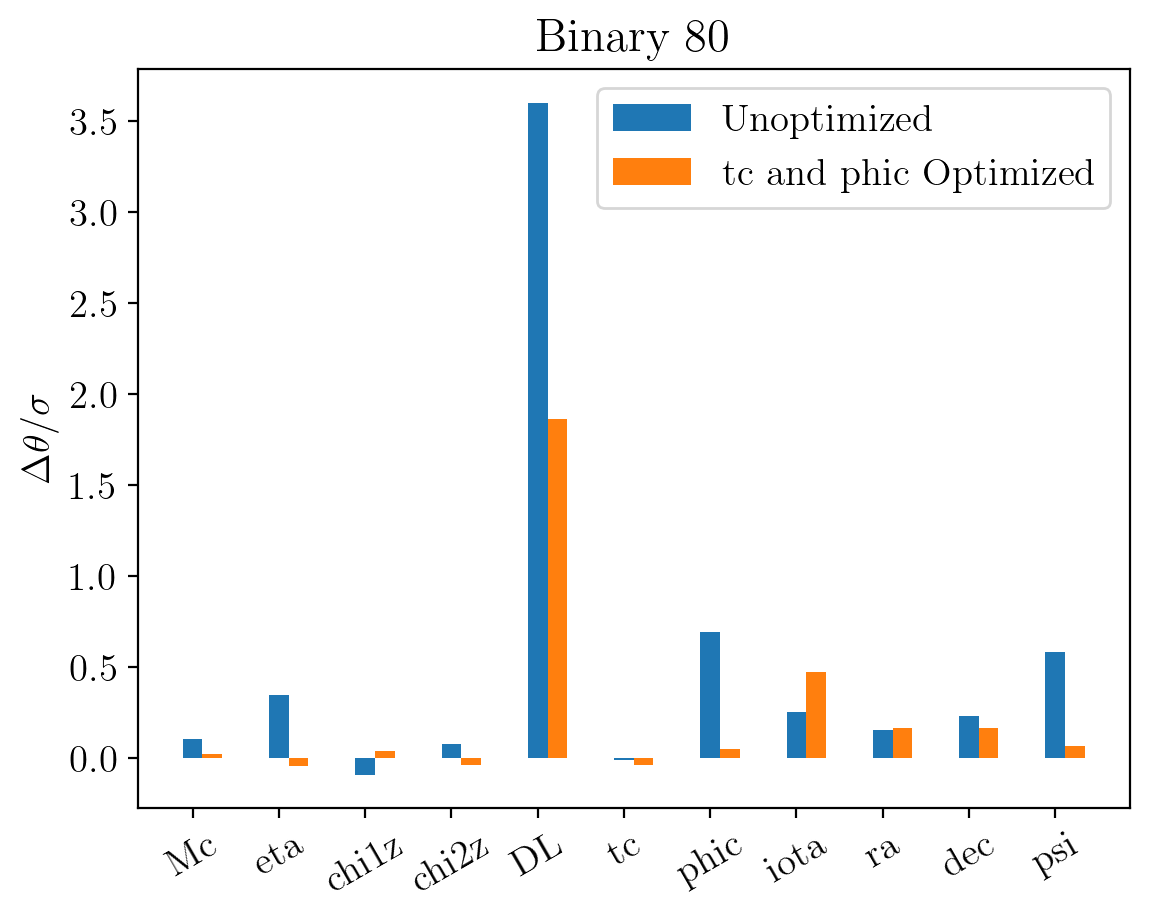

2023-11-21 16:16:41,136 - Network - INFO : Polarizations calculated.
2023-11-21 16:16:41,137 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 16:16:41,148 - Network - INFO : Polarizations calculated.


######  Binary 81  ######


2023-11-21 16:16:43,693 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:16:43,739 - Network - INFO : PSDs loaded.
2023-11-21 16:16:43,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:16:43,782 - Network - INFO : Detector responses calculated.
2023-11-21 16:16:43,783 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:16:43,783 - Network - INFO :    CE-40_C
2023-11-21 16:16:45,610 - Network - INFO :    CE-20_S
2023-11-21 16:16:47,343 - Network - INFO :    ET_ET1
2023-11-21 16:16:49,029 - Network - INFO :    ET_ET2
2023-11-21 16:16:50,733 - Network - INFO :    ET_ET3
2023-11-21 16:16:52,449 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:16:52,452 - Network - INFO : SNRs calculated.
2023-11-21 16:16:52,453 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:16:52,453 - Network - INFO :    CE-40_C
2023-11-21 16:16:52,514 - Network - INFO :

Mc bias diff: 99.78%
Mc, not: -1.715 sigma
Mc, opt: -0.004 sigma

eta bias diff: 99.86%
eta, not: 1.802 sigma
eta, opt: 0.003 sigma

chi1z bias diff: 99.92%
chi1z, not: -1.546 sigma
chi1z, opt: -0.001 sigma

chi2z bias diff: 99.94%
chi2z, not: 1.476 sigma
chi2z, opt: 0.001 sigma

DL bias diff: 44.37%
DL, not: 21.994 sigma
DL, opt: 12.235 sigma

tc bias diff: 99.94%
tc, not: 1.471 sigma
tc, opt: 0.001 sigma

phic bias diff: 99.98%
phic, not: 2.258 sigma
phic, opt: 0.001 sigma

iota bias diff: 90.40%
iota, not: 0.147 sigma
iota, opt: 0.014 sigma

ra bias diff: 95.89%
ra, not: 0.174 sigma
ra, opt: 0.007 sigma

dec bias diff: 97.37%
dec, not: -0.172 sigma
dec, opt: -0.005 sigma

psi bias diff: 101.62%
psi, not: -0.364 sigma
psi, opt: 0.006 sigma

######  Binary 82  ######


2023-11-21 16:17:07,053 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:17:07,098 - Network - INFO : PSDs loaded.
2023-11-21 16:17:07,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:17:07,135 - Network - INFO : Detector responses calculated.
2023-11-21 16:17:07,136 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:17:07,136 - Network - INFO :    CE-40_C
2023-11-21 16:17:08,531 - Network - INFO :    CE-20_S
2023-11-21 16:17:09,932 - Network - INFO :    ET_ET1
2023-11-21 16:17:11,336 - Network - INFO :    ET_ET2
2023-11-21 16:17:12,745 - Network - INFO :    ET_ET3
2023-11-21 16:17:14,194 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:17:14,197 - Network - INFO : SNRs calculated.
2023-11-21 16:17:14,197 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:17:14,198 - Network - INFO :    CE-40_C
2023-11-21 16:17:14,254 - Network - INFO :

Mc bias diff: 100.49%
Mc, not: -2.496 sigma
Mc, opt: 0.012 sigma

eta bias diff: 103.20%
eta, not: 3.530 sigma
eta, opt: -0.113 sigma

chi1z bias diff: 106.37%
chi1z, not: -2.344 sigma
chi1z, opt: 0.149 sigma

chi2z bias diff: 107.13%
chi2z, not: 2.139 sigma
chi2z, opt: -0.152 sigma

DL bias diff: 67.99%
DL, not: 3.078 sigma
DL, opt: 0.985 sigma

tc bias diff: 106.77%
tc, not: 2.240 sigma
tc, opt: -0.152 sigma

phic bias diff: 680.69%
phic, not: 0.037 sigma
phic, opt: -0.215 sigma

iota bias diff: -236.98%
iota, not: -0.800 sigma
iota, opt: -2.696 sigma

ra bias diff: -458.53%
ra, not: -0.024 sigma
ra, opt: -0.136 sigma

dec bias diff: 109.27%
dec, not: 0.087 sigma
dec, opt: -0.008 sigma

psi bias diff: 34.46%
psi, not: 0.310 sigma
psi, opt: 0.203 sigma

######  Binary 83  ######


2023-11-21 16:17:26,403 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:17:26,449 - Network - INFO : PSDs loaded.
2023-11-21 16:17:26,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:17:26,487 - Network - INFO : Detector responses calculated.
2023-11-21 16:17:26,488 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:17:26,488 - Network - INFO :    CE-40_C
2023-11-21 16:17:27,804 - Network - INFO :    CE-20_S
2023-11-21 16:17:29,146 - Network - INFO :    ET_ET1
2023-11-21 16:17:30,498 - Network - INFO :    ET_ET2
2023-11-21 16:17:31,874 - Network - INFO :    ET_ET3
2023-11-21 16:17:33,167 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:17:33,171 - Network - INFO : SNRs calculated.
2023-11-21 16:17:33,171 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:17:33,172 - Network - INFO :    CE-40_C
2023-11-21 16:17:33,232 - Network - INFO :

Mc bias diff: 107.33%
Mc, not: 1.007 sigma
Mc, opt: -0.074 sigma

eta bias diff: 102.09%
eta, not: 4.581 sigma
eta, opt: -0.096 sigma

chi1z bias diff: 103.21%
chi1z, not: -4.381 sigma
chi1z, opt: 0.141 sigma

chi2z bias diff: 103.27%
chi2z, not: 4.354 sigma
chi2z, opt: -0.142 sigma

DL bias diff: 47.77%
DL, not: 16.905 sigma
DL, opt: 8.830 sigma

tc bias diff: 103.22%
tc, not: 4.367 sigma
tc, opt: -0.140 sigma

phic bias diff: 97.97%
phic, not: 2.947 sigma
phic, opt: 0.060 sigma

iota bias diff: 242.43%
iota, not: -0.334 sigma
iota, opt: 0.475 sigma

ra bias diff: 268.06%
ra, not: -0.079 sigma
ra, opt: 0.132 sigma

dec bias diff: 191.49%
dec, not: -0.119 sigma
dec, opt: 0.109 sigma

psi bias diff: 89.14%
psi, not: 1.328 sigma
psi, opt: 0.144 sigma

######  Binary 84  ######


2023-11-21 16:17:45,421 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:17:45,467 - Network - INFO : PSDs loaded.
2023-11-21 16:17:45,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:17:45,510 - Network - INFO : Detector responses calculated.
2023-11-21 16:17:45,511 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:17:45,511 - Network - INFO :    CE-40_C
2023-11-21 16:17:47,218 - Network - INFO :    CE-20_S
2023-11-21 16:17:48,857 - Network - INFO :    ET_ET1
2023-11-21 16:17:50,498 - Network - INFO :    ET_ET2
2023-11-21 16:17:52,124 - Network - INFO :    ET_ET3
2023-11-21 16:17:53,772 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:17:53,776 - Network - INFO : SNRs calculated.
2023-11-21 16:17:53,776 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:17:53,777 - Network - INFO :    CE-40_C
2023-11-21 16:17:53,837 - Network - INFO :

Mc bias diff: 100.11%
Mc, not: -1.579 sigma
Mc, opt: 0.002 sigma

eta bias diff: 104.49%
eta, not: 1.958 sigma
eta, opt: -0.088 sigma

chi1z bias diff: 105.49%
chi1z, not: -1.871 sigma
chi1z, opt: 0.103 sigma

chi2z bias diff: 105.87%
chi2z, not: 1.830 sigma
chi2z, opt: -0.107 sigma

DL bias diff: 50.58%
DL, not: 12.098 sigma
DL, opt: 5.978 sigma

tc bias diff: 105.79%
tc, not: 1.836 sigma
tc, opt: -0.106 sigma

phic bias diff: 102.32%
phic, not: 2.105 sigma
phic, opt: -0.049 sigma

iota bias diff: 776.02%
iota, not: -0.219 sigma
iota, opt: 1.480 sigma

ra bias diff: 7.90%
ra, not: -0.223 sigma
ra, opt: -0.206 sigma

dec bias diff: 22.90%
dec, not: 0.257 sigma
dec, opt: 0.198 sigma

psi bias diff: -289.50%
psi, not: -0.013 sigma
psi, opt: -0.051 sigma

######  Binary 85  ######


2023-11-21 16:18:07,108 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:18:07,182 - Network - INFO : PSDs loaded.
2023-11-21 16:18:07,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:18:07,215 - Network - INFO : Detector responses calculated.
2023-11-21 16:18:07,216 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:18:07,217 - Network - INFO :    CE-40_C
2023-11-21 16:18:08,185 - Network - INFO :    CE-20_S
2023-11-21 16:18:09,097 - Network - INFO :    ET_ET1
2023-11-21 16:18:10,008 - Network - INFO :    ET_ET2
2023-11-21 16:18:10,933 - Network - INFO :    ET_ET3
2023-11-21 16:18:11,849 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:18:11,852 - Network - INFO : SNRs calculated.
2023-11-21 16:18:11,853 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:18:11,853 - Network - INFO :    CE-40_C
2023-11-21 16:18:11,909 - Network - INFO :

Mc bias diff: 102.16%
Mc, not: 1.927 sigma
Mc, opt: -0.042 sigma

eta bias diff: 99.85%
eta, not: 3.072 sigma
eta, opt: 0.005 sigma

chi1z bias diff: 99.88%
chi1z, not: -3.442 sigma
chi1z, opt: -0.004 sigma

chi2z bias diff: 99.89%
chi2z, not: 3.449 sigma
chi2z, opt: 0.004 sigma

DL bias diff: 91.52%
DL, not: 0.541 sigma
DL, opt: 0.046 sigma

tc bias diff: 99.83%
tc, not: 3.417 sigma
tc, opt: 0.006 sigma

phic bias diff: 151.64%
phic, not: 0.243 sigma
phic, opt: -0.126 sigma

iota bias diff: -1616.65%
iota, not: 0.462 sigma
iota, opt: 7.929 sigma

ra bias diff: -339.97%
ra, not: -0.083 sigma
ra, opt: -0.364 sigma

dec bias diff: 332.69%
dec, not: 0.136 sigma
dec, opt: -0.317 sigma

psi bias diff: -1651.65%
psi, not: -0.007 sigma
psi, opt: -0.129 sigma

######  Binary 86  ######


2023-11-21 16:18:20,900 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:18:20,946 - Network - INFO : PSDs loaded.
2023-11-21 16:18:20,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:18:20,982 - Network - INFO : Detector responses calculated.
2023-11-21 16:18:20,982 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:18:20,983 - Network - INFO :    CE-40_C
2023-11-21 16:18:22,236 - Network - INFO :    CE-20_S
2023-11-21 16:18:23,539 - Network - INFO :    ET_ET1
2023-11-21 16:18:24,819 - Network - INFO :    ET_ET2
2023-11-21 16:18:26,112 - Network - INFO :    ET_ET3
2023-11-21 16:18:27,451 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:18:27,455 - Network - INFO : SNRs calculated.
2023-11-21 16:18:27,455 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:18:27,456 - Network - INFO :    CE-40_C
2023-11-21 16:18:27,512 - Network - INFO :

Mc bias diff: 87.12%
Mc, not: 0.894 sigma
Mc, opt: 0.115 sigma

eta bias diff: 103.73%
eta, not: 1.230 sigma
eta, opt: -0.046 sigma

chi1z bias diff: 98.80%
chi1z, not: -1.472 sigma
chi1z, opt: -0.018 sigma

chi2z bias diff: 97.93%
chi2z, not: 1.504 sigma
chi2z, opt: 0.031 sigma

DL bias diff: 63.55%
DL, not: 4.323 sigma
DL, opt: 1.576 sigma

tc bias diff: 97.74%
tc, not: 1.500 sigma
tc, opt: 0.034 sigma

phic bias diff: 87.76%
phic, not: 0.618 sigma
phic, opt: 0.076 sigma

iota bias diff: -1578.20%
iota, not: 0.162 sigma
iota, opt: 2.725 sigma

ra bias diff: 177.07%
ra, not: 0.209 sigma
ra, opt: -0.161 sigma

dec bias diff: -6.99%
dec, not: 0.295 sigma
dec, opt: 0.315 sigma

psi bias diff: 128.66%
psi, not: -0.368 sigma
psi, opt: 0.106 sigma

######  Binary 87  ######


2023-11-21 16:18:39,647 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:18:39,692 - Network - INFO : PSDs loaded.
2023-11-21 16:18:39,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:18:39,738 - Network - INFO : Detector responses calculated.
2023-11-21 16:18:39,738 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:18:39,739 - Network - INFO :    CE-40_C
2023-11-21 16:18:41,622 - Network - INFO :    CE-20_S
2023-11-21 16:18:43,440 - Network - INFO :    ET_ET1
2023-11-21 16:18:45,282 - Network - INFO :    ET_ET2
2023-11-21 16:18:47,117 - Network - INFO :    ET_ET3
2023-11-21 16:18:48,952 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:18:48,956 - Network - INFO : SNRs calculated.
2023-11-21 16:18:48,956 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:18:48,957 - Network - INFO :    CE-40_C
2023-11-21 16:18:49,018 - Network - INFO :

Mc bias diff: 100.81%
Mc, not: -5.039 sigma
Mc, opt: 0.041 sigma

eta bias diff: 100.67%
eta, not: 4.813 sigma
eta, opt: -0.032 sigma

chi1z bias diff: 100.69%
chi1z, not: -3.933 sigma
chi1z, opt: 0.027 sigma

chi2z bias diff: 100.69%
chi2z, not: 3.756 sigma
chi2z, opt: -0.026 sigma

DL bias diff: 44.71%
DL, not: 12.113 sigma
DL, opt: 6.697 sigma

tc bias diff: 100.69%
tc, not: 3.806 sigma
tc, opt: -0.026 sigma

phic bias diff: 101.18%
phic, not: 4.245 sigma
phic, opt: -0.050 sigma

iota bias diff: 80.14%
iota, not: -0.574 sigma
iota, opt: -0.114 sigma

ra bias diff: 115.58%
ra, not: -0.037 sigma
ra, opt: 0.006 sigma

dec bias diff: 47.23%
dec, not: -0.089 sigma
dec, opt: -0.047 sigma

psi bias diff: 92.74%
psi, not: 0.281 sigma
psi, opt: 0.020 sigma

######  Binary 88  ######


2023-11-21 16:19:05,057 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:19:05,174 - Network - INFO : PSDs loaded.
2023-11-21 16:19:05,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:19:05,224 - Network - INFO : Detector responses calculated.
2023-11-21 16:19:05,224 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:19:05,225 - Network - INFO :    CE-40_C
2023-11-21 16:19:07,345 - Network - INFO :    CE-20_S
2023-11-21 16:19:09,388 - Network - INFO :    ET_ET1
2023-11-21 16:19:11,424 - Network - INFO :    ET_ET2
2023-11-21 16:19:13,470 - Network - INFO :    ET_ET3
2023-11-21 16:19:15,540 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:19:15,544 - Network - INFO : SNRs calculated.
2023-11-21 16:19:15,545 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:19:15,545 - Network - INFO :    CE-40_C
2023-11-21 16:19:15,610 - Network - INFO :

Mc bias diff: 100.46%
Mc, not: -2.149 sigma
Mc, opt: 0.010 sigma

eta bias diff: 99.92%
eta, not: -5.794 sigma
eta, opt: -0.005 sigma

chi1z bias diff: 104.13%
chi1z, not: 1.456 sigma
chi1z, opt: -0.060 sigma

chi2z bias diff: 103.21%
chi2z, not: -1.880 sigma
chi2z, opt: 0.060 sigma

DL bias diff: 41.57%
DL, not: 5.072 sigma
DL, opt: 2.964 sigma

tc bias diff: 100.09%
tc, not: -5.992 sigma
tc, opt: 0.005 sigma

phic bias diff: 102.44%
phic, not: -0.641 sigma
phic, opt: 0.016 sigma

iota bias diff: -13.41%
iota, not: -0.348 sigma
iota, opt: -0.394 sigma

ra bias diff: 68.47%
ra, not: -0.359 sigma
ra, opt: -0.113 sigma

dec bias diff: 96.86%
dec, not: 0.449 sigma
dec, opt: 0.014 sigma

psi bias diff: 101.88%
psi, not: 0.935 sigma
psi, opt: -0.018 sigma

######  Binary 89  ######


2023-11-21 16:19:31,391 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:19:31,447 - Network - INFO : PSDs loaded.
2023-11-21 16:19:31,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:19:31,481 - Network - INFO : Detector responses calculated.
2023-11-21 16:19:31,482 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:19:31,482 - Network - INFO :    CE-40_C
2023-11-21 16:19:32,370 - Network - INFO :    CE-20_S
2023-11-21 16:19:33,240 - Network - INFO :    ET_ET1
2023-11-21 16:19:34,111 - Network - INFO :    ET_ET2
2023-11-21 16:19:34,988 - Network - INFO :    ET_ET3
2023-11-21 16:19:35,860 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:19:35,863 - Network - INFO : SNRs calculated.
2023-11-21 16:19:35,864 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:19:35,864 - Network - INFO :    CE-40_C
2023-11-21 16:19:35,921 - Network - INFO :

Mc bias diff: 97.84%
Mc, not: -0.756 sigma
Mc, opt: -0.016 sigma

eta bias diff: 99.14%
eta, not: 2.782 sigma
eta, opt: 0.024 sigma

chi1z bias diff: 94.47%
chi1z, not: 0.200 sigma
chi1z, opt: 0.011 sigma

chi2z bias diff: 96.87%
chi2z, not: -0.576 sigma
chi2z, opt: -0.018 sigma

DL bias diff: 62.96%
DL, not: 3.768 sigma
DL, opt: 1.396 sigma

tc bias diff: 96.37%
tc, not: -0.370 sigma
tc, opt: -0.013 sigma

phic bias diff: 155.41%
phic, not: 0.272 sigma
phic, opt: -0.151 sigma

iota bias diff: -176.92%
iota, not: 1.052 sigma
iota, opt: 2.913 sigma

ra bias diff: 16.03%
ra, not: 0.331 sigma
ra, opt: 0.278 sigma

dec bias diff: -79.71%
dec, not: 0.224 sigma
dec, opt: 0.402 sigma

psi bias diff: 1168.99%
psi, not: 0.016 sigma
psi, opt: -0.173 sigma

######  Binary 90  ######


2023-11-21 16:19:44,576 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:19:44,623 - Network - INFO : PSDs loaded.
2023-11-21 16:19:44,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:19:44,663 - Network - INFO : Detector responses calculated.
2023-11-21 16:19:44,664 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:19:44,665 - Network - INFO :    CE-40_C
2023-11-21 16:19:46,012 - Network - INFO :    CE-20_S
2023-11-21 16:19:47,346 - Network - INFO :    ET_ET1
2023-11-21 16:19:48,694 - Network - INFO :    ET_ET2
2023-11-21 16:19:50,015 - Network - INFO :    ET_ET3
2023-11-21 16:19:51,340 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:19:51,344 - Network - INFO : SNRs calculated.
2023-11-21 16:19:51,344 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:19:51,344 - Network - INFO :    CE-40_C
2023-11-21 16:19:51,405 - Network - INFO :

Mc bias diff: 99.81%
Mc, not: 1.052 sigma
Mc, opt: 0.002 sigma

eta bias diff: 104.57%
eta, not: 1.435 sigma
eta, opt: -0.066 sigma

chi1z bias diff: 103.77%
chi1z, not: -1.875 sigma
chi1z, opt: 0.071 sigma

chi2z bias diff: 103.63%
chi2z, not: 1.933 sigma
chi2z, opt: -0.070 sigma

DL bias diff: 88.01%
DL, not: 2.644 sigma
DL, opt: 0.317 sigma

tc bias diff: 103.71%
tc, not: 1.953 sigma
tc, opt: -0.072 sigma

phic bias diff: 72.67%
phic, not: 0.795 sigma
phic, opt: 0.217 sigma

iota bias diff: -1766.52%
iota, not: -0.202 sigma
iota, opt: -3.771 sigma

ra bias diff: 166.25%
ra, not: 0.330 sigma
ra, opt: -0.219 sigma

dec bias diff: 142.06%
dec, not: -0.267 sigma
dec, opt: 0.112 sigma

psi bias diff: 22.62%
psi, not: -0.398 sigma
psi, opt: -0.308 sigma



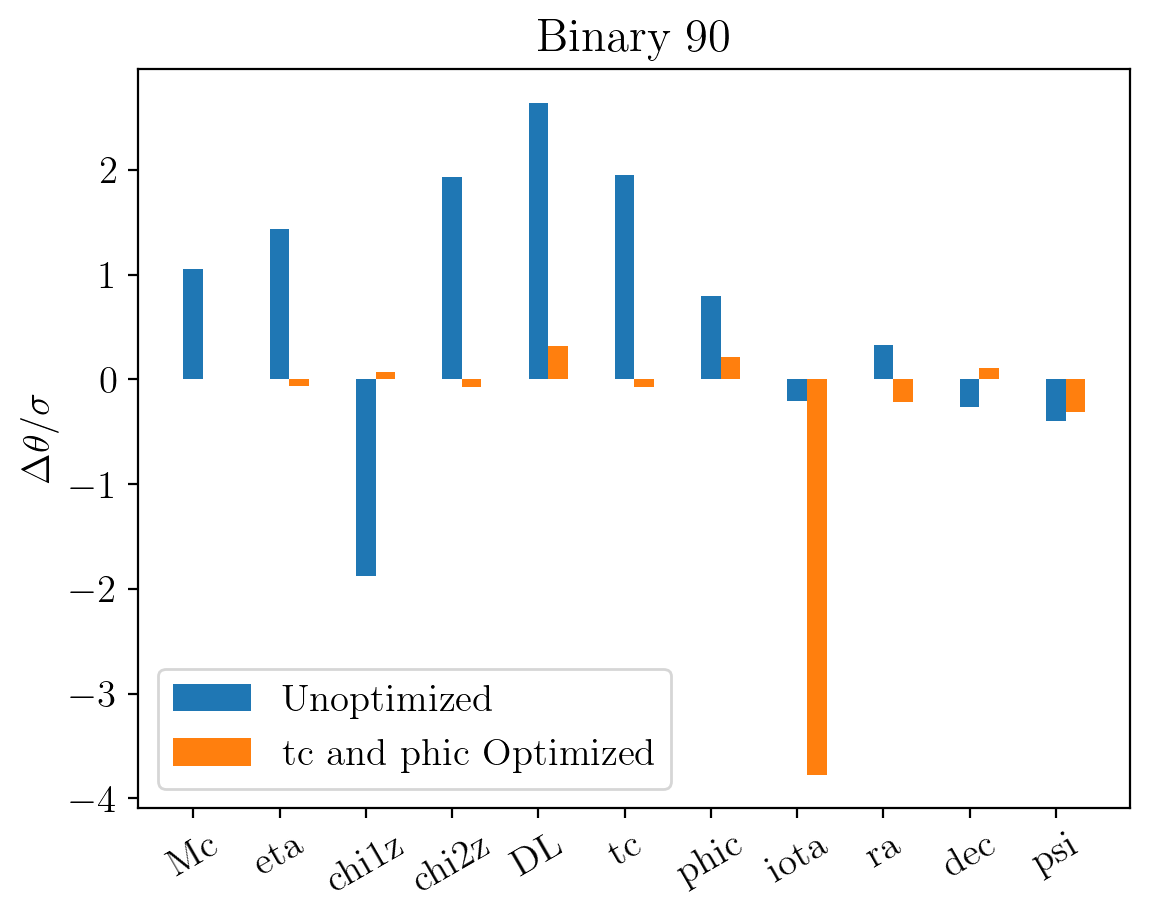

2023-11-21 16:20:02,025 - Network - INFO : Polarizations calculated.
2023-11-21 16:20:02,026 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-11-21 16:20:02,038 - Network - INFO : Polarizations calculated.


######  Binary 91  ######


2023-11-21 16:20:04,049 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:20:04,096 - Network - INFO : PSDs loaded.
2023-11-21 16:20:04,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:20:04,132 - Network - INFO : Detector responses calculated.
2023-11-21 16:20:04,133 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:20:04,133 - Network - INFO :    CE-40_C
2023-11-21 16:20:05,351 - Network - INFO :    CE-20_S
2023-11-21 16:20:06,583 - Network - INFO :    ET_ET1
2023-11-21 16:20:07,833 - Network - INFO :    ET_ET2
2023-11-21 16:20:09,050 - Network - INFO :    ET_ET3
2023-11-21 16:20:10,267 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:20:10,270 - Network - INFO : SNRs calculated.
2023-11-21 16:20:10,271 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:20:10,271 - Network - INFO :    CE-40_C
2023-11-21 16:20:10,325 - Network - INFO :

Mc bias diff: 100.50%
Mc, not: 3.375 sigma
Mc, opt: -0.017 sigma

eta bias diff: 100.71%
eta, not: 2.051 sigma
eta, opt: -0.015 sigma

chi1z bias diff: 100.80%
chi1z, not: -2.806 sigma
chi1z, opt: 0.023 sigma

chi2z bias diff: 100.81%
chi2z, not: 2.887 sigma
chi2z, opt: -0.023 sigma

DL bias diff: 112.87%
DL, not: 0.253 sigma
DL, opt: -0.033 sigma

tc bias diff: 100.75%
tc, not: 2.860 sigma
tc, opt: -0.022 sigma

phic bias diff: 173.50%
phic, not: -0.036 sigma
phic, opt: 0.027 sigma

iota bias diff: -273.76%
iota, not: 1.363 sigma
iota, opt: 5.096 sigma

ra bias diff: 91.30%
ra, not: 1.198 sigma
ra, opt: 0.104 sigma

dec bias diff: 88.51%
dec, not: -0.976 sigma
dec, opt: -0.112 sigma

psi bias diff: 160.15%
psi, not: -0.044 sigma
psi, opt: 0.027 sigma

######  Binary 92  ######


2023-11-21 16:20:20,534 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:20:20,715 - Network - INFO : PSDs loaded.
2023-11-21 16:20:20,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:20:20,742 - Network - INFO : Detector responses calculated.
2023-11-21 16:20:20,743 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:20:20,744 - Network - INFO :    CE-40_C
2023-11-21 16:20:21,504 - Network - INFO :    CE-20_S
2023-11-21 16:20:22,312 - Network - INFO :    ET_ET1
2023-11-21 16:20:23,122 - Network - INFO :    ET_ET2
2023-11-21 16:20:23,928 - Network - INFO :    ET_ET3
2023-11-21 16:20:24,739 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:20:24,743 - Network - INFO : SNRs calculated.
2023-11-21 16:20:24,743 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:20:24,744 - Network - INFO :    CE-40_C
2023-11-21 16:20:24,808 - Network - INFO :

Mc bias diff: 95.68%
Mc, not: 8.531 sigma
Mc, opt: 0.369 sigma

eta bias diff: 99.21%
eta, not: 23.160 sigma
eta, opt: 0.183 sigma

chi1z bias diff: 98.67%
chi1z, not: -22.498 sigma
chi1z, opt: -0.298 sigma

chi2z bias diff: 98.59%
chi2z, not: 22.446 sigma
chi2z, opt: 0.316 sigma

DL bias diff: 47.74%
DL, not: 6.206 sigma
DL, opt: 3.243 sigma

tc bias diff: 98.62%
tc, not: 22.237 sigma
tc, opt: 0.308 sigma

phic bias diff: 104.19%
phic, not: 5.141 sigma
phic, opt: -0.216 sigma

iota bias diff: -92.12%
iota, not: -1.767 sigma
iota, opt: -3.394 sigma

ra bias diff: 121.99%
ra, not: -0.962 sigma
ra, opt: 0.212 sigma

dec bias diff: 143.34%
dec, not: 1.431 sigma
dec, opt: -0.620 sigma

psi bias diff: 61.79%
psi, not: 0.695 sigma
psi, opt: 0.266 sigma

######  Binary 93  ######


2023-11-21 16:20:31,918 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:20:31,992 - Network - INFO : PSDs loaded.
2023-11-21 16:20:31,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:20:32,046 - Network - INFO : Detector responses calculated.
2023-11-21 16:20:32,047 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:20:32,048 - Network - INFO :    CE-40_C
2023-11-21 16:20:32,890 - Network - INFO :    CE-20_S
2023-11-21 16:20:33,711 - Network - INFO :    ET_ET1
2023-11-21 16:20:34,533 - Network - INFO :    ET_ET2
2023-11-21 16:20:35,354 - Network - INFO :    ET_ET3
2023-11-21 16:20:36,182 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:20:36,186 - Network - INFO : SNRs calculated.
2023-11-21 16:20:36,187 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:20:36,187 - Network - INFO :    CE-40_C
2023-11-21 16:20:36,250 - Network - INFO :

Mc bias diff: 58.48%
Mc, not: -0.554 sigma
Mc, opt: -0.230 sigma

eta bias diff: 99.53%
eta, not: 7.623 sigma
eta, opt: 0.036 sigma

chi1z bias diff: 97.90%
chi1z, not: -4.973 sigma
chi1z, opt: -0.104 sigma

chi2z bias diff: 97.69%
chi2z, not: 4.629 sigma
chi2z, opt: 0.107 sigma

DL bias diff: 43.49%
DL, not: 24.799 sigma
DL, opt: 14.014 sigma

tc bias diff: 97.82%
tc, not: 4.846 sigma
tc, opt: 0.106 sigma

phic bias diff: 96.42%
phic, not: 4.799 sigma
phic, opt: 0.172 sigma

iota bias diff: 58.22%
iota, not: -0.457 sigma
iota, opt: -0.191 sigma

ra bias diff: 124.42%
ra, not: -0.489 sigma
ra, opt: 0.119 sigma

dec bias diff: -191.98%
dec, not: -0.104 sigma
dec, opt: -0.304 sigma

psi bias diff: 84.72%
psi, not: 0.469 sigma
psi, opt: 0.072 sigma

######  Binary 94  ######


2023-11-21 16:20:45,113 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:20:45,160 - Network - INFO : PSDs loaded.
2023-11-21 16:20:45,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:20:45,207 - Network - INFO : Detector responses calculated.
2023-11-21 16:20:45,207 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:20:45,208 - Network - INFO :    CE-40_C
2023-11-21 16:20:47,071 - Network - INFO :    CE-20_S
2023-11-21 16:20:48,867 - Network - INFO :    ET_ET1
2023-11-21 16:20:50,663 - Network - INFO :    ET_ET2
2023-11-21 16:20:52,502 - Network - INFO :    ET_ET3
2023-11-21 16:20:54,346 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:20:54,361 - Network - INFO : SNRs calculated.
2023-11-21 16:20:54,362 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:20:54,362 - Network - INFO :    CE-40_C
2023-11-21 16:20:54,445 - Network - INFO :

Mc bias diff: 99.42%
Mc, not: -2.958 sigma
Mc, opt: -0.017 sigma

eta bias diff: 100.12%
eta, not: 2.830 sigma
eta, opt: -0.003 sigma

chi1z bias diff: 100.77%
chi1z, not: -2.191 sigma
chi1z, opt: 0.017 sigma

chi2z bias diff: 100.95%
chi2z, not: 2.060 sigma
chi2z, opt: -0.020 sigma

DL bias diff: 71.06%
DL, not: 1.561 sigma
DL, opt: 0.452 sigma

tc bias diff: 100.87%
tc, not: 2.069 sigma
tc, opt: -0.018 sigma

phic bias diff: 81.84%
phic, not: -0.134 sigma
phic, opt: -0.024 sigma

iota bias diff: -459.50%
iota, not: 0.170 sigma
iota, opt: 0.949 sigma

ra bias diff: -33.15%
ra, not: 0.131 sigma
ra, opt: 0.175 sigma

dec bias diff: -517.73%
dec, not: -0.027 sigma
dec, opt: -0.165 sigma

psi bias diff: 89.50%
psi, not: -0.239 sigma
psi, opt: -0.025 sigma

######  Binary 95  ######


2023-11-21 16:21:09,034 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:21:09,086 - Network - INFO : PSDs loaded.
2023-11-21 16:21:09,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:21:09,122 - Network - INFO : Detector responses calculated.
2023-11-21 16:21:09,122 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:21:09,123 - Network - INFO :    CE-40_C
2023-11-21 16:21:10,164 - Network - INFO :    CE-20_S
2023-11-21 16:21:11,190 - Network - INFO :    ET_ET1
2023-11-21 16:21:12,218 - Network - INFO :    ET_ET2
2023-11-21 16:21:13,266 - Network - INFO :    ET_ET3
2023-11-21 16:21:14,285 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:21:14,288 - Network - INFO : SNRs calculated.
2023-11-21 16:21:14,288 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:21:14,289 - Network - INFO :    CE-40_C
2023-11-21 16:21:14,343 - Network - INFO :

Mc bias diff: 99.23%
Mc, not: 7.086 sigma
Mc, opt: 0.055 sigma

eta bias diff: 100.45%
eta, not: 3.690 sigma
eta, opt: -0.017 sigma

chi1z bias diff: 100.35%
chi1z, not: -5.400 sigma
chi1z, opt: 0.019 sigma

chi2z bias diff: 100.34%
chi2z, not: 5.514 sigma
chi2z, opt: -0.019 sigma

DL bias diff: 77.84%
DL, not: 1.254 sigma
DL, opt: 0.278 sigma

tc bias diff: 100.32%
tc, not: 5.663 sigma
tc, opt: -0.018 sigma

phic bias diff: 25.81%
phic, not: -0.131 sigma
phic, opt: -0.097 sigma

iota bias diff: -215.44%
iota, not: 0.448 sigma
iota, opt: 1.413 sigma

ra bias diff: 68.92%
ra, not: -0.813 sigma
ra, opt: -0.253 sigma

dec bias diff: 28.96%
dec, not: 0.101 sigma
dec, opt: 0.072 sigma

psi bias diff: 73.03%
psi, not: -0.349 sigma
psi, opt: -0.094 sigma

######  Binary 96  ######


2023-11-21 16:21:23,613 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:21:23,697 - Network - INFO : PSDs loaded.
2023-11-21 16:21:23,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:21:23,735 - Network - INFO : Detector responses calculated.
2023-11-21 16:21:23,735 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:21:23,736 - Network - INFO :    CE-40_C
2023-11-21 16:21:24,739 - Network - INFO :    CE-20_S
2023-11-21 16:21:25,704 - Network - INFO :    ET_ET1
2023-11-21 16:21:26,672 - Network - INFO :    ET_ET2
2023-11-21 16:21:27,621 - Network - INFO :    ET_ET3
2023-11-21 16:21:28,570 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:21:28,573 - Network - INFO : SNRs calculated.
2023-11-21 16:21:28,574 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:21:28,574 - Network - INFO :    CE-40_C
2023-11-21 16:21:28,631 - Network - INFO :

Mc bias diff: -646.18%
Mc, not: 0.016 sigma
Mc, opt: 0.121 sigma

eta bias diff: 95.91%
eta, not: 1.286 sigma
eta, opt: 0.053 sigma

chi1z bias diff: 90.90%
chi1z, not: -1.127 sigma
chi1z, opt: -0.102 sigma

chi2z bias diff: 89.08%
chi2z, not: 1.048 sigma
chi2z, opt: 0.114 sigma

DL bias diff: 62.17%
DL, not: 3.056 sigma
DL, opt: 1.156 sigma

tc bias diff: 89.50%
tc, not: 1.052 sigma
tc, opt: 0.110 sigma

phic bias diff: 88.20%
phic, not: 1.049 sigma
phic, opt: 0.124 sigma

iota bias diff: 1374.16%
iota, not: -0.039 sigma
iota, opt: 0.496 sigma

ra bias diff: 1292.62%
ra, not: -0.021 sigma
ra, opt: 0.251 sigma

dec bias diff: -628.10%
dec, not: 0.046 sigma
dec, opt: 0.332 sigma

psi bias diff: -1886.57%
psi, not: 0.032 sigma
psi, opt: 0.628 sigma

######  Binary 97  ######


2023-11-21 16:21:38,379 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:21:38,424 - Network - INFO : PSDs loaded.
2023-11-21 16:21:38,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:21:38,464 - Network - INFO : Detector responses calculated.
2023-11-21 16:21:38,464 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:21:38,465 - Network - INFO :    CE-40_C
2023-11-21 16:21:39,980 - Network - INFO :    CE-20_S
2023-11-21 16:21:41,489 - Network - INFO :    ET_ET1
2023-11-21 16:21:43,044 - Network - INFO :    ET_ET2
2023-11-21 16:21:44,568 - Network - INFO :    ET_ET3
2023-11-21 16:21:46,153 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:21:46,157 - Network - INFO : SNRs calculated.
2023-11-21 16:21:46,157 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:21:46,157 - Network - INFO :    CE-40_C
2023-11-21 16:21:46,215 - Network - INFO :

Mc bias diff: 107.43%
Mc, not: -1.797 sigma
Mc, opt: 0.134 sigma

eta bias diff: 112.71%
eta, not: 2.157 sigma
eta, opt: -0.274 sigma

chi1z bias diff: 119.41%
chi1z, not: -1.695 sigma
chi1z, opt: 0.329 sigma

chi2z bias diff: 120.65%
chi2z, not: 1.613 sigma
chi2z, opt: -0.333 sigma

DL bias diff: 49.81%
DL, not: 8.077 sigma
DL, opt: 4.054 sigma

tc bias diff: 120.54%
tc, not: 1.637 sigma
tc, opt: -0.336 sigma

phic bias diff: 116.84%
phic, not: 1.934 sigma
phic, opt: -0.326 sigma

iota bias diff: -241.91%
iota, not: -0.336 sigma
iota, opt: -1.149 sigma

ra bias diff: 294.87%
ra, not: -0.010 sigma
ra, opt: 0.019 sigma

dec bias diff: 17.78%
dec, not: 0.154 sigma
dec, opt: 0.127 sigma

psi bias diff: -147.78%
psi, not: 0.111 sigma
psi, opt: 0.275 sigma

######  Binary 98  ######


2023-11-21 16:21:59,107 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:21:59,159 - Network - INFO : PSDs loaded.
2023-11-21 16:21:59,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:21:59,194 - Network - INFO : Detector responses calculated.
2023-11-21 16:21:59,195 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:21:59,196 - Network - INFO :    CE-40_C
2023-11-21 16:22:00,265 - Network - INFO :    CE-20_S
2023-11-21 16:22:01,306 - Network - INFO :    ET_ET1
2023-11-21 16:22:02,342 - Network - INFO :    ET_ET2
2023-11-21 16:22:03,390 - Network - INFO :    ET_ET3
2023-11-21 16:22:04,437 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:22:04,440 - Network - INFO : SNRs calculated.
2023-11-21 16:22:04,440 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:22:04,441 - Network - INFO :    CE-40_C
2023-11-21 16:22:04,492 - Network - INFO :

Mc bias diff: 100.57%
Mc, not: 5.348 sigma
Mc, opt: -0.031 sigma

eta bias diff: 100.89%
eta, not: 4.399 sigma
eta, opt: -0.039 sigma

chi1z bias diff: 100.76%
chi1z, not: -5.645 sigma
chi1z, opt: 0.043 sigma

chi2z bias diff: 100.75%
chi2z, not: 5.675 sigma
chi2z, opt: -0.043 sigma

DL bias diff: 45.14%
DL, not: 3.545 sigma
DL, opt: 1.945 sigma

tc bias diff: 100.68%
tc, not: 5.816 sigma
tc, opt: -0.040 sigma

phic bias diff: 96.87%
phic, not: 1.680 sigma
phic, opt: 0.053 sigma

iota bias diff: 23.12%
iota, not: -0.509 sigma
iota, opt: -0.392 sigma

ra bias diff: -10.15%
ra, not: -0.135 sigma
ra, opt: -0.149 sigma

dec bias diff: -22.75%
dec, not: -0.122 sigma
dec, opt: -0.149 sigma

psi bias diff: 107.06%
psi, not: 0.783 sigma
psi, opt: -0.055 sigma

######  Binary 99  ######


2023-11-21 16:22:15,327 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-11-21 16:22:15,373 - Network - INFO : PSDs loaded.
2023-11-21 16:22:15,376 - Network - INFO : Antenna patterns and LPFs loaded.
2023-11-21 16:22:15,421 - Network - INFO : Detector responses calculated.
2023-11-21 16:22:15,422 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-11-21 16:22:15,422 - Network - INFO :    CE-40_C
2023-11-21 16:22:17,480 - Network - INFO :    CE-20_S
2023-11-21 16:22:19,400 - Network - INFO :    ET_ET1
2023-11-21 16:22:21,395 - Network - INFO :    ET_ET2
2023-11-21 16:22:23,369 - Network - INFO :    ET_ET3
2023-11-21 16:22:25,367 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-11-21 16:22:25,371 - Network - INFO : SNRs calculated.
2023-11-21 16:22:25,371 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-11-21 16:22:25,371 - Network - INFO :    CE-40_C
2023-11-21 16:22:25,434 - Network - INFO :

Mc bias diff: 100.04%
Mc, not: -5.716 sigma
Mc, opt: 0.002 sigma

eta bias diff: 100.33%
eta, not: 5.299 sigma
eta, opt: -0.017 sigma

chi1z bias diff: 100.36%
chi1z, not: -4.129 sigma
chi1z, opt: 0.015 sigma

chi2z bias diff: 100.37%
chi2z, not: 3.935 sigma
chi2z, opt: -0.015 sigma

DL bias diff: 120.16%
DL, not: 1.292 sigma
DL, opt: -0.261 sigma

tc bias diff: 100.41%
tc, not: 3.989 sigma
tc, opt: -0.016 sigma

phic bias diff: 105.08%
phic, not: 0.810 sigma
phic, opt: -0.041 sigma

iota bias diff: -1709.83%
iota, not: -0.124 sigma
iota, opt: -2.236 sigma

ra bias diff: -533.17%
ra, not: -0.055 sigma
ra, opt: -0.346 sigma

dec bias diff: 44.76%
dec, not: -0.191 sigma
dec, opt: -0.106 sigma

psi bias diff: 105.57%
psi, not: -0.737 sigma
psi, opt: 0.041 sigma



In [61]:
# Takes ~0.5 min per binary
N_BINARIES = 100

avg_param_bias_diff = np.zeros(len(net_ap.deriv_variables))
avg_param_bias_diff_perc = np.zeros(len(net_ap.deriv_variables))

for i in range(N_BINARIES):

    print("######  Binary", i, " ######")
    # Generate compute waveforms and biases using the reference parameters
    inj_params = {
        'Mc':    Mcs[i],
        'eta':   etas[i],
        'chi1x': 0.,
        'chi2x': 0.,
        'chi1y': 0.,
        'chi2y': 0.,
        'chi1z': chi1z[i],
        'chi2z': chi2z[i],
        'DL':    DLs[i],
        'tc':    0,
        'phic':  0,
        'iota':  iotas[i],
        'ra':    ras[i],
        'dec':   decs[i],
        'psi':   psis[i],
        'gmst0': 0,
        'hybr': 0.0
    } 

    net_key = '3G'

    approx1 = 'IMRPhenomXAS'
    approx2 = 'IMRPhenomD'

    d_f = 2**-4
    f_low = 5.0
    mtotal = conv.mtotal_from_mchirp_eta(inj_params['Mc'], inj_params['eta'])
    f_high = np.round(4*br.f_isco_Msolar(mtotal))

    net_ap = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params, network_key=net_key, f_max=f_high,
                                approximant1=approx1, approximant2=approx2, cond_num=1e25)
    
    net_true = gwnet.get_network_response(inj_params=inj_params, f_max=f_high, approximant=approx1, network_key=net_key, calc_detector_responses=False)

    # Compute pycbc versions of the waveforms (to plot and compute mismatch)
    fd_waveforms_no_opt = get_pycbc_waveforms_fd(net_true, net_ap)
    td_waveforms_no_opt = get_pycbc_waveforms_td(net_true, net_ap)

    h1_fs = fd_waveforms_no_opt[0]
    h2_fs = fd_waveforms_no_opt[3]
    h1_ts = td_waveforms_no_opt[0]

    
    # Optimize over tc and phic
    match, index, phi = matchedfilter.optimized_match(h1_fs, h2_fs, return_phase=True)
    delta_t = h1_ts.delta_t
    tc = -index * delta_t
    phic = -phi

    inj_params_opt = inj_params.copy()
    inj_params_opt['tc'] = tc
    inj_params_opt['phic'] = phic

    # Compute biases for optimized waveform 2
    net_ap_opt = gwnet.get_hybrid_network_response(inj_params1=inj_params, inj_params2=inj_params_opt, network_key=net_key, f_max=f_high,
                            approximant1=approx1, approximant2=approx2, cond_num=1e25)
    

    # Plot the differences in Biases
    bias_opt = net_ap_opt.cutler_vallisneri_bias.tolist()[0]
    err_opt = np.zeros(len(bias_opt))

    bias_no_opt = net_ap.cutler_vallisneri_bias.tolist()[0]
    err_no_opt = np.zeros(len(bias_no_opt))

    
    for j, param in enumerate(net_ap_opt.deriv_variables):
        err_no_opt[j] = net_ap.errs[param]
        err_opt[j] = net_ap_opt.errs[param]

        bias1 = bias_no_opt[j]/net_ap.errs[param]
        bias2 = bias_opt[j]/net_ap_opt.errs[param]

        # Keep track of the difference in bias/sigma for each param
        bias_diff_perc = 100*(bias1-bias2)/bias1
        avg_param_bias_diff_perc[j] += np.abs(bias_diff_perc)
        avg_param_bias_diff[j] += np.abs(bias1-bias2)

        print(f"{param} bias diff: {bias_diff_perc :.2f}%")
        print(f"{param}, not: {bias_no_opt[j]/net_ap.errs[param]:.3f} sigma")
        print(f"{param}, opt: {bias_opt[j]/net_ap_opt.errs[param]:.3f} sigma")
        print()

    if (i%10 == 0):
        # plot the differences in bias
        x = np.linspace(0, len(bias_opt), len(bias_opt))
        width = 0.25
        plt.bar(x, bias_no_opt/err_no_opt, width=width, label='Unoptimized')
        plt.bar(x+width, bias_opt/err_opt, width=width, label='tc and phic Optimized')

        plt.xticks(x, net_ap_opt.deriv_variables, rotation=30)
        plt.title(f"Binary {i}")
        plt.ylabel('$\Delta \\theta / \\sigma$')
        # plt.yscale('symlog')
        plt.legend()
        plt.show()

avg_param_bias_diff = avg_param_bias_diff/i
avg_param_bias_diff_perc = avg_param_bias_diff_perc/i

In [62]:
for j, param in enumerate(net_ap.deriv_variables):
    print(f"|{param} bias diff|: {avg_param_bias_diff[j] :.2f} ({avg_param_bias_diff_perc[j] :.2f})%")

|Mc bias diff|: 2.81 (107.91)%
|eta bias diff|: 4.15 (105.26)%
|chi1z bias diff|: 4.15 (110.15)%
|chi2z bias diff|: 4.13 (105.60)%
|DL bias diff|: 5.07 (59.55)%
|tc bias diff|: 4.19 (108.14)%
|phic bias diff|: 2.16 (108.51)%
|iota bias diff|: 1.40 (715.93)%
|ra bias diff|: 0.39 (372.25)%
|dec bias diff|: 0.40 (308.44)%
|psi bias diff|: 0.40 (188.65)%
